In [2]:
import os
os.getcwd()
!kaggle competitions download -c quora-question-pairs 

/bin/sh: kaggle: command not found


In [ ]:
! sudo apt install openjdk-8-jdk
! sudo update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
! pip install language-check
! pip install pycontractions
!pip install pyspellchecker
!pip install word2number
!python -m spacy download en_core_web_md


In [1]:
# Essential Libraries

import spacy #load spacy
import nltk # load nltk
import re # for string manipulation

In [2]:
from nltk.stem.porter import * #NLTK Stemmer
from nltk.tokenize import RegexpTokenizer #Tokenizer
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import en_core_web_sm

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/ApoorvaSonavani/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ApoorvaSonavani/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
#from pycontractions import Contractions  #For expanding shorthand words - Text Preprocessing
import unicodedata # For text cleaning 
import gensim.downloader as api
from word2number import w2n
from textblob import TextBlob 
from spellchecker import SpellChecker 

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas.testing as tm
#from contractions import CONTRACTION_MAP

In [94]:
import pickle

In [5]:
train_df = pd.read_csv('/Users/ApoorvaSonavani/Desktop/ML Quora Project/train.csv')
train_df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [6]:
print('Number of training observations', train_df.shape[0])
train_df.info()

Number of training observations 404290
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


## Observation: 

There are 6 features. Our target variable is **is_duplicate**.

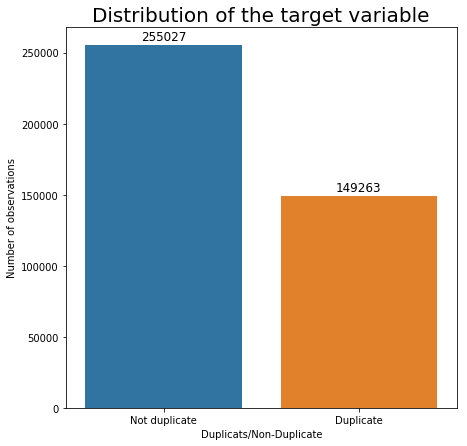

In [7]:
plt.figure(figsize=(7,7))
plot = sns.countplot(train_df['is_duplicate'])
plot.set_xticklabels(['Not duplicate', 'Duplicate'])
for p in plot.patches:
    height = p.get_height()
    width = p.get_x()+p.get_width()/2
    plot.annotate(height, (width,height), xytext = (0, 5), textcoords = "offset points", ha = 'center', fontsize=12)

plt.xlabel('Duplicats/Non-Duplicate')
plt.ylabel('Number of observations')
plt.title('Distribution of the target variable', fontsize = 20);

## Q1. What percentage of the questions are duplicates?

In [8]:
non_dup = train_df['is_duplicate'].value_counts()[0]
dup = train_df['is_duplicate'].value_counts()[1]

print('Percentage of Duplicate questions in the training data = ', round(dup*100/train_df.shape[0],2))
print('Percentage of Non-duplicate questions in the training data = ', round(non_dup*100/train_df.shape[0],2))

Percentage of Duplicate questions in the training data =  36.92
Percentage of Non-duplicate questions in the training data =  63.08


## Q2. Number of Unique Questions in the dataset

In [9]:
total_qns = train_df['qid1'].append(train_df['qid2'])

print('Total number of unique questions: ', total_qns.nunique())

Total number of unique questions:  537933


## Q3. How many questions appear repeatedly and how often?

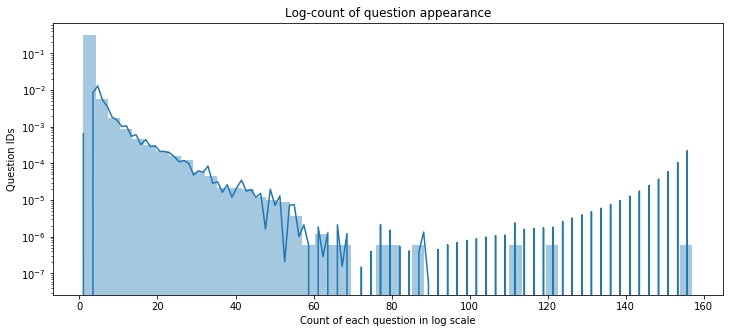

In [10]:
repeat_qns = sum(total_qns.value_counts() > 1)

plt.figure(figsize = (12,5))
sns.distplot(total_qns.value_counts())
plt.yscale('log')
plt.title('Log-count of question appearance')
plt.xlabel('Count of each question in log scale')
plt.ylabel('Question IDs');


## Text Preprocessing

### Missing Values Diagnosis

In [12]:
train_df.isnull().sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

One missing value in **question1** and 2 missing values in **question2**. We fill up NaNs with blank.

In [13]:
train_df = train_df.fillna('')

In [14]:
nlp = en_core_web_sm.load()

# Q4. What is the distribution of the length of questions?

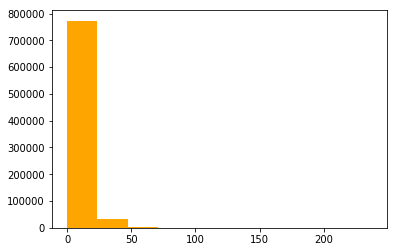

In [15]:
all_questions = train_df['question1'].append(train_df['question2']).to_list()

line_lengths = [len(text.split()) for text in all_questions]

h = plt.hist(line_lengths, bins = 50)

tokens = [item.split() for item in all_questions]
total_tokens_per_line = [len(item.split()) for item in all_questions]
h = plt.hist(total_tokens_per_line, color='orange')

### Data Cleaning and pre-processing

Essential Packages for text processing such as spacy and spell Checker have already be imported earlier. 

The definitions of the different cleaning functions are given below.

In [16]:
''' Function to remove accented characters such as "Áccěntěd těxt" '''
def remove_accented_chars(text):
  text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
  return text

''' Function to check and correct Spellings '''
def spell_correction(text):
  spell = SpellChecker()
  words = spell.split_words(text)
  return ' '.join([spell.correction(word) for word in words])


''' The main cleaning function '''
def string_cleaning(qn):
   # Replace special chars in text
    
    qn = re.sub("’", "'", qn) # special single quote
    qn = re.sub("`", "'", qn) # special single quote
    qn = re.sub("“", '"', qn) # special double quote
    qn = re.sub("？", "?", qn) 
    qn = re.sub("…", " ", qn) 

    #Removing Accented Text
    qn = remove_accented_chars(qn)
    #remove_accented_chars('Sómě Áccěntěd těxt')

    #Spell check
    qn = spell_correction(qn)

    #Remove all punctuation
    pattern = r'[^a-zA-z\s]'
    qn = re.sub(pattern, '', qn)
    # Clean shorthands
    qn = re.sub("e\.g\.", " eg ", qn, flags=re.IGNORECASE)
    qn = re.sub("b\.g\.", " bg ", qn, flags=re.IGNORECASE)
    qn = re.sub(r"(\W|^)([0-9]+)[kK](\W|$)", r"\1\g<2>000\3", qn) # better regex provided by @armamut
    qn = re.sub("e-mail", " email ", qn, flags=re.IGNORECASE)
    qn = re.sub("(the[\s]+|The[\s]+)?U\.S\.A\.", " America ", qn, flags=re.IGNORECASE)
    qn = re.sub("(the[\s]+|The[\s]+)?United State(s)?", " America ", qn, flags=re.IGNORECASE)
    qn = re.sub("\(s\)", " ", qn, flags=re.IGNORECASE)
    qn = re.sub("[c-fC-F]\:\/", " disk ", qn)
    
    # replace the float numbers with a random number, it will be parsed as number afterward, and also been replaced with word "number"
    
    qn = re.sub('[0-9]+\.[0-9]+', " 99 ", qn)
     
    # add padding to punctuations and special chars
    
    qn = re.sub('\$', " dollar ", qn)
    qn = re.sub('\%', " percent ", qn)
    qn = re.sub('\&', " and ", qn)

    return qn


In [17]:
spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
spacy_stopwords.add('di')
spacy_stopwords.add('d')
exception = {'no','like','not'}
spacy_stopwords = set([word for word in spacy_stopwords if word not in exception])

def preprocess(qn):
    # String operations
    
    qn = qn.lower()
    qn = string_cleaning(qn)

    #Tokenize text

    tokens = nlp(qn)

    #Lemmatization
    lemma_list = []
    for token in tokens:
        flag = True
        hold = token.text.strip()
        if token.is_stop and token.pos_ != 'NUM': 
            flag = False

        # convert number words to numeric numbers
        #if token.pos_ == 'NUM' and flag == True:
         #   hold = w2n.word_to_num(hold)

        elif token.lemma_ != "-PRON-" and flag == True:
            hold = token.lemma_

        if flag == True and hold != '':
            lemma_list.append(hold)
        #token_list



    return list(set(' '.join(lemma_list).split()))  #


In [71]:
train_cpy = train_df.copy()

In [57]:
type(train_cpy['question1'])

pandas.core.series.Series

In [72]:
train_cpy.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

# Topic Modelling

In [21]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV



import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)
# Plotting tools
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

In [73]:
sample = train_cpy.iloc[:,3:5]
sample

question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
...                                                   ...   
404285  How many keywords are there in the Racket prog...   
404286          Do you believe there is life after death?   
404287                                  What is one coin?   
404288  What is the approx annual cost of living while...   
404289              What is like to have sex with cousin?   

                                                question2  
0       What is the step by step guide to invest in sh...  
1       What would happen if the Indian government sto...  
2       How can Internet speed be increased by hacking...  
3       Find the remainder when [math]23^{24}[/math] i...  
4                 Which fish would survive in salt water?  
...                                                   ...  
404285  How many keywords are there in PERL Programmin...  
404286         Is it true that there is life after death?  
404287                                  What's this coin?  
404288  I am having little hairfall problem but I want...  
404289      What is it like to have sex with your cousin?  

[404290 rows x 2 columns]

In [74]:
stackedsample = sample.stack()
dfstack = pd.DataFrame(stackedsample, columns=['Questions'])
dfstack = dfstack.reset_index(drop = True)
dfques = dfstack["Questions"].tolist()
dfques

['What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'How can Internet speed be increased by hacking through DNS?',
 'Why am I mentally very lonely? How can I solve it?',
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Which fish would survive in salt water?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",
 'Should I buy tiago?',
 'What keeps childern active and far from phone and video games?',
 'How can I be a good geologist?',
 'What should 

In [103]:
filename = 'dfques.pkl'
pickle.dump(dfques, open(filename, 'wb'))

In [75]:
# NLTK Stop words
en_stop = stopwords.words('english')
en_stop.extend(['from', 'subject', 're', 'edu', 'use', 'd', 's', 'm'])
dfques[:1]

['What is the step by step guide to invest in share market in india?']

In [39]:
from nltk.stem.porter import PorterStemmer

In [62]:
tokenizer = RegexpTokenizer(r'\w+')
p_stemmer = PorterStemmer()

In [76]:
dfques

['What is the step by step guide to invest in share market in india?',
 'What is the step by step guide to invest in share market?',
 'What is the story of Kohinoor (Koh-i-Noor) Diamond?',
 'What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?',
 'How can I increase the speed of my internet connection while using a VPN?',
 'How can Internet speed be increased by hacking through DNS?',
 'Why am I mentally very lonely? How can I solve it?',
 'Find the remainder when [math]23^{24}[/math] is divided by 24,23?',
 'Which one dissolve in water quikly sugar, salt, methane and carbon di oxide?',
 'Which fish would survive in salt water?',
 'Astrology: I am a Capricorn Sun Cap moon and cap rising...what does that say about me?',
 "I'm a triple Capricorn (Sun, Moon and ascendant in Capricorn) What does this say about me?",
 'Should I buy tiago?',
 'What keeps childern active and far from phone and video games?',
 'How can I be a good geologist?',
 'What should 

In [77]:
# TOKENIZE TO CLEAN THE TEXT FURTHER
# list for tokenized documents in loop
tokenized_TM = []

# loop through document list
for i in dfques:
    
    # clean and tokenize document string
    raw = i.lower()
    tokens = tokenizer.tokenize(raw)

    # remove stop words from tokens
    stopped_tokens = [i for i in tokens if not i in en_stop and len(i) > 2]
    
    # stem tokens
    #stemmed_tokens = [p_stemmer.stem(i) for i in stopped_tokens]
    
    
    # add tokens to list
    tokenized_TM.append(stopped_tokens)

In [78]:
tokenized_TM[:5]

[['step', 'step', 'guide', 'invest', 'share', 'market', 'india'],
 ['step', 'step', 'guide', 'invest', 'share', 'market'],
 ['story', 'kohinoor', 'koh', 'noor', 'diamond'],
 ['would',
  'happen',
  'indian',
  'government',
  'stole',
  'kohinoor',
  'koh',
  'noor',
  'diamond',
  'back'],
 ['increase', 'speed', 'internet', 'connection', 'using', 'vpn']]

# Topic clustering using Gensim

## Step 1: Creating the dictionary from the corpus

In [79]:
dictionary = gensim.corpora.Dictionary(tokenized_TM)

2020-04-27 23:24:58,880 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2020-04-27 23:24:59,110 : INFO : adding document #10000 to Dictionary(9963 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:24:59,282 : INFO : adding document #20000 to Dictionary(14491 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:24:59,425 : INFO : adding document #30000 to Dictionary(17886 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:24:59,575 : INFO : adding document #40000 to Dictionary(20663 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:24:59,730 : INFO : adding document #50000 to Dictionary(23148 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:24:59,876 : INFO : adding document #60000 to Dictionary(25339 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:00,029 : INFO : adding document #70000 

2020-04-27 23:25:08,492 : INFO : adding document #580000 to Dictionary(73109 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:08,660 : INFO : adding document #590000 to Dictionary(73681 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:08,822 : INFO : adding document #600000 to Dictionary(74266 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:08,980 : INFO : adding document #610000 to Dictionary(74828 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:09,207 : INFO : adding document #620000 to Dictionary(75396 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:09,377 : INFO : adding document #630000 to Dictionary(75956 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)
2020-04-27 23:25:09,535 : INFO : adding document #640000 to Dictionary(76456 unique tokens: ['guide', 'india', 'invest', 'market', 'shar

Next we filter out words that are either too frequent in the overall corpus of questions (i.e. occuring more than 50%) or too rare (i.e. occuring in less than 15 questions)

In [80]:
dictionary.filter_extremes(no_below=2, no_above=0.5, keep_n=100000)

2020-04-27 23:25:24,367 : INFO : discarding 34093 tokens: [('childern', 1), ('motorolla', 1), ('biprism', 1), ('rexnord', 1), ('propellor', 1), ('israil', 1), ('sincerity', 1), ('ehrhardt', 1), ('yakshini', 1), ('intially', 1)]...
2020-04-27 23:25:24,368 : INFO : keeping 50691 tokens which were in no less than 2 and no more than 404290 (=50.0%) documents
2020-04-27 23:25:24,524 : INFO : resulting dictionary: Dictionary(50691 unique tokens: ['guide', 'india', 'invest', 'market', 'share']...)


## Step 2: Creating Bag-of-Words from the Tokens

In [81]:
bow_corpus = [dictionary.doc2bow(doc) for doc in tokenized_TM]
bow_corpus


bow_doc_100 = bow_corpus[100]
for i in range(len(bow_doc_100)):
    print("Word {} (\"{}\") appears {} time.".format(bow_doc_100[i][0], 
                                               dictionary[bow_doc_100[i][0]], 
bow_doc_100[i][1]))

Word 62 ("good") appears 1 time.
Word 330 ("career") appears 1 time.
Word 331 ("grade") appears 1 time.
Word 332 ("launcher") appears 1 time.
Word 333 ("preparation") appears 1 time.
Word 334 ("rbi") appears 1 time.


In [84]:
len(tokenized_TM)

808580

## Step 3: Creating the Document-Term Matrix using TF-IDF Vectorizer 

In [90]:
from gensim import corpora, models
from gensim.models.ldamodel import LdaModel
tfidf = models.TfidfModel(bow_corpus)

2020-04-27 23:41:28,080 : INFO : collecting document frequencies
2020-04-27 23:41:28,082 : INFO : PROGRESS: processing document #0
2020-04-27 23:41:28,104 : INFO : PROGRESS: processing document #10000
2020-04-27 23:41:28,122 : INFO : PROGRESS: processing document #20000
2020-04-27 23:41:28,140 : INFO : PROGRESS: processing document #30000
2020-04-27 23:41:28,161 : INFO : PROGRESS: processing document #40000
2020-04-27 23:41:28,219 : INFO : PROGRESS: processing document #50000
2020-04-27 23:41:28,247 : INFO : PROGRESS: processing document #60000
2020-04-27 23:41:28,271 : INFO : PROGRESS: processing document #70000
2020-04-27 23:41:28,322 : INFO : PROGRESS: processing document #80000
2020-04-27 23:41:28,409 : INFO : PROGRESS: processing document #90000
2020-04-27 23:41:28,437 : INFO : PROGRESS: processing document #100000
2020-04-27 23:41:28,472 : INFO : PROGRESS: processing document #110000
2020-04-27 23:41:28,516 : INFO : PROGRESS: processing document #120000
2020-04-27 23:41:28,546 : 

In [91]:
# If value is high, it means the word has a higher tf-idf weight.
# We want to remove words that have less weight i.e. as low as 0.1
low_value = 0.1
low_value_words = []
for item in bow_corpus:
    low_value_words += [id for id, value in tfidf[item] if value < low_value]
dictionary.filter_tokens(bad_ids=low_value_words)
corpus = [dictionary.doc2bow(doc) for doc in tokenized_TM]

In [95]:
filename = 'corpus.pkl'
pickle.dump(corpus, open(filename, 'wb'))

## Step 4: Running the LDA Algorithm from Gensim Package

Parameters:

1) Bag of words

In [93]:
lda_model = gensim.models.LdaMulticore(corpus, num_topics=10, id2word=dictionary, passes=2, workers=4)
print(lda_model.print_topics(num_topics= 10))

2020-04-27 23:46:19,215 : INFO : using symmetric alpha at 0.1
2020-04-27 23:46:19,217 : INFO : using symmetric eta at 0.1
2020-04-27 23:46:19,226 : INFO : using serial LDA version on this node
2020-04-27 23:46:19,272 : INFO : running online LDA training, 10 topics, 2 passes over the supplied corpus of 808580 documents, updating every 8000 documents, evaluating every ~80000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-27 23:46:19,274 : INFO : training LDA model using 4 processes
2020-04-27 23:46:19,362 : INFO : PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/808580, outstanding queue size 1
2020-04-27 23:46:19,531 : INFO : PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/808580, outstanding queue size 2
2020-04-27 23:46:19,533 : INFO : PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/808580, outstanding queue size 3
2020-04-27 23:46:19,536 : INFO : PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/808580, o

2020-04-27 23:46:32,302 : INFO : topic #7 (0.100): 0.008*"hair" + 0.007*"english" + 0.005*"heard" + 0.005*"war" + 0.005*"favorite" + 0.004*"country" + 0.004*"today" + 0.004*"usa" + 0.004*"stop" + 0.004*"colleges"
2020-04-27 23:46:32,309 : INFO : topic #9 (0.100): 0.012*"trump" + 0.008*"donald" + 0.007*"exist" + 0.007*"win" + 0.006*"home" + 0.005*"clinton" + 0.005*"hillary" + 0.005*"social" + 0.005*"vote" + 0.005*"safety"
2020-04-27 23:46:32,400 : INFO : topic #2 (0.100): 0.008*"student" + 0.006*"apply" + 0.006*"weight" + 0.005*"score" + 0.005*"police" + 0.004*"hotel" + 0.004*"science" + 0.004*"move" + 0.004*"late" + 0.004*"car"
2020-04-27 23:46:32,411 : INFO : topic diff=0.053554, rho=0.277350
2020-04-27 23:46:32,413 : INFO : PROGRESS: pass 0, dispatched chunk #27 = documents up to #56000/808580, outstanding queue size 12
2020-04-27 23:46:34,472 : INFO : PROGRESS: pass 0, dispatched chunk #28 = documents up to #58000/808580, outstanding queue size 12
2020-04-27 23:46:34,642 : INFO : PR

2020-04-27 23:46:44,824 : INFO : PROGRESS: pass 0, dispatched chunk #46 = documents up to #94000/808580, outstanding queue size 12
2020-04-27 23:46:45,009 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:46:45,037 : INFO : topic #7 (0.100): 0.009*"hair" + 0.008*"favorite" + 0.007*"dark" + 0.007*"english" + 0.006*"usa" + 0.006*"distance" + 0.005*"heard" + 0.005*"country" + 0.004*"war" + 0.004*"solar"
2020-04-27 23:46:45,040 : INFO : topic #0 (0.100): 0.010*"process" + 0.007*"traffic" + 0.007*"instagram" + 0.006*"bank" + 0.006*"mba" + 0.006*"battle" + 0.006*"legal" + 0.005*"considered" + 0.005*"videos" + 0.005*"mind"
2020-04-27 23:46:45,043 : INFO : topic #1 (0.100): 0.011*"school" + 0.010*"whatsapp" + 0.009*"travel" + 0.008*"facebook" + 0.008*"fat" + 0.008*"hack" + 0.007*"talk" + 0.007*"code" + 0.006*"energy" + 0.006*"delete"
2020-04-27 23:46:45,045 : INFO : topic #3 (0.100): 0.017*"sex" + 0.010*"interview" + 0.008*"majors" + 0.007*"relationshi

2020-04-27 23:46:53,543 : INFO : topic diff=0.026489, rho=0.142857
2020-04-27 23:46:53,551 : INFO : PROGRESS: pass 0, dispatched chunk #61 = documents up to #124000/808580, outstanding queue size 10
2020-04-27 23:46:53,682 : INFO : PROGRESS: pass 0, dispatched chunk #62 = documents up to #126000/808580, outstanding queue size 11
2020-04-27 23:46:53,724 : INFO : PROGRESS: pass 0, dispatched chunk #63 = documents up to #128000/808580, outstanding queue size 12
2020-04-27 23:46:55,469 : INFO : PROGRESS: pass 0, dispatched chunk #64 = documents up to #130000/808580, outstanding queue size 12
2020-04-27 23:46:55,744 : INFO : PROGRESS: pass 0, dispatched chunk #65 = documents up to #132000/808580, outstanding queue size 12
2020-04-27 23:46:55,920 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:46:55,946 : INFO : topic #3 (0.100): 0.022*"sex" + 0.010*"interview" + 0.009*"majors" + 0.008*"culture" + 0.008*"learning" + 0.008*"design" + 0.007*"relation

2020-04-27 23:47:05,716 : INFO : topic #2 (0.100): 0.013*"student" + 0.011*"police" + 0.010*"apply" + 0.009*"hotel" + 0.009*"tech" + 0.008*"score" + 0.008*"human" + 0.006*"visa" + 0.006*"engineer" + 0.006*"safe"
2020-04-27 23:47:05,718 : INFO : topic #9 (0.100): 0.034*"trump" + 0.022*"donald" + 0.017*"clinton" + 0.015*"hillary" + 0.013*"win" + 0.010*"exist" + 0.009*"social" + 0.008*"election" + 0.008*"home" + 0.007*"earth"
2020-04-27 23:47:05,730 : INFO : topic #3 (0.100): 0.022*"sex" + 0.011*"interview" + 0.009*"answers" + 0.009*"culture" + 0.008*"design" + 0.008*"learning" + 0.008*"relationship" + 0.008*"majors" + 0.007*"stop" + 0.007*"university"
2020-04-27 23:47:05,736 : INFO : topic #0 (0.100): 0.011*"process" + 0.011*"instagram" + 0.009*"traffic" + 0.008*"bank" + 0.008*"food" + 0.007*"videos" + 0.007*"legal" + 0.007*"considered" + 0.006*"photos" + 0.006*"mba"
2020-04-27 23:47:05,744 : INFO : topic diff=0.023094, rho=0.120386
2020-04-27 23:47:05,751 : INFO : PROGRESS: pass 0, disp

2020-04-27 23:47:14,088 : INFO : PROGRESS: pass 0, dispatched chunk #99 = documents up to #200000/808580, outstanding queue size 12
2020-04-27 23:47:15,842 : INFO : PROGRESS: pass 0, dispatched chunk #100 = documents up to #202000/808580, outstanding queue size 12
2020-04-27 23:47:16,185 : INFO : PROGRESS: pass 0, dispatched chunk #101 = documents up to #204000/808580, outstanding queue size 11
2020-04-27 23:47:16,263 : INFO : PROGRESS: pass 0, dispatched chunk #102 = documents up to #206000/808580, outstanding queue size 12
2020-04-27 23:47:16,359 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:47:16,396 : INFO : topic #2 (0.100): 0.013*"student" + 0.010*"apply" + 0.010*"police" + 0.009*"hotel" + 0.008*"tech" + 0.008*"human" + 0.008*"score" + 0.007*"safe" + 0.007*"visa" + 0.007*"engineer"
2020-04-27 23:47:16,403 : INFO : topic #0 (0.100): 0.012*"instagram" + 0.011*"process" + 0.010*"bank" + 0.009*"traffic" + 0.008*"food" + 0.008*"battle" + 0

2020-04-27 23:47:27,743 : INFO : topic #2 (0.100): 0.014*"student" + 0.010*"apply" + 0.010*"tech" + 0.010*"police" + 0.009*"hotel" + 0.008*"human" + 0.008*"engineer" + 0.008*"safe" + 0.008*"score" + 0.007*"major"
2020-04-27 23:47:27,747 : INFO : topic #5 (0.100): 0.014*"iphone" + 0.013*"word" + 0.013*"2017" + 0.012*"science" + 0.009*"gmail" + 0.009*"watch" + 0.009*"place" + 0.008*"sentence" + 0.007*"recover" + 0.007*"bangalore"
2020-04-27 23:47:27,754 : INFO : topic #9 (0.100): 0.038*"trump" + 0.023*"donald" + 0.017*"clinton" + 0.015*"hillary" + 0.015*"win" + 0.011*"exist" + 0.010*"election" + 0.010*"social" + 0.009*"america" + 0.008*"worst"
2020-04-27 23:47:27,761 : INFO : topic diff=0.017990, rho=0.097590
2020-04-27 23:47:27,763 : INFO : PROGRESS: pass 0, dispatched chunk #119 = documents up to #240000/808580, outstanding queue size 12
2020-04-27 23:47:30,216 : INFO : PROGRESS: pass 0, dispatched chunk #120 = documents up to #242000/808580, outstanding queue size 12
2020-04-27 23:47:

2020-04-27 23:47:38,908 : INFO : PROGRESS: pass 0, dispatched chunk #137 = documents up to #276000/808580, outstanding queue size 12
2020-04-27 23:47:38,995 : INFO : PROGRESS: pass 0, dispatched chunk #138 = documents up to #278000/808580, outstanding queue size 12
2020-04-27 23:47:39,128 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:47:39,198 : INFO : topic #9 (0.100): 0.038*"trump" + 0.024*"donald" + 0.018*"clinton" + 0.016*"hillary" + 0.014*"win" + 0.010*"election" + 0.010*"social" + 0.010*"exist" + 0.009*"america" + 0.008*"worst"
2020-04-27 23:47:39,201 : INFO : topic #1 (0.100): 0.022*"facebook" + 0.012*"whatsapp" + 0.011*"travel" + 0.011*"school" + 0.010*"fat" + 0.009*"delete" + 0.009*"body" + 0.009*"rid" + 0.007*"hack" + 0.007*"email"
2020-04-27 23:47:39,204 : INFO : topic #5 (0.100): 0.015*"iphone" + 0.013*"2017" + 0.013*"word" + 0.012*"science" + 0.009*"place" + 0.009*"gmail" + 0.008*"watch" + 0.008*"bangalore" + 0.008*"sentence" +

2020-04-27 23:47:45,226 : INFO : topic #3 (0.100): 0.026*"sex" + 0.014*"learning" + 0.013*"interview" + 0.010*"answers" + 0.010*"chinese" + 0.009*"design" + 0.009*"culture" + 0.009*"relationship" + 0.008*"majors" + 0.008*"stop"
2020-04-27 23:47:45,230 : INFO : topic diff=0.015964, rho=0.084215
2020-04-27 23:47:45,234 : INFO : PROGRESS: pass 0, dispatched chunk #155 = documents up to #312000/808580, outstanding queue size 12
2020-04-27 23:47:46,148 : INFO : PROGRESS: pass 0, dispatched chunk #156 = documents up to #314000/808580, outstanding queue size 12
2020-04-27 23:47:46,328 : INFO : PROGRESS: pass 0, dispatched chunk #157 = documents up to #316000/808580, outstanding queue size 12
2020-04-27 23:47:46,528 : INFO : PROGRESS: pass 0, dispatched chunk #158 = documents up to #318000/808580, outstanding queue size 12
2020-04-27 23:47:46,610 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:47:46,674 : INFO : topic #4 (0.100): 0.026*"ways" + 0.017

2020-04-27 23:47:53,269 : INFO : topic #6 (0.100): 0.021*"movies" + 0.019*"english" + 0.017*"math" + 0.013*"important" + 0.012*"meaning" + 0.011*"come" + 0.011*"skills" + 0.011*"god" + 0.010*"average" + 0.009*"writing"
2020-04-27 23:47:53,272 : INFO : topic #9 (0.100): 0.039*"trump" + 0.025*"donald" + 0.017*"clinton" + 0.015*"hillary" + 0.014*"win" + 0.011*"social" + 0.010*"exist" + 0.010*"election" + 0.009*"earth" + 0.009*"america"
2020-04-27 23:47:53,277 : INFO : topic #2 (0.100): 0.014*"student" + 0.011*"safe" + 0.010*"tech" + 0.010*"police" + 0.009*"apply" + 0.009*"engineer" + 0.009*"hotel" + 0.008*"human" + 0.008*"visa" + 0.008*"major"
2020-04-27 23:47:53,282 : INFO : topic diff=0.015956, rho=0.078811
2020-04-27 23:47:53,287 : INFO : PROGRESS: pass 0, dispatched chunk #173 = documents up to #348000/808580, outstanding queue size 10
2020-04-27 23:47:53,289 : INFO : PROGRESS: pass 0, dispatched chunk #174 = documents up to #350000/808580, outstanding queue size 11
2020-04-27 23:47:5

2020-04-27 23:47:59,889 : INFO : PROGRESS: pass 0, dispatched chunk #192 = documents up to #386000/808580, outstanding queue size 12
2020-04-27 23:48:00,159 : INFO : PROGRESS: pass 0, dispatched chunk #193 = documents up to #388000/808580, outstanding queue size 12
2020-04-27 23:48:00,371 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:48:00,395 : INFO : topic #0 (0.100): 0.014*"instagram" + 0.013*"bank" + 0.012*"process" + 0.011*"food" + 0.009*"considered" + 0.008*"traffic" + 0.008*"videos" + 0.008*"legal" + 0.007*"battle" + 0.007*"seen"
2020-04-27 23:48:00,397 : INFO : topic #7 (0.100): 0.012*"favorite" + 0.012*"energy" + 0.011*"country" + 0.010*"hair" + 0.009*"dark" + 0.008*"deal" + 0.007*"sleep" + 0.007*"usa" + 0.007*"today" + 0.007*"solar"
2020-04-27 23:48:00,456 : INFO : topic #5 (0.100): 0.015*"iphone" + 0.013*"2017" + 0.013*"word" + 0.011*"science" + 0.010*"place" + 0.009*"gmail" + 0.008*"bangalore" + 0.008*"class" + 0.007*"watch" + 0

2020-04-27 23:48:06,316 : INFO : topic #5 (0.100): 0.016*"iphone" + 0.013*"2017" + 0.013*"word" + 0.011*"science" + 0.010*"place" + 0.008*"gmail" + 0.008*"bangalore" + 0.007*"class" + 0.007*"watch" + 0.007*"sentence"
2020-04-27 23:48:06,319 : INFO : topic #7 (0.100): 0.013*"energy" + 0.011*"favorite" + 0.010*"country" + 0.010*"hair" + 0.009*"deal" + 0.009*"dark" + 0.008*"sleep" + 0.007*"usa" + 0.007*"solar" + 0.007*"today"
2020-04-27 23:48:06,323 : INFO : topic diff=0.014066, rho=0.071247
2020-04-27 23:48:08,352 : INFO : -10.370 per-word bound, 1323.0 perplexity estimate based on a held-out corpus of 2000 documents with 6615 words
2020-04-27 23:48:08,356 : INFO : PROGRESS: pass 0, dispatched chunk #211 = documents up to #424000/808580, outstanding queue size 12
2020-04-27 23:48:08,387 : INFO : PROGRESS: pass 0, dispatched chunk #212 = documents up to #426000/808580, outstanding queue size 12
2020-04-27 23:48:08,402 : INFO : PROGRESS: pass 0, dispatched chunk #213 = documents up to #428

2020-04-27 23:48:13,205 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:48:13,276 : INFO : topic #3 (0.100): 0.026*"sex" + 0.016*"learning" + 0.013*"interview" + 0.011*"chinese" + 0.010*"answers" + 0.010*"culture" + 0.010*"relationship" + 0.010*"majors" + 0.009*"design" + 0.009*"video"
2020-04-27 23:48:13,279 : INFO : topic #4 (0.100): 0.028*"ways" + 0.019*"system" + 0.016*"top" + 0.016*"earn" + 0.015*"mobile" + 0.011*"java" + 0.010*"interesting" + 0.009*"review" + 0.008*"type" + 0.008*"wrong"
2020-04-27 23:48:13,284 : INFO : topic #6 (0.100): 0.023*"english" + 0.021*"movies" + 0.017*"math" + 0.014*"important" + 0.012*"come" + 0.011*"meaning" + 0.011*"average" + 0.011*"skills" + 0.010*"god" + 0.009*"writing"
2020-04-27 23:48:13,286 : INFO : topic #9 (0.100): 0.040*"trump" + 0.025*"donald" + 0.018*"clinton" + 0.016*"hillary" + 0.015*"win" + 0.010*"exist" + 0.010*"social" + 0.010*"election" + 0.009*"car" + 0.009*"america"
2020-04-27 23:48:13,28

2020-04-27 23:48:18,806 : INFO : topic diff=0.012706, rho=0.065512
2020-04-27 23:48:18,809 : INFO : PROGRESS: pass 0, dispatched chunk #247 = documents up to #496000/808580, outstanding queue size 12
2020-04-27 23:48:19,917 : INFO : PROGRESS: pass 0, dispatched chunk #248 = documents up to #498000/808580, outstanding queue size 12
2020-04-27 23:48:20,078 : INFO : PROGRESS: pass 0, dispatched chunk #249 = documents up to #500000/808580, outstanding queue size 12
2020-04-27 23:48:20,131 : INFO : PROGRESS: pass 0, dispatched chunk #250 = documents up to #502000/808580, outstanding queue size 12
2020-04-27 23:48:20,326 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:48:20,397 : INFO : topic #8 (0.100): 0.031*"500" + 0.030*"notes" + 0.022*"weight" + 0.016*"war" + 0.016*"men" + 0.013*"rupee" + 0.011*"modi" + 0.011*"age" + 0.008*"boyfriend" + 0.008*"center"
2020-04-27 23:48:20,401 : INFO : topic #7 (0.100): 0.014*"energy" + 0.012*"favorite" + 0.011*

2020-04-27 23:48:26,806 : INFO : topic #3 (0.100): 0.025*"sex" + 0.017*"learning" + 0.012*"interview" + 0.011*"chinese" + 0.010*"answers" + 0.010*"culture" + 0.010*"video" + 0.009*"relationship" + 0.009*"majors" + 0.009*"university"
2020-04-27 23:48:26,808 : INFO : topic #0 (0.100): 0.014*"instagram" + 0.014*"bank" + 0.013*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"traffic" + 0.009*"seen" + 0.008*"legal" + 0.007*"air" + 0.007*"battle"
2020-04-27 23:48:26,811 : INFO : topic #9 (0.100): 0.039*"trump" + 0.025*"donald" + 0.018*"clinton" + 0.016*"win" + 0.016*"hillary" + 0.011*"social" + 0.011*"election" + 0.010*"exist" + 0.010*"car" + 0.009*"america"
2020-04-27 23:48:26,817 : INFO : topic diff=0.012694, rho=0.062869
2020-04-27 23:48:26,822 : INFO : PROGRESS: pass 0, dispatched chunk #267 = documents up to #536000/808580, outstanding queue size 12
2020-04-27 23:48:28,040 : INFO : PROGRESS: pass 0, dispatched chunk #268 = documents up to #538000/808580, outstanding queue size 11


2020-04-27 23:48:35,362 : INFO : PROGRESS: pass 0, dispatched chunk #286 = documents up to #574000/808580, outstanding queue size 12
2020-04-27 23:48:35,566 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:48:35,592 : INFO : topic #4 (0.100): 0.028*"ways" + 0.019*"system" + 0.017*"top" + 0.016*"mobile" + 0.015*"earn" + 0.011*"interesting" + 0.011*"java" + 0.009*"review" + 0.009*"type" + 0.009*"idea"
2020-04-27 23:48:35,596 : INFO : topic #3 (0.100): 0.026*"sex" + 0.017*"learning" + 0.012*"interview" + 0.011*"chinese" + 0.010*"answers" + 0.010*"video" + 0.009*"relationship" + 0.009*"culture" + 0.009*"design" + 0.009*"university"
2020-04-27 23:48:35,598 : INFO : topic #8 (0.100): 0.031*"500" + 0.030*"notes" + 0.023*"weight" + 0.016*"war" + 0.016*"men" + 0.014*"rupee" + 0.011*"age" + 0.011*"modi" + 0.008*"boyfriend" + 0.008*"center"
2020-04-27 23:48:35,600 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.014*"bank" + 0.013*"food" + 0.012*"process

2020-04-27 23:48:42,940 : INFO : topic #2 (0.100): 0.014*"student" + 0.012*"safe" + 0.011*"tech" + 0.010*"police" + 0.010*"engineer" + 0.009*"hotel" + 0.009*"mechanical" + 0.009*"score" + 0.008*"apply" + 0.008*"human"
2020-04-27 23:48:42,945 : INFO : topic diff=0.011412, rho=0.058824
2020-04-27 23:48:42,947 : INFO : PROGRESS: pass 0, dispatched chunk #302 = documents up to #606000/808580, outstanding queue size 11
2020-04-27 23:48:42,950 : INFO : PROGRESS: pass 0, dispatched chunk #303 = documents up to #608000/808580, outstanding queue size 12
2020-04-27 23:48:44,183 : INFO : PROGRESS: pass 0, dispatched chunk #304 = documents up to #610000/808580, outstanding queue size 12
2020-04-27 23:48:44,226 : INFO : PROGRESS: pass 0, dispatched chunk #305 = documents up to #612000/808580, outstanding queue size 12
2020-04-27 23:48:44,361 : INFO : PROGRESS: pass 0, dispatched chunk #306 = documents up to #614000/808580, outstanding queue size 12
2020-04-27 23:48:44,446 : INFO : merging changes f

2020-04-27 23:48:51,511 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.015*"bank" + 0.012*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"traffic" + 0.008*"air" + 0.008*"seen" + 0.008*"battle" + 0.008*"videos"
2020-04-27 23:48:51,514 : INFO : topic #3 (0.100): 0.026*"sex" + 0.017*"learning" + 0.012*"interview" + 0.011*"culture" + 0.011*"chinese" + 0.010*"video" + 0.010*"answers" + 0.009*"relationship" + 0.009*"design" + 0.009*"university"
2020-04-27 23:48:51,522 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.014*"2017" + 0.013*"word" + 0.012*"place" + 0.011*"science" + 0.009*"gmail" + 0.009*"class" + 0.009*"bangalore" + 0.008*"sentence" + 0.007*"death"
2020-04-27 23:48:51,524 : INFO : topic #2 (0.100): 0.015*"student" + 0.012*"safe" + 0.011*"tech" + 0.010*"police" + 0.010*"engineer" + 0.009*"mechanical" + 0.009*"hotel" + 0.008*"score" + 0.008*"apply" + 0.008*"major"
2020-04-27 23:48:51,531 : INFO : topic diff=0.010991, rho=0.056888
2020-04-27 23:48:51,534 : INFO : PROGRESS: pas

2020-04-27 23:48:58,821 : INFO : topic diff=0.010766, rho=0.055470
2020-04-27 23:48:58,824 : INFO : PROGRESS: pass 0, dispatched chunk #339 = documents up to #680000/808580, outstanding queue size 12
2020-04-27 23:48:59,738 : INFO : PROGRESS: pass 0, dispatched chunk #340 = documents up to #682000/808580, outstanding queue size 12
2020-04-27 23:48:59,885 : INFO : PROGRESS: pass 0, dispatched chunk #341 = documents up to #684000/808580, outstanding queue size 12
2020-04-27 23:49:00,115 : INFO : PROGRESS: pass 0, dispatched chunk #342 = documents up to #686000/808580, outstanding queue size 12
2020-04-27 23:49:00,200 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:49:00,269 : INFO : topic #8 (0.100): 0.030*"500" + 0.029*"notes" + 0.023*"weight" + 0.017*"men" + 0.016*"war" + 0.013*"rupee" + 0.011*"modi" + 0.011*"age" + 0.008*"currency" + 0.008*"boyfriend"
2020-04-27 23:49:00,272 : INFO : topic #7 (0.100): 0.014*"energy" + 0.012*"country" + 0.012

2020-04-27 23:49:08,755 : INFO : topic #2 (0.100): 0.014*"student" + 0.012*"safe" + 0.011*"tech" + 0.010*"police" + 0.010*"engineer" + 0.009*"mechanical" + 0.009*"hotel" + 0.008*"score" + 0.008*"apply" + 0.008*"major"
2020-04-27 23:49:08,758 : INFO : topic #0 (0.100): 0.016*"instagram" + 0.014*"bank" + 0.013*"process" + 0.012*"food" + 0.010*"considered" + 0.009*"battle" + 0.009*"air" + 0.009*"traffic" + 0.008*"videos" + 0.008*"seen"
2020-04-27 23:49:08,763 : INFO : topic #6 (0.100): 0.030*"english" + 0.021*"movies" + 0.015*"math" + 0.013*"meaning" + 0.013*"important" + 0.012*"average" + 0.012*"come" + 0.011*"god" + 0.011*"skills" + 0.010*"watch"
2020-04-27 23:49:08,767 : INFO : topic diff=0.009875, rho=0.053838
2020-04-27 23:49:08,773 : INFO : PROGRESS: pass 0, dispatched chunk #359 = documents up to #720000/808580, outstanding queue size 12
2020-04-27 23:49:10,053 : INFO : PROGRESS: pass 0, dispatched chunk #360 = documents up to #722000/808580, outstanding queue size 12
2020-04-27 23

2020-04-27 23:49:16,300 : INFO : PROGRESS: pass 0, dispatched chunk #377 = documents up to #756000/808580, outstanding queue size 12
2020-04-27 23:49:16,560 : INFO : PROGRESS: pass 0, dispatched chunk #378 = documents up to #758000/808580, outstanding queue size 12
2020-04-27 23:49:16,665 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:49:16,733 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.015*"2017" + 0.013*"place" + 0.012*"word" + 0.011*"science" + 0.010*"class" + 0.009*"gmail" + 0.008*"bangalore" + 0.008*"sentence" + 0.007*"recover"
2020-04-27 23:49:16,737 : INFO : topic #1 (0.100): 0.025*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.011*"school" + 0.011*"email" + 0.010*"body" + 0.010*"code" + 0.009*"fat" + 0.009*"delete"
2020-04-27 23:49:16,742 : INFO : topic #6 (0.100): 0.031*"english" + 0.021*"movies" + 0.014*"math" + 0.013*"meaning" + 0.013*"important" + 0.012*"average" + 0.012*"come" + 0.011*"skills" + 0.010*"watch

2020-04-27 23:49:23,263 : INFO : topic #9 (0.100): 0.040*"trump" + 0.026*"donald" + 0.016*"clinton" + 0.015*"win" + 0.015*"hillary" + 0.012*"social" + 0.011*"car" + 0.010*"election" + 0.009*"exist" + 0.009*"mind"
2020-04-27 23:49:23,270 : INFO : topic diff=0.009233, rho=0.051232
2020-04-27 23:49:23,273 : INFO : PROGRESS: pass 0, dispatched chunk #395 = documents up to #792000/808580, outstanding queue size 12
2020-04-27 23:49:24,276 : INFO : PROGRESS: pass 0, dispatched chunk #396 = documents up to #794000/808580, outstanding queue size 12
2020-04-27 23:49:24,357 : INFO : PROGRESS: pass 0, dispatched chunk #397 = documents up to #796000/808580, outstanding queue size 12
2020-04-27 23:49:24,490 : INFO : PROGRESS: pass 0, dispatched chunk #398 = documents up to #798000/808580, outstanding queue size 12
2020-04-27 23:49:24,595 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:49:24,676 : INFO : topic #7 (0.100): 0.014*"energy" + 0.012*"country" + 

2020-04-27 23:49:30,364 : INFO : merging changes from 580 documents into a model of 808580 documents
2020-04-27 23:49:30,379 : INFO : topic #6 (0.100): 0.031*"english" + 0.020*"movies" + 0.014*"math" + 0.013*"meaning" + 0.013*"important" + 0.012*"come" + 0.011*"average" + 0.011*"god" + 0.010*"skills" + 0.010*"watch"
2020-04-27 23:49:30,380 : INFO : topic #0 (0.100): 0.014*"instagram" + 0.014*"bank" + 0.013*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"air" + 0.009*"traffic" + 0.008*"legal" + 0.008*"seen" + 0.008*"battle"
2020-04-27 23:49:30,382 : INFO : topic #1 (0.100): 0.025*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.011*"school" + 0.010*"email" + 0.010*"body" + 0.009*"fat" + 0.009*"build" + 0.009*"code"
2020-04-27 23:49:30,383 : INFO : topic #9 (0.100): 0.039*"trump" + 0.024*"donald" + 0.016*"clinton" + 0.015*"hillary" + 0.014*"win" + 0.012*"social" + 0.011*"car" + 0.009*"exist" + 0.009*"election" + 0.009*"mind"
2020-04-27 23:49:30,386 : INFO : topic #

2020-04-27 23:49:37,713 : INFO : PROGRESS: pass 1, dispatched chunk #24 = documents up to #50000/808580, outstanding queue size 12
2020-04-27 23:49:37,887 : INFO : PROGRESS: pass 1, dispatched chunk #25 = documents up to #52000/808580, outstanding queue size 12
2020-04-27 23:49:38,039 : INFO : PROGRESS: pass 1, dispatched chunk #26 = documents up to #54000/808580, outstanding queue size 12
2020-04-27 23:49:38,179 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:49:38,203 : INFO : topic #0 (0.100): 0.014*"bank" + 0.014*"instagram" + 0.013*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"traffic" + 0.009*"air" + 0.008*"legal" + 0.008*"seen" + 0.007*"videos"
2020-04-27 23:49:38,206 : INFO : topic #9 (0.100): 0.039*"trump" + 0.024*"donald" + 0.016*"clinton" + 0.015*"hillary" + 0.015*"win" + 0.012*"social" + 0.012*"car" + 0.009*"exist" + 0.009*"election" + 0.009*"home"
2020-04-27 23:49:38,209 : INFO : topic #4 (0.100): 0.027*"ways" + 0.017*"t

2020-04-27 23:49:44,409 : INFO : topic #7 (0.100): 0.015*"energy" + 0.013*"country" + 0.012*"favorite" + 0.011*"hair" + 0.009*"deal" + 0.009*"sleep" + 0.008*"today" + 0.007*"dark" + 0.007*"distance" + 0.007*"created"
2020-04-27 23:49:44,412 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.014*"2017" + 0.012*"word" + 0.012*"place" + 0.012*"class" + 0.011*"science" + 0.009*"gmail" + 0.009*"bangalore" + 0.008*"death" + 0.008*"sentence"
2020-04-27 23:49:44,419 : INFO : topic diff=0.008257, rho=0.049611
2020-04-27 23:49:44,471 : INFO : PROGRESS: pass 1, dispatched chunk #43 = documents up to #88000/808580, outstanding queue size 12
2020-04-27 23:49:45,653 : INFO : PROGRESS: pass 1, dispatched chunk #44 = documents up to #90000/808580, outstanding queue size 12
2020-04-27 23:49:45,812 : INFO : PROGRESS: pass 1, dispatched chunk #45 = documents up to #92000/808580, outstanding queue size 12
2020-04-27 23:49:45,909 : INFO : PROGRESS: pass 1, dispatched chunk #46 = documents up to #94000/808580, o

2020-04-27 23:49:52,034 : INFO : topic #3 (0.100): 0.026*"sex" + 0.018*"learning" + 0.013*"chinese" + 0.012*"interview" + 0.011*"video" + 0.010*"culture" + 0.010*"answers" + 0.009*"design" + 0.009*"stop" + 0.009*"relationship"
2020-04-27 23:49:52,038 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.014*"bank" + 0.013*"food" + 0.012*"process" + 0.010*"considered" + 0.008*"traffic" + 0.008*"legal" + 0.008*"seen" + 0.008*"air" + 0.008*"videos"
2020-04-27 23:49:52,043 : INFO : topic #7 (0.100): 0.016*"energy" + 0.013*"country" + 0.012*"favorite" + 0.011*"hair" + 0.009*"sleep" + 0.009*"deal" + 0.008*"dark" + 0.008*"today" + 0.007*"created" + 0.007*"california"
2020-04-27 23:49:52,045 : INFO : topic #8 (0.100): 0.029*"500" + 0.029*"notes" + 0.022*"weight" + 0.017*"war" + 0.015*"men" + 0.012*"rupee" + 0.011*"age" + 0.011*"modi" + 0.008*"boyfriend" + 0.008*"currency"
2020-04-27 23:49:52,047 : INFO : topic #1 (0.100): 0.023*"facebook" + 0.013*"travel" + 0.012*"whatsapp" + 0.011*"rid" + 0.011*"b

2020-04-27 23:50:00,085 : INFO : topic diff=0.007984, rho=0.049611
2020-04-27 23:50:00,093 : INFO : PROGRESS: pass 1, dispatched chunk #79 = documents up to #160000/808580, outstanding queue size 12
2020-04-27 23:50:01,775 : INFO : PROGRESS: pass 1, dispatched chunk #80 = documents up to #162000/808580, outstanding queue size 12
2020-04-27 23:50:01,819 : INFO : PROGRESS: pass 1, dispatched chunk #81 = documents up to #164000/808580, outstanding queue size 12
2020-04-27 23:50:02,185 : INFO : PROGRESS: pass 1, dispatched chunk #82 = documents up to #166000/808580, outstanding queue size 12
2020-04-27 23:50:02,659 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:50:02,701 : INFO : topic #2 (0.100): 0.015*"student" + 0.012*"safe" + 0.010*"tech" + 0.010*"police" + 0.010*"mechanical" + 0.010*"engineer" + 0.009*"apply" + 0.009*"university" + 0.009*"hotel" + 0.009*"students"
2020-04-27 23:50:02,704 : INFO : topic #7 (0.100): 0.015*"energy" + 0.013*"co

2020-04-27 23:50:10,137 : INFO : topic #4 (0.100): 0.027*"ways" + 0.017*"system" + 0.017*"top" + 0.017*"earn" + 0.015*"mobile" + 0.011*"java" + 0.010*"interesting" + 0.009*"idea" + 0.009*"parents" + 0.009*"wrong"
2020-04-27 23:50:10,144 : INFO : topic #6 (0.100): 0.032*"english" + 0.019*"movies" + 0.015*"math" + 0.013*"come" + 0.012*"meaning" + 0.012*"important" + 0.012*"average" + 0.011*"skills" + 0.010*"watch" + 0.010*"god"
2020-04-27 23:50:10,149 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.015*"bank" + 0.014*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"traffic" + 0.009*"air" + 0.008*"seen" + 0.008*"legal" + 0.008*"management"
2020-04-27 23:50:10,158 : INFO : topic diff=0.008244, rho=0.049611
2020-04-27 23:50:10,161 : INFO : PROGRESS: pass 1, dispatched chunk #99 = documents up to #200000/808580, outstanding queue size 12
2020-04-27 23:50:11,706 : INFO : PROGRESS: pass 1, dispatched chunk #100 = documents up to #202000/808580, outstanding queue size 11
2020-04-27 23:50

2020-04-27 23:50:20,864 : INFO : PROGRESS: pass 1, dispatched chunk #118 = documents up to #238000/808580, outstanding queue size 12
2020-04-27 23:50:21,025 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:50:21,071 : INFO : topic #4 (0.100): 0.028*"ways" + 0.017*"system" + 0.017*"top" + 0.017*"earn" + 0.016*"mobile" + 0.011*"java" + 0.010*"interesting" + 0.009*"idea" + 0.009*"parents" + 0.008*"wrong"
2020-04-27 23:50:21,074 : INFO : topic #1 (0.100): 0.023*"facebook" + 0.013*"travel" + 0.013*"rid" + 0.012*"whatsapp" + 0.011*"body" + 0.010*"school" + 0.009*"email" + 0.009*"fat" + 0.009*"delete" + 0.009*"build"
2020-04-27 23:50:21,079 : INFO : topic #2 (0.100): 0.014*"student" + 0.011*"safe" + 0.010*"engineer" + 0.010*"tech" + 0.010*"mechanical" + 0.009*"police" + 0.009*"apply" + 0.009*"university" + 0.009*"hotel" + 0.008*"students"
2020-04-27 23:50:21,082 : INFO : topic #7 (0.100): 0.016*"energy" + 0.014*"country" + 0.012*"favorite" + 0.011*"h

2020-04-27 23:50:31,267 : INFO : topic #1 (0.100): 0.023*"facebook" + 0.013*"travel" + 0.012*"whatsapp" + 0.012*"rid" + 0.011*"body" + 0.010*"school" + 0.009*"fat" + 0.009*"email" + 0.009*"delete" + 0.009*"build"
2020-04-27 23:50:31,273 : INFO : topic diff=0.007902, rho=0.049611
2020-04-27 23:50:31,277 : INFO : PROGRESS: pass 1, dispatched chunk #135 = documents up to #272000/808580, outstanding queue size 12
2020-04-27 23:50:32,858 : INFO : PROGRESS: pass 1, dispatched chunk #136 = documents up to #274000/808580, outstanding queue size 12
2020-04-27 23:50:32,908 : INFO : PROGRESS: pass 1, dispatched chunk #137 = documents up to #276000/808580, outstanding queue size 12
2020-04-27 23:50:33,227 : INFO : PROGRESS: pass 1, dispatched chunk #138 = documents up to #278000/808580, outstanding queue size 12
2020-04-27 23:50:33,372 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:50:33,440 : INFO : topic #8 (0.100): 0.030*"500" + 0.029*"notes" + 0.022

2020-04-27 23:50:41,793 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.013*"2017" + 0.013*"place" + 0.012*"word" + 0.011*"class" + 0.011*"science" + 0.010*"gmail" + 0.008*"bangalore" + 0.008*"sentence" + 0.008*"death"
2020-04-27 23:50:41,798 : INFO : topic #9 (0.100): 0.038*"trump" + 0.023*"donald" + 0.017*"clinton" + 0.015*"win" + 0.015*"hillary" + 0.012*"social" + 0.011*"car" + 0.010*"exist" + 0.010*"election" + 0.009*"home"
2020-04-27 23:50:41,803 : INFO : topic #6 (0.100): 0.032*"english" + 0.020*"movies" + 0.016*"math" + 0.013*"come" + 0.013*"meaning" + 0.012*"important" + 0.011*"average" + 0.011*"skills" + 0.011*"watch" + 0.010*"god"
2020-04-27 23:50:41,806 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.012*"whatsapp" + 0.011*"body" + 0.010*"school" + 0.009*"fat" + 0.009*"email" + 0.009*"delete" + 0.009*"code"
2020-04-27 23:50:41,812 : INFO : topic diff=0.007199, rho=0.049611
2020-04-27 23:50:41,814 : INFO : PROGRESS: pass 1, dispatched chunk #155 =

2020-04-27 23:50:51,665 : INFO : PROGRESS: pass 1, dispatched chunk #172 = documents up to #346000/808580, outstanding queue size 12
2020-04-27 23:50:51,797 : INFO : PROGRESS: pass 1, dispatched chunk #173 = documents up to #348000/808580, outstanding queue size 12
2020-04-27 23:50:52,131 : INFO : PROGRESS: pass 1, dispatched chunk #174 = documents up to #350000/808580, outstanding queue size 12
2020-04-27 23:50:52,173 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:50:52,246 : INFO : topic #4 (0.100): 0.027*"ways" + 0.017*"top" + 0.017*"system" + 0.016*"earn" + 0.015*"mobile" + 0.011*"java" + 0.010*"interesting" + 0.009*"parents" + 0.009*"idea" + 0.009*"review"
2020-04-27 23:50:52,251 : INFO : topic #7 (0.100): 0.016*"energy" + 0.014*"country" + 0.012*"favorite" + 0.010*"hair" + 0.009*"dark" + 0.009*"deal" + 0.009*"today" + 0.008*"sleep" + 0.007*"created" + 0.007*"california"
2020-04-27 23:50:52,255 : INFO : topic #3 (0.100): 0.026*"sex" + 0

2020-04-27 23:50:59,668 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.014*"2017" + 0.012*"place" + 0.011*"class" + 0.011*"word" + 0.010*"science" + 0.010*"gmail" + 0.008*"bangalore" + 0.008*"sentence" + 0.007*"recover"
2020-04-27 23:50:59,676 : INFO : topic #3 (0.100): 0.025*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.010*"video" + 0.010*"answers" + 0.010*"culture" + 0.009*"design" + 0.009*"relationship" + 0.009*"majors"
2020-04-27 23:50:59,682 : INFO : topic diff=0.006792, rho=0.049611
2020-04-27 23:50:59,745 : INFO : PROGRESS: pass 1, dispatched chunk #191 = documents up to #384000/808580, outstanding queue size 12
2020-04-27 23:51:00,625 : INFO : PROGRESS: pass 1, dispatched chunk #192 = documents up to #386000/808580, outstanding queue size 12
2020-04-27 23:51:00,863 : INFO : PROGRESS: pass 1, dispatched chunk #193 = documents up to #388000/808580, outstanding queue size 12
2020-04-27 23:51:01,029 : INFO : PROGRESS: pass 1, dispatched chunk #194 = documents u

2020-04-27 23:51:08,363 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.012*"travel" + 0.012*"whatsapp" + 0.011*"rid" + 0.011*"body" + 0.010*"school" + 0.009*"email" + 0.009*"code" + 0.009*"fat" + 0.008*"delete"
2020-04-27 23:51:08,371 : INFO : topic #9 (0.100): 0.039*"trump" + 0.025*"donald" + 0.017*"clinton" + 0.015*"win" + 0.015*"hillary" + 0.012*"social" + 0.011*"car" + 0.011*"exist" + 0.010*"election" + 0.009*"america"
2020-04-27 23:51:08,377 : INFO : topic #4 (0.100): 0.028*"ways" + 0.018*"system" + 0.017*"top" + 0.016*"earn" + 0.015*"mobile" + 0.011*"java" + 0.010*"interesting" + 0.009*"parents" + 0.009*"review" + 0.008*"wrong"
2020-04-27 23:51:08,382 : INFO : topic #0 (0.100): 0.016*"instagram" + 0.014*"bank" + 0.013*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"seen" + 0.008*"air" + 0.008*"management" + 0.008*"videos" + 0.008*"traffic"
2020-04-27 23:51:08,385 : INFO : topic #6 (0.100): 0.033*"english" + 0.020*"movies" + 0.017*"math" + 0.013*"come" + 0.012*"important" 

2020-04-27 23:51:14,007 : INFO : topic diff=0.006767, rho=0.049611
2020-04-27 23:51:14,010 : INFO : PROGRESS: pass 1, dispatched chunk #227 = documents up to #456000/808580, outstanding queue size 12
2020-04-27 23:51:14,986 : INFO : PROGRESS: pass 1, dispatched chunk #228 = documents up to #458000/808580, outstanding queue size 12
2020-04-27 23:51:15,189 : INFO : PROGRESS: pass 1, dispatched chunk #229 = documents up to #460000/808580, outstanding queue size 12
2020-04-27 23:51:15,304 : INFO : PROGRESS: pass 1, dispatched chunk #230 = documents up to #462000/808580, outstanding queue size 12
2020-04-27 23:51:15,597 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:51:15,671 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.012*"travel" + 0.011*"rid" + 0.011*"whatsapp" + 0.011*"body" + 0.011*"school" + 0.009*"email" + 0.009*"fat" + 0.009*"code" + 0.008*"delete"
2020-04-27 23:51:15,675 : INFO : topic #6 (0.100): 0.033*"english" + 0.020*"movies" + 0

2020-04-27 23:51:21,449 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.011*"body" + 0.010*"school" + 0.009*"fat" + 0.009*"email" + 0.009*"code" + 0.008*"hack"
2020-04-27 23:51:21,453 : INFO : topic #3 (0.100): 0.026*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.011*"video" + 0.010*"answers" + 0.010*"culture" + 0.009*"stop" + 0.009*"relationship" + 0.009*"majors"
2020-04-27 23:51:21,456 : INFO : topic #7 (0.100): 0.016*"energy" + 0.014*"country" + 0.012*"favorite" + 0.011*"hair" + 0.009*"dark" + 0.009*"deal" + 0.009*"today" + 0.008*"sleep" + 0.007*"humans" + 0.007*"matter"
2020-04-27 23:51:21,461 : INFO : topic diff=0.006743, rho=0.049611
2020-04-27 23:51:21,465 : INFO : PROGRESS: pass 1, dispatched chunk #247 = documents up to #496000/808580, outstanding queue size 12
2020-04-27 23:51:22,258 : INFO : PROGRESS: pass 1, dispatched chunk #248 = documents up to #498000/808580, outstanding queue size 12
2020-04-27 23:51

2020-04-27 23:51:28,088 : INFO : PROGRESS: pass 1, dispatched chunk #266 = documents up to #534000/808580, outstanding queue size 12
2020-04-27 23:51:28,298 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:51:28,374 : INFO : topic #9 (0.100): 0.038*"trump" + 0.024*"donald" + 0.017*"clinton" + 0.016*"win" + 0.015*"hillary" + 0.011*"car" + 0.011*"social" + 0.010*"election" + 0.010*"exist" + 0.009*"home"
2020-04-27 23:51:28,377 : INFO : topic #1 (0.100): 0.023*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.011*"body" + 0.010*"school" + 0.010*"email" + 0.009*"code" + 0.009*"fat" + 0.008*"hack"
2020-04-27 23:51:28,383 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.015*"bank" + 0.014*"food" + 0.012*"process" + 0.011*"considered" + 0.009*"seen" + 0.009*"traffic" + 0.008*"air" + 0.008*"management" + 0.008*"legal"
2020-04-27 23:51:28,391 : INFO : topic #4 (0.100): 0.028*"ways" + 0.018*"system" + 0.017*"top" + 0.016*"earn" + 0.016*"m

2020-04-27 23:51:33,831 : INFO : topic #5 (0.100): 0.019*"iphone" + 0.013*"2017" + 0.013*"place" + 0.011*"word" + 0.011*"class" + 0.010*"science" + 0.010*"gmail" + 0.009*"bangalore" + 0.008*"death" + 0.008*"sentence"
2020-04-27 23:51:33,837 : INFO : topic diff=0.006790, rho=0.049611
2020-04-27 23:51:33,843 : INFO : PROGRESS: pass 1, dispatched chunk #283 = documents up to #568000/808580, outstanding queue size 12
2020-04-27 23:51:34,617 : INFO : PROGRESS: pass 1, dispatched chunk #284 = documents up to #570000/808580, outstanding queue size 12
2020-04-27 23:51:34,756 : INFO : PROGRESS: pass 1, dispatched chunk #285 = documents up to #572000/808580, outstanding queue size 12
2020-04-27 23:51:34,982 : INFO : PROGRESS: pass 1, dispatched chunk #286 = documents up to #574000/808580, outstanding queue size 12
2020-04-27 23:51:35,518 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:51:35,613 : INFO : topic #6 (0.100): 0.032*"english" + 0.019*"movies

2020-04-27 23:51:42,422 : INFO : topic #7 (0.100): 0.016*"energy" + 0.015*"country" + 0.012*"favorite" + 0.011*"hair" + 0.009*"today" + 0.009*"dark" + 0.008*"deal" + 0.008*"sleep" + 0.007*"california" + 0.007*"humans"
2020-04-27 23:51:42,430 : INFO : topic #9 (0.100): 0.039*"trump" + 0.024*"donald" + 0.017*"clinton" + 0.016*"win" + 0.015*"hillary" + 0.012*"car" + 0.012*"social" + 0.010*"election" + 0.010*"exist" + 0.009*"home"
2020-04-27 23:51:42,437 : INFO : topic #6 (0.100): 0.033*"english" + 0.019*"movies" + 0.015*"math" + 0.013*"come" + 0.013*"important" + 0.012*"average" + 0.012*"meaning" + 0.012*"watch" + 0.012*"god" + 0.010*"skills"
2020-04-27 23:51:42,444 : INFO : topic #3 (0.100): 0.026*"sex" + 0.020*"learning" + 0.012*"interview" + 0.011*"video" + 0.011*"chinese" + 0.010*"culture" + 0.010*"answers" + 0.009*"design" + 0.009*"stop" + 0.009*"relationship"
2020-04-27 23:51:42,450 : INFO : topic diff=0.006656, rho=0.049611
2020-04-27 23:51:42,454 : INFO : PROGRESS: pass 1, dispatc

2020-04-27 23:51:50,800 : INFO : PROGRESS: pass 1, dispatched chunk #320 = documents up to #642000/808580, outstanding queue size 12
2020-04-27 23:51:51,320 : INFO : PROGRESS: pass 1, dispatched chunk #321 = documents up to #644000/808580, outstanding queue size 12
2020-04-27 23:51:51,453 : INFO : PROGRESS: pass 1, dispatched chunk #322 = documents up to #646000/808580, outstanding queue size 12
2020-04-27 23:51:52,320 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:51:52,354 : INFO : topic #5 (0.100): 0.019*"iphone" + 0.014*"2017" + 0.013*"place" + 0.011*"word" + 0.010*"class" + 0.010*"science" + 0.009*"gmail" + 0.009*"bangalore" + 0.008*"sentence" + 0.008*"death"
2020-04-27 23:51:52,360 : INFO : topic #2 (0.100): 0.014*"student" + 0.012*"safe" + 0.011*"university" + 0.010*"tech" + 0.010*"engineer" + 0.010*"students" + 0.010*"mechanical" + 0.009*"police" + 0.008*"hotel" + 0.008*"mba"
2020-04-27 23:51:52,364 : INFO : topic #8 (0.100): 0.030*"

2020-04-27 23:51:58,523 : INFO : topic #5 (0.100): 0.019*"iphone" + 0.014*"2017" + 0.013*"place" + 0.011*"word" + 0.010*"class" + 0.010*"science" + 0.009*"gmail" + 0.009*"bangalore" + 0.008*"sentence" + 0.007*"recover"
2020-04-27 23:51:58,528 : INFO : topic #7 (0.100): 0.015*"country" + 0.015*"energy" + 0.012*"favorite" + 0.011*"hair" + 0.009*"today" + 0.008*"deal" + 0.008*"dark" + 0.008*"california" + 0.008*"sleep" + 0.007*"humans"
2020-04-27 23:51:58,532 : INFO : topic diff=0.006782, rho=0.049611
2020-04-27 23:51:58,535 : INFO : PROGRESS: pass 1, dispatched chunk #339 = documents up to #680000/808580, outstanding queue size 12
2020-04-27 23:51:58,854 : INFO : PROGRESS: pass 1, dispatched chunk #340 = documents up to #682000/808580, outstanding queue size 12
2020-04-27 23:51:59,260 : INFO : PROGRESS: pass 1, dispatched chunk #341 = documents up to #684000/808580, outstanding queue size 12
2020-04-27 23:51:59,387 : INFO : PROGRESS: pass 1, dispatched chunk #342 = documents up to #68600

2020-04-27 23:52:05,648 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:52:05,722 : INFO : topic #0 (0.100): 0.016*"instagram" + 0.015*"bank" + 0.013*"process" + 0.012*"food" + 0.010*"considered" + 0.009*"air" + 0.009*"battle" + 0.009*"traffic" + 0.009*"seen" + 0.008*"management"
2020-04-27 23:52:05,724 : INFO : topic #6 (0.100): 0.033*"english" + 0.021*"movies" + 0.015*"math" + 0.013*"come" + 0.013*"meaning" + 0.012*"average" + 0.012*"important" + 0.012*"watch" + 0.010*"god" + 0.010*"skills"
2020-04-27 23:52:05,727 : INFO : topic #5 (0.100): 0.018*"iphone" + 0.015*"2017" + 0.013*"place" + 0.011*"word" + 0.011*"class" + 0.010*"science" + 0.009*"gmail" + 0.009*"bangalore" + 0.008*"sentence" + 0.007*"recover"
2020-04-27 23:52:05,730 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.010*"body" + 0.010*"email" + 0.010*"school" + 0.010*"code" + 0.009*"fat" + 0.009*"delete"
2020-04-27 23:52:05,732 : I

2020-04-27 23:52:11,973 : INFO : topic diff=0.006508, rho=0.049611
2020-04-27 23:52:11,976 : INFO : PROGRESS: pass 1, dispatched chunk #375 = documents up to #752000/808580, outstanding queue size 12
2020-04-27 23:52:12,758 : INFO : PROGRESS: pass 1, dispatched chunk #376 = documents up to #754000/808580, outstanding queue size 12
2020-04-27 23:52:13,278 : INFO : PROGRESS: pass 1, dispatched chunk #377 = documents up to #756000/808580, outstanding queue size 12
2020-04-27 23:52:13,352 : INFO : PROGRESS: pass 1, dispatched chunk #378 = documents up to #758000/808580, outstanding queue size 12
2020-04-27 23:52:13,736 : INFO : merging changes from 8000 documents into a model of 808580 documents
2020-04-27 23:52:13,823 : INFO : topic #7 (0.100): 0.015*"energy" + 0.015*"country" + 0.013*"favorite" + 0.011*"hair" + 0.009*"today" + 0.009*"deal" + 0.008*"california" + 0.008*"dark" + 0.007*"sleep" + 0.007*"humans"
2020-04-27 23:52:13,829 : INFO : topic #4 (0.100): 0.029*"ways" + 0.019*"system" 

2020-04-27 23:52:21,354 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.011*"email" + 0.010*"school" + 0.010*"body" + 0.010*"code" + 0.009*"delete" + 0.009*"fat"
2020-04-27 23:52:21,357 : INFO : topic #6 (0.100): 0.033*"english" + 0.019*"movies" + 0.015*"math" + 0.013*"meaning" + 0.013*"come" + 0.013*"average" + 0.012*"important" + 0.012*"watch" + 0.011*"skills" + 0.011*"god"
2020-04-27 23:52:21,366 : INFO : topic #5 (0.100): 0.019*"iphone" + 0.014*"2017" + 0.013*"place" + 0.011*"word" + 0.011*"science" + 0.010*"class" + 0.009*"gmail" + 0.009*"bangalore" + 0.008*"sentence" + 0.007*"death"
2020-04-27 23:52:21,371 : INFO : topic diff=0.006416, rho=0.049611
2020-04-27 23:52:21,373 : INFO : PROGRESS: pass 1, dispatched chunk #395 = documents up to #792000/808580, outstanding queue size 12
2020-04-27 23:52:21,754 : INFO : PROGRESS: pass 1, dispatched chunk #396 = documents up to #794000/808580, outstanding queue size 12
2020-04-27 23:52:22,2

2020-04-27 23:52:29,038 : INFO : topic #3 (0.100): 0.025*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.011*"video" + 0.011*"culture" + 0.010*"answers" + 0.010*"stop" + 0.010*"companies" + 0.009*"design"
2020-04-27 23:52:29,043 : INFO : topic diff=0.006754, rho=0.049611
2020-04-27 23:52:29,354 : INFO : -9.936 per-word bound, 979.2 perplexity estimate based on a held-out corpus of 580 documents with 2037 words
2020-04-27 23:52:29,513 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.014*"bank" + 0.014*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"air" + 0.009*"seen" + 0.009*"traffic" + 0.008*"battle" + 0.008*"videos"
2020-04-27 23:52:29,516 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.010*"school" + 0.010*"email" + 0.010*"body" + 0.009*"code" + 0.009*"fat" + 0.009*"delete"
2020-04-27 23:52:29,518 : INFO : topic #2 (0.100): 0.014*"student" + 0.012*"safe" + 0.011*"university" + 0.010*"tech" + 0.010*"engineer"

[(0, '0.015*"instagram" + 0.014*"bank" + 0.014*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"air" + 0.009*"seen" + 0.009*"traffic" + 0.008*"battle" + 0.008*"videos"'), (1, '0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.010*"school" + 0.010*"email" + 0.010*"body" + 0.009*"code" + 0.009*"fat" + 0.009*"delete"'), (2, '0.014*"student" + 0.012*"safe" + 0.011*"university" + 0.010*"tech" + 0.010*"engineer" + 0.009*"students" + 0.009*"mechanical" + 0.009*"police" + 0.009*"hotel" + 0.008*"major"'), (3, '0.025*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.011*"video" + 0.011*"culture" + 0.010*"answers" + 0.010*"stop" + 0.010*"companies" + 0.009*"design"'), (4, '0.027*"ways" + 0.018*"system" + 0.017*"top" + 0.016*"earn" + 0.015*"mobile" + 0.011*"java" + 0.011*"interesting" + 0.009*"service" + 0.009*"type" + 0.009*"parents"'), (5, '0.019*"iphone" + 0.014*"2017" + 0.013*"place" + 0.011*"word" + 0.011*"class" + 0.011*"science" + 0.009*"gmail" + 

In [96]:
filename = 'lda_model.pkl'
pickle.dump(lda_model, open(filename, 'wb'))

In [97]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

2020-04-27 23:55:40,887 : INFO : topic #0 (0.100): 0.015*"instagram" + 0.014*"bank" + 0.014*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"air" + 0.009*"seen" + 0.009*"traffic" + 0.008*"battle" + 0.008*"videos"
2020-04-27 23:55:40,889 : INFO : topic #1 (0.100): 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.010*"school" + 0.010*"email" + 0.010*"body" + 0.009*"code" + 0.009*"fat" + 0.009*"delete"
2020-04-27 23:55:40,890 : INFO : topic #2 (0.100): 0.014*"student" + 0.012*"safe" + 0.011*"university" + 0.010*"tech" + 0.010*"engineer" + 0.009*"students" + 0.009*"mechanical" + 0.009*"police" + 0.009*"hotel" + 0.008*"major"
2020-04-27 23:55:40,892 : INFO : topic #3 (0.100): 0.025*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.011*"video" + 0.011*"culture" + 0.010*"answers" + 0.010*"stop" + 0.010*"companies" + 0.009*"design"
2020-04-27 23:55:40,893 : INFO : topic #4 (0.100): 0.027*"ways" + 0.018*"system" + 0.017*"top" + 0.016*"earn" + 0.015*"

Topic: 0 
Words: 0.015*"instagram" + 0.014*"bank" + 0.014*"food" + 0.012*"process" + 0.010*"considered" + 0.009*"air" + 0.009*"seen" + 0.009*"traffic" + 0.008*"battle" + 0.008*"videos"
Topic: 1 
Words: 0.024*"facebook" + 0.013*"travel" + 0.012*"rid" + 0.011*"whatsapp" + 0.010*"school" + 0.010*"email" + 0.010*"body" + 0.009*"code" + 0.009*"fat" + 0.009*"delete"
Topic: 2 
Words: 0.014*"student" + 0.012*"safe" + 0.011*"university" + 0.010*"tech" + 0.010*"engineer" + 0.009*"students" + 0.009*"mechanical" + 0.009*"police" + 0.009*"hotel" + 0.008*"major"
Topic: 3 
Words: 0.025*"sex" + 0.019*"learning" + 0.013*"interview" + 0.012*"chinese" + 0.011*"video" + 0.011*"culture" + 0.010*"answers" + 0.010*"stop" + 0.010*"companies" + 0.009*"design"
Topic: 4 
Words: 0.027*"ways" + 0.018*"system" + 0.017*"top" + 0.016*"earn" + 0.015*"mobile" + 0.011*"java" + 0.011*"interesting" + 0.009*"service" + 0.009*"type" + 0.009*"parents"
Topic: 5 
Words: 0.019*"iphone" + 0.014*"2017" + 0.013*"place" + 0.011*"wo

In [98]:
from gensim.models import CoherenceModel
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=tokenized_TM, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

2020-04-27 23:55:50,393 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-04-27 23:56:01,813 : INFO : serializing accumulator to return to master...
2020-04-27 23:56:01,814 : INFO : serializing accumulator to return to master...
2020-04-27 23:56:01,824 : INFO : serializing accumulator to return to master...
2020-04-27 23:56:01,827 : INFO : accumulator serialized
2020-04-27 23:56:01,837 : INFO : accumulator serialized
2020-04-27 23:56:01,855 : INFO : accumulator serialized
2020-04-27 23:56:02,553 : INFO : 3 accumulators retrieved from output queue
2020-04-27 23:56:02,608 : INFO : accumulated word occurrence stats for 363024 virtual documents



Coherence Score:  0.4273022049608137


# Visualization

In [65]:
import pyLDAvis.gensim

In [104]:
lda_display = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)

/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


In [105]:
pyLDAvis.display(lda_display)

In [106]:
# each element of the list is a tuple 
# containing the topic and word / probability list
topics = lda_model.show_topics(num_words = 10, formatted = False)
topics

[(0,
  [('instagram', 0.014504829),
   ('bank', 0.013961967),
   ('food', 0.013591441),
   ('process', 0.012144018),
   ('considered', 0.010442381),
   ('air', 0.009042065),
   ('seen', 0.008875627),
   ('traffic', 0.0088230185),
   ('battle', 0.007937478),
   ('videos', 0.007924305)]),
 (1,
  [('facebook', 0.024044396),
   ('travel', 0.0127232075),
   ('rid', 0.01211308),
   ('whatsapp', 0.011497652),
   ('school', 0.009961254),
   ('email', 0.009846949),
   ('body', 0.009814742),
   ('code', 0.009465436),
   ('fat', 0.009222344),
   ('delete', 0.0088031795)]),
 (2,
  [('student', 0.014334322),
   ('safe', 0.0118264705),
   ('university', 0.011260301),
   ('tech', 0.010406532),
   ('engineer', 0.009571928),
   ('students', 0.009476324),
   ('mechanical', 0.009403013),
   ('police', 0.009280354),
   ('hotel', 0.008629345),
   ('major', 0.008479566)]),
 (3,
  [('sex', 0.02506039),
   ('learning', 0.019302586),
   ('interview', 0.012560744),
   ('chinese', 0.012362088),
   ('video', 0.01

In [107]:
# Top 50 words that make up Topic 0
words = lda_model.show_topic(0, topn = 50)
words

[('instagram', 0.014504833),
 ('bank', 0.013961971),
 ('food', 0.013591444),
 ('process', 0.012144021),
 ('considered', 0.010442384),
 ('air', 0.0090420665),
 ('seen', 0.008875629),
 ('traffic', 0.00882302),
 ('battle', 0.00793748),
 ('videos', 0.007924307),
 ('legal', 0.007823557),
 ('management', 0.0077174497),
 ('united', 0.0076494636),
 ('happened', 0.0073707616),
 ('normal', 0.0073169484),
 ('search', 0.006346755),
 ('view', 0.0062247766),
 ('happy', 0.0062044654),
 ('term', 0.0061468217),
 ('photos', 0.005954296),
 ('beautiful', 0.005916824),
 ('successful', 0.0058957823),
 ('fast', 0.0058072004),
 ('force', 0.0056371246),
 ('male', 0.005515299),
 ('views', 0.0052209147),
 ('female', 0.005035144),
 ('transfer', 0.0049852105),
 ('personal', 0.0049320175),
 ('meet', 0.0046494585),
 ('property', 0.004603906),
 ('core', 0.00457009),
 ('greatest', 0.004396482),
 ('close', 0.003958769),
 ('got', 0.0039109346),
 ('sbi', 0.003902086),
 ('viewed', 0.003885792),
 ('birthday', 0.0038080486)

In [108]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

2020-04-28 01:23:58,065 : INFO : using symmetric alpha at 0.5
2020-04-28 01:23:58,068 : INFO : using symmetric eta at 0.5
2020-04-28 01:23:58,079 : INFO : using serial LDA version on this node
2020-04-28 01:23:58,090 : INFO : running online (single-pass) LDA training, 2 topics, 1 passes over the supplied corpus of 808580 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-28 01:23:58,093 : INFO : PROGRESS: pass 0, at document #2000/808580
2020-04-28 01:24:01,029 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:01,034 : INFO : topic #0 (0.500): 0.004*"movies" + 0.004*"war" + 0.004*"trump" + 0.004*"energy" + 0.003*"system" + 0.003*"modi" + 0.003*"school" + 0.003*"boyfriend" + 0.003*"got" + 0.002*"hate"
2020-04-28 01:24:01,036 : INFO : topic #1 (0.500): 0.005*"stop" + 0.005*"math" + 0.004*"sex" + 0.004*"weight" + 0.003*"500" + 0.003*"le

2020-04-28 01:24:14,532 : INFO : topic #1 (0.500): 0.007*"500" + 0.006*"notes" + 0.006*"weight" + 0.005*"stop" + 0.005*"sex" + 0.005*"instagram" + 0.004*"ways" + 0.004*"travel" + 0.004*"learning" + 0.003*"country"
2020-04-28 01:24:14,533 : INFO : topic diff=0.187095, rho=0.288675
2020-04-28 01:24:14,535 : INFO : PROGRESS: pass 0, at document #26000/808580
2020-04-28 01:24:15,281 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:15,285 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"donald" + 0.005*"english" + 0.004*"school" + 0.004*"facebook" + 0.004*"win" + 0.004*"clinton" + 0.004*"top" + 0.003*"movies" + 0.003*"hillary"
2020-04-28 01:24:15,287 : INFO : topic #1 (0.500): 0.007*"notes" + 0.007*"500" + 0.006*"weight" + 0.005*"stop" + 0.005*"instagram" + 0.004*"sex" + 0.004*"ways" + 0.004*"earn" + 0.004*"travel" + 0.003*"learning"
2020-04-28 01:24:15,288 : INFO : topic diff=0.165664, rho=0.277350
2020-04-28 01:24:15,291 : INFO : PROGRESS: pa

2020-04-28 01:24:24,536 : INFO : topic diff=0.147606, rho=0.204124
2020-04-28 01:24:24,539 : INFO : PROGRESS: pass 0, at document #50000/808580
2020-04-28 01:24:25,367 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:25,373 : INFO : topic #0 (0.500): 0.007*"trump" + 0.006*"english" + 0.005*"war" + 0.005*"donald" + 0.004*"win" + 0.003*"movies" + 0.003*"clinton" + 0.003*"windows" + 0.003*"facebook" + 0.003*"system"
2020-04-28 01:24:25,375 : INFO : topic #1 (0.500): 0.006*"weight" + 0.005*"500" + 0.005*"sex" + 0.005*"ways" + 0.005*"notes" + 0.004*"stop" + 0.004*"math" + 0.004*"country" + 0.003*"hair" + 0.003*"earn"
2020-04-28 01:24:25,377 : INFO : topic diff=0.140653, rho=0.200000
2020-04-28 01:24:25,379 : INFO : PROGRESS: pass 0, at document #52000/808580
2020-04-28 01:24:26,079 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:26,084 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.0

2020-04-28 01:24:34,788 : INFO : PROGRESS: pass 0, at document #74000/808580
2020-04-28 01:24:35,500 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:35,506 : INFO : topic #0 (0.500): 0.007*"trump" + 0.006*"english" + 0.004*"donald" + 0.004*"war" + 0.004*"clinton" + 0.004*"win" + 0.003*"school" + 0.003*"hillary" + 0.003*"movies" + 0.003*"system"
2020-04-28 01:24:35,507 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"sex" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"learning" + 0.004*"word" + 0.004*"men" + 0.004*"instagram"
2020-04-28 01:24:35,511 : INFO : topic diff=0.128495, rho=0.164399
2020-04-28 01:24:35,514 : INFO : PROGRESS: pass 0, at document #76000/808580
2020-04-28 01:24:36,114 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:36,120 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"war" + 0.004*"clinton" + 0.004*"win" + 0.00

2020-04-28 01:24:43,625 : INFO : PROGRESS: pass 0, at document #98000/808580
2020-04-28 01:24:44,242 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:44,247 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"war" + 0.004*"clinton" + 0.004*"facebook" + 0.004*"hillary" + 0.004*"movies" + 0.003*"win" + 0.003*"energy"
2020-04-28 01:24:44,249 : INFO : topic #1 (0.500): 0.007*"notes" + 0.007*"500" + 0.005*"weight" + 0.005*"stop" + 0.005*"sex" + 0.005*"country" + 0.005*"instagram" + 0.004*"ways" + 0.004*"word" + 0.004*"men"
2020-04-28 01:24:44,250 : INFO : topic diff=0.116344, rho=0.142857
2020-04-28 01:24:45,205 : INFO : -9.359 per-word bound, 656.6 perplexity estimate based on a held-out corpus of 2000 documents with 6837 words
2020-04-28 01:24:45,206 : INFO : PROGRESS: pass 0, at document #100000/808580
2020-04-28 01:24:45,825 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04

2020-04-28 01:24:53,625 : INFO : topic diff=0.104452, rho=0.129099
2020-04-28 01:24:53,631 : INFO : PROGRESS: pass 0, at document #122000/808580
2020-04-28 01:24:54,306 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:54,311 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"war" + 0.004*"facebook" + 0.004*"clinton" + 0.004*"movies" + 0.003*"hillary" + 0.003*"win" + 0.003*"police"
2020-04-28 01:24:54,312 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"learning" + 0.004*"science" + 0.004*"mobile"
2020-04-28 01:24:54,314 : INFO : topic diff=0.098262, rho=0.128037
2020-04-28 01:24:54,318 : INFO : PROGRESS: pass 0, at document #124000/808580
2020-04-28 01:24:54,926 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:24:54,931 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"e

2020-04-28 01:25:02,208 : INFO : topic diff=0.098462, rho=0.117851
2020-04-28 01:25:02,210 : INFO : PROGRESS: pass 0, at document #146000/808580
2020-04-28 01:25:02,858 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:02,864 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"war" + 0.004*"facebook" + 0.004*"movies" + 0.003*"clinton" + 0.003*"system" + 0.003*"hillary" + 0.003*"school"
2020-04-28 01:25:02,865 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.004*"science" + 0.004*"instagram" + 0.003*"earn"
2020-04-28 01:25:02,867 : INFO : topic diff=0.093448, rho=0.117041
2020-04-28 01:25:02,869 : INFO : PROGRESS: pass 0, at document #148000/808580
2020-04-28 01:25:03,373 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:03,378 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"e

2020-04-28 01:25:10,606 : INFO : topic diff=0.089634, rho=0.109109
2020-04-28 01:25:10,608 : INFO : PROGRESS: pass 0, at document #170000/808580
2020-04-28 01:25:11,152 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:11,157 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"movies" + 0.004*"car" + 0.004*"war" + 0.004*"system" + 0.004*"clinton" + 0.003*"average"
2020-04-28 01:25:11,159 : INFO : topic #1 (0.500): 0.006*"500" + 0.005*"weight" + 0.005*"notes" + 0.005*"ways" + 0.005*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"learning" + 0.004*"country" + 0.003*"earn"
2020-04-28 01:25:11,160 : INFO : topic diff=0.092587, rho=0.108465
2020-04-28 01:25:11,163 : INFO : PROGRESS: pass 0, at document #172000/808580
2020-04-28 01:25:11,786 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:11,793 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"eng

2020-04-28 01:25:20,935 : INFO : topic diff=0.084291, rho=0.102062
2020-04-28 01:25:20,938 : INFO : PROGRESS: pass 0, at document #194000/808580
2020-04-28 01:25:21,445 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:21,452 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"win" + 0.003*"system" + 0.003*"clinton" + 0.003*"movies" + 0.003*"hillary"
2020-04-28 01:25:21,454 : INFO : topic #1 (0.500): 0.006*"ways" + 0.005*"500" + 0.005*"weight" + 0.005*"notes" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"iphone" + 0.003*"learning" + 0.003*"mobile"
2020-04-28 01:25:21,456 : INFO : topic diff=0.086837, rho=0.101535
2020-04-28 01:25:21,459 : INFO : PROGRESS: pass 0, at document #196000/808580
2020-04-28 01:25:21,987 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:21,992 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"en

2020-04-28 01:25:28,723 : INFO : topic diff=0.081635, rho=0.096225
2020-04-28 01:25:28,726 : INFO : PROGRESS: pass 0, at document #218000/808580
2020-04-28 01:25:29,233 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:29,237 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"win" + 0.004*"movies" + 0.003*"system" + 0.003*"clinton" + 0.003*"school"
2020-04-28 01:25:29,239 : INFO : topic #1 (0.500): 0.005*"ways" + 0.005*"weight" + 0.005*"500" + 0.005*"notes" + 0.005*"stop" + 0.004*"sex" + 0.004*"learning" + 0.004*"science" + 0.004*"country" + 0.004*"math"
2020-04-28 01:25:29,241 : INFO : topic diff=0.081837, rho=0.095783
2020-04-28 01:25:30,128 : INFO : -9.280 per-word bound, 621.5 perplexity estimate based on a held-out corpus of 2000 documents with 6548 words
2020-04-28 01:25:30,129 : INFO : PROGRESS: pass 0, at document #220000/808580
2020-04-28 01:25:30,673 : INFO : mergin

2020-04-28 01:25:37,201 : INFO : topic diff=0.082558, rho=0.091287
2020-04-28 01:25:37,203 : INFO : PROGRESS: pass 0, at document #242000/808580
2020-04-28 01:25:37,731 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:37,736 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"war" + 0.004*"facebook" + 0.004*"movies" + 0.004*"clinton" + 0.004*"hillary" + 0.003*"system" + 0.003*"win"
2020-04-28 01:25:37,738 : INFO : topic #1 (0.500): 0.006*"notes" + 0.005*"500" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"iphone" + 0.004*"learning" + 0.004*"country"
2020-04-28 01:25:37,739 : INFO : topic diff=0.085322, rho=0.090909
2020-04-28 01:25:37,742 : INFO : PROGRESS: pass 0, at document #244000/808580
2020-04-28 01:25:38,258 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:38,263 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"e

2020-04-28 01:25:45,318 : INFO : topic diff=0.077447, rho=0.087039
2020-04-28 01:25:45,321 : INFO : PROGRESS: pass 0, at document #266000/808580
2020-04-28 01:25:46,338 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:46,346 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"movies" + 0.004*"war" + 0.003*"clinton" + 0.003*"system" + 0.003*"win" + 0.003*"energy"
2020-04-28 01:25:46,348 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"weight" + 0.006*"notes" + 0.005*"ways" + 0.005*"sex" + 0.005*"stop" + 0.004*"iphone" + 0.004*"instagram" + 0.004*"learning" + 0.004*"country"
2020-04-28 01:25:46,351 : INFO : topic diff=0.074771, rho=0.086711
2020-04-28 01:25:46,353 : INFO : PROGRESS: pass 0, at document #268000/808580
2020-04-28 01:25:46,860 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:46,865 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"en

2020-04-28 01:25:53,513 : INFO : topic diff=0.075631, rho=0.083333
2020-04-28 01:25:53,516 : INFO : PROGRESS: pass 0, at document #290000/808580
2020-04-28 01:25:54,026 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:54,031 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"facebook" + 0.005*"donald" + 0.004*"war" + 0.004*"movies" + 0.003*"system" + 0.003*"school" + 0.003*"clinton" + 0.003*"energy"
2020-04-28 01:25:54,032 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"math" + 0.003*"learning" + 0.003*"important"
2020-04-28 01:25:54,034 : INFO : topic diff=0.077645, rho=0.083045
2020-04-28 01:25:54,037 : INFO : PROGRESS: pass 0, at document #292000/808580
2020-04-28 01:25:54,546 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:25:54,551 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*

2020-04-28 01:26:00,567 : INFO : topic diff=0.075148, rho=0.080064
2020-04-28 01:26:00,569 : INFO : PROGRESS: pass 0, at document #314000/808580
2020-04-28 01:26:01,071 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:01,076 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"war" + 0.004*"facebook" + 0.004*"movies" + 0.004*"school" + 0.004*"clinton" + 0.003*"hillary" + 0.003*"win"
2020-04-28 01:26:01,078 : INFO : topic #1 (0.500): 0.006*"notes" + 0.006*"500" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"math" + 0.004*"iphone" + 0.003*"important"
2020-04-28 01:26:01,079 : INFO : topic diff=0.074350, rho=0.079809
2020-04-28 01:26:01,082 : INFO : PROGRESS: pass 0, at document #316000/808580
2020-04-28 01:26:01,593 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:01,598 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"eng

2020-04-28 01:26:07,766 : INFO : topic diff=0.070813, rho=0.077152
2020-04-28 01:26:07,768 : INFO : PROGRESS: pass 0, at document #338000/808580
2020-04-28 01:26:08,272 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:08,277 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"war" + 0.004*"movies" + 0.003*"school" + 0.003*"clinton" + 0.003*"system" + 0.003*"win"
2020-04-28 01:26:08,279 : INFO : topic #1 (0.500): 0.005*"notes" + 0.005*"500" + 0.005*"weight" + 0.005*"ways" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"country" + 0.004*"iphone" + 0.003*"important"
2020-04-28 01:26:08,280 : INFO : topic diff=0.071221, rho=0.076923
2020-04-28 01:26:09,132 : INFO : -9.198 per-word bound, 587.5 perplexity estimate based on a held-out corpus of 2000 documents with 6841 words
2020-04-28 01:26:09,133 : INFO : PROGRESS: pass 0, at document #340000/808580
2020-04-28 01:26:09,627 : INFO : m

2020-04-28 01:26:15,694 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"weight" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"country" + 0.004*"math" + 0.003*"important"
2020-04-28 01:26:15,695 : INFO : topic diff=0.068544, rho=0.074536
2020-04-28 01:26:15,698 : INFO : PROGRESS: pass 0, at document #362000/808580
2020-04-28 01:26:16,204 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:16,209 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"war" + 0.003*"system" + 0.003*"movies" + 0.003*"clinton" + 0.003*"win" + 0.003*"energy"
2020-04-28 01:26:16,211 : INFO : topic #1 (0.500): 0.006*"notes" + 0.006*"500" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.004*"instagram" + 0.004*"math" + 0.003*"important"
2020-04-28 01:26:16,212 : INFO : topic diff=0.067173, rho=0.074329
2020-04-28 01:26:16,215 : INFO : PROGRESS: p

2020-04-28 01:26:22,719 : INFO : topic #1 (0.500): 0.006*"ways" + 0.006*"notes" + 0.005*"500" + 0.005*"weight" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.003*"learning" + 0.003*"important" + 0.003*"country"
2020-04-28 01:26:22,721 : INFO : topic diff=0.066180, rho=0.072169
2020-04-28 01:26:22,723 : INFO : PROGRESS: pass 0, at document #386000/808580
2020-04-28 01:26:23,213 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:23,218 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"school" + 0.003*"system" + 0.003*"win" + 0.003*"clinton"
2020-04-28 01:26:23,220 : INFO : topic #1 (0.500): 0.006*"ways" + 0.005*"notes" + 0.005*"500" + 0.005*"weight" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"math" + 0.004*"important" + 0.003*"learning"
2020-04-28 01:26:23,221 : INFO : topic diff=0.066148, rho=0.071982
2020-04-28 01:26:23,223 : INFO : PROGRE

2020-04-28 01:26:29,792 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"weight" + 0.005*"ways" + 0.005*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"learning" + 0.004*"iphone" + 0.004*"math"
2020-04-28 01:26:29,793 : INFO : topic diff=0.064867, rho=0.070014
2020-04-28 01:26:29,795 : INFO : PROGRESS: pass 0, at document #410000/808580
2020-04-28 01:26:30,265 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:30,271 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"system" + 0.003*"clinton" + 0.003*"win" + 0.003*"school"
2020-04-28 01:26:30,272 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.005*"sex" + 0.005*"stop" + 0.004*"instagram" + 0.004*"learning" + 0.004*"iphone" + 0.003*"important"
2020-04-28 01:26:30,274 : INFO : topic diff=0.064513, rho=0.069843
2020-04-28 01:26:30,277 : INFO : PROGRESS: 

2020-04-28 01:26:36,603 : INFO : topic #1 (0.500): 0.006*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"weight" + 0.005*"sex" + 0.005*"stop" + 0.004*"instagram" + 0.004*"important" + 0.004*"learning" + 0.003*"iphone"
2020-04-28 01:26:36,604 : INFO : topic diff=0.068515, rho=0.068041
2020-04-28 01:26:36,606 : INFO : PROGRESS: pass 0, at document #434000/808580
2020-04-28 01:26:37,088 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:37,092 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"system" + 0.004*"clinton" + 0.003*"school" + 0.003*"hillary"
2020-04-28 01:26:37,094 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.005*"sex" + 0.005*"stop" + 0.004*"instagram" + 0.004*"important" + 0.003*"learning" + 0.003*"country"
2020-04-28 01:26:37,095 : INFO : topic diff=0.067562, rho=0.067884
2020-04-28 01:26:37,097 : INFO : 

2020-04-28 01:26:43,395 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"learning" + 0.003*"important" + 0.003*"iphone"
2020-04-28 01:26:43,396 : INFO : topic diff=0.065607, rho=0.066227
2020-04-28 01:26:43,397 : INFO : PROGRESS: pass 0, at document #458000/808580
2020-04-28 01:26:43,863 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:43,870 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"clinton" + 0.003*"hillary" + 0.003*"school" + 0.003*"system"
2020-04-28 01:26:43,871 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"learning" + 0.003*"important" + 0.003*"iphone"
2020-04-28 01:26:43,873 : INFO : topic diff=0.064642, rho=0.066082
2020-04-28 01:26:44,656 : INFO : -

2020-04-28 01:26:50,885 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"war" + 0.004*"movies" + 0.003*"clinton" + 0.003*"win" + 0.003*"system" + 0.003*"hillary"
2020-04-28 01:26:50,887 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"important" + 0.004*"iphone" + 0.003*"country"
2020-04-28 01:26:50,888 : INFO : topic diff=0.063324, rho=0.064550
2020-04-28 01:26:50,891 : INFO : PROGRESS: pass 0, at document #482000/808580
2020-04-28 01:26:51,380 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:51,385 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"war" + 0.004*"movies" + 0.003*"win" + 0.003*"clinton" + 0.003*"hillary" + 0.003*"system"
2020-04-28 01:26:51,387 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"w

2020-04-28 01:26:57,723 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"clinton" + 0.004*"system" + 0.003*"win" + 0.003*"energy"
2020-04-28 01:26:57,725 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.004*"instagram" + 0.004*"important" + 0.003*"learning"
2020-04-28 01:26:57,726 : INFO : topic diff=0.064644, rho=0.062994
2020-04-28 01:26:57,729 : INFO : PROGRESS: pass 0, at document #506000/808580
2020-04-28 01:26:58,244 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:26:58,249 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"clinton" + 0.004*"movies" + 0.003*"system" + 0.003*"win" + 0.003*"hillary"
2020-04-28 01:26:58,251 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"notes" + 0.005*"ways" + 0.005*"

2020-04-28 01:27:04,412 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"clinton" + 0.004*"war" + 0.004*"hillary" + 0.004*"movies" + 0.003*"system" + 0.003*"win"
2020-04-28 01:27:04,414 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"weight" + 0.005*"ways" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"iphone" + 0.003*"learning" + 0.003*"country"
2020-04-28 01:27:04,416 : INFO : topic diff=0.058054, rho=0.061546
2020-04-28 01:27:04,418 : INFO : PROGRESS: pass 0, at document #530000/808580
2020-04-28 01:27:04,907 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:04,913 : INFO : topic #0 (0.500): 0.007*"trump" + 0.006*"english" + 0.005*"facebook" + 0.004*"donald" + 0.004*"war" + 0.004*"clinton" + 0.004*"hillary" + 0.003*"movies" + 0.003*"win" + 0.003*"system"
2020-04-28 01:27:04,914 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"weight" + 0.005*"

2020-04-28 01:27:11,178 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"system" + 0.004*"clinton" + 0.003*"school" + 0.003*"win" + 0.003*"hillary"
2020-04-28 01:27:11,180 : INFO : topic #1 (0.500): 0.006*"500" + 0.005*"weight" + 0.005*"notes" + 0.005*"ways" + 0.004*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"country" + 0.004*"math" + 0.004*"learning"
2020-04-28 01:27:11,181 : INFO : topic diff=0.059176, rho=0.060193
2020-04-28 01:27:11,184 : INFO : PROGRESS: pass 0, at document #554000/808580
2020-04-28 01:27:11,647 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:11,652 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"system" + 0.004*"clinton" + 0.003*"school" + 0.003*"hillary" + 0.003*"win"
2020-04-28 01:27:11,654 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"weight" + 0.005*"notes" + 0.005*"wa

2020-04-28 01:27:17,865 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.003*"clinton" + 0.003*"movies" + 0.003*"win" + 0.003*"school" + 0.003*"system"
2020-04-28 01:27:17,867 : INFO : topic #1 (0.500): 0.006*"weight" + 0.006*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"sex" + 0.005*"stop" + 0.004*"instagram" + 0.003*"iphone" + 0.003*"country" + 0.003*"important"
2020-04-28 01:27:17,868 : INFO : topic diff=0.062212, rho=0.058926
2020-04-28 01:27:17,871 : INFO : PROGRESS: pass 0, at document #578000/808580
2020-04-28 01:27:18,322 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:18,327 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.003*"movies" + 0.003*"clinton" + 0.003*"car" + 0.003*"win" + 0.003*"hillary"
2020-04-28 01:27:18,329 : INFO : topic #1 (0.500): 0.006*"weight" + 0.006*"500" + 0.005*"notes" + 0.005*"way

2020-04-28 01:27:24,916 : INFO : PROGRESS: pass 0, at document #600000/808580
2020-04-28 01:27:25,409 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:25,414 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"clinton" + 0.004*"movies" + 0.003*"system" + 0.003*"hillary" + 0.003*"school"
2020-04-28 01:27:25,416 : INFO : topic #1 (0.500): 0.006*"500" + 0.006*"weight" + 0.005*"notes" + 0.005*"ways" + 0.005*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"iphone" + 0.004*"country" + 0.003*"learning"
2020-04-28 01:27:25,417 : INFO : topic diff=0.060292, rho=0.057735
2020-04-28 01:27:25,419 : INFO : PROGRESS: pass 0, at document #602000/808580
2020-04-28 01:27:25,948 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:25,955 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.00

2020-04-28 01:27:31,752 : INFO : PROGRESS: pass 0, at document #624000/808580
2020-04-28 01:27:32,195 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:32,201 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"clinton" + 0.004*"movies" + 0.003*"hillary" + 0.003*"system" + 0.003*"win"
2020-04-28 01:27:32,202 : INFO : topic #1 (0.500): 0.006*"500" + 0.005*"ways" + 0.005*"notes" + 0.005*"weight" + 0.004*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"iphone" + 0.003*"country" + 0.003*"men"
2020-04-28 01:27:32,203 : INFO : topic diff=0.057781, rho=0.056614
2020-04-28 01:27:32,206 : INFO : PROGRESS: pass 0, at document #626000/808580
2020-04-28 01:27:32,690 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:32,697 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movie

2020-04-28 01:27:38,528 : INFO : topic diff=0.058480, rho=0.055641
2020-04-28 01:27:38,530 : INFO : PROGRESS: pass 0, at document #648000/808580
2020-04-28 01:27:39,014 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:39,019 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"movies" + 0.004*"war" + 0.003*"win" + 0.003*"clinton" + 0.003*"system" + 0.003*"hillary"
2020-04-28 01:27:39,021 : INFO : topic #1 (0.500): 0.005*"ways" + 0.005*"500" + 0.005*"notes" + 0.005*"weight" + 0.004*"instagram" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.003*"iphone" + 0.003*"important"
2020-04-28 01:27:39,022 : INFO : topic diff=0.057815, rho=0.055556
2020-04-28 01:27:39,025 : INFO : PROGRESS: pass 0, at document #650000/808580
2020-04-28 01:27:39,505 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:39,510 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"

2020-04-28 01:27:45,549 : INFO : topic diff=0.053660, rho=0.054636
2020-04-28 01:27:45,552 : INFO : PROGRESS: pass 0, at document #672000/808580
2020-04-28 01:27:46,014 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:46,018 : INFO : topic #0 (0.500): 0.009*"trump" + 0.006*"english" + 0.006*"donald" + 0.005*"facebook" + 0.004*"movies" + 0.004*"war" + 0.004*"clinton" + 0.003*"win" + 0.003*"hillary" + 0.003*"system"
2020-04-28 01:27:46,020 : INFO : topic #1 (0.500): 0.005*"notes" + 0.005*"500" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"important" + 0.003*"country" + 0.003*"science"
2020-04-28 01:27:46,021 : INFO : topic diff=0.054333, rho=0.054554
2020-04-28 01:27:46,023 : INFO : PROGRESS: pass 0, at document #674000/808580
2020-04-28 01:27:46,511 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:46,516 : INFO : topic #0 (0.500): 0.009*"trump" + 0.006*

2020-04-28 01:27:52,808 : INFO : topic diff=0.051654, rho=0.053683
2020-04-28 01:27:52,810 : INFO : PROGRESS: pass 0, at document #696000/808580
2020-04-28 01:27:53,292 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:53,297 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"movies" + 0.003*"clinton" + 0.003*"system" + 0.003*"war" + 0.003*"win" + 0.003*"hillary"
2020-04-28 01:27:53,298 : INFO : topic #1 (0.500): 0.005*"notes" + 0.005*"ways" + 0.005*"500" + 0.005*"weight" + 0.005*"sex" + 0.004*"stop" + 0.004*"instagram" + 0.004*"country" + 0.003*"important" + 0.003*"learning"
2020-04-28 01:27:53,299 : INFO : topic diff=0.056249, rho=0.053606
2020-04-28 01:27:53,302 : INFO : PROGRESS: pass 0, at document #698000/808580
2020-04-28 01:27:53,786 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:27:53,791 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006

2020-04-28 01:27:59,705 : INFO : topic diff=0.054763, rho=0.052778
2020-04-28 01:28:00,505 : INFO : -9.108 per-word bound, 551.6 perplexity estimate based on a held-out corpus of 2000 documents with 6639 words
2020-04-28 01:28:00,506 : INFO : PROGRESS: pass 0, at document #720000/808580
2020-04-28 01:28:00,960 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:00,966 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.005*"facebook" + 0.004*"movies" + 0.004*"war" + 0.004*"system" + 0.003*"clinton" + 0.003*"school" + 0.003*"win"
2020-04-28 01:28:00,967 : INFO : topic #1 (0.500): 0.006*"notes" + 0.005*"500" + 0.005*"ways" + 0.005*"weight" + 0.005*"stop" + 0.005*"sex" + 0.004*"instagram" + 0.004*"learning" + 0.003*"country" + 0.003*"iphone"
2020-04-28 01:28:00,969 : INFO : topic diff=0.053931, rho=0.052705
2020-04-28 01:28:00,971 : INFO : PROGRESS: pass 0, at document #722000/808580
2020-04-28 01:28:01,441 : INFO : me

2020-04-28 01:28:07,124 : INFO : topic #1 (0.500): 0.006*"notes" + 0.006*"ways" + 0.005*"500" + 0.005*"weight" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"iphone" + 0.004*"learning" + 0.003*"companies"
2020-04-28 01:28:07,125 : INFO : topic diff=0.055062, rho=0.051917
2020-04-28 01:28:07,128 : INFO : PROGRESS: pass 0, at document #744000/808580
2020-04-28 01:28:07,612 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:07,617 : INFO : topic #0 (0.500): 0.008*"trump" + 0.007*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.004*"movies" + 0.004*"system" + 0.003*"school" + 0.003*"clinton" + 0.003*"win"
2020-04-28 01:28:07,618 : INFO : topic #1 (0.500): 0.006*"notes" + 0.005*"ways" + 0.005*"500" + 0.005*"weight" + 0.005*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.003*"learning" + 0.003*"iphone" + 0.003*"earn"
2020-04-28 01:28:07,619 : INFO : topic diff=0.054568, rho=0.051848
2020-04-28 01:28:07,621 : INFO : PROGRESS: 

2020-04-28 01:28:13,673 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"ways" + 0.005*"notes" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"iphone" + 0.004*"science" + 0.003*"important"
2020-04-28 01:28:13,674 : INFO : topic diff=0.053021, rho=0.051098
2020-04-28 01:28:13,676 : INFO : PROGRESS: pass 0, at document #768000/808580
2020-04-28 01:28:14,107 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:14,113 : INFO : topic #0 (0.500): 0.008*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.003*"system" + 0.003*"movies" + 0.003*"clinton" + 0.003*"school" + 0.003*"win"
2020-04-28 01:28:14,115 : INFO : topic #1 (0.500): 0.005*"ways" + 0.005*"500" + 0.005*"weight" + 0.005*"notes" + 0.004*"stop" + 0.004*"sex" + 0.004*"instagram" + 0.004*"science" + 0.004*"iphone" + 0.003*"math"
2020-04-28 01:28:14,117 : INFO : topic diff=0.051618, rho=0.051031
2020-04-28 01:28:14,119 : INFO : PROGRESS: pa

2020-04-28 01:28:20,362 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.004*"science" + 0.004*"instagram" + 0.003*"iphone"
2020-04-28 01:28:20,363 : INFO : topic diff=0.052238, rho=0.050315
2020-04-28 01:28:20,366 : INFO : PROGRESS: pass 0, at document #792000/808580
2020-04-28 01:28:20,850 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:20,855 : INFO : topic #0 (0.500): 0.007*"trump" + 0.006*"english" + 0.005*"donald" + 0.004*"facebook" + 0.004*"war" + 0.003*"movies" + 0.003*"system" + 0.003*"clinton" + 0.003*"car" + 0.003*"school"
2020-04-28 01:28:20,857 : INFO : topic #1 (0.500): 0.005*"500" + 0.005*"notes" + 0.005*"ways" + 0.005*"weight" + 0.004*"stop" + 0.004*"sex" + 0.004*"country" + 0.004*"instagram" + 0.004*"science" + 0.003*"iphone"
2020-04-28 01:28:20,858 : INFO : topic diff=0.052399, rho=0.050252
2020-04-28 01:28:20,861 : INFO : PROGRESS: p

2020-04-28 01:28:32,303 : INFO : using serial LDA version on this node
2020-04-28 01:28:32,339 : INFO : running online (single-pass) LDA training, 8 topics, 1 passes over the supplied corpus of 808580 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-28 01:28:32,341 : INFO : PROGRESS: pass 0, at document #2000/808580
2020-04-28 01:28:33,731 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:33,744 : INFO : topic #6 (0.125): 0.009*"trump" + 0.008*"courses" + 0.008*"iphone" + 0.007*"watch" + 0.007*"travel" + 0.006*"hate" + 0.006*"major" + 0.006*"stop" + 0.006*"crush" + 0.005*"hair"
2020-04-28 01:28:33,746 : INFO : topic #1 (0.125): 0.009*"500" + 0.007*"interview" + 0.006*"notes" + 0.006*"death" + 0.006*"stock" + 0.006*"trump" + 0.006*"source" + 0.005*"car" + 0.005*"income" + 0.005*"war"
2020-04-28 01:28:33,747 : INFO : topic #4 (0.125)

2020-04-28 01:28:37,179 : INFO : topic diff=0.110769, rho=0.408248
2020-04-28 01:28:37,183 : INFO : PROGRESS: pass 0, at document #14000/808580
2020-04-28 01:28:37,741 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:37,754 : INFO : topic #0 (0.125): 0.015*"science" + 0.015*"meaning" + 0.013*"math" + 0.012*"favorite" + 0.009*"center" + 0.009*"faster" + 0.009*"degree" + 0.008*"exist" + 0.008*"jobs" + 0.008*"capital"
2020-04-28 01:28:37,755 : INFO : topic #4 (0.125): 0.018*"instagram" + 0.018*"sex" + 0.017*"clinton" + 0.017*"hillary" + 0.014*"happened" + 0.011*"food" + 0.010*"safe" + 0.009*"health" + 0.009*"java" + 0.009*"considered"
2020-04-28 01:28:37,757 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.012*"delhi" + 0.012*"learning" + 0.011*"suicide" + 0.010*"green" + 0.010*"email" + 0.010*"delete" + 0.010*"relationship" + 0.010*"score" + 0.009*"interesting"
2020-04-28 01:28:37,759 : INFO : topic #7 (0.125): 0.031*"ways" + 0.019*"weight" + 

2020-04-28 01:28:41,276 : INFO : PROGRESS: pass 0, at document #26000/808580
2020-04-28 01:28:41,786 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:41,799 : INFO : topic #4 (0.125): 0.021*"instagram" + 0.019*"sex" + 0.016*"clinton" + 0.015*"hillary" + 0.011*"food" + 0.009*"safe" + 0.009*"home" + 0.009*"health" + 0.008*"bill" + 0.008*"parents"
2020-04-28 01:28:41,800 : INFO : topic #6 (0.125): 0.037*"trump" + 0.025*"donald" + 0.020*"stop" + 0.016*"earn" + 0.015*"win" + 0.015*"iphone" + 0.011*"travel" + 0.011*"hair" + 0.010*"majors" + 0.010*"able"
2020-04-28 01:28:41,802 : INFO : topic #1 (0.125): 0.033*"notes" + 0.032*"500" + 0.017*"car" + 0.016*"important" + 0.014*"mobile" + 0.014*"interview" + 0.012*"men" + 0.012*"rupee" + 0.011*"happens" + 0.010*"music"
2020-04-28 01:28:41,804 : INFO : topic #3 (0.125): 0.032*"english" + 0.018*"movies" + 0.017*"earth" + 0.017*"war" + 0.013*"code" + 0.013*"chinese" + 0.012*"word" + 0.012*"password" + 0.0

2020-04-28 01:28:44,786 : INFO : topic #5 (0.125): 0.023*"facebook" + 0.012*"relationship" + 0.011*"average" + 0.011*"service" + 0.011*"student" + 0.010*"windows" + 0.009*"delete" + 0.009*"writing" + 0.009*"major" + 0.008*"delhi"
2020-04-28 01:28:44,788 : INFO : topic #1 (0.125): 0.024*"500" + 0.022*"notes" + 0.015*"important" + 0.014*"interview" + 0.014*"rupee" + 0.013*"car" + 0.012*"mobile" + 0.011*"happens" + 0.010*"today" + 0.010*"men"
2020-04-28 01:28:44,790 : INFO : topic #3 (0.125): 0.037*"english" + 0.022*"war" + 0.021*"movies" + 0.015*"word" + 0.013*"earth" + 0.012*"pakistan" + 0.011*"gmail" + 0.011*"kind" + 0.011*"energy" + 0.011*"companies"
2020-04-28 01:28:44,792 : INFO : topic #6 (0.125): 0.030*"trump" + 0.019*"donald" + 0.018*"stop" + 0.016*"earn" + 0.015*"win" + 0.014*"hair" + 0.013*"iphone" + 0.010*"watch" + 0.010*"air" + 0.010*"majors"
2020-04-28 01:28:44,795 : INFO : topic diff=0.072152, rho=0.229416
2020-04-28 01:28:45,603 : INFO : -10.964 per-word bound, 1997.0 perp

2020-04-28 01:28:48,425 : INFO : topic #1 (0.125): 0.024*"500" + 0.022*"notes" + 0.019*"important" + 0.014*"mobile" + 0.013*"interview" + 0.012*"car" + 0.011*"happens" + 0.011*"men" + 0.011*"rupee" + 0.010*"modi"
2020-04-28 01:28:48,427 : INFO : topic #4 (0.125): 0.022*"sex" + 0.015*"clinton" + 0.014*"instagram" + 0.013*"hillary" + 0.011*"food" + 0.010*"java" + 0.010*"safe" + 0.010*"police" + 0.010*"mind" + 0.009*"united"
2020-04-28 01:28:48,429 : INFO : topic #2 (0.125): 0.016*"school" + 0.014*"system" + 0.014*"country" + 0.012*"video" + 0.012*"social" + 0.011*"engineer" + 0.011*"top" + 0.011*"america" + 0.011*"countries" + 0.010*"2017"
2020-04-28 01:28:48,432 : INFO : topic diff=0.071246, rho=0.200000
2020-04-28 01:28:48,435 : INFO : PROGRESS: pass 0, at document #52000/808580
2020-04-28 01:28:48,858 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:48,871 : INFO : topic #6 (0.125): 0.033*"trump" + 0.020*"donald" + 0.016*"stop" + 0.016*"wi

2020-04-28 01:28:51,794 : INFO : topic #5 (0.125): 0.016*"facebook" + 0.012*"learning" + 0.012*"average" + 0.010*"service" + 0.010*"got" + 0.009*"relationship" + 0.009*"email" + 0.008*"score" + 0.008*"interesting" + 0.008*"windows"
2020-04-28 01:28:51,797 : INFO : topic #0 (0.125): 0.017*"math" + 0.012*"meaning" + 0.011*"god" + 0.011*"exist" + 0.011*"science" + 0.010*"favorite" + 0.010*"light" + 0.009*"jobs" + 0.008*"answers" + 0.008*"something"
2020-04-28 01:28:51,800 : INFO : topic diff=0.065943, rho=0.179605
2020-04-28 01:28:51,803 : INFO : PROGRESS: pass 0, at document #64000/808580
2020-04-28 01:28:52,204 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:52,217 : INFO : topic #2 (0.125): 0.019*"school" + 0.015*"system" + 0.013*"country" + 0.012*"bank" + 0.011*"social" + 0.010*"top" + 0.010*"countries" + 0.009*"engineer" + 0.009*"2017" + 0.009*"america"
2020-04-28 01:28:52,218 : INFO : topic #5 (0.125): 0.015*"learning" + 0.015*"facebook

2020-04-28 01:28:54,387 : INFO : topic #0 (0.125): 0.016*"math" + 0.012*"meaning" + 0.012*"science" + 0.011*"god" + 0.010*"exist" + 0.010*"design" + 0.009*"favorite" + 0.008*"management" + 0.008*"amazon" + 0.008*"answers"
2020-04-28 01:28:54,390 : INFO : topic diff=0.054275, rho=0.164399
2020-04-28 01:28:54,393 : INFO : PROGRESS: pass 0, at document #76000/808580
2020-04-28 01:28:54,780 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:54,794 : INFO : topic #1 (0.125): 0.023*"500" + 0.022*"notes" + 0.014*"men" + 0.013*"happens" + 0.013*"interview" + 0.013*"mobile" + 0.012*"important" + 0.011*"music" + 0.010*"look" + 0.009*"modi"
2020-04-28 01:28:54,795 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.016*"learning" + 0.010*"relationship" + 0.010*"service" + 0.009*"average" + 0.008*"delhi" + 0.008*"delete" + 0.008*"got" + 0.008*"snapchat" + 0.007*"writing"
2020-04-28 01:28:54,797 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.02

2020-04-28 01:28:57,581 : INFO : topic diff=0.049607, rho=0.152499
2020-04-28 01:28:57,584 : INFO : PROGRESS: pass 0, at document #88000/808580
2020-04-28 01:28:57,982 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:28:57,995 : INFO : topic #3 (0.125): 0.034*"english" + 0.019*"war" + 0.018*"movies" + 0.016*"energy" + 0.015*"earth" + 0.015*"word" + 0.012*"pakistan" + 0.011*"rid" + 0.011*"companies" + 0.010*"code"
2020-04-28 01:28:57,996 : INFO : topic #7 (0.125): 0.026*"ways" + 0.023*"weight" + 0.017*"university" + 0.014*"whatsapp" + 0.011*"human" + 0.010*"visit" + 0.010*"places" + 0.009*"fast" + 0.009*"hack" + 0.008*"fat"
2020-04-28 01:28:57,998 : INFO : topic #2 (0.125): 0.017*"country" + 0.014*"school" + 0.013*"system" + 0.012*"video" + 0.011*"social" + 0.010*"countries" + 0.010*"bank" + 0.010*"top" + 0.009*"engineer" + 0.009*"age"
2020-04-28 01:28:58,000 : INFO : topic #1 (0.125): 0.025*"notes" + 0.025*"500" + 0.014*"car" + 0.012*"mobile" 

2020-04-28 01:29:00,775 : INFO : PROGRESS: pass 0, at document #100000/808580
2020-04-28 01:29:01,135 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:01,148 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.020*"stop" + 0.014*"win" + 0.014*"earn" + 0.013*"iphone" + 0.013*"watch" + 0.011*"hair" + 0.010*"body" + 0.009*"travel"
2020-04-28 01:29:01,149 : INFO : topic #7 (0.125): 0.025*"weight" + 0.022*"ways" + 0.014*"university" + 0.014*"whatsapp" + 0.011*"human" + 0.010*"process" + 0.009*"visit" + 0.009*"project" + 0.009*"places" + 0.008*"fat"
2020-04-28 01:29:01,150 : INFO : topic #2 (0.125): 0.020*"country" + 0.014*"school" + 0.014*"system" + 0.012*"video" + 0.011*"social" + 0.011*"engineer" + 0.010*"mechanical" + 0.010*"age" + 0.010*"facts" + 0.010*"bank"
2020-04-28 01:29:01,153 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.015*"learning" + 0.012*"average" + 0.009*"interesting" + 0.009*"got" + 0.009*"relationship" + 0.009*"wi

2020-04-28 01:29:03,664 : INFO : topic #0 (0.125): 0.015*"science" + 0.014*"math" + 0.011*"favorite" + 0.010*"light" + 0.010*"god" + 0.009*"meaning" + 0.009*"jobs" + 0.009*"exist" + 0.008*"something" + 0.008*"come"
2020-04-28 01:29:03,666 : INFO : topic #3 (0.125): 0.031*"english" + 0.019*"war" + 0.017*"movies" + 0.016*"word" + 0.013*"energy" + 0.011*"earth" + 0.011*"companies" + 0.011*"pakistan" + 0.011*"gmail" + 0.010*"rid"
2020-04-28 01:29:03,668 : INFO : topic #1 (0.125): 0.025*"500" + 0.024*"notes" + 0.016*"important" + 0.013*"mobile" + 0.012*"men" + 0.011*"look" + 0.011*"car" + 0.011*"rupee" + 0.010*"happens" + 0.010*"history"
2020-04-28 01:29:03,670 : INFO : topic #6 (0.125): 0.035*"trump" + 0.022*"donald" + 0.017*"stop" + 0.015*"iphone" + 0.014*"win" + 0.012*"watch" + 0.012*"usa" + 0.012*"earn" + 0.010*"travel" + 0.010*"tech"
2020-04-28 01:29:03,673 : INFO : topic diff=0.038724, rho=0.133631
2020-04-28 01:29:03,677 : INFO : PROGRESS: pass 0, at document #114000/808580
2020-04-2

2020-04-28 01:29:06,771 : INFO : topic #3 (0.125): 0.030*"english" + 0.022*"war" + 0.016*"movies" + 0.015*"earth" + 0.014*"energy" + 0.013*"word" + 0.010*"rid" + 0.010*"pakistan" + 0.010*"deal" + 0.010*"companies"
2020-04-28 01:29:06,773 : INFO : topic #1 (0.125): 0.026*"500" + 0.025*"notes" + 0.015*"mobile" + 0.013*"look" + 0.013*"important" + 0.012*"men" + 0.011*"car" + 0.010*"rupee" + 0.009*"happens" + 0.009*"interview"
2020-04-28 01:29:06,774 : INFO : topic #5 (0.125): 0.020*"facebook" + 0.016*"learning" + 0.010*"service" + 0.009*"relationship" + 0.009*"student" + 0.009*"average" + 0.009*"delhi" + 0.008*"delete" + 0.008*"email" + 0.008*"major"
2020-04-28 01:29:06,778 : INFO : topic diff=0.039412, rho=0.127000
2020-04-28 01:29:06,781 : INFO : PROGRESS: pass 0, at document #126000/808580
2020-04-28 01:29:07,165 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:07,178 : INFO : topic #7 (0.125): 0.027*"ways" + 0.023*"weight" + 0.013*"univers

2020-04-28 01:29:09,265 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.015*"stop" + 0.013*"earn" + 0.013*"iphone" + 0.012*"win" + 0.011*"usa" + 0.010*"hair" + 0.010*"travel" + 0.010*"watch"
2020-04-28 01:29:09,268 : INFO : topic diff=0.038530, rho=0.121268
2020-04-28 01:29:09,271 : INFO : PROGRESS: pass 0, at document #138000/808580
2020-04-28 01:29:09,634 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:09,646 : INFO : topic #0 (0.125): 0.014*"science" + 0.013*"meaning" + 0.011*"math" + 0.009*"favorite" + 0.009*"exist" + 0.009*"answers" + 0.008*"light" + 0.008*"come" + 0.007*"jobs" + 0.007*"something"
2020-04-28 01:29:09,648 : INFO : topic #1 (0.125): 0.025*"500" + 0.024*"notes" + 0.014*"important" + 0.014*"men" + 0.012*"mobile" + 0.012*"look" + 0.012*"car" + 0.011*"happens" + 0.010*"interview" + 0.010*"rupee"
2020-04-28 01:29:09,650 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.015*"stop" + 0.014*"earn" + 0.

2020-04-28 01:29:12,344 : INFO : topic diff=0.034133, rho=0.116248
2020-04-28 01:29:12,347 : INFO : PROGRESS: pass 0, at document #150000/808580
2020-04-28 01:29:12,720 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:12,733 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.014*"learning" + 0.010*"windows" + 0.010*"average" + 0.010*"service" + 0.009*"got" + 0.008*"relationship" + 0.008*"student" + 0.008*"email" + 0.008*"startup"
2020-04-28 01:29:12,735 : INFO : topic #1 (0.125): 0.025*"500" + 0.024*"notes" + 0.016*"important" + 0.014*"car" + 0.013*"men" + 0.012*"mobile" + 0.012*"interview" + 0.011*"happens" + 0.010*"look" + 0.010*"rupee"
2020-04-28 01:29:12,737 : INFO : topic #3 (0.125): 0.031*"english" + 0.020*"war" + 0.019*"movies" + 0.015*"earth" + 0.013*"companies" + 0.013*"energy" + 0.013*"pakistan" + 0.012*"rid" + 0.011*"word" + 0.009*"gmail"
2020-04-28 01:29:12,738 : INFO : topic #0 (0.125): 0.017*"science" + 0.012*"meaning" + 0.012*"m

2020-04-28 01:29:15,610 : INFO : PROGRESS: pass 0, at document #162000/808580
2020-04-28 01:29:15,993 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:16,007 : INFO : topic #1 (0.125): 0.025*"500" + 0.024*"notes" + 0.017*"important" + 0.013*"interview" + 0.013*"car" + 0.013*"mobile" + 0.012*"men" + 0.010*"look" + 0.010*"happens" + 0.010*"rupee"
2020-04-28 01:29:16,008 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.016*"clinton" + 0.012*"hillary" + 0.011*"food" + 0.010*"mind" + 0.010*"never" + 0.009*"safe" + 0.009*"java" + 0.009*"home"
2020-04-28 01:29:16,011 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.015*"learning" + 0.011*"average" + 0.009*"major" + 0.009*"windows" + 0.009*"service" + 0.009*"student" + 0.009*"got" + 0.008*"email" + 0.008*"writing"
2020-04-28 01:29:16,012 : INFO : topic #0 (0.125): 0.016*"science" + 0.014*"math" + 0.011*"meaning" + 0.010*"come" + 0.009*"answers" + 0.008*"management" + 0.008*"exist" + 0.

2020-04-28 01:29:18,504 : INFO : topic #4 (0.125): 0.019*"sex" + 0.017*"instagram" + 0.015*"clinton" + 0.013*"hillary" + 0.011*"mind" + 0.011*"food" + 0.009*"safe" + 0.009*"home" + 0.008*"never" + 0.007*"place"
2020-04-28 01:29:18,505 : INFO : topic #3 (0.125): 0.031*"english" + 0.017*"war" + 0.017*"movies" + 0.015*"rid" + 0.015*"energy" + 0.012*"word" + 0.011*"earth" + 0.011*"companies" + 0.011*"gmail" + 0.010*"chinese"
2020-04-28 01:29:18,507 : INFO : topic #2 (0.125): 0.015*"country" + 0.015*"system" + 0.013*"countries" + 0.012*"bank" + 0.012*"school" + 0.011*"top" + 0.010*"age" + 0.009*"engineer" + 0.009*"video" + 0.009*"mechanical"
2020-04-28 01:29:18,509 : INFO : topic #6 (0.125): 0.031*"trump" + 0.019*"donald" + 0.018*"stop" + 0.014*"iphone" + 0.012*"earn" + 0.012*"win" + 0.011*"hair" + 0.010*"usa" + 0.009*"travel" + 0.009*"body"
2020-04-28 01:29:18,513 : INFO : topic diff=0.031939, rho=0.107211
2020-04-28 01:29:18,516 : INFO : PROGRESS: pass 0, at document #176000/808580
2020-0

2020-04-28 01:29:21,727 : INFO : topic #3 (0.125): 0.032*"english" + 0.018*"war" + 0.016*"movies" + 0.015*"energy" + 0.013*"rid" + 0.013*"word" + 0.012*"earth" + 0.011*"companies" + 0.011*"pakistan" + 0.010*"chinese"
2020-04-28 01:29:21,729 : INFO : topic #0 (0.125): 0.013*"science" + 0.012*"math" + 0.010*"meaning" + 0.009*"exist" + 0.009*"favorite" + 0.008*"something" + 0.008*"come" + 0.008*"center" + 0.008*"answers" + 0.008*"god"
2020-04-28 01:29:21,731 : INFO : topic #1 (0.125): 0.023*"500" + 0.021*"notes" + 0.014*"car" + 0.013*"important" + 0.012*"men" + 0.012*"mobile" + 0.012*"look" + 0.010*"interview" + 0.010*"history" + 0.010*"modi"
2020-04-28 01:29:21,734 : INFO : topic diff=0.032444, rho=0.103695
2020-04-28 01:29:21,737 : INFO : PROGRESS: pass 0, at document #188000/808580
2020-04-28 01:29:22,106 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:22,119 : INFO : topic #6 (0.125): 0.033*"trump" + 0.021*"donald" + 0.020*"stop" + 0.016*

2020-04-28 01:29:24,174 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.013*"learning" + 0.011*"average" + 0.010*"relationship" + 0.009*"major" + 0.009*"service" + 0.009*"email" + 0.008*"delhi" + 0.008*"class" + 0.008*"got"
2020-04-28 01:29:24,175 : INFO : topic #6 (0.125): 0.032*"trump" + 0.020*"donald" + 0.019*"stop" + 0.015*"iphone" + 0.015*"win" + 0.011*"earn" + 0.010*"hair" + 0.009*"usa" + 0.009*"travel" + 0.009*"body"
2020-04-28 01:29:24,179 : INFO : topic diff=0.029366, rho=0.100504
2020-04-28 01:29:24,896 : INFO : -10.219 per-word bound, 1192.0 perplexity estimate based on a held-out corpus of 2000 documents with 6724 words
2020-04-28 01:29:24,897 : INFO : PROGRESS: pass 0, at document #200000/808580
2020-04-28 01:29:25,252 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:25,264 : INFO : topic #2 (0.125): 0.014*"system" + 0.014*"country" + 0.012*"school" + 0.012*"bank" + 0.010*"top" + 0.010*"mechanical" + 0.010*"countries" + 0.010*"

2020-04-28 01:29:27,787 : INFO : topic #1 (0.125): 0.021*"500" + 0.019*"notes" + 0.014*"mobile" + 0.013*"important" + 0.013*"men" + 0.012*"look" + 0.011*"history" + 0.010*"interview" + 0.010*"car" + 0.009*"rupee"
2020-04-28 01:29:27,793 : INFO : topic diff=0.028580, rho=0.097590
2020-04-28 01:29:27,796 : INFO : PROGRESS: pass 0, at document #212000/808580
2020-04-28 01:29:28,235 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:28,257 : INFO : topic #1 (0.125): 0.021*"500" + 0.019*"notes" + 0.014*"mobile" + 0.013*"important" + 0.013*"men" + 0.012*"look" + 0.011*"interview" + 0.011*"history" + 0.010*"car" + 0.009*"rupee"
2020-04-28 01:29:28,259 : INFO : topic #5 (0.125): 0.016*"facebook" + 0.015*"learning" + 0.010*"average" + 0.010*"service" + 0.009*"got" + 0.009*"relationship" + 0.008*"student" + 0.008*"delhi" + 0.008*"interesting" + 0.008*"delete"
2020-04-28 01:29:28,266 : INFO : topic #2 (0.125): 0.016*"country" + 0.014*"system" + 0.013*"s

2020-04-28 01:29:31,123 : INFO : topic diff=0.026729, rho=0.094916
2020-04-28 01:29:31,127 : INFO : PROGRESS: pass 0, at document #224000/808580
2020-04-28 01:29:31,478 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:31,491 : INFO : topic #4 (0.125): 0.018*"sex" + 0.014*"instagram" + 0.013*"clinton" + 0.012*"food" + 0.012*"hillary" + 0.011*"mind" + 0.010*"safe" + 0.009*"home" + 0.008*"java" + 0.007*"happened"
2020-04-28 01:29:31,493 : INFO : topic #1 (0.125): 0.023*"500" + 0.022*"notes" + 0.015*"important" + 0.013*"men" + 0.012*"mobile" + 0.011*"history" + 0.010*"rupee" + 0.010*"car" + 0.010*"interview" + 0.010*"look"
2020-04-28 01:29:31,495 : INFO : topic #6 (0.125): 0.033*"trump" + 0.020*"donald" + 0.018*"stop" + 0.014*"win" + 0.014*"iphone" + 0.012*"earn" + 0.010*"travel" + 0.010*"usa" + 0.010*"hair" + 0.009*"tech"
2020-04-28 01:29:31,500 : INFO : topic #3 (0.125): 0.030*"english" + 0.020*"war" + 0.016*"movies" + 0.013*"energy" + 0.012*

2020-04-28 01:29:33,806 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.016*"clinton" + 0.015*"hillary" + 0.011*"food" + 0.010*"safe" + 0.009*"mind" + 0.009*"united" + 0.008*"java" + 0.008*"home"
2020-04-28 01:29:33,808 : INFO : topic #3 (0.125): 0.028*"english" + 0.019*"war" + 0.016*"movies" + 0.014*"word" + 0.013*"earth" + 0.013*"energy" + 0.011*"companies" + 0.011*"rid" + 0.010*"pakistan" + 0.009*"chinese"
2020-04-28 01:29:33,810 : INFO : topic #1 (0.125): 0.024*"notes" + 0.024*"500" + 0.014*"important" + 0.012*"mobile" + 0.012*"men" + 0.011*"history" + 0.011*"car" + 0.010*"rupee" + 0.010*"interview" + 0.010*"modi"
2020-04-28 01:29:33,815 : INFO : topic #2 (0.125): 0.016*"country" + 0.013*"system" + 0.013*"bank" + 0.012*"school" + 0.010*"top" + 0.010*"social" + 0.010*"countries" + 0.009*"video" + 0.009*"engineer" + 0.009*"mechanical"
2020-04-28 01:29:33,820 : INFO : topic #6 (0.125): 0.032*"trump" + 0.021*"donald" + 0.016*"stop" + 0.013*"iphone" + 0.012*"win" + 0.012*

2020-04-28 01:29:36,798 : INFO : topic #3 (0.125): 0.029*"english" + 0.018*"war" + 0.017*"movies" + 0.014*"earth" + 0.013*"energy" + 0.012*"word" + 0.011*"companies" + 0.010*"pakistan" + 0.009*"rid" + 0.009*"chinese"
2020-04-28 01:29:36,800 : INFO : topic #4 (0.125): 0.019*"sex" + 0.016*"instagram" + 0.015*"clinton" + 0.014*"hillary" + 0.010*"food" + 0.010*"mind" + 0.010*"safe" + 0.009*"united" + 0.007*"parents" + 0.007*"health"
2020-04-28 01:29:36,803 : INFO : topic #6 (0.125): 0.031*"trump" + 0.020*"donald" + 0.018*"stop" + 0.015*"iphone" + 0.012*"earn" + 0.012*"win" + 0.011*"watch" + 0.010*"body" + 0.010*"usa" + 0.009*"hair"
2020-04-28 01:29:36,806 : INFO : topic #2 (0.125): 0.016*"country" + 0.014*"system" + 0.012*"school" + 0.012*"bank" + 0.011*"social" + 0.010*"top" + 0.010*"countries" + 0.010*"video" + 0.009*"engineer" + 0.008*"america"
2020-04-28 01:29:36,811 : INFO : topic diff=0.026060, rho=0.089803
2020-04-28 01:29:36,815 : INFO : PROGRESS: pass 0, at document #250000/808580

2020-04-28 01:29:39,871 : INFO : topic #0 (0.125): 0.015*"science" + 0.014*"math" + 0.010*"meaning" + 0.010*"come" + 0.009*"answers" + 0.009*"favorite" + 0.008*"god" + 0.008*"jobs" + 0.008*"light" + 0.007*"exist"
2020-04-28 01:29:39,874 : INFO : topic #7 (0.125): 0.026*"ways" + 0.025*"weight" + 0.013*"university" + 0.011*"places" + 0.010*"human" + 0.010*"whatsapp" + 0.009*"process" + 0.009*"fat" + 0.009*"visit" + 0.009*"post"
2020-04-28 01:29:39,877 : INFO : topic #2 (0.125): 0.015*"country" + 0.015*"system" + 0.013*"school" + 0.011*"bank" + 0.010*"social" + 0.010*"engineer" + 0.010*"countries" + 0.010*"mechanical" + 0.009*"top" + 0.009*"video"
2020-04-28 01:29:39,882 : INFO : topic diff=0.025888, rho=0.087706
2020-04-28 01:29:39,887 : INFO : PROGRESS: pass 0, at document #262000/808580
2020-04-28 01:29:40,235 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:40,249 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.014*"learning" + 0.010*"majo

2020-04-28 01:29:42,203 : INFO : topic #7 (0.125): 0.026*"weight" + 0.025*"ways" + 0.012*"university" + 0.010*"whatsapp" + 0.010*"human" + 0.010*"visit" + 0.009*"places" + 0.009*"process" + 0.009*"post" + 0.008*"fast"
2020-04-28 01:29:42,206 : INFO : topic #4 (0.125): 0.019*"sex" + 0.015*"instagram" + 0.014*"clinton" + 0.013*"hillary" + 0.010*"safe" + 0.009*"food" + 0.009*"mind" + 0.008*"united" + 0.008*"considered" + 0.008*"home"
2020-04-28 01:29:42,209 : INFO : topic diff=0.025554, rho=0.085749
2020-04-28 01:29:42,214 : INFO : PROGRESS: pass 0, at document #274000/808580
2020-04-28 01:29:42,604 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:42,621 : INFO : topic #4 (0.125): 0.020*"sex" + 0.016*"instagram" + 0.015*"clinton" + 0.014*"hillary" + 0.010*"safe" + 0.009*"food" + 0.009*"mind" + 0.008*"united" + 0.008*"parents" + 0.008*"java"
2020-04-28 01:29:42,623 : INFO : topic #3 (0.125): 0.026*"english" + 0.020*"movies" + 0.019*"war" + 0.01

2020-04-28 01:29:45,517 : INFO : topic #0 (0.125): 0.015*"math" + 0.014*"science" + 0.011*"meaning" + 0.011*"come" + 0.009*"favorite" + 0.009*"exist" + 0.008*"god" + 0.008*"light" + 0.007*"answers" + 0.007*"something"
2020-04-28 01:29:45,521 : INFO : topic diff=0.024875, rho=0.083918
2020-04-28 01:29:45,524 : INFO : PROGRESS: pass 0, at document #286000/808580
2020-04-28 01:29:45,901 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:45,915 : INFO : topic #1 (0.125): 0.023*"notes" + 0.022*"500" + 0.014*"important" + 0.013*"car" + 0.013*"men" + 0.011*"happens" + 0.011*"mobile" + 0.010*"interview" + 0.010*"modi" + 0.010*"look"
2020-04-28 01:29:45,917 : INFO : topic #5 (0.125): 0.020*"facebook" + 0.014*"learning" + 0.010*"average" + 0.009*"major" + 0.009*"got" + 0.009*"delhi" + 0.009*"service" + 0.009*"relationship" + 0.008*"student" + 0.008*"email"
2020-04-28 01:29:45,919 : INFO : topic #7 (0.125): 0.026*"ways" + 0.023*"weight" + 0.012*"univers

2020-04-28 01:29:47,892 : INFO : PROGRESS: pass 0, at document #298000/808580
2020-04-28 01:29:48,259 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:48,272 : INFO : topic #4 (0.125): 0.019*"sex" + 0.015*"instagram" + 0.013*"clinton" + 0.012*"safe" + 0.012*"hillary" + 0.009*"police" + 0.009*"mind" + 0.009*"home" + 0.009*"food" + 0.008*"united"
2020-04-28 01:29:48,274 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.012*"learning" + 0.010*"relationship" + 0.010*"average" + 0.009*"service" + 0.008*"class" + 0.008*"delhi" + 0.008*"writing" + 0.008*"major" + 0.007*"got"
2020-04-28 01:29:48,275 : INFO : topic #7 (0.125): 0.024*"weight" + 0.021*"ways" + 0.012*"university" + 0.010*"human" + 0.009*"whatsapp" + 0.009*"visit" + 0.008*"fat" + 0.008*"current" + 0.008*"places" + 0.008*"build"
2020-04-28 01:29:48,278 : INFO : topic #0 (0.125): 0.016*"math" + 0.014*"science" + 0.011*"come" + 0.011*"meaning" + 0.010*"exist" + 0.009*"favorite" + 0.008*"drug

2020-04-28 01:29:51,282 : INFO : topic #2 (0.125): 0.016*"school" + 0.014*"country" + 0.013*"system" + 0.012*"video" + 0.011*"top" + 0.011*"social" + 0.010*"culture" + 0.010*"countries" + 0.009*"bank" + 0.009*"engineer"
2020-04-28 01:29:51,284 : INFO : topic #4 (0.125): 0.018*"sex" + 0.016*"instagram" + 0.015*"clinton" + 0.014*"hillary" + 0.011*"safe" + 0.009*"police" + 0.008*"never" + 0.008*"home" + 0.008*"java" + 0.008*"food"
2020-04-28 01:29:51,287 : INFO : topic #7 (0.125): 0.026*"weight" + 0.023*"ways" + 0.012*"university" + 0.011*"human" + 0.010*"current" + 0.009*"visit" + 0.009*"process" + 0.009*"whatsapp" + 0.009*"places" + 0.008*"fat"
2020-04-28 01:29:51,289 : INFO : topic #3 (0.125): 0.031*"english" + 0.019*"war" + 0.019*"movies" + 0.014*"companies" + 0.013*"energy" + 0.013*"earth" + 0.011*"pakistan" + 0.011*"word" + 0.010*"rid" + 0.009*"review"
2020-04-28 01:29:51,292 : INFO : topic #6 (0.125): 0.034*"trump" + 0.022*"donald" + 0.017*"stop" + 0.014*"iphone" + 0.013*"earn" + 0

2020-04-28 01:29:54,277 : INFO : topic #0 (0.125): 0.015*"math" + 0.011*"meaning" + 0.011*"come" + 0.011*"science" + 0.010*"exist" + 0.009*"god" + 0.009*"favorite" + 0.007*"design" + 0.007*"degree" + 0.007*"something"
2020-04-28 01:29:54,279 : INFO : topic #4 (0.125): 0.018*"sex" + 0.014*"instagram" + 0.014*"clinton" + 0.013*"hillary" + 0.011*"safe" + 0.009*"java" + 0.009*"mind" + 0.009*"food" + 0.008*"never" + 0.008*"home"
2020-04-28 01:29:54,281 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.013*"learning" + 0.011*"relationship" + 0.009*"average" + 0.009*"delhi" + 0.008*"service" + 0.008*"interesting" + 0.008*"student" + 0.008*"email" + 0.007*"class"
2020-04-28 01:29:54,283 : INFO : topic #2 (0.125): 0.015*"school" + 0.015*"country" + 0.014*"system" + 0.013*"video" + 0.011*"top" + 0.010*"social" + 0.010*"bank" + 0.009*"engineer" + 0.009*"mechanical" + 0.008*"2017"
2020-04-28 01:29:54,286 : INFO : topic diff=0.024346, rho=0.078811
2020-04-28 01:29:54,289 : INFO : PROGRESS: pass 0, at

2020-04-28 01:29:56,627 : INFO : topic #2 (0.125): 0.016*"country" + 0.016*"school" + 0.015*"system" + 0.012*"video" + 0.012*"social" + 0.012*"top" + 0.010*"bank" + 0.009*"engineer" + 0.009*"countries" + 0.008*"america"
2020-04-28 01:29:56,630 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.012*"learning" + 0.011*"relationship" + 0.010*"interesting" + 0.009*"average" + 0.009*"delhi" + 0.009*"service" + 0.009*"class" + 0.008*"student" + 0.008*"email"
2020-04-28 01:29:56,633 : INFO : topic diff=0.020883, rho=0.077382
2020-04-28 01:29:56,636 : INFO : PROGRESS: pass 0, at document #336000/808580
2020-04-28 01:29:56,996 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:57,009 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.012*"learning" + 0.011*"relationship" + 0.010*"interesting" + 0.009*"average" + 0.009*"class" + 0.008*"service" + 0.008*"delhi" + 0.008*"student" + 0.007*"email"
2020-04-28 01:29:57,011 : INFO : topic #1 (0.125): 0.022*"notes" 

2020-04-28 01:29:59,614 : INFO : topic #4 (0.125): 0.017*"instagram" + 0.016*"sex" + 0.015*"clinton" + 0.013*"hillary" + 0.010*"safe" + 0.009*"food" + 0.008*"java" + 0.008*"mind" + 0.008*"never" + 0.008*"police"
2020-04-28 01:29:59,617 : INFO : topic diff=0.022182, rho=0.076029
2020-04-28 01:29:59,620 : INFO : PROGRESS: pass 0, at document #348000/808580
2020-04-28 01:29:59,969 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:29:59,981 : INFO : topic #7 (0.125): 0.025*"ways" + 0.023*"weight" + 0.011*"visit" + 0.011*"human" + 0.011*"places" + 0.010*"process" + 0.010*"whatsapp" + 0.010*"university" + 0.009*"current" + 0.007*"hack"
2020-04-28 01:29:59,983 : INFO : topic #5 (0.125): 0.020*"facebook" + 0.012*"learning" + 0.010*"relationship" + 0.009*"service" + 0.009*"average" + 0.009*"interesting" + 0.008*"delhi" + 0.008*"class" + 0.007*"email" + 0.007*"major"
2020-04-28 01:29:59,985 : INFO : topic #2 (0.125): 0.015*"system" + 0.015*"country" + 0.

2020-04-28 01:30:01,934 : INFO : topic diff=0.020852, rho=0.074744
2020-04-28 01:30:02,596 : INFO : -9.840 per-word bound, 916.5 perplexity estimate based on a held-out corpus of 2000 documents with 6729 words
2020-04-28 01:30:02,598 : INFO : PROGRESS: pass 0, at document #360000/808580
2020-04-28 01:30:02,957 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:02,970 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.013*"learning" + 0.010*"average" + 0.010*"relationship" + 0.009*"class" + 0.009*"service" + 0.008*"interesting" + 0.008*"email" + 0.008*"delhi" + 0.008*"student"
2020-04-28 01:30:02,972 : INFO : topic #6 (0.125): 0.034*"trump" + 0.022*"donald" + 0.018*"stop" + 0.013*"iphone" + 0.013*"win" + 0.012*"earn" + 0.010*"watch" + 0.010*"hair" + 0.009*"travel" + 0.009*"usa"
2020-04-28 01:30:02,974 : INFO : topic #2 (0.125): 0.017*"country" + 0.015*"system" + 0.013*"school" + 0.012*"top" + 0.011*"social" + 0.011*"bank" + 0.010*"video" + 0.010*

2020-04-28 01:30:04,928 : INFO : PROGRESS: pass 0, at document #372000/808580
2020-04-28 01:30:05,302 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:05,317 : INFO : topic #1 (0.125): 0.023*"notes" + 0.022*"500" + 0.014*"important" + 0.012*"mobile" + 0.012*"men" + 0.011*"car" + 0.010*"interview" + 0.010*"rupee" + 0.009*"modi" + 0.009*"history"
2020-04-28 01:30:05,318 : INFO : topic #2 (0.125): 0.016*"country" + 0.015*"system" + 0.014*"school" + 0.012*"top" + 0.011*"bank" + 0.011*"social" + 0.010*"america" + 0.010*"video" + 0.009*"countries" + 0.009*"engineer"
2020-04-28 01:30:05,320 : INFO : topic #3 (0.125): 0.029*"english" + 0.019*"war" + 0.016*"movies" + 0.013*"energy" + 0.013*"word" + 0.013*"companies" + 0.013*"earth" + 0.011*"chinese" + 0.010*"pakistan" + 0.010*"rid"
2020-04-28 01:30:05,322 : INFO : topic #5 (0.125): 0.020*"facebook" + 0.014*"learning" + 0.010*"relationship" + 0.009*"average" + 0.008*"service" + 0.008*"major" + 0.008*

2020-04-28 01:30:08,522 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:08,536 : INFO : topic #0 (0.125): 0.014*"math" + 0.013*"science" + 0.012*"come" + 0.011*"meaning" + 0.010*"exist" + 0.009*"favorite" + 0.008*"answers" + 0.008*"god" + 0.008*"jobs" + 0.007*"design"
2020-04-28 01:30:08,538 : INFO : topic #7 (0.125): 0.026*"ways" + 0.022*"weight" + 0.012*"university" + 0.011*"whatsapp" + 0.010*"process" + 0.010*"human" + 0.009*"places" + 0.009*"visit" + 0.008*"current" + 0.008*"worst"
2020-04-28 01:30:08,540 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.014*"learning" + 0.009*"average" + 0.009*"relationship" + 0.009*"major" + 0.009*"delhi" + 0.008*"service" + 0.008*"got" + 0.008*"student" + 0.008*"email"
2020-04-28 01:30:08,544 : INFO : topic #2 (0.125): 0.016*"school" + 0.015*"system" + 0.015*"country" + 0.012*"social" + 0.011*"top" + 0.011*"bank" + 0.011*"video" + 0.010*"countries" + 0.009*"mechanical" + 0.009*"america"
2020-04-28 01:

2020-04-28 01:30:10,977 : INFO : topic #0 (0.125): 0.014*"math" + 0.013*"science" + 0.012*"come" + 0.010*"exist" + 0.010*"meaning" + 0.009*"favorite" + 0.009*"jobs" + 0.008*"god" + 0.007*"answers" + 0.007*"management"
2020-04-28 01:30:10,979 : INFO : topic #3 (0.125): 0.029*"english" + 0.020*"war" + 0.018*"movies" + 0.013*"energy" + 0.013*"companies" + 0.013*"word" + 0.011*"earth" + 0.010*"pakistan" + 0.009*"rid" + 0.009*"review"
2020-04-28 01:30:10,985 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.014*"learning" + 0.010*"average" + 0.009*"relationship" + 0.009*"major" + 0.008*"email" + 0.008*"score" + 0.008*"delhi" + 0.008*"service" + 0.008*"student"
2020-04-28 01:30:10,987 : INFO : topic #7 (0.125): 0.027*"ways" + 0.024*"weight" + 0.013*"university" + 0.012*"whatsapp" + 0.011*"human" + 0.010*"process" + 0.008*"current" + 0.008*"places" + 0.008*"visit" + 0.008*"fat"
2020-04-28 01:30:10,997 : INFO : topic diff=0.021025, rho=0.071067
2020-04-28 01:30:11,000 : INFO : PROGRESS: pass 0, 

2020-04-28 01:30:14,777 : INFO : topic #6 (0.125): 0.031*"trump" + 0.020*"donald" + 0.017*"stop" + 0.014*"iphone" + 0.013*"win" + 0.011*"earn" + 0.010*"watch" + 0.009*"hair" + 0.009*"election" + 0.009*"usa"
2020-04-28 01:30:14,779 : INFO : topic #1 (0.125): 0.024*"500" + 0.023*"notes" + 0.014*"important" + 0.013*"car" + 0.013*"men" + 0.011*"interview" + 0.010*"mobile" + 0.010*"look" + 0.010*"rupee" + 0.010*"happens"
2020-04-28 01:30:14,780 : INFO : topic #7 (0.125): 0.025*"weight" + 0.025*"ways" + 0.014*"university" + 0.013*"whatsapp" + 0.012*"human" + 0.009*"process" + 0.009*"places" + 0.008*"current" + 0.008*"hack" + 0.008*"visit"
2020-04-28 01:30:14,784 : INFO : topic diff=0.020138, rho=0.070014
2020-04-28 01:30:14,789 : INFO : PROGRESS: pass 0, at document #410000/808580
2020-04-28 01:30:15,497 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:15,513 : INFO : topic #1 (0.125): 0.024*"500" + 0.023*"notes" + 0.014*"important" + 0.013*"car"

2020-04-28 01:30:18,391 : INFO : topic #7 (0.125): 0.025*"weight" + 0.025*"ways" + 0.014*"university" + 0.012*"human" + 0.010*"whatsapp" + 0.009*"places" + 0.009*"fat" + 0.009*"current" + 0.008*"visit" + 0.008*"worst"
2020-04-28 01:30:18,393 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.016*"learning" + 0.011*"average" + 0.010*"relationship" + 0.009*"major" + 0.009*"delhi" + 0.009*"windows" + 0.008*"service" + 0.007*"student" + 0.007*"email"
2020-04-28 01:30:18,396 : INFO : topic diff=0.020795, rho=0.069007
2020-04-28 01:30:18,401 : INFO : PROGRESS: pass 0, at document #422000/808580
2020-04-28 01:30:18,766 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:18,780 : INFO : topic #1 (0.125): 0.023*"500" + 0.023*"notes" + 0.015*"important" + 0.013*"car" + 0.012*"men" + 0.012*"mobile" + 0.011*"interview" + 0.011*"look" + 0.010*"rupee" + 0.010*"happens"
2020-04-28 01:30:18,782 : INFO : topic #0 (0.125): 0.014*"math" + 0.012*"come" + 0.011*"scie

2020-04-28 01:30:20,797 : INFO : topic diff=0.020612, rho=0.068041
2020-04-28 01:30:20,800 : INFO : PROGRESS: pass 0, at document #434000/808580
2020-04-28 01:30:21,180 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:21,193 : INFO : topic #4 (0.125): 0.019*"sex" + 0.016*"instagram" + 0.015*"clinton" + 0.014*"hillary" + 0.010*"safe" + 0.010*"food" + 0.009*"mind" + 0.009*"java" + 0.008*"united" + 0.008*"considered"
2020-04-28 01:30:21,195 : INFO : topic #0 (0.125): 0.013*"math" + 0.012*"science" + 0.011*"come" + 0.009*"favorite" + 0.009*"exist" + 0.009*"meaning" + 0.008*"god" + 0.008*"jobs" + 0.008*"answers" + 0.008*"design"
2020-04-28 01:30:21,196 : INFO : topic #6 (0.125): 0.031*"trump" + 0.020*"donald" + 0.018*"stop" + 0.013*"iphone" + 0.013*"win" + 0.011*"earn" + 0.010*"usa" + 0.009*"watch" + 0.009*"hair" + 0.008*"tech"
2020-04-28 01:30:21,198 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.014*"learning" + 0.011*"average" + 0.009*"relat

2020-04-28 01:30:24,199 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:24,220 : INFO : topic #2 (0.125): 0.014*"system" + 0.014*"country" + 0.014*"school" + 0.012*"video" + 0.011*"top" + 0.011*"countries" + 0.010*"age" + 0.009*"engineer" + 0.009*"bank" + 0.009*"mechanical"
2020-04-28 01:30:24,222 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.015*"clinton" + 0.014*"hillary" + 0.011*"food" + 0.011*"safe" + 0.009*"java" + 0.009*"mind" + 0.008*"united" + 0.007*"happened"
2020-04-28 01:30:24,225 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.014*"learning" + 0.011*"average" + 0.009*"relationship" + 0.009*"windows" + 0.008*"delhi" + 0.008*"service" + 0.008*"student" + 0.008*"major" + 0.008*"interesting"
2020-04-28 01:30:24,228 : INFO : topic #3 (0.125): 0.029*"english" + 0.020*"war" + 0.018*"movies" + 0.013*"companies" + 0.013*"energy" + 0.011*"earth" + 0.011*"word" + 0.010*"pakistan" + 0.010*"rid" + 0.009*"dark"
2020-04-28 01

2020-04-28 01:30:26,568 : INFO : topic #4 (0.125): 0.017*"sex" + 0.016*"instagram" + 0.016*"clinton" + 0.014*"hillary" + 0.010*"food" + 0.009*"mind" + 0.009*"safe" + 0.009*"java" + 0.008*"home" + 0.008*"united"
2020-04-28 01:30:26,570 : INFO : topic #6 (0.125): 0.032*"trump" + 0.020*"donald" + 0.016*"stop" + 0.013*"iphone" + 0.013*"win" + 0.011*"earn" + 0.011*"hair" + 0.010*"travel" + 0.009*"watch" + 0.009*"usa"
2020-04-28 01:30:26,572 : INFO : topic #0 (0.125): 0.012*"science" + 0.012*"come" + 0.012*"math" + 0.010*"meaning" + 0.009*"favorite" + 0.009*"exist" + 0.009*"god" + 0.008*"light" + 0.008*"jobs" + 0.007*"answers"
2020-04-28 01:30:26,574 : INFO : topic #2 (0.125): 0.014*"school" + 0.014*"system" + 0.014*"country" + 0.011*"top" + 0.011*"video" + 0.010*"bank" + 0.010*"age" + 0.009*"engineer" + 0.009*"countries" + 0.009*"mechanical"
2020-04-28 01:30:26,577 : INFO : topic diff=0.019377, rho=0.066082
2020-04-28 01:30:27,256 : INFO : -9.833 per-word bound, 912.3 perplexity estimate ba

2020-04-28 01:30:29,594 : INFO : topic #0 (0.125): 0.013*"science" + 0.011*"come" + 0.011*"math" + 0.010*"exist" + 0.010*"god" + 0.009*"favorite" + 0.009*"meaning" + 0.008*"light" + 0.008*"jobs" + 0.007*"something"
2020-04-28 01:30:29,596 : INFO : topic #1 (0.125): 0.026*"500" + 0.025*"notes" + 0.015*"important" + 0.012*"men" + 0.012*"mobile" + 0.011*"look" + 0.011*"rupee" + 0.010*"interview" + 0.010*"history" + 0.010*"happens"
2020-04-28 01:30:29,598 : INFO : topic #2 (0.125): 0.014*"system" + 0.014*"country" + 0.014*"school" + 0.011*"video" + 0.011*"top" + 0.011*"bank" + 0.010*"countries" + 0.009*"social" + 0.009*"engineer" + 0.009*"mechanical"
2020-04-28 01:30:29,601 : INFO : topic diff=0.019162, rho=0.065233
2020-04-28 01:30:29,604 : INFO : PROGRESS: pass 0, at document #472000/808580
2020-04-28 01:30:29,964 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:29,977 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.013*"learning" + 0.009*"av

2020-04-28 01:30:33,343 : INFO : topic #2 (0.125): 0.015*"country" + 0.014*"system" + 0.013*"school" + 0.012*"bank" + 0.011*"video" + 0.010*"countries" + 0.010*"social" + 0.010*"top" + 0.009*"america" + 0.009*"mechanical"
2020-04-28 01:30:33,348 : INFO : topic #6 (0.125): 0.031*"trump" + 0.020*"donald" + 0.017*"stop" + 0.014*"iphone" + 0.014*"win" + 0.011*"earn" + 0.011*"hair" + 0.011*"travel" + 0.010*"watch" + 0.009*"tech"
2020-04-28 01:30:33,350 : INFO : topic #0 (0.125): 0.012*"science" + 0.010*"math" + 0.010*"come" + 0.010*"favorite" + 0.009*"exist" + 0.009*"meaning" + 0.009*"god" + 0.008*"light" + 0.008*"jobs" + 0.008*"answers"
2020-04-28 01:30:33,357 : INFO : topic diff=0.019686, rho=0.064416
2020-04-28 01:30:33,362 : INFO : PROGRESS: pass 0, at document #484000/808580
2020-04-28 01:30:33,793 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:33,810 : INFO : topic #2 (0.125): 0.014*"country" + 0.014*"system" + 0.013*"school" + 0.012*"ba

2020-04-28 01:30:35,984 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.015*"learning" + 0.011*"average" + 0.010*"relationship" + 0.009*"service" + 0.009*"email" + 0.009*"major" + 0.009*"delhi" + 0.008*"class" + 0.008*"windows"
2020-04-28 01:30:35,990 : INFO : topic diff=0.017991, rho=0.063628
2020-04-28 01:30:35,995 : INFO : PROGRESS: pass 0, at document #496000/808580
2020-04-28 01:30:36,368 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:36,382 : INFO : topic #3 (0.125): 0.029*"english" + 0.019*"war" + 0.017*"movies" + 0.014*"energy" + 0.012*"word" + 0.011*"earth" + 0.011*"rid" + 0.010*"companies" + 0.009*"pakistan" + 0.009*"chinese"
2020-04-28 01:30:36,384 : INFO : topic #6 (0.125): 0.033*"trump" + 0.020*"donald" + 0.018*"stop" + 0.014*"win" + 0.014*"iphone" + 0.012*"hair" + 0.012*"earn" + 0.010*"travel" + 0.009*"usa" + 0.009*"watch"
2020-04-28 01:30:36,386 : INFO : topic #0 (0.125): 0.014*"science" + 0.011*"come" + 0.010*"math" + 0.01

2020-04-28 01:30:39,058 : INFO : topic diff=0.017713, rho=0.062869
2020-04-28 01:30:39,062 : INFO : PROGRESS: pass 0, at document #508000/808580
2020-04-28 01:30:39,403 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:39,418 : INFO : topic #2 (0.125): 0.016*"country" + 0.015*"system" + 0.012*"school" + 0.012*"bank" + 0.011*"social" + 0.011*"top" + 0.010*"video" + 0.010*"engineer" + 0.009*"countries" + 0.009*"age"
2020-04-28 01:30:39,420 : INFO : topic #4 (0.125): 0.017*"sex" + 0.015*"clinton" + 0.015*"instagram" + 0.013*"hillary" + 0.010*"safe" + 0.009*"food" + 0.009*"mind" + 0.008*"java" + 0.008*"home" + 0.008*"police"
2020-04-28 01:30:39,425 : INFO : topic #7 (0.125): 0.025*"ways" + 0.024*"weight" + 0.014*"university" + 0.011*"whatsapp" + 0.011*"human" + 0.010*"places" + 0.010*"visit" + 0.009*"process" + 0.009*"post" + 0.008*"fat"
2020-04-28 01:30:39,427 : INFO : topic #6 (0.125): 0.032*"trump" + 0.019*"donald" + 0.017*"stop" + 0.014*"iph

2020-04-28 01:30:42,586 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:42,599 : INFO : topic #7 (0.125): 0.025*"weight" + 0.024*"ways" + 0.015*"university" + 0.011*"human" + 0.011*"whatsapp" + 0.009*"process" + 0.009*"places" + 0.009*"visit" + 0.008*"fat" + 0.008*"post"
2020-04-28 01:30:42,601 : INFO : topic #2 (0.125): 0.015*"country" + 0.014*"system" + 0.013*"school" + 0.012*"bank" + 0.011*"top" + 0.011*"video" + 0.010*"social" + 0.010*"engineer" + 0.009*"mechanical" + 0.009*"age"
2020-04-28 01:30:42,603 : INFO : topic #4 (0.125): 0.017*"sex" + 0.016*"clinton" + 0.015*"instagram" + 0.014*"hillary" + 0.010*"safe" + 0.009*"food" + 0.008*"mind" + 0.008*"java" + 0.008*"police" + 0.008*"home"
2020-04-28 01:30:42,605 : INFO : topic #1 (0.125): 0.022*"500" + 0.022*"notes" + 0.013*"important" + 0.013*"mobile" + 0.012*"car" + 0.012*"men" + 0.011*"happens" + 0.010*"rupee" + 0.009*"look" + 0.009*"history"
2020-04-28 01:30:42,607 : INFO : topic #5 

2020-04-28 01:30:44,955 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.013*"learning" + 0.011*"average" + 0.010*"service" + 0.010*"major" + 0.009*"relationship" + 0.009*"email" + 0.008*"interesting" + 0.008*"delhi" + 0.008*"student"
2020-04-28 01:30:44,957 : INFO : topic #6 (0.125): 0.030*"trump" + 0.018*"donald" + 0.016*"stop" + 0.014*"iphone" + 0.013*"win" + 0.011*"earn" + 0.011*"travel" + 0.010*"hair" + 0.010*"watch" + 0.009*"election"
2020-04-28 01:30:44,959 : INFO : topic #4 (0.125): 0.016*"clinton" + 0.016*"sex" + 0.015*"hillary" + 0.015*"instagram" + 0.010*"safe" + 0.009*"food" + 0.009*"police" + 0.008*"home" + 0.008*"java" + 0.008*"mind"
2020-04-28 01:30:44,964 : INFO : topic #1 (0.125): 0.023*"500" + 0.022*"notes" + 0.013*"important" + 0.012*"car" + 0.012*"men" + 0.012*"mobile" + 0.011*"happens" + 0.011*"rupee" + 0.009*"look" + 0.009*"history"
2020-04-28 01:30:44,969 : INFO : topic diff=0.017858, rho=0.061314
2020-04-28 01:30:44,972 : INFO : PROGRESS: pass 0, at document #534

2020-04-28 01:30:48,216 : INFO : topic #0 (0.125): 0.014*"math" + 0.014*"science" + 0.011*"come" + 0.010*"god" + 0.010*"meaning" + 0.010*"favorite" + 0.009*"exist" + 0.008*"light" + 0.008*"answers" + 0.007*"degree"
2020-04-28 01:30:48,217 : INFO : topic #4 (0.125): 0.018*"sex" + 0.015*"clinton" + 0.015*"instagram" + 0.014*"hillary" + 0.010*"safe" + 0.010*"police" + 0.008*"mind" + 0.008*"food" + 0.008*"hotel" + 0.008*"place"
2020-04-28 01:30:48,222 : INFO : topic #3 (0.125): 0.025*"english" + 0.017*"war" + 0.014*"movies" + 0.014*"word" + 0.013*"earth" + 0.012*"energy" + 0.011*"companies" + 0.011*"pakistan" + 0.010*"rid" + 0.010*"gmail"
2020-04-28 01:30:48,228 : INFO : topic diff=0.016711, rho=0.060634
2020-04-28 01:30:48,232 : INFO : PROGRESS: pass 0, at document #546000/808580
2020-04-28 01:30:48,573 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:48,586 : INFO : topic #6 (0.125): 0.031*"trump" + 0.019*"donald" + 0.016*"stop" + 0.014*"ipho

2020-04-28 01:30:50,538 : INFO : topic #3 (0.125): 0.026*"english" + 0.018*"war" + 0.015*"movies" + 0.013*"word" + 0.013*"earth" + 0.011*"companies" + 0.011*"pakistan" + 0.010*"energy" + 0.010*"rid" + 0.010*"code"
2020-04-28 01:30:50,544 : INFO : topic diff=0.016742, rho=0.059976
2020-04-28 01:30:50,548 : INFO : PROGRESS: pass 0, at document #558000/808580
2020-04-28 01:30:50,897 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:50,910 : INFO : topic #4 (0.125): 0.018*"sex" + 0.016*"instagram" + 0.015*"clinton" + 0.013*"hillary" + 0.010*"police" + 0.010*"safe" + 0.008*"place" + 0.008*"mind" + 0.008*"united" + 0.008*"never"
2020-04-28 01:30:50,912 : INFO : topic #3 (0.125): 0.026*"english" + 0.018*"war" + 0.015*"movies" + 0.014*"word" + 0.013*"earth" + 0.011*"energy" + 0.011*"companies" + 0.011*"pakistan" + 0.010*"rid" + 0.009*"code"
2020-04-28 01:30:50,913 : INFO : topic #0 (0.125): 0.015*"math" + 0.012*"science" + 0.011*"come" + 0.011*"god"

2020-04-28 01:30:53,517 : INFO : topic diff=0.018362, rho=0.059339
2020-04-28 01:30:53,521 : INFO : PROGRESS: pass 0, at document #570000/808580
2020-04-28 01:30:53,864 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:53,876 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.015*"clinton" + 0.013*"hillary" + 0.009*"safe" + 0.009*"police" + 0.008*"mind" + 0.008*"never" + 0.008*"food" + 0.008*"united"
2020-04-28 01:30:53,878 : INFO : topic #6 (0.125): 0.034*"trump" + 0.020*"donald" + 0.017*"stop" + 0.013*"win" + 0.012*"iphone" + 0.011*"earn" + 0.010*"hair" + 0.010*"watch" + 0.009*"travel" + 0.009*"usa"
2020-04-28 01:30:53,880 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.013*"learning" + 0.011*"average" + 0.009*"service" + 0.009*"interesting" + 0.009*"relationship" + 0.009*"major" + 0.008*"email" + 0.008*"delhi" + 0.008*"student"
2020-04-28 01:30:53,883 : INFO : topic #1 (0.125): 0.023*"500" + 0.022*"notes" + 0.013*"car" + 0.013

2020-04-28 01:30:57,084 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:30:57,103 : INFO : topic #7 (0.125): 0.027*"weight" + 0.024*"ways" + 0.014*"university" + 0.011*"human" + 0.010*"visit" + 0.009*"process" + 0.009*"whatsapp" + 0.009*"places" + 0.008*"post" + 0.008*"fat"
2020-04-28 01:30:57,105 : INFO : topic #2 (0.125): 0.015*"system" + 0.015*"country" + 0.014*"school" + 0.011*"video" + 0.011*"top" + 0.011*"bank" + 0.010*"social" + 0.010*"age" + 0.009*"countries" + 0.009*"engineer"
2020-04-28 01:30:57,107 : INFO : topic #6 (0.125): 0.032*"trump" + 0.020*"donald" + 0.018*"stop" + 0.013*"iphone" + 0.013*"win" + 0.010*"earn" + 0.010*"hair" + 0.009*"watch" + 0.009*"travel" + 0.009*"tech"
2020-04-28 01:30:57,109 : INFO : topic #3 (0.125): 0.030*"english" + 0.018*"war" + 0.015*"movies" + 0.013*"word" + 0.013*"energy" + 0.013*"earth" + 0.013*"companies" + 0.011*"pakistan" + 0.011*"rid" + 0.009*"code"
2020-04-28 01:30:57,112 : INFO : topic #0 (0.

2020-04-28 01:30:59,510 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.013*"learning" + 0.012*"average" + 0.009*"service" + 0.008*"delhi" + 0.008*"relationship" + 0.008*"got" + 0.008*"interesting" + 0.008*"major" + 0.008*"email"
2020-04-28 01:30:59,512 : INFO : topic #6 (0.125): 0.032*"trump" + 0.020*"donald" + 0.018*"stop" + 0.014*"iphone" + 0.012*"win" + 0.010*"earn" + 0.010*"travel" + 0.010*"watch" + 0.009*"hair" + 0.009*"usa"
2020-04-28 01:30:59,514 : INFO : topic #7 (0.125): 0.026*"weight" + 0.025*"ways" + 0.012*"university" + 0.010*"process" + 0.010*"human" + 0.010*"visit" + 0.010*"whatsapp" + 0.010*"places" + 0.008*"post" + 0.008*"fat"
2020-04-28 01:30:59,518 : INFO : topic #1 (0.125): 0.022*"500" + 0.021*"notes" + 0.013*"men" + 0.013*"car" + 0.012*"important" + 0.012*"mobile" + 0.012*"look" + 0.010*"rupee" + 0.010*"happens" + 0.009*"interview"
2020-04-28 01:30:59,523 : INFO : topic diff=0.016700, rho=0.058026
2020-04-28 01:30:59,529 : INFO : PROGRESS: pass 0, at document #5960

2020-04-28 01:31:02,621 : INFO : topic #0 (0.125): 0.012*"science" + 0.011*"come" + 0.011*"meaning" + 0.010*"math" + 0.009*"favorite" + 0.008*"god" + 0.008*"light" + 0.007*"something" + 0.007*"answers" + 0.007*"exist"
2020-04-28 01:31:02,623 : INFO : topic #1 (0.125): 0.024*"500" + 0.023*"notes" + 0.014*"men" + 0.012*"car" + 0.012*"important" + 0.012*"look" + 0.011*"mobile" + 0.011*"rupee" + 0.010*"modi" + 0.009*"happens"
2020-04-28 01:31:02,625 : INFO : topic #3 (0.125): 0.030*"english" + 0.017*"movies" + 0.016*"war" + 0.013*"word" + 0.013*"earth" + 0.012*"companies" + 0.011*"energy" + 0.011*"pakistan" + 0.010*"rid" + 0.009*"code"
2020-04-28 01:31:02,630 : INFO : topic diff=0.016977, rho=0.057448
2020-04-28 01:31:02,634 : INFO : PROGRESS: pass 0, at document #608000/808580
2020-04-28 01:31:02,996 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:03,009 : INFO : topic #7 (0.125): 0.027*"weight" + 0.026*"ways" + 0.013*"university" + 0.011*"wh

2020-04-28 01:31:04,929 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.016*"clinton" + 0.014*"hillary" + 0.010*"safe" + 0.009*"home" + 0.009*"food" + 0.009*"mind" + 0.008*"java" + 0.008*"never"
2020-04-28 01:31:04,937 : INFO : topic diff=0.015559, rho=0.056888
2020-04-28 01:31:05,614 : INFO : -9.800 per-word bound, 891.7 perplexity estimate based on a held-out corpus of 2000 documents with 6659 words
2020-04-28 01:31:05,615 : INFO : PROGRESS: pass 0, at document #620000/808580
2020-04-28 01:31:05,947 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:05,961 : INFO : topic #1 (0.125): 0.022*"500" + 0.022*"notes" + 0.013*"important" + 0.013*"men" + 0.012*"car" + 0.011*"look" + 0.010*"mobile" + 0.010*"rupee" + 0.010*"modi" + 0.009*"interview"
2020-04-28 01:31:05,963 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.017*"stop" + 0.015*"iphone" + 0.012*"win" + 0.012*"earn" + 0.010*"travel" + 0.010*"usa" + 0.009*"hair" +

2020-04-28 01:31:07,874 : INFO : topic diff=0.016782, rho=0.056344
2020-04-28 01:31:07,880 : INFO : PROGRESS: pass 0, at document #632000/808580
2020-04-28 01:31:08,227 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:08,241 : INFO : topic #0 (0.125): 0.013*"science" + 0.011*"meaning" + 0.011*"come" + 0.010*"math" + 0.008*"god" + 0.008*"favorite" + 0.007*"something" + 0.007*"answers" + 0.007*"management" + 0.007*"exist"
2020-04-28 01:31:08,242 : INFO : topic #3 (0.125): 0.031*"english" + 0.018*"movies" + 0.018*"war" + 0.013*"word" + 0.012*"companies" + 0.012*"earth" + 0.011*"pakistan" + 0.010*"energy" + 0.010*"rid" + 0.009*"code"
2020-04-28 01:31:08,244 : INFO : topic #5 (0.125): 0.017*"facebook" + 0.013*"learning" + 0.011*"average" + 0.009*"relationship" + 0.008*"major" + 0.008*"email" + 0.008*"student" + 0.008*"delhi" + 0.008*"service" + 0.008*"got"
2020-04-28 01:31:08,249 : INFO : topic #6 (0.125): 0.033*"trump" + 0.020*"donald" + 0.017*

2020-04-28 01:31:10,848 : INFO : PROGRESS: pass 0, at document #644000/808580
2020-04-28 01:31:11,196 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:11,209 : INFO : topic #1 (0.125): 0.021*"500" + 0.021*"notes" + 0.014*"important" + 0.013*"men" + 0.012*"car" + 0.011*"mobile" + 0.011*"interview" + 0.011*"look" + 0.009*"history" + 0.009*"modi"
2020-04-28 01:31:11,211 : INFO : topic #7 (0.125): 0.025*"ways" + 0.023*"weight" + 0.014*"university" + 0.011*"process" + 0.011*"places" + 0.010*"whatsapp" + 0.009*"visit" + 0.009*"human" + 0.008*"fat" + 0.008*"current"
2020-04-28 01:31:11,213 : INFO : topic #3 (0.125): 0.030*"english" + 0.018*"movies" + 0.017*"war" + 0.013*"word" + 0.012*"earth" + 0.012*"companies" + 0.011*"energy" + 0.010*"pakistan" + 0.010*"rid" + 0.010*"chinese"
2020-04-28 01:31:11,218 : INFO : topic #6 (0.125): 0.034*"trump" + 0.021*"donald" + 0.016*"stop" + 0.013*"iphone" + 0.013*"win" + 0.012*"earn" + 0.010*"usa" + 0.010*"trave

2020-04-28 01:31:13,534 : INFO : topic #7 (0.125): 0.025*"ways" + 0.023*"weight" + 0.014*"university" + 0.011*"process" + 0.010*"places" + 0.009*"human" + 0.009*"whatsapp" + 0.009*"visit" + 0.008*"fat" + 0.008*"worst"
2020-04-28 01:31:13,536 : INFO : topic #1 (0.125): 0.022*"notes" + 0.022*"500" + 0.014*"important" + 0.013*"men" + 0.012*"car" + 0.011*"mobile" + 0.011*"look" + 0.011*"interview" + 0.010*"rupee" + 0.009*"history"
2020-04-28 01:31:13,538 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.012*"learning" + 0.011*"average" + 0.009*"relationship" + 0.009*"major" + 0.008*"delhi" + 0.008*"service" + 0.008*"email" + 0.008*"interesting" + 0.008*"student"
2020-04-28 01:31:13,543 : INFO : topic #2 (0.125): 0.015*"country" + 0.014*"system" + 0.014*"school" + 0.013*"video" + 0.011*"social" + 0.010*"top" + 0.010*"engineer" + 0.010*"countries" + 0.010*"bank" + 0.009*"mechanical"
2020-04-28 01:31:13,547 : INFO : topic diff=0.016538, rho=0.055216
2020-04-28 01:31:13,555 : INFO : PROGRESS: pa

2020-04-28 01:31:16,638 : INFO : topic #6 (0.125): 0.034*"trump" + 0.022*"donald" + 0.017*"stop" + 0.013*"win" + 0.013*"iphone" + 0.012*"earn" + 0.010*"usa" + 0.010*"hair" + 0.009*"watch" + 0.009*"election"
2020-04-28 01:31:16,641 : INFO : topic #1 (0.125): 0.022*"500" + 0.022*"notes" + 0.015*"important" + 0.013*"men" + 0.012*"mobile" + 0.011*"interview" + 0.011*"car" + 0.010*"look" + 0.010*"happens" + 0.009*"rupee"
2020-04-28 01:31:16,645 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.012*"learning" + 0.011*"average" + 0.009*"relationship" + 0.009*"major" + 0.009*"email" + 0.008*"interesting" + 0.008*"service" + 0.008*"student" + 0.008*"got"
2020-04-28 01:31:16,652 : INFO : topic diff=0.017633, rho=0.054718
2020-04-28 01:31:16,658 : INFO : PROGRESS: pass 0, at document #670000/808580
2020-04-28 01:31:16,995 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:17,008 : INFO : topic #5 (0.125): 0.019*"facebook" + 0.012*"learning" + 0.011*"avera

2020-04-28 01:31:19,638 : INFO : topic #2 (0.125): 0.015*"country" + 0.014*"school" + 0.014*"system" + 0.012*"video" + 0.012*"bank" + 0.011*"social" + 0.011*"top" + 0.009*"engineer" + 0.009*"countries" + 0.009*"culture"
2020-04-28 01:31:19,640 : INFO : topic #3 (0.125): 0.028*"english" + 0.017*"movies" + 0.016*"war" + 0.013*"companies" + 0.012*"earth" + 0.012*"word" + 0.011*"energy" + 0.011*"pakistan" + 0.010*"rid" + 0.009*"chinese"
2020-04-28 01:31:19,647 : INFO : topic diff=0.016805, rho=0.054233
2020-04-28 01:31:19,650 : INFO : PROGRESS: pass 0, at document #682000/808580
2020-04-28 01:31:20,002 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:20,015 : INFO : topic #3 (0.125): 0.028*"english" + 0.017*"movies" + 0.016*"war" + 0.013*"companies" + 0.013*"earth" + 0.012*"word" + 0.010*"energy" + 0.010*"pakistan" + 0.010*"rid" + 0.009*"chinese"
2020-04-28 01:31:20,017 : INFO : topic #6 (0.125): 0.034*"trump" + 0.022*"donald" + 0.018*"stop" + 

2020-04-28 01:31:21,926 : INFO : topic #7 (0.125): 0.025*"ways" + 0.023*"weight" + 0.014*"university" + 0.011*"whatsapp" + 0.010*"process" + 0.010*"places" + 0.010*"human" + 0.009*"visit" + 0.008*"worst" + 0.008*"build"
2020-04-28 01:31:21,933 : INFO : topic diff=0.015131, rho=0.053760
2020-04-28 01:31:21,938 : INFO : PROGRESS: pass 0, at document #694000/808580
2020-04-28 01:31:22,271 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:22,284 : INFO : topic #3 (0.125): 0.028*"english" + 0.019*"movies" + 0.015*"war" + 0.013*"word" + 0.013*"companies" + 0.013*"earth" + 0.011*"energy" + 0.011*"pakistan" + 0.010*"rid" + 0.009*"chinese"
2020-04-28 01:31:22,286 : INFO : topic #4 (0.125): 0.018*"sex" + 0.017*"instagram" + 0.015*"clinton" + 0.013*"hillary" + 0.010*"safe" + 0.009*"mind" + 0.008*"home" + 0.008*"police" + 0.008*"never" + 0.008*"java"
2020-04-28 01:31:22,288 : INFO : topic #7 (0.125): 0.025*"ways" + 0.023*"weight" + 0.014*"university" + 

2020-04-28 01:31:24,941 : INFO : topic diff=0.015264, rho=0.053300
2020-04-28 01:31:24,943 : INFO : PROGRESS: pass 0, at document #706000/808580
2020-04-28 01:31:25,321 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:25,334 : INFO : topic #4 (0.125): 0.018*"sex" + 0.016*"instagram" + 0.014*"clinton" + 0.013*"hillary" + 0.010*"safe" + 0.010*"mind" + 0.008*"java" + 0.008*"home" + 0.008*"police" + 0.008*"never"
2020-04-28 01:31:25,336 : INFO : topic #3 (0.125): 0.027*"english" + 0.019*"movies" + 0.016*"war" + 0.014*"companies" + 0.012*"energy" + 0.012*"word" + 0.012*"earth" + 0.011*"pakistan" + 0.010*"rid" + 0.008*"chinese"
2020-04-28 01:31:25,340 : INFO : topic #7 (0.125): 0.026*"ways" + 0.024*"weight" + 0.013*"university" + 0.011*"human" + 0.011*"process" + 0.010*"whatsapp" + 0.010*"places" + 0.009*"visit" + 0.008*"hack" + 0.008*"fall"
2020-04-28 01:31:25,343 : INFO : topic #2 (0.125): 0.015*"system" + 0.015*"country" + 0.014*"school" + 0.0

2020-04-28 01:31:27,704 : INFO : topic #1 (0.125): 0.023*"notes" + 0.023*"500" + 0.013*"important" + 0.011*"car" + 0.011*"mobile" + 0.011*"interview" + 0.011*"men" + 0.010*"look" + 0.009*"happens" + 0.009*"rupee"
2020-04-28 01:31:27,706 : INFO : topic #0 (0.125): 0.014*"science" + 0.011*"math" + 0.011*"favorite" + 0.010*"come" + 0.010*"meaning" + 0.009*"exist" + 0.008*"something" + 0.008*"answers" + 0.008*"god" + 0.007*"light"
2020-04-28 01:31:27,709 : INFO : topic #7 (0.125): 0.026*"ways" + 0.023*"weight" + 0.014*"university" + 0.011*"process" + 0.010*"human" + 0.010*"places" + 0.010*"whatsapp" + 0.008*"visit" + 0.008*"post" + 0.008*"fat"
2020-04-28 01:31:27,711 : INFO : topic #4 (0.125): 0.018*"sex" + 0.016*"instagram" + 0.014*"clinton" + 0.013*"hillary" + 0.010*"safe" + 0.010*"mind" + 0.009*"food" + 0.009*"home" + 0.008*"java" + 0.008*"united"
2020-04-28 01:31:27,714 : INFO : topic diff=0.016322, rho=0.052778
2020-04-28 01:31:28,437 : INFO : -9.772 per-word bound, 874.5 perplexity e

2020-04-28 01:31:30,817 : INFO : topic #3 (0.125): 0.029*"english" + 0.017*"war" + 0.017*"movies" + 0.013*"companies" + 0.012*"earth" + 0.012*"energy" + 0.012*"word" + 0.010*"pakistan" + 0.010*"rid" + 0.009*"chinese"
2020-04-28 01:31:30,819 : INFO : topic #0 (0.125): 0.013*"science" + 0.011*"math" + 0.011*"favorite" + 0.010*"meaning" + 0.010*"come" + 0.009*"exist" + 0.008*"something" + 0.008*"god" + 0.008*"answers" + 0.008*"light"
2020-04-28 01:31:30,827 : INFO : topic #4 (0.125): 0.019*"sex" + 0.016*"instagram" + 0.013*"clinton" + 0.013*"hillary" + 0.010*"mind" + 0.010*"safe" + 0.009*"home" + 0.009*"food" + 0.008*"united" + 0.008*"java"
2020-04-28 01:31:30,832 : INFO : topic diff=0.015478, rho=0.052342
2020-04-28 01:31:30,836 : INFO : PROGRESS: pass 0, at document #732000/808580
2020-04-28 01:31:31,190 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:31,203 : INFO : topic #4 (0.125): 0.019*"sex" + 0.016*"instagram" + 0.013*"clinton" + 0.01

2020-04-28 01:31:33,793 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.014*"learning" + 0.010*"average" + 0.009*"major" + 0.009*"relationship" + 0.009*"email" + 0.008*"service" + 0.008*"delhi" + 0.008*"got" + 0.008*"interesting"
2020-04-28 01:31:33,794 : INFO : topic #7 (0.125): 0.026*"ways" + 0.023*"weight" + 0.013*"university" + 0.010*"whatsapp" + 0.010*"process" + 0.009*"places" + 0.009*"human" + 0.009*"visit" + 0.008*"hack" + 0.008*"worst"
2020-04-28 01:31:33,798 : INFO : topic diff=0.015940, rho=0.051917
2020-04-28 01:31:33,806 : INFO : PROGRESS: pass 0, at document #744000/808580
2020-04-28 01:31:34,140 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:34,154 : INFO : topic #3 (0.125): 0.030*"english" + 0.018*"war" + 0.017*"movies" + 0.014*"companies" + 0.012*"earth" + 0.012*"word" + 0.012*"energy" + 0.010*"rid" + 0.010*"pakistan" + 0.009*"chinese"
2020-04-28 01:31:34,156 : INFO : topic #7 (0.125): 0.025*"ways" + 0.024*"weight" + 0.01

2020-04-28 01:31:36,137 : INFO : topic #3 (0.125): 0.028*"english" + 0.019*"war" + 0.016*"movies" + 0.015*"companies" + 0.012*"word" + 0.012*"earth" + 0.012*"energy" + 0.010*"rid" + 0.009*"pakistan" + 0.009*"chinese"
2020-04-28 01:31:36,146 : INFO : topic diff=0.014361, rho=0.051503
2020-04-28 01:31:36,149 : INFO : PROGRESS: pass 0, at document #756000/808580
2020-04-28 01:31:36,501 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:36,514 : INFO : topic #6 (0.125): 0.031*"trump" + 0.020*"donald" + 0.017*"stop" + 0.013*"iphone" + 0.013*"earn" + 0.012*"win" + 0.010*"hair" + 0.010*"travel" + 0.009*"usa" + 0.009*"tech"
2020-04-28 01:31:36,516 : INFO : topic #2 (0.125): 0.015*"system" + 0.013*"school" + 0.013*"country" + 0.012*"social" + 0.011*"top" + 0.010*"video" + 0.009*"bank" + 0.009*"mechanical" + 0.009*"countries" + 0.009*"age"
2020-04-28 01:31:36,520 : INFO : topic #3 (0.125): 0.028*"english" + 0.018*"war" + 0.016*"movies" + 0.014*"compani

2020-04-28 01:31:39,091 : INFO : topic diff=0.014736, rho=0.051098
2020-04-28 01:31:39,097 : INFO : PROGRESS: pass 0, at document #768000/808580
2020-04-28 01:31:39,447 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:39,460 : INFO : topic #0 (0.125): 0.016*"science" + 0.015*"math" + 0.010*"meaning" + 0.010*"favorite" + 0.009*"come" + 0.009*"god" + 0.008*"exist" + 0.007*"answers" + 0.007*"something" + 0.007*"degree"
2020-04-28 01:31:39,462 : INFO : topic #3 (0.125): 0.028*"english" + 0.018*"war" + 0.015*"movies" + 0.014*"companies" + 0.013*"earth" + 0.013*"word" + 0.012*"energy" + 0.011*"pakistan" + 0.010*"rid" + 0.008*"chinese"
2020-04-28 01:31:39,465 : INFO : topic #1 (0.125): 0.020*"500" + 0.020*"notes" + 0.014*"important" + 0.013*"mobile" + 0.012*"car" + 0.011*"men" + 0.011*"interview" + 0.011*"look" + 0.009*"happens" + 0.009*"modi"
2020-04-28 01:31:39,470 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.013*"learning" + 0.010*"average" 

2020-04-28 01:31:42,428 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:42,441 : INFO : topic #0 (0.125): 0.015*"science" + 0.014*"math" + 0.010*"meaning" + 0.009*"come" + 0.009*"favorite" + 0.009*"exist" + 0.008*"god" + 0.007*"answers" + 0.007*"light" + 0.007*"something"
2020-04-28 01:31:42,443 : INFO : topic #2 (0.125): 0.015*"system" + 0.014*"country" + 0.013*"school" + 0.011*"top" + 0.010*"social" + 0.010*"video" + 0.010*"countries" + 0.009*"age" + 0.009*"bank" + 0.009*"culture"
2020-04-28 01:31:42,445 : INFO : topic #3 (0.125): 0.027*"english" + 0.018*"war" + 0.015*"movies" + 0.014*"companies" + 0.014*"earth" + 0.013*"word" + 0.012*"energy" + 0.011*"pakistan" + 0.010*"chinese" + 0.010*"rid"
2020-04-28 01:31:42,449 : INFO : topic #1 (0.125): 0.021*"500" + 0.020*"notes" + 0.013*"important" + 0.013*"mobile" + 0.012*"car" + 0.011*"men" + 0.010*"interview" + 0.010*"look" + 0.009*"happens" + 0.009*"modi"
2020-04-28 01:31:42,452 : INFO : top

2020-04-28 01:31:44,805 : INFO : topic #0 (0.125): 0.015*"science" + 0.012*"math" + 0.010*"meaning" + 0.009*"come" + 0.009*"exist" + 0.008*"favorite" + 0.008*"god" + 0.008*"answers" + 0.007*"something" + 0.007*"design"
2020-04-28 01:31:44,807 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.012*"learning" + 0.009*"service" + 0.009*"average" + 0.009*"major" + 0.009*"student" + 0.008*"relationship" + 0.008*"windows" + 0.008*"class" + 0.008*"interesting"
2020-04-28 01:31:44,812 : INFO : topic #2 (0.125): 0.015*"country" + 0.015*"system" + 0.013*"school" + 0.012*"top" + 0.010*"video" + 0.010*"social" + 0.010*"bank" + 0.009*"countries" + 0.009*"culture" + 0.009*"age"
2020-04-28 01:31:44,817 : INFO : topic #1 (0.125): 0.022*"500" + 0.021*"notes" + 0.013*"important" + 0.012*"car" + 0.012*"mobile" + 0.011*"men" + 0.010*"interview" + 0.010*"look" + 0.009*"happens" + 0.009*"history"
2020-04-28 01:31:44,821 : INFO : topic diff=0.013762, rho=0.050252
2020-04-28 01:31:44,824 : INFO : PROGRESS: pass 

2020-04-28 01:31:47,749 : INFO : topic #6 (0.125): 0.028*"trump" + 0.018*"donald" + 0.016*"stop" + 0.014*"iphone" + 0.012*"earn" + 0.011*"win" + 0.011*"hair" + 0.009*"travel" + 0.009*"watch" + 0.009*"usa"
2020-04-28 01:31:47,751 : INFO : topic #7 (0.125): 0.024*"ways" + 0.023*"weight" + 0.012*"university" + 0.011*"human" + 0.010*"whatsapp" + 0.009*"places" + 0.009*"process" + 0.009*"fat" + 0.008*"visit" + 0.008*"build"
2020-04-28 01:31:47,753 : INFO : topic #5 (0.125): 0.018*"facebook" + 0.013*"learning" + 0.009*"major" + 0.009*"average" + 0.009*"student" + 0.009*"service" + 0.009*"relationship" + 0.008*"class" + 0.008*"got" + 0.008*"interesting"
2020-04-28 01:31:47,762 : INFO : topic diff=0.014360, rho=0.049875
2020-04-28 01:31:47,767 : INFO : PROGRESS: pass 0, at document #806000/808580
2020-04-28 01:31:48,121 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:31:48,134 : INFO : topic #4 (0.125): 0.017*"sex" + 0.014*"instagram" + 0.013*"clinto

2020-04-28 01:32:00,718 : INFO : topic #10 (0.071): 0.026*"trump" + 0.025*"donald" + 0.024*"war" + 0.021*"win" + 0.020*"men" + 0.019*"well" + 0.016*"sex" + 0.015*"car" + 0.015*"today" + 0.015*"facebook"
2020-04-28 01:32:00,720 : INFO : topic #0 (0.071): 0.031*"majors" + 0.018*"shopping" + 0.015*"yes" + 0.013*"rest" + 0.013*"treatment" + 0.013*"weather" + 0.013*"prime" + 0.013*"turkey" + 0.011*"light" + 0.011*"dream"
2020-04-28 01:32:00,725 : INFO : topic diff=0.295486, rho=0.707107
2020-04-28 01:32:00,729 : INFO : PROGRESS: pass 0, at document #6000/808580
2020-04-28 01:32:01,287 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:01,306 : INFO : topic #0 (0.071): 0.030*"interview" + 0.026*"design" + 0.023*"majors" + 0.017*"prime" + 0.017*"attack" + 0.014*"general" + 0.013*"yes" + 0.013*"scale" + 0.012*"city" + 0.012*"important"
2020-04-28 01:32:01,308 : INFO : topic #7 (0.071): 0.041*"university" + 0.027*"term" + 0.024*"god" + 0.023*"system" 

2020-04-28 01:32:03,741 : INFO : topic diff=0.029764, rho=0.353553
2020-04-28 01:32:03,746 : INFO : PROGRESS: pass 0, at document #18000/808580
2020-04-28 01:32:04,141 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:04,160 : INFO : topic #8 (0.071): 0.054*"ways" + 0.047*"travel" + 0.042*"science" + 0.039*"instagram" + 0.033*"video" + 0.028*"average" + 0.018*"popular" + 0.017*"kill" + 0.017*"faster" + 0.016*"considered"
2020-04-28 01:32:04,162 : INFO : topic #5 (0.071): 0.047*"2017" + 0.037*"food" + 0.037*"chinese" + 0.027*"suicide" + 0.027*"countries" + 0.025*"music" + 0.024*"java" + 0.022*"since" + 0.020*"amazon" + 0.017*"little"
2020-04-28 01:32:04,165 : INFO : topic #7 (0.071): 0.049*"university" + 0.043*"system" + 0.039*"earth" + 0.030*"god" + 0.028*"password" + 0.023*"gmail" + 0.022*"delete" + 0.020*"wrong" + 0.019*"email" + 0.018*"exist"
2020-04-28 01:32:04,169 : INFO : topic #9 (0.071): 0.048*"english" + 0.036*"learning" + 0.036*"co

2020-04-28 01:32:06,916 : INFO : PROGRESS: pass 0, at document #30000/808580
2020-04-28 01:32:07,274 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:07,294 : INFO : topic #12 (0.071): 0.062*"weight" + 0.050*"notes" + 0.047*"500" + 0.031*"rupee" + 0.023*"police" + 0.021*"place" + 0.021*"code" + 0.016*"biggest" + 0.016*"gain" + 0.016*"visit"
2020-04-28 01:32:07,296 : INFO : topic #8 (0.071): 0.065*"ways" + 0.043*"instagram" + 0.040*"travel" + 0.038*"science" + 0.028*"average" + 0.024*"video" + 0.020*"pros" + 0.019*"ones" + 0.019*"cons" + 0.017*"considered"
2020-04-28 01:32:07,299 : INFO : topic #7 (0.071): 0.031*"system" + 0.031*"gmail" + 0.030*"earth" + 0.028*"delete" + 0.027*"password" + 0.025*"university" + 0.023*"answers" + 0.021*"exist" + 0.020*"email" + 0.018*"god"
2020-04-28 01:32:07,302 : INFO : topic #3 (0.071): 0.033*"mobile" + 0.032*"safe" + 0.026*"companies" + 0.025*"air" + 0.022*"safety" + 0.021*"type" + 0.020*"visa" + 0.020*"or

2020-04-28 01:32:10,217 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:10,235 : INFO : topic #13 (0.071): 0.032*"bank" + 0.028*"process" + 0.027*"united" + 0.024*"engineer" + 0.024*"body" + 0.023*"class" + 0.021*"interesting" + 0.019*"facts" + 0.019*"games" + 0.018*"period"
2020-04-28 01:32:10,238 : INFO : topic #5 (0.071): 0.038*"2017" + 0.032*"music" + 0.029*"something" + 0.027*"chinese" + 0.027*"food" + 0.027*"java" + 0.025*"countries" + 0.024*"fast" + 0.023*"amazon" + 0.021*"news"
2020-04-28 01:32:10,239 : INFO : topic #4 (0.071): 0.034*"come" + 0.031*"human" + 0.025*"energy" + 0.024*"parents" + 0.023*"always" + 0.020*"famous" + 0.018*"per" + 0.018*"mechanical" + 0.016*"post" + 0.016*"behind"
2020-04-28 01:32:10,241 : INFO : topic #8 (0.071): 0.058*"ways" + 0.042*"instagram" + 0.040*"science" + 0.030*"video" + 0.029*"average" + 0.023*"popular" + 0.022*"travel" + 0.021*"considered" + 0.020*"private" + 0.019*"ones"
2020-04-28 01:32:10,2

2020-04-28 01:32:12,436 : INFO : topic #13 (0.071): 0.031*"bank" + 0.030*"process" + 0.028*"body" + 0.026*"able" + 0.025*"class" + 0.023*"engineer" + 0.023*"united" + 0.021*"interesting" + 0.020*"fat" + 0.018*"options"
2020-04-28 01:32:12,438 : INFO : topic #7 (0.071): 0.034*"system" + 0.033*"exist" + 0.030*"earth" + 0.029*"university" + 0.022*"password" + 0.021*"god" + 0.021*"delete" + 0.020*"successful" + 0.019*"wrong" + 0.018*"answers"
2020-04-28 01:32:12,442 : INFO : topic #5 (0.071): 0.033*"chinese" + 0.033*"2017" + 0.033*"food" + 0.032*"java" + 0.029*"countries" + 0.027*"music" + 0.024*"something" + 0.019*"amazon" + 0.018*"fast" + 0.016*"develop"
2020-04-28 01:32:12,446 : INFO : topic #1 (0.071): 0.044*"school" + 0.024*"kind" + 0.023*"major" + 0.021*"cat" + 0.021*"available" + 0.020*"apply" + 0.020*"compared" + 0.019*"theory" + 0.019*"benefits" + 0.018*"battle"
2020-04-28 01:32:12,451 : INFO : topic diff=0.016925, rho=0.192450
2020-04-28 01:32:12,454 : INFO : PROGRESS: pass 0, at

2020-04-28 01:32:15,203 : INFO : topic #7 (0.071): 0.037*"system" + 0.032*"university" + 0.026*"god" + 0.025*"password" + 0.023*"exist" + 0.022*"earth" + 0.022*"email" + 0.021*"gmail" + 0.018*"answers" + 0.018*"successful"
2020-04-28 01:32:15,209 : INFO : topic #8 (0.071): 0.059*"ways" + 0.045*"instagram" + 0.036*"travel" + 0.035*"science" + 0.030*"average" + 0.024*"light" + 0.023*"popular" + 0.022*"considered" + 0.018*"private" + 0.018*"cons"
2020-04-28 01:32:15,211 : INFO : topic #1 (0.071): 0.047*"school" + 0.029*"available" + 0.027*"major" + 0.027*"apply" + 0.023*"short" + 0.023*"kind" + 0.023*"course" + 0.020*"sleep" + 0.019*"cat" + 0.018*"side"
2020-04-28 01:32:15,216 : INFO : topic diff=0.015629, rho=0.174078
2020-04-28 01:32:15,220 : INFO : PROGRESS: pass 0, at document #68000/808580
2020-04-28 01:32:15,546 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:15,564 : INFO : topic #11 (0.071): 0.039*"movies" + 0.034*"top" + 0.031*"happe

2020-04-28 01:32:17,364 : INFO : topic #12 (0.071): 0.048*"weight" + 0.048*"500" + 0.047*"notes" + 0.022*"tech" + 0.021*"police" + 0.020*"code" + 0.019*"place" + 0.019*"places" + 0.018*"rupee" + 0.018*"visit"
2020-04-28 01:32:17,369 : INFO : topic #4 (0.071): 0.040*"energy" + 0.033*"human" + 0.029*"come" + 0.021*"behind" + 0.020*"post" + 0.019*"mechanical" + 0.019*"parents" + 0.018*"per" + 0.018*"always" + 0.015*"marriage"
2020-04-28 01:32:17,374 : INFO : topic diff=0.013412, rho=0.160128
2020-04-28 01:32:18,000 : INFO : -16.353 per-word bound, 83691.3 perplexity estimate based on a held-out corpus of 2000 documents with 6648 words
2020-04-28 01:32:18,001 : INFO : PROGRESS: pass 0, at document #80000/808580
2020-04-28 01:32:18,297 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:18,316 : INFO : topic #13 (0.071): 0.034*"body" + 0.025*"engineer" + 0.024*"united" + 0.023*"dark" + 0.021*"games" + 0.021*"bank" + 0.020*"class" + 0.020*"process" 

2020-04-28 01:32:20,104 : INFO : topic #3 (0.071): 0.043*"mobile" + 0.035*"companies" + 0.032*"safe" + 0.029*"type" + 0.022*"credit" + 0.021*"move" + 0.020*"safety" + 0.019*"order" + 0.019*"price" + 0.019*"air"
2020-04-28 01:32:20,110 : INFO : topic diff=0.011318, rho=0.149071
2020-04-28 01:32:20,114 : INFO : PROGRESS: pass 0, at document #92000/808580
2020-04-28 01:32:20,422 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:20,441 : INFO : topic #7 (0.071): 0.035*"earth" + 0.035*"university" + 0.030*"system" + 0.026*"god" + 0.025*"password" + 0.023*"exist" + 0.021*"answers" + 0.020*"email" + 0.019*"gmail" + 0.016*"product"
2020-04-28 01:32:20,443 : INFO : topic #10 (0.071): 0.053*"sex" + 0.045*"facebook" + 0.040*"war" + 0.030*"men" + 0.026*"car" + 0.025*"pakistan" + 0.025*"never" + 0.024*"meaning" + 0.020*"writing" + 0.018*"got"
2020-04-28 01:32:20,448 : INFO : topic #5 (0.071): 0.032*"food" + 0.031*"2017" + 0.030*"chinese" + 0.029*"java" +

2020-04-28 01:32:22,848 : INFO : topic diff=0.009802, rho=0.140028
2020-04-28 01:32:22,854 : INFO : PROGRESS: pass 0, at document #104000/808580
2020-04-28 01:32:23,167 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:23,186 : INFO : topic #7 (0.071): 0.033*"system" + 0.033*"earth" + 0.029*"password" + 0.027*"email" + 0.026*"university" + 0.023*"gmail" + 0.021*"exist" + 0.021*"delete" + 0.021*"god" + 0.019*"recover"
2020-04-28 01:32:23,188 : INFO : topic #11 (0.071): 0.040*"movies" + 0.036*"watch" + 0.030*"top" + 0.030*"happens" + 0.021*"happened" + 0.018*"project" + 0.017*"ideas" + 0.016*"worst" + 0.016*"idea" + 0.016*"social"
2020-04-28 01:32:23,190 : INFO : topic #5 (0.071): 0.038*"java" + 0.030*"food" + 0.028*"something" + 0.027*"2017" + 0.027*"countries" + 0.025*"music" + 0.023*"chinese" + 0.020*"fast" + 0.019*"wife" + 0.017*"application"
2020-04-28 01:32:23,193 : INFO : topic #12 (0.071): 0.058*"500" + 0.056*"notes" + 0.046*"weight" +

2020-04-28 01:32:25,263 : INFO : topic #9 (0.071): 0.070*"english" + 0.042*"learning" + 0.036*"country" + 0.032*"word" + 0.031*"usa" + 0.031*"student" + 0.028*"earn" + 0.025*"favorite" + 0.023*"age" + 0.022*"history"
2020-04-28 01:32:25,266 : INFO : topic #10 (0.071): 0.048*"facebook" + 0.045*"sex" + 0.042*"war" + 0.029*"men" + 0.026*"pakistan" + 0.025*"car" + 0.021*"meaning" + 0.021*"today" + 0.019*"call" + 0.019*"never"
2020-04-28 01:32:25,270 : INFO : topic #11 (0.071): 0.037*"movies" + 0.033*"top" + 0.032*"watch" + 0.026*"happens" + 0.020*"idea" + 0.019*"degree" + 0.018*"social" + 0.018*"project" + 0.017*"worst" + 0.017*"happened"
2020-04-28 01:32:25,273 : INFO : topic #12 (0.071): 0.051*"500" + 0.049*"notes" + 0.046*"weight" + 0.027*"place" + 0.025*"tech" + 0.024*"police" + 0.023*"rupee" + 0.018*"hotel" + 0.017*"places" + 0.016*"visit"
2020-04-28 01:32:25,278 : INFO : topic #0 (0.071): 0.058*"important" + 0.026*"design" + 0.025*"management" + 0.025*"city" + 0.024*"majors" + 0.024*

2020-04-28 01:32:27,988 : INFO : topic #9 (0.071): 0.068*"english" + 0.037*"country" + 0.036*"learning" + 0.033*"earn" + 0.031*"student" + 0.029*"usa" + 0.027*"word" + 0.023*"favorite" + 0.022*"delhi" + 0.021*"windows"
2020-04-28 01:32:27,989 : INFO : topic #8 (0.071): 0.061*"ways" + 0.044*"instagram" + 0.042*"science" + 0.028*"video" + 0.027*"travel" + 0.023*"light" + 0.022*"average" + 0.021*"considered" + 0.021*"deal" + 0.018*"popular"
2020-04-28 01:32:27,997 : INFO : topic #4 (0.071): 0.032*"come" + 0.030*"energy" + 0.024*"human" + 0.023*"mechanical" + 0.021*"always" + 0.021*"parents" + 0.020*"per" + 0.019*"000" + 0.019*"behind" + 0.017*"post"
2020-04-28 01:32:27,998 : INFO : topic #7 (0.071): 0.036*"earth" + 0.031*"university" + 0.028*"system" + 0.027*"exist" + 0.026*"password" + 0.023*"answers" + 0.021*"delete" + 0.020*"gmail" + 0.019*"email" + 0.018*"god"
2020-04-28 01:32:28,002 : INFO : topic diff=0.010477, rho=0.125000
2020-04-28 01:32:28,007 : INFO : PROGRESS: pass 0, at docum

2020-04-28 01:32:30,686 : INFO : topic #9 (0.071): 0.065*"english" + 0.040*"earn" + 0.038*"country" + 0.034*"learning" + 0.032*"student" + 0.030*"usa" + 0.025*"windows" + 0.025*"favorite" + 0.024*"delhi" + 0.024*"word"
2020-04-28 01:32:30,690 : INFO : topic #8 (0.071): 0.067*"ways" + 0.038*"science" + 0.036*"instagram" + 0.029*"travel" + 0.027*"video" + 0.025*"average" + 0.019*"light" + 0.019*"private" + 0.018*"jee" + 0.018*"deal"
2020-04-28 01:32:30,693 : INFO : topic #7 (0.071): 0.034*"system" + 0.030*"university" + 0.030*"earth" + 0.023*"password" + 0.022*"email" + 0.022*"answers" + 0.021*"exist" + 0.021*"wrong" + 0.020*"gmail" + 0.017*"successful"
2020-04-28 01:32:30,699 : INFO : topic diff=0.010367, rho=0.119523
2020-04-28 01:32:30,703 : INFO : PROGRESS: pass 0, at document #142000/808580
2020-04-28 01:32:31,012 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:31,031 : INFO : topic #3 (0.071): 0.043*"mobile" + 0.038*"companies" + 0.031

2020-04-28 01:32:32,794 : INFO : topic #4 (0.071): 0.032*"energy" + 0.030*"human" + 0.029*"mechanical" + 0.025*"come" + 0.023*"parents" + 0.021*"behind" + 0.020*"post" + 0.020*"per" + 0.019*"always" + 0.017*"grow"
2020-04-28 01:32:32,796 : INFO : topic #10 (0.071): 0.045*"facebook" + 0.043*"war" + 0.038*"sex" + 0.034*"car" + 0.030*"men" + 0.028*"pakistan" + 0.026*"meaning" + 0.022*"never" + 0.019*"got" + 0.018*"writing"
2020-04-28 01:32:32,802 : INFO : topic diff=0.009256, rho=0.114708
2020-04-28 01:32:32,808 : INFO : PROGRESS: pass 0, at document #154000/808580
2020-04-28 01:32:33,118 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:33,138 : INFO : topic #2 (0.071): 0.078*"trump" + 0.050*"donald" + 0.041*"stop" + 0.031*"clinton" + 0.028*"hillary" + 0.024*"look" + 0.024*"students" + 0.023*"win" + 0.022*"service" + 0.020*"election"
2020-04-28 01:32:33,140 : INFO : topic #9 (0.071): 0.066*"english" + 0.043*"country" + 0.038*"learning" + 0.036

2020-04-28 01:32:35,548 : INFO : topic #4 (0.071): 0.037*"come" + 0.028*"energy" + 0.026*"mechanical" + 0.024*"human" + 0.022*"per" + 0.020*"behind" + 0.020*"parents" + 0.019*"always" + 0.017*"000" + 0.017*"grow"
2020-04-28 01:32:35,554 : INFO : topic diff=0.006703, rho=0.110432
2020-04-28 01:32:35,560 : INFO : PROGRESS: pass 0, at document #166000/808580
2020-04-28 01:32:35,870 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:35,889 : INFO : topic #5 (0.071): 0.035*"food" + 0.034*"countries" + 0.030*"2017" + 0.027*"java" + 0.027*"music" + 0.024*"chinese" + 0.020*"something" + 0.018*"try" + 0.018*"dog" + 0.018*"amazon"
2020-04-28 01:32:35,891 : INFO : topic #1 (0.071): 0.037*"school" + 0.027*"major" + 0.025*"available" + 0.023*"apply" + 0.022*"course" + 0.021*"kind" + 0.021*"battle" + 0.020*"compared" + 0.019*"cat" + 0.018*"california"
2020-04-28 01:32:35,894 : INFO : topic #13 (0.071): 0.031*"bank" + 0.027*"class" + 0.026*"engineer" + 0.02

2020-04-28 01:32:37,660 : INFO : PROGRESS: pass 0, at document #178000/808580
2020-04-28 01:32:37,969 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:37,987 : INFO : topic #6 (0.071): 0.038*"iphone" + 0.032*"rid" + 0.029*"hair" + 0.029*"home" + 0.028*"whatsapp" + 0.028*"math" + 0.026*"mind" + 0.019*"america" + 0.017*"hate" + 0.016*"australia"
2020-04-28 01:32:37,990 : INFO : topic #10 (0.071): 0.047*"sex" + 0.041*"war" + 0.039*"car" + 0.038*"facebook" + 0.028*"men" + 0.024*"meaning" + 0.021*"got" + 0.021*"pakistan" + 0.020*"writing" + 0.019*"never"
2020-04-28 01:32:37,995 : INFO : topic #7 (0.071): 0.038*"system" + 0.029*"university" + 0.026*"earth" + 0.025*"exist" + 0.024*"gmail" + 0.024*"password" + 0.021*"answers" + 0.019*"email" + 0.019*"god" + 0.019*"recover"
2020-04-28 01:32:37,997 : INFO : topic #4 (0.071): 0.040*"energy" + 0.031*"come" + 0.024*"human" + 0.022*"mechanical" + 0.020*"behind" + 0.020*"per" + 0.019*"parents" + 0.019*"al

2020-04-28 01:32:40,674 : INFO : topic #11 (0.071): 0.037*"movies" + 0.032*"top" + 0.025*"watch" + 0.023*"idea" + 0.022*"happens" + 0.021*"happened" + 0.018*"worst" + 0.017*"normal" + 0.016*"social" + 0.015*"degree"
2020-04-28 01:32:40,676 : INFO : topic #3 (0.071): 0.037*"mobile" + 0.036*"companies" + 0.035*"safe" + 0.024*"order" + 0.022*"modi" + 0.021*"move" + 0.020*"type" + 0.019*"air" + 0.018*"visa" + 0.018*"female"
2020-04-28 01:32:40,678 : INFO : topic #10 (0.071): 0.044*"facebook" + 0.043*"sex" + 0.041*"war" + 0.031*"car" + 0.029*"men" + 0.026*"pakistan" + 0.022*"meaning" + 0.022*"got" + 0.019*"writing" + 0.018*"never"
2020-04-28 01:32:40,682 : INFO : topic #8 (0.071): 0.057*"ways" + 0.042*"instagram" + 0.030*"average" + 0.029*"science" + 0.027*"travel" + 0.023*"video" + 0.020*"considered" + 0.019*"light" + 0.017*"private" + 0.017*"gate"
2020-04-28 01:32:40,685 : INFO : topic #7 (0.071): 0.036*"system" + 0.030*"university" + 0.027*"password" + 0.027*"earth" + 0.025*"email" + 0.0

2020-04-28 01:32:43,376 : INFO : topic #2 (0.071): 0.071*"trump" + 0.045*"donald" + 0.042*"stop" + 0.033*"clinton" + 0.030*"win" + 0.029*"hillary" + 0.025*"look" + 0.023*"service" + 0.023*"relationship" + 0.022*"election"
2020-04-28 01:32:43,379 : INFO : topic #4 (0.071): 0.034*"energy" + 0.026*"come" + 0.025*"human" + 0.025*"mechanical" + 0.022*"always" + 0.022*"parents" + 0.019*"post" + 0.017*"behind" + 0.017*"humans" + 0.016*"per"
2020-04-28 01:32:43,382 : INFO : topic #7 (0.071): 0.035*"system" + 0.029*"university" + 0.028*"password" + 0.027*"earth" + 0.026*"email" + 0.023*"exist" + 0.021*"gmail" + 0.020*"god" + 0.020*"delete" + 0.018*"wrong"
2020-04-28 01:32:43,385 : INFO : topic #8 (0.071): 0.066*"ways" + 0.038*"instagram" + 0.037*"science" + 0.030*"average" + 0.026*"travel" + 0.021*"video" + 0.021*"considered" + 0.017*"stock" + 0.016*"light" + 0.016*"private"
2020-04-28 01:32:43,389 : INFO : topic diff=0.008627, rho=0.099504
2020-04-28 01:32:43,394 : INFO : PROGRESS: pass 0, at 

2020-04-28 01:32:45,478 : INFO : topic #1 (0.071): 0.038*"school" + 0.024*"major" + 0.023*"cat" + 0.022*"apply" + 0.021*"available" + 0.021*"course" + 0.021*"kind" + 0.018*"battle" + 0.018*"sleep" + 0.018*"compared"
2020-04-28 01:32:45,481 : INFO : topic #6 (0.071): 0.038*"math" + 0.034*"iphone" + 0.029*"rid" + 0.027*"home" + 0.025*"mind" + 0.023*"america" + 0.022*"whatsapp" + 0.021*"hair" + 0.018*"mba" + 0.017*"less"
2020-04-28 01:32:45,487 : INFO : topic diff=0.007370, rho=0.096674
2020-04-28 01:32:45,491 : INFO : PROGRESS: pass 0, at document #216000/808580
2020-04-28 01:32:45,798 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:45,817 : INFO : topic #8 (0.071): 0.065*"ways" + 0.041*"science" + 0.041*"instagram" + 0.029*"travel" + 0.027*"average" + 0.024*"video" + 0.020*"light" + 0.020*"considered" + 0.017*"deal" + 0.017*"stock"
2020-04-28 01:32:45,819 : INFO : topic #5 (0.071): 0.037*"2017" + 0.033*"food" + 0.032*"countries" + 0.026*"ch

2020-04-28 01:32:48,186 : INFO : topic #4 (0.071): 0.032*"energy" + 0.030*"come" + 0.028*"human" + 0.023*"mechanical" + 0.019*"post" + 0.019*"story" + 0.019*"behind" + 0.019*"group" + 0.018*"parents" + 0.018*"per"
2020-04-28 01:32:48,191 : INFO : topic diff=0.008509, rho=0.094072
2020-04-28 01:32:48,195 : INFO : PROGRESS: pass 0, at document #228000/808580
2020-04-28 01:32:48,501 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:48,519 : INFO : topic #3 (0.071): 0.043*"companies" + 0.043*"mobile" + 0.035*"safe" + 0.023*"order" + 0.022*"move" + 0.021*"type" + 0.021*"modi" + 0.019*"visa" + 0.018*"credit" + 0.018*"air"
2020-04-28 01:32:48,521 : INFO : topic #4 (0.071): 0.032*"energy" + 0.028*"come" + 0.028*"human" + 0.022*"mechanical" + 0.020*"story" + 0.019*"per" + 0.018*"behind" + 0.018*"parents" + 0.018*"post" + 0.017*"always"
2020-04-28 01:32:48,524 : INFO : topic #10 (0.071): 0.045*"war" + 0.043*"sex" + 0.043*"facebook" + 0.034*"men" + 0.0

2020-04-28 01:32:50,935 : INFO : -16.512 per-word bound, 93485.8 perplexity estimate based on a held-out corpus of 2000 documents with 6621 words
2020-04-28 01:32:50,936 : INFO : PROGRESS: pass 0, at document #240000/808580
2020-04-28 01:32:51,240 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:51,258 : INFO : topic #9 (0.071): 0.065*"english" + 0.036*"learning" + 0.034*"country" + 0.030*"word" + 0.029*"earn" + 0.027*"student" + 0.026*"history" + 0.024*"usa" + 0.023*"favorite" + 0.022*"delhi"
2020-04-28 01:32:51,260 : INFO : topic #12 (0.071): 0.056*"notes" + 0.055*"500" + 0.051*"weight" + 0.024*"rupee" + 0.021*"place" + 0.020*"visit" + 0.020*"places" + 0.018*"tech" + 0.017*"code" + 0.016*"decision"
2020-04-28 01:32:51,264 : INFO : topic #8 (0.071): 0.060*"ways" + 0.050*"instagram" + 0.040*"science" + 0.030*"average" + 0.026*"travel" + 0.025*"video" + 0.021*"deal" + 0.020*"light" + 0.016*"popular" + 0.016*"view"
2020-04-28 01:32:51,266 : I

2020-04-28 01:32:53,356 : INFO : topic #0 (0.071): 0.046*"important" + 0.025*"interview" + 0.024*"majors" + 0.024*"management" + 0.022*"hours" + 0.021*"design" + 0.020*"city" + 0.017*"blood" + 0.016*"prime" + 0.016*"general"
2020-04-28 01:32:53,358 : INFO : topic #7 (0.071): 0.035*"earth" + 0.035*"system" + 0.032*"university" + 0.024*"password" + 0.024*"answers" + 0.023*"god" + 0.020*"email" + 0.020*"delete" + 0.020*"exist" + 0.019*"gmail"
2020-04-28 01:32:53,361 : INFO : topic #3 (0.071): 0.042*"mobile" + 0.034*"companies" + 0.032*"safe" + 0.024*"modi" + 0.022*"type" + 0.021*"air" + 0.021*"move" + 0.020*"visa" + 0.020*"order" + 0.016*"security"
2020-04-28 01:32:53,366 : INFO : topic #12 (0.071): 0.053*"weight" + 0.052*"notes" + 0.051*"500" + 0.024*"rupee" + 0.021*"place" + 0.020*"places" + 0.019*"visit" + 0.019*"hotel" + 0.019*"tech" + 0.018*"police"
2020-04-28 01:32:53,369 : INFO : topic #6 (0.071): 0.038*"iphone" + 0.033*"math" + 0.025*"mind" + 0.025*"hair" + 0.025*"whatsapp" + 0.02

2020-04-28 01:32:56,106 : INFO : topic #3 (0.071): 0.041*"mobile" + 0.036*"safe" + 0.034*"companies" + 0.023*"visa" + 0.023*"air" + 0.022*"modi" + 0.020*"move" + 0.019*"order" + 0.018*"type" + 0.017*"security"
2020-04-28 01:32:56,111 : INFO : topic #9 (0.071): 0.063*"english" + 0.038*"learning" + 0.037*"country" + 0.031*"earn" + 0.030*"student" + 0.027*"usa" + 0.026*"word" + 0.022*"favorite" + 0.021*"delhi" + 0.021*"history"
2020-04-28 01:32:56,114 : INFO : topic #13 (0.071): 0.028*"bank" + 0.025*"body" + 0.025*"engineer" + 0.024*"class" + 0.023*"interesting" + 0.021*"process" + 0.021*"united" + 0.020*"fat" + 0.019*"period" + 0.019*"facts"
2020-04-28 01:32:56,117 : INFO : topic #12 (0.071): 0.053*"500" + 0.053*"notes" + 0.052*"weight" + 0.025*"place" + 0.022*"rupee" + 0.021*"places" + 0.019*"tech" + 0.018*"visit" + 0.017*"police" + 0.017*"hotel"
2020-04-28 01:32:56,122 : INFO : topic diff=0.004864, rho=0.087039
2020-04-28 01:32:56,127 : INFO : PROGRESS: pass 0, at document #266000/8085

2020-04-28 01:32:58,403 : INFO : topic #9 (0.071): 0.062*"english" + 0.037*"learning" + 0.037*"country" + 0.029*"student" + 0.028*"earn" + 0.028*"word" + 0.025*"usa" + 0.023*"favorite" + 0.021*"delhi" + 0.020*"history"
2020-04-28 01:32:58,406 : INFO : topic #11 (0.071): 0.048*"movies" + 0.036*"top" + 0.027*"happens" + 0.025*"watch" + 0.020*"social" + 0.019*"idea" + 0.019*"sites" + 0.017*"happened" + 0.016*"normal" + 0.015*"worst"
2020-04-28 01:32:58,410 : INFO : topic diff=0.008567, rho=0.085126
2020-04-28 01:32:58,414 : INFO : PROGRESS: pass 0, at document #278000/808580
2020-04-28 01:32:58,722 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:32:58,741 : INFO : topic #12 (0.071): 0.052*"weight" + 0.052*"500" + 0.050*"notes" + 0.024*"place" + 0.022*"rupee" + 0.019*"code" + 0.018*"tech" + 0.018*"visit" + 0.018*"places" + 0.016*"police"
2020-04-28 01:32:58,744 : INFO : topic #4 (0.071): 0.037*"energy" + 0.033*"come" + 0.022*"human" + 0.021*"pare

2020-04-28 01:33:01,233 : INFO : topic #5 (0.071): 0.030*"food" + 0.029*"music" + 0.029*"2017" + 0.028*"countries" + 0.027*"chinese" + 0.027*"java" + 0.022*"something" + 0.021*"dog" + 0.020*"amazon" + 0.018*"fast"
2020-04-28 01:33:01,242 : INFO : topic diff=0.007887, rho=0.083333
2020-04-28 01:33:01,247 : INFO : PROGRESS: pass 0, at document #290000/808580
2020-04-28 01:33:01,709 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:01,728 : INFO : topic #11 (0.071): 0.045*"movies" + 0.034*"top" + 0.028*"happens" + 0.022*"watch" + 0.022*"social" + 0.018*"sites" + 0.017*"worst" + 0.016*"normal" + 0.016*"idea" + 0.015*"degree"
2020-04-28 01:33:01,729 : INFO : topic #9 (0.071): 0.067*"english" + 0.034*"learning" + 0.033*"country" + 0.032*"earn" + 0.029*"word" + 0.028*"student" + 0.024*"usa" + 0.024*"delhi" + 0.023*"favorite" + 0.023*"history"
2020-04-28 01:33:01,732 : INFO : topic #3 (0.071): 0.042*"companies" + 0.037*"safe" + 0.036*"mobile" + 0.02

2020-04-28 01:33:05,166 : INFO : topic diff=0.006754, rho=0.081650
2020-04-28 01:33:05,172 : INFO : PROGRESS: pass 0, at document #302000/808580
2020-04-28 01:33:05,841 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:05,862 : INFO : topic #9 (0.071): 0.066*"english" + 0.033*"country" + 0.032*"learning" + 0.030*"earn" + 0.026*"word" + 0.026*"usa" + 0.025*"student" + 0.023*"history" + 0.022*"favorite" + 0.021*"delhi"
2020-04-28 01:33:05,865 : INFO : topic #10 (0.071): 0.047*"sex" + 0.043*"facebook" + 0.042*"war" + 0.032*"men" + 0.025*"meaning" + 0.025*"car" + 0.022*"pakistan" + 0.021*"never" + 0.019*"writing" + 0.018*"got"
2020-04-28 01:33:05,869 : INFO : topic #7 (0.071): 0.036*"system" + 0.031*"earth" + 0.030*"university" + 0.029*"password" + 0.025*"exist" + 0.021*"delete" + 0.020*"god" + 0.020*"gmail" + 0.019*"email" + 0.018*"answers"
2020-04-28 01:33:05,874 : INFO : topic #3 (0.071): 0.042*"companies" + 0.041*"safe" + 0.036*"mobile" + 0.

2020-04-28 01:33:08,646 : INFO : topic #5 (0.071): 0.035*"2017" + 0.029*"music" + 0.028*"countries" + 0.028*"java" + 0.028*"food" + 0.022*"chinese" + 0.021*"something" + 0.018*"fast" + 0.018*"dog" + 0.017*"application"
2020-04-28 01:33:08,648 : INFO : topic #9 (0.071): 0.069*"english" + 0.032*"learning" + 0.031*"earn" + 0.031*"country" + 0.029*"student" + 0.026*"usa" + 0.025*"word" + 0.023*"favorite" + 0.022*"history" + 0.020*"delhi"
2020-04-28 01:33:08,650 : INFO : topic #6 (0.071): 0.039*"math" + 0.039*"iphone" + 0.027*"home" + 0.025*"hair" + 0.025*"rid" + 0.023*"culture" + 0.022*"whatsapp" + 0.021*"mind" + 0.019*"america" + 0.016*"less"
2020-04-28 01:33:08,652 : INFO : topic #8 (0.071): 0.053*"ways" + 0.043*"instagram" + 0.034*"video" + 0.031*"travel" + 0.030*"science" + 0.029*"average" + 0.021*"considered" + 0.019*"deal" + 0.018*"light" + 0.016*"private"
2020-04-28 01:33:08,655 : INFO : topic #0 (0.071): 0.050*"important" + 0.025*"city" + 0.024*"design" + 0.023*"interview" + 0.019*

2020-04-28 01:33:12,598 : INFO : topic #9 (0.071): 0.069*"english" + 0.034*"learning" + 0.034*"country" + 0.030*"earn" + 0.029*"student" + 0.027*"usa" + 0.024*"word" + 0.023*"delhi" + 0.023*"history" + 0.022*"favorite"
2020-04-28 01:33:12,601 : INFO : topic #13 (0.071): 0.025*"engineer" + 0.025*"interesting" + 0.024*"united" + 0.023*"bank" + 0.023*"body" + 0.022*"dark" + 0.022*"class" + 0.021*"process" + 0.021*"fat" + 0.019*"period"
2020-04-28 01:33:12,603 : INFO : topic #7 (0.071): 0.036*"system" + 0.031*"earth" + 0.030*"university" + 0.028*"password" + 0.024*"exist" + 0.022*"god" + 0.022*"email" + 0.021*"gmail" + 0.020*"wrong" + 0.017*"answers"
2020-04-28 01:33:12,604 : INFO : topic #2 (0.071): 0.077*"trump" + 0.049*"donald" + 0.041*"stop" + 0.032*"clinton" + 0.029*"hillary" + 0.025*"students" + 0.025*"relationship" + 0.024*"win" + 0.022*"look" + 0.020*"service"
2020-04-28 01:33:12,608 : INFO : topic diff=0.004448, rho=0.078326
2020-04-28 01:33:12,611 : INFO : PROGRESS: pass 0, at do

2020-04-28 01:33:14,867 : INFO : topic #11 (0.071): 0.043*"movies" + 0.039*"top" + 0.028*"watch" + 0.025*"happens" + 0.023*"social" + 0.018*"happened" + 0.018*"sites" + 0.017*"degree" + 0.016*"idea" + 0.015*"worst"
2020-04-28 01:33:14,870 : INFO : topic #4 (0.071): 0.038*"energy" + 0.033*"come" + 0.028*"human" + 0.022*"always" + 0.022*"mechanical" + 0.019*"per" + 0.018*"post" + 0.017*"000" + 0.017*"videos" + 0.016*"parents"
2020-04-28 01:33:14,874 : INFO : topic diff=0.004281, rho=0.076923
2020-04-28 01:33:15,834 : INFO : -16.234 per-word bound, 77098.2 perplexity estimate based on a held-out corpus of 2000 documents with 6841 words
2020-04-28 01:33:15,836 : INFO : PROGRESS: pass 0, at document #340000/808580
2020-04-28 01:33:16,166 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:16,187 : INFO : topic #1 (0.071): 0.044*"school" + 0.024*"apply" + 0.022*"course" + 0.021*"cat" + 0.020*"major" + 0.018*"kind" + 0.018*"sleep" + 0.018*"available"

2020-04-28 01:33:18,544 : INFO : topic #4 (0.071): 0.038*"energy" + 0.031*"come" + 0.027*"human" + 0.024*"mechanical" + 0.023*"always" + 0.019*"per" + 0.019*"post" + 0.018*"000" + 0.018*"parents" + 0.017*"videos"
2020-04-28 01:33:18,547 : INFO : topic diff=0.006457, rho=0.075593
2020-04-28 01:33:18,551 : INFO : PROGRESS: pass 0, at document #352000/808580
2020-04-28 01:33:19,042 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:19,068 : INFO : topic #1 (0.071): 0.043*"school" + 0.023*"major" + 0.023*"cat" + 0.023*"course" + 0.022*"apply" + 0.021*"available" + 0.019*"kind" + 0.018*"california" + 0.018*"side" + 0.017*"theory"
2020-04-28 01:33:19,070 : INFO : topic #3 (0.071): 0.040*"mobile" + 0.038*"companies" + 0.034*"safe" + 0.024*"modi" + 0.022*"order" + 0.022*"type" + 0.019*"visa" + 0.018*"price" + 0.018*"move" + 0.017*"air"
2020-04-28 01:33:19,073 : INFO : topic #0 (0.071): 0.048*"important" + 0.028*"majors" + 0.024*"interview" + 0.023*"d

2020-04-28 01:33:22,495 : INFO : topic diff=0.006052, rho=0.074329
2020-04-28 01:33:22,500 : INFO : PROGRESS: pass 0, at document #364000/808580
2020-04-28 01:33:23,011 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:23,040 : INFO : topic #10 (0.071): 0.051*"facebook" + 0.045*"sex" + 0.043*"war" + 0.030*"car" + 0.029*"men" + 0.024*"meaning" + 0.022*"pakistan" + 0.020*"never" + 0.018*"today" + 0.017*"got"
2020-04-28 01:33:23,044 : INFO : topic #5 (0.071): 0.034*"2017" + 0.031*"chinese" + 0.030*"food" + 0.028*"countries" + 0.026*"music" + 0.023*"java" + 0.020*"dog" + 0.020*"something" + 0.020*"amazon" + 0.018*"application"
2020-04-28 01:33:23,053 : INFO : topic #11 (0.071): 0.038*"movies" + 0.037*"top" + 0.026*"watch" + 0.022*"happens" + 0.021*"happened" + 0.019*"social" + 0.018*"worst" + 0.017*"idea" + 0.016*"normal" + 0.015*"startup"
2020-04-28 01:33:23,062 : INFO : topic #2 (0.071): 0.080*"trump" + 0.048*"donald" + 0.040*"stop" + 0.030*"c

2020-04-28 01:33:25,748 : INFO : topic #12 (0.071): 0.055*"notes" + 0.052*"500" + 0.047*"weight" + 0.024*"rupee" + 0.022*"tech" + 0.020*"places" + 0.019*"place" + 0.017*"visit" + 0.017*"police" + 0.017*"score"
2020-04-28 01:33:25,750 : INFO : topic #2 (0.071): 0.078*"trump" + 0.051*"donald" + 0.043*"stop" + 0.033*"clinton" + 0.031*"hillary" + 0.024*"students" + 0.024*"win" + 0.022*"relationship" + 0.021*"election" + 0.020*"look"
2020-04-28 01:33:25,752 : INFO : topic #3 (0.071): 0.040*"companies" + 0.039*"mobile" + 0.033*"safe" + 0.025*"modi" + 0.023*"type" + 0.022*"visa" + 0.020*"order" + 0.020*"move" + 0.018*"air" + 0.015*"narendra"
2020-04-28 01:33:25,753 : INFO : topic #6 (0.071): 0.037*"math" + 0.034*"iphone" + 0.025*"hair" + 0.024*"whatsapp" + 0.024*"america" + 0.024*"home" + 0.023*"mind" + 0.022*"rid" + 0.020*"culture" + 0.019*"add"
2020-04-28 01:33:25,756 : INFO : topic #11 (0.071): 0.041*"movies" + 0.038*"top" + 0.029*"watch" + 0.020*"happens" + 0.019*"social" + 0.018*"worst" 

2020-04-28 01:33:29,481 : INFO : topic #9 (0.071): 0.066*"english" + 0.036*"learning" + 0.033*"country" + 0.031*"student" + 0.030*"word" + 0.029*"earn" + 0.025*"usa" + 0.021*"favorite" + 0.021*"history" + 0.021*"delhi"
2020-04-28 01:33:29,484 : INFO : topic #12 (0.071): 0.050*"notes" + 0.050*"500" + 0.046*"weight" + 0.022*"place" + 0.022*"rupee" + 0.021*"tech" + 0.019*"places" + 0.018*"fall" + 0.017*"visit" + 0.017*"police"
2020-04-28 01:33:29,486 : INFO : topic #2 (0.071): 0.077*"trump" + 0.050*"donald" + 0.045*"stop" + 0.031*"clinton" + 0.028*"hillary" + 0.026*"win" + 0.023*"look" + 0.023*"students" + 0.022*"relationship" + 0.019*"service"
2020-04-28 01:33:29,489 : INFO : topic #8 (0.071): 0.061*"ways" + 0.043*"instagram" + 0.036*"science" + 0.028*"video" + 0.027*"average" + 0.024*"travel" + 0.023*"deal" + 0.021*"popular" + 0.017*"considered" + 0.016*"jee"
2020-04-28 01:33:29,493 : INFO : topic diff=0.004015, rho=0.071796
2020-04-28 01:33:29,514 : INFO : PROGRESS: pass 0, at document

2020-04-28 01:33:32,717 : INFO : topic #10 (0.071): 0.050*"sex" + 0.046*"facebook" + 0.043*"war" + 0.033*"car" + 0.032*"men" + 0.022*"meaning" + 0.021*"pakistan" + 0.019*"never" + 0.019*"today" + 0.017*"writing"
2020-04-28 01:33:32,719 : INFO : topic #13 (0.071): 0.026*"bank" + 0.024*"body" + 0.022*"engineer" + 0.021*"process" + 0.021*"united" + 0.021*"interesting" + 0.021*"games" + 0.020*"class" + 0.019*"dark" + 0.019*"fat"
2020-04-28 01:33:32,721 : INFO : topic #8 (0.071): 0.061*"ways" + 0.045*"instagram" + 0.032*"science" + 0.029*"video" + 0.027*"average" + 0.026*"travel" + 0.021*"deal" + 0.018*"popular" + 0.017*"considered" + 0.016*"stock"
2020-04-28 01:33:32,724 : INFO : topic diff=0.005438, rho=0.070711
2020-04-28 01:33:32,728 : INFO : PROGRESS: pass 0, at document #402000/808580
2020-04-28 01:33:33,069 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:33,087 : INFO : topic #12 (0.071): 0.056*"500" + 0.055*"notes" + 0.052*"weight" + 0.

2020-04-28 01:33:34,865 : INFO : topic #2 (0.071): 0.074*"trump" + 0.048*"donald" + 0.041*"stop" + 0.034*"clinton" + 0.030*"hillary" + 0.027*"win" + 0.025*"look" + 0.023*"election" + 0.022*"relationship" + 0.021*"students"
2020-04-28 01:33:34,868 : INFO : topic diff=0.006628, rho=0.069673
2020-04-28 01:33:34,872 : INFO : PROGRESS: pass 0, at document #414000/808580
2020-04-28 01:33:35,172 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:35,190 : INFO : topic #4 (0.071): 0.034*"energy" + 0.030*"come" + 0.028*"human" + 0.021*"mechanical" + 0.019*"parents" + 0.019*"always" + 0.018*"behind" + 0.018*"post" + 0.017*"per" + 0.017*"humans"
2020-04-28 01:33:35,192 : INFO : topic #9 (0.071): 0.066*"english" + 0.038*"learning" + 0.031*"country" + 0.030*"student" + 0.029*"earn" + 0.028*"word" + 0.026*"usa" + 0.023*"delhi" + 0.023*"windows" + 0.022*"history"
2020-04-28 01:33:35,193 : INFO : topic #1 (0.071): 0.038*"school" + 0.026*"major" + 0.022*"avail

2020-04-28 01:33:38,134 : INFO : topic diff=0.005763, rho=0.068680
2020-04-28 01:33:38,147 : INFO : PROGRESS: pass 0, at document #426000/808580
2020-04-28 01:33:38,648 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:38,667 : INFO : topic #10 (0.071): 0.049*"sex" + 0.048*"facebook" + 0.044*"war" + 0.031*"car" + 0.030*"men" + 0.023*"pakistan" + 0.020*"meaning" + 0.018*"never" + 0.018*"well" + 0.017*"writing"
2020-04-28 01:33:38,670 : INFO : topic #13 (0.071): 0.027*"bank" + 0.025*"body" + 0.023*"united" + 0.021*"class" + 0.021*"process" + 0.021*"dark" + 0.020*"engineer" + 0.020*"fat" + 0.020*"interesting" + 0.018*"period"
2020-04-28 01:33:38,672 : INFO : topic #0 (0.071): 0.055*"important" + 0.028*"interview" + 0.027*"design" + 0.025*"majors" + 0.025*"management" + 0.018*"city" + 0.018*"hours" + 0.018*"store" + 0.016*"blood" + 0.016*"types"
2020-04-28 01:33:38,673 : INFO : topic #8 (0.071): 0.059*"ways" + 0.043*"instagram" + 0.029*"average"

2020-04-28 01:33:40,738 : INFO : topic #9 (0.071): 0.066*"english" + 0.035*"country" + 0.034*"learning" + 0.028*"earn" + 0.028*"student" + 0.026*"word" + 0.026*"usa" + 0.024*"history" + 0.024*"age" + 0.022*"skills"
2020-04-28 01:33:40,740 : INFO : topic #0 (0.071): 0.056*"important" + 0.027*"interview" + 0.025*"design" + 0.024*"majors" + 0.023*"city" + 0.020*"management" + 0.019*"hours" + 0.016*"store" + 0.015*"types" + 0.015*"courses"
2020-04-28 01:33:40,742 : INFO : topic #12 (0.071): 0.056*"500" + 0.053*"notes" + 0.050*"weight" + 0.022*"rupee" + 0.022*"tech" + 0.021*"place" + 0.018*"places" + 0.017*"code" + 0.016*"police" + 0.016*"hotel"
2020-04-28 01:33:40,744 : INFO : topic #13 (0.071): 0.025*"body" + 0.024*"bank" + 0.023*"process" + 0.023*"interesting" + 0.023*"united" + 0.022*"engineer" + 0.022*"fat" + 0.019*"dark" + 0.019*"able" + 0.018*"class"
2020-04-28 01:33:40,746 : INFO : topic #2 (0.071): 0.077*"trump" + 0.047*"donald" + 0.041*"stop" + 0.036*"clinton" + 0.032*"hillary" + 

2020-04-28 01:33:43,402 : INFO : topic #8 (0.071): 0.060*"ways" + 0.043*"instagram" + 0.035*"science" + 0.031*"average" + 0.029*"video" + 0.026*"travel" + 0.022*"light" + 0.019*"considered" + 0.018*"deal" + 0.017*"stock"
2020-04-28 01:33:43,404 : INFO : topic #9 (0.071): 0.065*"english" + 0.035*"learning" + 0.032*"country" + 0.028*"earn" + 0.028*"student" + 0.025*"usa" + 0.025*"history" + 0.024*"age" + 0.023*"word" + 0.023*"favorite"
2020-04-28 01:33:43,406 : INFO : topic #3 (0.071): 0.040*"mobile" + 0.040*"companies" + 0.033*"safe" + 0.024*"type" + 0.020*"air" + 0.020*"modi" + 0.019*"order" + 0.019*"visa" + 0.017*"credit" + 0.017*"move"
2020-04-28 01:33:43,408 : INFO : topic #1 (0.071): 0.041*"school" + 0.023*"major" + 0.023*"course" + 0.023*"available" + 0.023*"apply" + 0.019*"cat" + 0.019*"battle" + 0.018*"sleep" + 0.017*"near" + 0.017*"kind"
2020-04-28 01:33:43,411 : INFO : topic diff=0.003881, rho=0.066667
2020-04-28 01:33:43,415 : INFO : PROGRESS: pass 0, at document #452000/8085

2020-04-28 01:33:46,086 : INFO : topic #2 (0.071): 0.074*"trump" + 0.046*"donald" + 0.039*"stop" + 0.036*"clinton" + 0.032*"hillary" + 0.026*"win" + 0.023*"students" + 0.023*"look" + 0.022*"relationship" + 0.020*"service"
2020-04-28 01:33:46,088 : INFO : topic #11 (0.071): 0.046*"movies" + 0.036*"top" + 0.027*"watch" + 0.023*"happens" + 0.018*"happened" + 0.018*"worst" + 0.018*"social" + 0.016*"overcome" + 0.016*"industry" + 0.015*"sites"
2020-04-28 01:33:46,090 : INFO : topic #12 (0.071): 0.057*"500" + 0.056*"notes" + 0.049*"weight" + 0.023*"rupee" + 0.021*"tech" + 0.021*"place" + 0.018*"visit" + 0.017*"police" + 0.017*"code" + 0.016*"places"
2020-04-28 01:33:46,094 : INFO : topic diff=0.004649, rho=0.065795
2020-04-28 01:33:46,097 : INFO : PROGRESS: pass 0, at document #464000/808580
2020-04-28 01:33:46,414 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:46,433 : INFO : topic #12 (0.071): 0.060*"500" + 0.057*"notes" + 0.051*"weight" + 0.

2020-04-28 01:33:48,204 : INFO : topic #8 (0.071): 0.058*"ways" + 0.045*"instagram" + 0.033*"science" + 0.032*"travel" + 0.027*"video" + 0.026*"average" + 0.023*"light" + 0.022*"considered" + 0.019*"deal" + 0.019*"stock"
2020-04-28 01:33:48,207 : INFO : topic #10 (0.071): 0.045*"facebook" + 0.044*"sex" + 0.043*"war" + 0.034*"men" + 0.025*"car" + 0.024*"pakistan" + 0.022*"meaning" + 0.020*"never" + 0.018*"writing" + 0.018*"well"
2020-04-28 01:33:48,213 : INFO : topic diff=0.006776, rho=0.064957
2020-04-28 01:33:48,216 : INFO : PROGRESS: pass 0, at document #476000/808580
2020-04-28 01:33:48,532 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:48,551 : INFO : topic #10 (0.071): 0.045*"sex" + 0.045*"facebook" + 0.042*"war" + 0.033*"men" + 0.026*"car" + 0.022*"meaning" + 0.022*"pakistan" + 0.021*"never" + 0.018*"well" + 0.018*"writing"
2020-04-28 01:33:48,553 : INFO : topic #7 (0.071): 0.036*"system" + 0.035*"university" + 0.031*"earth" + 0.025

2020-04-28 01:33:50,967 : INFO : topic #1 (0.071): 0.036*"school" + 0.028*"major" + 0.023*"course" + 0.023*"available" + 0.021*"near" + 0.020*"cat" + 0.018*"apply" + 0.018*"based" + 0.017*"kind" + 0.016*"california"
2020-04-28 01:33:50,971 : INFO : topic diff=0.005822, rho=0.064150
2020-04-28 01:33:50,975 : INFO : PROGRESS: pass 0, at document #488000/808580
2020-04-28 01:33:51,283 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:51,301 : INFO : topic #6 (0.071): 0.038*"iphone" + 0.032*"hair" + 0.027*"home" + 0.025*"rid" + 0.024*"mind" + 0.024*"math" + 0.023*"whatsapp" + 0.022*"america" + 0.018*"banning" + 0.017*"culture"
2020-04-28 01:33:51,303 : INFO : topic #10 (0.071): 0.047*"facebook" + 0.043*"sex" + 0.041*"war" + 0.030*"men" + 0.028*"car" + 0.021*"never" + 0.021*"meaning" + 0.020*"pakistan" + 0.017*"well" + 0.017*"got"
2020-04-28 01:33:51,305 : INFO : topic #3 (0.071): 0.037*"mobile" + 0.036*"safe" + 0.034*"companies" + 0.024*"type" +

2020-04-28 01:33:53,701 : INFO : -16.035 per-word bound, 67137.4 perplexity estimate based on a held-out corpus of 2000 documents with 6714 words
2020-04-28 01:33:53,702 : INFO : PROGRESS: pass 0, at document #500000/808580
2020-04-28 01:33:53,986 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:33:54,005 : INFO : topic #4 (0.071): 0.038*"energy" + 0.029*"come" + 0.027*"human" + 0.022*"always" + 0.022*"post" + 0.021*"per" + 0.021*"mechanical" + 0.018*"parents" + 0.017*"behind" + 0.015*"000"
2020-04-28 01:33:54,007 : INFO : topic #5 (0.071): 0.032*"2017" + 0.030*"food" + 0.029*"java" + 0.029*"chinese" + 0.028*"countries" + 0.026*"music" + 0.025*"something" + 0.017*"fast" + 0.017*"photos" + 0.016*"dog"
2020-04-28 01:33:54,009 : INFO : topic #3 (0.071): 0.041*"mobile" + 0.039*"safe" + 0.034*"companies" + 0.024*"type" + 0.020*"order" + 0.020*"air" + 0.018*"move" + 0.018*"modi" + 0.015*"visa" + 0.015*"credit"
2020-04-28 01:33:54,011 : INFO : topic 

2020-04-28 01:33:56,074 : INFO : topic #10 (0.071): 0.044*"sex" + 0.042*"facebook" + 0.042*"war" + 0.033*"car" + 0.030*"men" + 0.026*"pakistan" + 0.022*"meaning" + 0.019*"never" + 0.019*"got" + 0.018*"writing"
2020-04-28 01:33:56,076 : INFO : topic #1 (0.071): 0.033*"school" + 0.029*"major" + 0.025*"course" + 0.023*"available" + 0.021*"apply" + 0.019*"kind" + 0.019*"sleep" + 0.017*"near" + 0.016*"cat" + 0.016*"benefits"
2020-04-28 01:33:56,078 : INFO : topic #8 (0.071): 0.059*"ways" + 0.039*"instagram" + 0.035*"science" + 0.033*"average" + 0.027*"video" + 0.026*"travel" + 0.022*"considered" + 0.021*"light" + 0.018*"deal" + 0.016*"popular"
2020-04-28 01:33:56,080 : INFO : topic #11 (0.071): 0.041*"movies" + 0.035*"top" + 0.027*"happens" + 0.026*"watch" + 0.020*"happened" + 0.019*"idea" + 0.018*"social" + 0.017*"worst" + 0.017*"degree" + 0.017*"project"
2020-04-28 01:33:56,082 : INFO : topic #9 (0.071): 0.062*"english" + 0.037*"country" + 0.036*"learning" + 0.029*"earn" + 0.028*"student"

2020-04-28 01:33:58,834 : INFO : topic #3 (0.071): 0.043*"mobile" + 0.034*"companies" + 0.033*"safe" + 0.024*"type" + 0.021*"order" + 0.020*"air" + 0.020*"move" + 0.018*"credit" + 0.017*"modi" + 0.016*"visa"
2020-04-28 01:33:58,836 : INFO : topic #7 (0.071): 0.037*"system" + 0.034*"university" + 0.030*"earth" + 0.027*"password" + 0.026*"email" + 0.023*"god" + 0.023*"exist" + 0.021*"gmail" + 0.020*"answers" + 0.017*"recover"
2020-04-28 01:33:58,838 : INFO : topic #6 (0.071): 0.038*"iphone" + 0.031*"math" + 0.027*"hair" + 0.027*"home" + 0.024*"rid" + 0.023*"whatsapp" + 0.021*"mind" + 0.018*"america" + 0.018*"less" + 0.017*"hack"
2020-04-28 01:33:58,840 : INFO : topic #0 (0.071): 0.048*"important" + 0.023*"management" + 0.022*"interview" + 0.021*"majors" + 0.020*"blood" + 0.020*"city" + 0.018*"design" + 0.018*"hours" + 0.017*"general" + 0.017*"courses"
2020-04-28 01:33:58,844 : INFO : topic diff=0.004345, rho=0.061780
2020-04-28 01:33:58,847 : INFO : PROGRESS: pass 0, at document #526000/

2020-04-28 01:34:00,930 : INFO : topic #1 (0.071): 0.037*"school" + 0.029*"major" + 0.023*"course" + 0.022*"available" + 0.020*"benefits" + 0.019*"sleep" + 0.018*"near" + 0.018*"battle" + 0.017*"apply" + 0.017*"kind"
2020-04-28 01:34:00,931 : INFO : topic #11 (0.071): 0.038*"top" + 0.037*"movies" + 0.029*"happens" + 0.027*"watch" + 0.020*"idea" + 0.019*"social" + 0.019*"happened" + 0.018*"worst" + 0.017*"degree" + 0.016*"project"
2020-04-28 01:34:00,935 : INFO : topic diff=0.005117, rho=0.061085
2020-04-28 01:34:00,939 : INFO : PROGRESS: pass 0, at document #538000/808580
2020-04-28 01:34:01,254 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:01,272 : INFO : topic #3 (0.071): 0.044*"mobile" + 0.034*"companies" + 0.034*"safe" + 0.024*"type" + 0.023*"order" + 0.020*"air" + 0.020*"credit" + 0.019*"move" + 0.018*"visa" + 0.016*"modi"
2020-04-28 01:34:01,274 : INFO : topic #4 (0.071): 0.032*"energy" + 0.029*"come" + 0.028*"human" + 0.025*"mecha

2020-04-28 01:34:03,660 : INFO : topic #9 (0.071): 0.059*"english" + 0.038*"country" + 0.036*"learning" + 0.033*"word" + 0.030*"student" + 0.029*"earn" + 0.025*"history" + 0.023*"usa" + 0.023*"favorite" + 0.023*"age"
2020-04-28 01:34:03,664 : INFO : topic diff=0.004954, rho=0.060412
2020-04-28 01:34:03,668 : INFO : PROGRESS: pass 0, at document #550000/808580
2020-04-28 01:34:03,987 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:04,005 : INFO : topic #11 (0.071): 0.036*"top" + 0.036*"movies" + 0.028*"happens" + 0.027*"watch" + 0.019*"social" + 0.018*"worst" + 0.018*"idea" + 0.017*"degree" + 0.017*"happened" + 0.016*"normal"
2020-04-28 01:34:04,007 : INFO : topic #1 (0.071): 0.043*"school" + 0.026*"major" + 0.023*"course" + 0.022*"available" + 0.020*"kind" + 0.018*"based" + 0.018*"benefits" + 0.017*"apply" + 0.017*"battle" + 0.017*"sleep"
2020-04-28 01:34:04,008 : INFO : topic #7 (0.071): 0.039*"system" + 0.032*"university" + 0.032*"earth"

2020-04-28 01:34:06,397 : INFO : topic diff=0.004055, rho=0.059761
2020-04-28 01:34:06,400 : INFO : PROGRESS: pass 0, at document #562000/808580
2020-04-28 01:34:06,710 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:06,728 : INFO : topic #13 (0.071): 0.026*"engineer" + 0.025*"bank" + 0.024*"interesting" + 0.023*"body" + 0.023*"united" + 0.022*"process" + 0.022*"class" + 0.019*"fat" + 0.018*"death" + 0.016*"period"
2020-04-28 01:34:06,730 : INFO : topic #5 (0.071): 0.033*"countries" + 0.029*"2017" + 0.028*"chinese" + 0.026*"food" + 0.026*"music" + 0.025*"java" + 0.021*"something" + 0.019*"fast" + 0.018*"daily" + 0.018*"amazon"
2020-04-28 01:34:06,733 : INFO : topic #2 (0.071): 0.076*"trump" + 0.044*"donald" + 0.040*"stop" + 0.035*"clinton" + 0.031*"hillary" + 0.025*"win" + 0.023*"service" + 0.023*"look" + 0.020*"students" + 0.020*"relationship"
2020-04-28 01:34:06,735 : INFO : topic #1 (0.071): 0.038*"school" + 0.027*"major" + 0.023*"cours

2020-04-28 01:34:08,848 : INFO : topic #0 (0.071): 0.048*"important" + 0.026*"design" + 0.024*"management" + 0.023*"interview" + 0.022*"majors" + 0.022*"city" + 0.019*"hours" + 0.017*"blood" + 0.016*"general" + 0.016*"dream"
2020-04-28 01:34:08,850 : INFO : topic #5 (0.071): 0.033*"2017" + 0.032*"countries" + 0.028*"chinese" + 0.028*"food" + 0.026*"music" + 0.023*"java" + 0.019*"something" + 0.018*"fast" + 0.018*"amazon" + 0.018*"dog"
2020-04-28 01:34:08,852 : INFO : topic #7 (0.071): 0.037*"system" + 0.032*"university" + 0.030*"earth" + 0.027*"password" + 0.027*"god" + 0.022*"email" + 0.020*"exist" + 0.019*"delete" + 0.018*"wrong" + 0.018*"gmail"
2020-04-28 01:34:08,854 : INFO : topic #10 (0.071): 0.047*"sex" + 0.047*"facebook" + 0.038*"war" + 0.033*"car" + 0.030*"men" + 0.026*"meaning" + 0.025*"pakistan" + 0.020*"got" + 0.020*"never" + 0.019*"writing"
2020-04-28 01:34:08,857 : INFO : topic #2 (0.071): 0.078*"trump" + 0.047*"donald" + 0.042*"stop" + 0.033*"clinton" + 0.030*"hillary" +

2020-04-28 01:34:11,571 : INFO : topic #13 (0.071): 0.029*"bank" + 0.026*"interesting" + 0.024*"engineer" + 0.023*"process" + 0.022*"body" + 0.020*"class" + 0.019*"period" + 0.019*"united" + 0.018*"fat" + 0.018*"games"
2020-04-28 01:34:11,573 : INFO : topic #5 (0.071): 0.034*"2017" + 0.028*"music" + 0.027*"countries" + 0.026*"food" + 0.025*"something" + 0.025*"chinese" + 0.024*"java" + 0.019*"amazon" + 0.018*"fast" + 0.016*"daily"
2020-04-28 01:34:11,575 : INFO : topic #7 (0.071): 0.039*"system" + 0.032*"earth" + 0.032*"university" + 0.027*"god" + 0.024*"password" + 0.021*"email" + 0.020*"exist" + 0.019*"gmail" + 0.019*"delete" + 0.018*"answers"
2020-04-28 01:34:11,577 : INFO : topic #4 (0.071): 0.030*"energy" + 0.027*"come" + 0.026*"human" + 0.022*"mechanical" + 0.021*"parents" + 0.021*"always" + 0.020*"behind" + 0.019*"post" + 0.018*"per" + 0.017*"porn"
2020-04-28 01:34:11,580 : INFO : topic diff=0.004052, rho=0.058421
2020-04-28 01:34:11,583 : INFO : PROGRESS: pass 0, at document #5

2020-04-28 01:34:13,660 : INFO : topic #3 (0.071): 0.041*"mobile" + 0.038*"companies" + 0.032*"safe" + 0.021*"visa" + 0.020*"type" + 0.020*"modi" + 0.019*"move" + 0.019*"order" + 0.019*"air" + 0.017*"credit"
2020-04-28 01:34:13,661 : INFO : topic #9 (0.071): 0.068*"english" + 0.037*"country" + 0.036*"learning" + 0.029*"word" + 0.027*"student" + 0.027*"earn" + 0.023*"usa" + 0.022*"delhi" + 0.022*"history" + 0.021*"age"
2020-04-28 01:34:13,664 : INFO : topic diff=0.004119, rho=0.057831
2020-04-28 01:34:14,265 : INFO : -16.549 per-word bound, 95894.7 perplexity estimate based on a held-out corpus of 2000 documents with 6704 words
2020-04-28 01:34:14,266 : INFO : PROGRESS: pass 0, at document #600000/808580
2020-04-28 01:34:14,552 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:14,570 : INFO : topic #10 (0.071): 0.047*"sex" + 0.045*"facebook" + 0.039*"war" + 0.034*"men" + 0.033*"car" + 0.026*"meaning" + 0.024*"pakistan" + 0.021*"got" + 0.019*"

2020-04-28 01:34:16,327 : INFO : topic #12 (0.071): 0.055*"weight" + 0.054*"500" + 0.051*"notes" + 0.026*"rupee" + 0.022*"place" + 0.020*"code" + 0.019*"police" + 0.019*"places" + 0.019*"tech" + 0.019*"visit"
2020-04-28 01:34:16,331 : INFO : topic diff=0.004020, rho=0.057260
2020-04-28 01:34:16,335 : INFO : PROGRESS: pass 0, at document #612000/808580
2020-04-28 01:34:16,655 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:16,672 : INFO : topic #7 (0.071): 0.037*"system" + 0.031*"university" + 0.031*"earth" + 0.023*"password" + 0.022*"god" + 0.022*"email" + 0.019*"exist" + 0.019*"delete" + 0.018*"answers" + 0.017*"gmail"
2020-04-28 01:34:16,674 : INFO : topic #2 (0.071): 0.078*"trump" + 0.048*"donald" + 0.039*"stop" + 0.035*"clinton" + 0.031*"hillary" + 0.026*"look" + 0.025*"win" + 0.024*"relationship" + 0.022*"students" + 0.019*"election"
2020-04-28 01:34:16,676 : INFO : topic #4 (0.071): 0.031*"come" + 0.031*"energy" + 0.022*"human" + 0.0

2020-04-28 01:34:19,015 : INFO : topic diff=0.003726, rho=0.056705
2020-04-28 01:34:19,018 : INFO : PROGRESS: pass 0, at document #624000/808580
2020-04-28 01:34:19,342 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:19,360 : INFO : topic #4 (0.071): 0.030*"energy" + 0.030*"come" + 0.023*"mechanical" + 0.022*"human" + 0.020*"always" + 0.018*"per" + 0.018*"behind" + 0.018*"parents" + 0.018*"post" + 0.017*"000"
2020-04-28 01:34:19,362 : INFO : topic #2 (0.071): 0.078*"trump" + 0.047*"donald" + 0.040*"stop" + 0.035*"clinton" + 0.031*"hillary" + 0.025*"look" + 0.023*"win" + 0.023*"students" + 0.022*"relationship" + 0.020*"election"
2020-04-28 01:34:19,364 : INFO : topic #7 (0.071): 0.037*"system" + 0.033*"university" + 0.031*"earth" + 0.024*"password" + 0.023*"god" + 0.022*"email" + 0.019*"delete" + 0.018*"answers" + 0.017*"exist" + 0.017*"successful"
2020-04-28 01:34:19,365 : INFO : topic #10 (0.071): 0.044*"sex" + 0.043*"facebook" + 0.040*"w

2020-04-28 01:34:21,416 : INFO : topic #8 (0.071): 0.061*"ways" + 0.047*"instagram" + 0.036*"science" + 0.031*"average" + 0.029*"travel" + 0.027*"video" + 0.020*"considered" + 0.018*"popular" + 0.017*"deal" + 0.017*"light"
2020-04-28 01:34:21,418 : INFO : topic #6 (0.071): 0.039*"iphone" + 0.031*"home" + 0.028*"hair" + 0.025*"rid" + 0.024*"math" + 0.022*"whatsapp" + 0.022*"mind" + 0.021*"culture" + 0.019*"mba" + 0.018*"america"
2020-04-28 01:34:21,420 : INFO : topic #7 (0.071): 0.038*"system" + 0.034*"university" + 0.030*"earth" + 0.025*"password" + 0.023*"email" + 0.021*"delete" + 0.020*"god" + 0.019*"exist" + 0.019*"answers" + 0.016*"wrong"
2020-04-28 01:34:21,422 : INFO : topic #9 (0.071): 0.067*"english" + 0.035*"country" + 0.033*"learning" + 0.030*"word" + 0.030*"earn" + 0.029*"student" + 0.024*"usa" + 0.022*"skills" + 0.022*"delhi" + 0.021*"history"
2020-04-28 01:34:21,423 : INFO : topic #5 (0.071): 0.037*"2017" + 0.030*"countries" + 0.029*"food" + 0.026*"java" + 0.026*"chinese" 

2020-04-28 01:34:24,093 : INFO : topic #9 (0.071): 0.068*"english" + 0.035*"country" + 0.032*"earn" + 0.031*"word" + 0.030*"learning" + 0.029*"student" + 0.027*"usa" + 0.022*"history" + 0.021*"delhi" + 0.021*"skills"
2020-04-28 01:34:24,094 : INFO : topic #12 (0.071): 0.050*"500" + 0.050*"notes" + 0.046*"weight" + 0.022*"place" + 0.022*"places" + 0.021*"police" + 0.021*"rupee" + 0.020*"tech" + 0.020*"code" + 0.019*"visit"
2020-04-28 01:34:24,096 : INFO : topic #3 (0.071): 0.037*"mobile" + 0.036*"companies" + 0.035*"safe" + 0.023*"visa" + 0.022*"air" + 0.022*"type" + 0.020*"order" + 0.019*"modi" + 0.018*"move" + 0.016*"credit"
2020-04-28 01:34:24,098 : INFO : topic #13 (0.071): 0.027*"process" + 0.027*"bank" + 0.025*"engineer" + 0.023*"body" + 0.022*"interesting" + 0.020*"fat" + 0.019*"class" + 0.018*"united" + 0.018*"able" + 0.017*"facts"
2020-04-28 01:34:24,101 : INFO : topic diff=0.005523, rho=0.055556
2020-04-28 01:34:24,105 : INFO : PROGRESS: pass 0, at document #650000/808580
2020

2020-04-28 01:34:26,754 : INFO : topic #0 (0.071): 0.050*"important" + 0.025*"interview" + 0.024*"management" + 0.023*"design" + 0.022*"majors" + 0.021*"city" + 0.016*"blood" + 0.016*"hours" + 0.015*"net" + 0.015*"courses"
2020-04-28 01:34:26,757 : INFO : topic #13 (0.071): 0.027*"bank" + 0.026*"engineer" + 0.025*"process" + 0.023*"body" + 0.023*"interesting" + 0.021*"class" + 0.021*"fat" + 0.021*"united" + 0.018*"period" + 0.018*"python"
2020-04-28 01:34:26,758 : INFO : topic #3 (0.071): 0.039*"mobile" + 0.038*"safe" + 0.038*"companies" + 0.022*"type" + 0.022*"air" + 0.021*"visa" + 0.020*"order" + 0.017*"move" + 0.017*"modi" + 0.016*"credit"
2020-04-28 01:34:26,762 : INFO : topic diff=0.004252, rho=0.055048
2020-04-28 01:34:26,765 : INFO : PROGRESS: pass 0, at document #662000/808580
2020-04-28 01:34:27,106 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:27,124 : INFO : topic #0 (0.071): 0.051*"important" + 0.025*"interview" + 0.024*"mana

2020-04-28 01:34:28,860 : INFO : topic #9 (0.071): 0.066*"english" + 0.034*"country" + 0.032*"earn" + 0.032*"learning" + 0.028*"word" + 0.028*"student" + 0.025*"usa" + 0.023*"favorite" + 0.021*"history" + 0.021*"skills"
2020-04-28 01:34:28,863 : INFO : topic #1 (0.071): 0.038*"school" + 0.026*"major" + 0.025*"battle" + 0.021*"course" + 0.020*"cat" + 0.020*"apply" + 0.020*"available" + 0.019*"california" + 0.018*"kind" + 0.017*"near"
2020-04-28 01:34:28,866 : INFO : topic diff=0.005279, rho=0.054554
2020-04-28 01:34:28,870 : INFO : PROGRESS: pass 0, at document #674000/808580
2020-04-28 01:34:29,197 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:29,214 : INFO : topic #7 (0.071): 0.036*"university" + 0.035*"system" + 0.030*"earth" + 0.023*"password" + 0.023*"email" + 0.020*"answers" + 0.019*"god" + 0.018*"exist" + 0.018*"delete" + 0.018*"gmail"
2020-04-28 01:34:29,216 : INFO : topic #13 (0.071): 0.028*"bank" + 0.026*"process" + 0.024*"engin

2020-04-28 01:34:31,588 : INFO : topic #2 (0.071): 0.080*"trump" + 0.052*"donald" + 0.042*"stop" + 0.034*"clinton" + 0.031*"hillary" + 0.026*"win" + 0.024*"look" + 0.022*"students" + 0.021*"election" + 0.020*"relationship"
2020-04-28 01:34:31,591 : INFO : topic diff=0.004370, rho=0.054074
2020-04-28 01:34:31,595 : INFO : PROGRESS: pass 0, at document #686000/808580
2020-04-28 01:34:31,909 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:31,927 : INFO : topic #6 (0.071): 0.033*"iphone" + 0.029*"home" + 0.028*"math" + 0.025*"mind" + 0.025*"hair" + 0.025*"whatsapp" + 0.024*"rid" + 0.023*"culture" + 0.019*"mba" + 0.017*"hack"
2020-04-28 01:34:31,929 : INFO : topic #4 (0.071): 0.028*"come" + 0.027*"energy" + 0.024*"human" + 0.021*"mechanical" + 0.020*"per" + 0.018*"always" + 0.018*"behind" + 0.018*"parents" + 0.017*"story" + 0.017*"post"
2020-04-28 01:34:31,931 : INFO : topic #11 (0.071): 0.041*"movies" + 0.035*"top" + 0.027*"watch" + 0.024*"hap

2020-04-28 01:34:33,675 : INFO : PROGRESS: pass 0, at document #698000/808580
2020-04-28 01:34:33,994 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:34,014 : INFO : topic #12 (0.071): 0.051*"notes" + 0.050*"500" + 0.048*"weight" + 0.021*"place" + 0.021*"tech" + 0.021*"rupee" + 0.020*"places" + 0.020*"police" + 0.019*"hotel" + 0.018*"visit"
2020-04-28 01:34:34,016 : INFO : topic #7 (0.071): 0.038*"system" + 0.031*"university" + 0.031*"earth" + 0.026*"email" + 0.023*"password" + 0.022*"exist" + 0.021*"god" + 0.020*"answers" + 0.018*"wear" + 0.018*"wrong"
2020-04-28 01:34:34,018 : INFO : topic #4 (0.071): 0.031*"energy" + 0.029*"come" + 0.027*"human" + 0.021*"mechanical" + 0.021*"parents" + 0.020*"per" + 0.019*"always" + 0.017*"post" + 0.017*"behind" + 0.017*"story"
2020-04-28 01:34:34,019 : INFO : topic #1 (0.071): 0.038*"school" + 0.026*"major" + 0.021*"cat" + 0.020*"apply" + 0.020*"battle" + 0.019*"course" + 0.019*"california" + 0.019*"ki

2020-04-28 01:34:36,628 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:36,646 : INFO : topic #0 (0.071): 0.047*"important" + 0.025*"interview" + 0.023*"design" + 0.022*"majors" + 0.020*"city" + 0.019*"management" + 0.018*"hours" + 0.017*"net" + 0.016*"general" + 0.015*"store"
2020-04-28 01:34:36,647 : INFO : topic #9 (0.071): 0.067*"english" + 0.036*"learning" + 0.036*"country" + 0.032*"earn" + 0.028*"student" + 0.027*"word" + 0.026*"usa" + 0.026*"favorite" + 0.022*"age" + 0.021*"skills"
2020-04-28 01:34:36,649 : INFO : topic #10 (0.071): 0.050*"facebook" + 0.046*"sex" + 0.037*"war" + 0.028*"car" + 0.027*"men" + 0.024*"pakistan" + 0.024*"meaning" + 0.021*"got" + 0.020*"never" + 0.019*"today"
2020-04-28 01:34:36,651 : INFO : topic #2 (0.071): 0.081*"trump" + 0.053*"donald" + 0.043*"stop" + 0.034*"clinton" + 0.032*"hillary" + 0.026*"win" + 0.022*"students" + 0.022*"look" + 0.020*"service" + 0.020*"relationship"
2020-04-28 01:34:36,652 : INF

2020-04-28 01:34:39,312 : INFO : topic #1 (0.071): 0.041*"school" + 0.025*"major" + 0.023*"course" + 0.022*"cat" + 0.021*"available" + 0.020*"battle" + 0.019*"apply" + 0.017*"kind" + 0.017*"compared" + 0.017*"california"
2020-04-28 01:34:39,314 : INFO : topic #4 (0.071): 0.029*"energy" + 0.028*"come" + 0.024*"human" + 0.024*"mechanical" + 0.021*"parents" + 0.021*"post" + 0.020*"always" + 0.020*"per" + 0.018*"behind" + 0.017*"story"
2020-04-28 01:34:39,315 : INFO : topic #5 (0.071): 0.036*"2017" + 0.030*"food" + 0.030*"countries" + 0.028*"chinese" + 0.026*"java" + 0.025*"something" + 0.023*"music" + 0.018*"amazon" + 0.017*"fast" + 0.016*"dog"
2020-04-28 01:34:39,317 : INFO : topic #2 (0.071): 0.081*"trump" + 0.052*"donald" + 0.042*"stop" + 0.031*"clinton" + 0.031*"hillary" + 0.025*"win" + 0.024*"look" + 0.021*"relationship" + 0.021*"students" + 0.019*"election"
2020-04-28 01:34:39,320 : INFO : topic #9 (0.071): 0.068*"english" + 0.036*"learning" + 0.035*"country" + 0.032*"earn" + 0.029*

2020-04-28 01:34:41,362 : INFO : topic #10 (0.071): 0.047*"facebook" + 0.047*"sex" + 0.040*"war" + 0.027*"car" + 0.026*"men" + 0.025*"meaning" + 0.023*"pakistan" + 0.023*"got" + 0.018*"never" + 0.018*"today"
2020-04-28 01:34:41,364 : INFO : topic #7 (0.071): 0.040*"system" + 0.032*"university" + 0.031*"earth" + 0.026*"email" + 0.024*"password" + 0.023*"exist" + 0.020*"answers" + 0.020*"god" + 0.019*"gmail" + 0.018*"delete"
2020-04-28 01:34:41,366 : INFO : topic #0 (0.071): 0.048*"important" + 0.026*"interview" + 0.020*"design" + 0.019*"majors" + 0.019*"city" + 0.016*"management" + 0.016*"general" + 0.015*"dream" + 0.015*"hours" + 0.015*"courses"
2020-04-28 01:34:41,368 : INFO : topic #3 (0.071): 0.042*"companies" + 0.037*"mobile" + 0.034*"safe" + 0.021*"visa" + 0.020*"air" + 0.019*"type" + 0.018*"security" + 0.017*"move" + 0.017*"modi" + 0.017*"order"
2020-04-28 01:34:41,372 : INFO : topic diff=0.003752, rho=0.052200
2020-04-28 01:34:41,375 : INFO : PROGRESS: pass 0, at document #73600

2020-04-28 01:34:43,988 : INFO : topic #4 (0.071): 0.030*"energy" + 0.026*"come" + 0.025*"mechanical" + 0.023*"human" + 0.021*"always" + 0.021*"per" + 0.019*"behind" + 0.019*"parents" + 0.019*"post" + 0.018*"story"
2020-04-28 01:34:43,991 : INFO : topic #7 (0.071): 0.040*"system" + 0.032*"earth" + 0.031*"university" + 0.025*"password" + 0.024*"email" + 0.022*"god" + 0.021*"exist" + 0.021*"delete" + 0.020*"gmail" + 0.019*"answers"
2020-04-28 01:34:43,993 : INFO : topic #3 (0.071): 0.043*"companies" + 0.039*"mobile" + 0.033*"safe" + 0.021*"type" + 0.019*"air" + 0.019*"visa" + 0.018*"security" + 0.018*"order" + 0.017*"modi" + 0.016*"move"
2020-04-28 01:34:43,997 : INFO : topic diff=0.003420, rho=0.051778
2020-04-28 01:34:43,999 : INFO : PROGRESS: pass 0, at document #748000/808580
2020-04-28 01:34:44,315 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:44,333 : INFO : topic #12 (0.071): 0.052*"notes" + 0.051*"500" + 0.049*"weight" + 0.024*"pla

2020-04-28 01:34:46,044 : INFO : topic #12 (0.071): 0.051*"500" + 0.050*"notes" + 0.048*"weight" + 0.024*"place" + 0.021*"tech" + 0.019*"places" + 0.019*"visit" + 0.018*"rupee" + 0.017*"police" + 0.017*"code"
2020-04-28 01:34:46,046 : INFO : topic diff=0.003814, rho=0.051367
2020-04-28 01:34:46,651 : INFO : -16.261 per-word bound, 78533.9 perplexity estimate based on a held-out corpus of 2000 documents with 6750 words
2020-04-28 01:34:46,652 : INFO : PROGRESS: pass 0, at document #760000/808580
2020-04-28 01:34:46,962 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:46,984 : INFO : topic #6 (0.071): 0.036*"iphone" + 0.034*"math" + 0.029*"home" + 0.026*"mind" + 0.025*"hair" + 0.023*"rid" + 0.022*"culture" + 0.021*"whatsapp" + 0.020*"hack" + 0.018*"mba"
2020-04-28 01:34:46,986 : INFO : topic #4 (0.071): 0.031*"energy" + 0.027*"come" + 0.024*"human" + 0.024*"mechanical" + 0.020*"per" + 0.020*"always" + 0.019*"parents" + 0.019*"behind" + 0.018*

2020-04-28 01:34:48,727 : INFO : topic diff=0.004611, rho=0.050965
2020-04-28 01:34:48,730 : INFO : PROGRESS: pass 0, at document #772000/808580
2020-04-28 01:34:49,056 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:49,074 : INFO : topic #5 (0.071): 0.034*"2017" + 0.033*"food" + 0.029*"countries" + 0.028*"chinese" + 0.027*"java" + 0.022*"music" + 0.021*"something" + 0.018*"amazon" + 0.018*"dog" + 0.017*"fast"
2020-04-28 01:34:49,076 : INFO : topic #12 (0.071): 0.048*"weight" + 0.047*"500" + 0.045*"notes" + 0.022*"place" + 0.020*"tech" + 0.019*"police" + 0.019*"places" + 0.018*"hotel" + 0.018*"visit" + 0.017*"code"
2020-04-28 01:34:49,078 : INFO : topic #3 (0.071): 0.042*"mobile" + 0.041*"companies" + 0.035*"safe" + 0.022*"type" + 0.021*"visa" + 0.019*"order" + 0.018*"air" + 0.018*"modi" + 0.017*"credit" + 0.016*"security"
2020-04-28 01:34:49,080 : INFO : topic #4 (0.071): 0.031*"energy" + 0.027*"come" + 0.023*"human" + 0.021*"mechanical" 

2020-04-28 01:34:51,947 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:34:51,977 : INFO : topic #0 (0.071): 0.046*"important" + 0.022*"interview" + 0.022*"design" + 0.020*"management" + 0.020*"majors" + 0.017*"dream" + 0.017*"city" + 0.017*"hours" + 0.016*"general" + 0.015*"train"
2020-04-28 01:34:51,980 : INFO : topic #6 (0.071): 0.038*"iphone" + 0.033*"math" + 0.027*"mind" + 0.027*"home" + 0.027*"hair" + 0.025*"whatsapp" + 0.023*"culture" + 0.023*"rid" + 0.018*"hack" + 0.018*"mba"
2020-04-28 01:34:51,984 : INFO : topic #8 (0.071): 0.056*"ways" + 0.041*"instagram" + 0.038*"science" + 0.028*"average" + 0.027*"video" + 0.026*"travel" + 0.022*"considered" + 0.019*"private" + 0.019*"deal" + 0.017*"light"
2020-04-28 01:34:51,989 : INFO : topic #9 (0.071): 0.064*"english" + 0.034*"country" + 0.034*"learning" + 0.032*"earn" + 0.031*"student" + 0.029*"word" + 0.025*"usa" + 0.023*"age" + 0.022*"favorite" + 0.021*"history"
2020-04-28 01:34:51,992 : I

2020-04-28 01:34:54,124 : INFO : topic #0 (0.071): 0.047*"important" + 0.023*"interview" + 0.023*"design" + 0.020*"majors" + 0.019*"management" + 0.018*"city" + 0.017*"general" + 0.016*"dream" + 0.016*"hours" + 0.016*"courses"
2020-04-28 01:34:54,126 : INFO : topic #4 (0.071): 0.029*"energy" + 0.028*"come" + 0.022*"human" + 0.021*"mechanical" + 0.021*"always" + 0.021*"per" + 0.019*"behind" + 0.017*"parents" + 0.016*"post" + 0.016*"000"
2020-04-28 01:34:54,128 : INFO : topic #12 (0.071): 0.052*"500" + 0.050*"notes" + 0.046*"weight" + 0.022*"tech" + 0.021*"place" + 0.020*"rupee" + 0.019*"places" + 0.018*"police" + 0.017*"code" + 0.016*"hotel"
2020-04-28 01:34:54,130 : INFO : topic #2 (0.071): 0.071*"trump" + 0.047*"donald" + 0.042*"stop" + 0.031*"clinton" + 0.029*"hillary" + 0.023*"look" + 0.023*"service" + 0.021*"win" + 0.021*"students" + 0.020*"relationship"
2020-04-28 01:34:54,134 : INFO : topic diff=0.003439, rho=0.050125
2020-04-28 01:34:54,137 : INFO : PROGRESS: pass 0, at document

2020-04-28 01:34:56,811 : INFO : topic #6 (0.071): 0.036*"iphone" + 0.030*"hair" + 0.029*"math" + 0.026*"home" + 0.026*"rid" + 0.026*"mind" + 0.024*"whatsapp" + 0.021*"culture" + 0.018*"america" + 0.017*"mba"
2020-04-28 01:34:56,813 : INFO : topic #5 (0.071): 0.033*"food" + 0.032*"2017" + 0.031*"chinese" + 0.029*"countries" + 0.029*"java" + 0.024*"music" + 0.022*"something" + 0.019*"fast" + 0.019*"daily" + 0.016*"amazon"
2020-04-28 01:34:56,815 : INFO : topic #1 (0.071): 0.033*"school" + 0.029*"major" + 0.022*"cat" + 0.021*"compared" + 0.021*"course" + 0.021*"kind" + 0.020*"near" + 0.020*"apply" + 0.018*"available" + 0.018*"sleep"
2020-04-28 01:34:56,819 : INFO : topic diff=0.004201, rho=0.049752
2020-04-28 01:34:57,020 : INFO : -15.800 per-word bound, 57063.5 perplexity estimate based on a held-out corpus of 580 documents with 2037 words
2020-04-28 01:34:57,021 : INFO : PROGRESS: pass 0, at document #808580/808580
2020-04-28 01:34:57,126 : INFO : merging changes from 580 documents int

2020-04-28 01:35:13,770 : INFO : topic #4 (0.050): 0.038*"indians" + 0.031*"movies" + 0.030*"2017" + 0.028*"tea" + 0.027*"compared" + 0.024*"000" + 0.023*"father" + 0.021*"related" + 0.021*"example" + 0.020*"whole"
2020-04-28 01:35:13,771 : INFO : topic #18 (0.050): 0.061*"stop" + 0.061*"ways" + 0.035*"linux" + 0.030*"death" + 0.029*"companies" + 0.025*"facebook" + 0.024*"well" + 0.021*"knowledge" + 0.020*"famous" + 0.020*"income"
2020-04-28 01:35:13,778 : INFO : topic diff=0.086814, rho=0.500000
2020-04-28 01:35:13,782 : INFO : PROGRESS: pass 0, at document #10000/808580
2020-04-28 01:35:14,219 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:14,246 : INFO : topic #5 (0.050): 0.051*"iphone" + 0.034*"colleges" + 0.024*"process" + 0.023*"actor" + 0.021*"picture" + 0.021*"cat" + 0.020*"neet" + 0.020*"bill" + 0.020*"laptops" + 0.017*"past"
2020-04-28 01:35:14,247 : INFO : topic #4 (0.050): 0.038*"2017" + 0.038*"movies" + 0.037*"indians" + 0.02

2020-04-28 01:35:17,981 : INFO : topic #6 (0.050): 0.053*"home" + 0.037*"windows" + 0.036*"majors" + 0.033*"jobs" + 0.029*"germany" + 0.025*"health" + 0.023*"part" + 0.022*"star" + 0.021*"similar" + 0.021*"physics"
2020-04-28 01:35:17,987 : INFO : topic diff=0.033433, rho=0.316228
2020-04-28 01:35:17,990 : INFO : PROGRESS: pass 0, at document #22000/808580
2020-04-28 01:35:18,361 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:18,389 : INFO : topic #7 (0.050): 0.043*"games" + 0.039*"america" + 0.036*"social" + 0.033*"always" + 0.028*"languages" + 0.026*"post" + 0.024*"matter" + 0.024*"media" + 0.023*"corruption" + 0.021*"news"
2020-04-28 01:35:18,391 : INFO : topic #9 (0.050): 0.062*"math" + 0.057*"engineer" + 0.034*"greatest" + 0.031*"near" + 0.031*"videos" + 0.031*"story" + 0.031*"apps" + 0.026*"mechanical" + 0.025*"deal" + 0.024*"biggest"
2020-04-28 01:35:18,392 : INFO : topic #3 (0.050): 0.094*"500" + 0.091*"notes" + 0.039*"bank" + 0.0

2020-04-28 01:35:20,367 : INFO : topic diff=0.023553, rho=0.250000
2020-04-28 01:35:20,370 : INFO : PROGRESS: pass 0, at document #34000/808580
2020-04-28 01:35:20,705 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:20,732 : INFO : topic #19 (0.050): 0.071*"instagram" + 0.062*"country" + 0.041*"service" + 0.041*"video" + 0.037*"private" + 0.035*"interview" + 0.026*"interesting" + 0.026*"effect" + 0.023*"stock" + 0.023*"less"
2020-04-28 01:35:20,734 : INFO : topic #15 (0.050): 0.053*"meaning" + 0.051*"password" + 0.041*"men" + 0.037*"email" + 0.035*"gmail" + 0.034*"rid" + 0.031*"delhi" + 0.031*"body" + 0.030*"degree" + 0.027*"benefits"
2020-04-28 01:35:20,735 : INFO : topic #1 (0.050): 0.071*"top" + 0.056*"come" + 0.052*"skills" + 0.033*"kind" + 0.030*"add" + 0.029*"search" + 0.028*"traffic" + 0.028*"popular" + 0.026*"started" + 0.026*"seen"
2020-04-28 01:35:20,737 : INFO : topic #5 (0.050): 0.081*"iphone" + 0.034*"process" + 0.033*"cat" + 

2020-04-28 01:35:23,176 : INFO : PROGRESS: pass 0, at document #46000/808580
2020-04-28 01:35:23,495 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:23,522 : INFO : topic #16 (0.050): 0.064*"important" + 0.053*"system" + 0.048*"age" + 0.046*"car" + 0.033*"type" + 0.029*"boyfriend" + 0.025*"transfer" + 0.025*"idea" + 0.024*"currency" + 0.024*"drive"
2020-04-28 01:35:23,524 : INFO : topic #2 (0.050): 0.087*"sex" + 0.054*"student" + 0.051*"university" + 0.049*"relationship" + 0.044*"students" + 0.037*"java" + 0.034*"places" + 0.032*"today" + 0.031*"visit" + 0.031*"visa"
2020-04-28 01:35:23,525 : INFO : topic #1 (0.050): 0.064*"top" + 0.045*"come" + 0.040*"skills" + 0.036*"kind" + 0.034*"popular" + 0.033*"period" + 0.028*"add" + 0.028*"traffic" + 0.023*"uber" + 0.023*"seen"
2020-04-28 01:35:23,527 : INFO : topic #11 (0.050): 0.044*"energy" + 0.044*"look" + 0.041*"class" + 0.028*"jee" + 0.027*"startup" + 0.026*"develop" + 0.025*"letter" + 0.025

2020-04-28 01:35:25,707 : INFO : topic #9 (0.050): 0.077*"math" + 0.047*"mechanical" + 0.043*"engineer" + 0.033*"iit" + 0.033*"videos" + 0.032*"near" + 0.030*"deal" + 0.029*"apps" + 0.025*"personal" + 0.025*"battle"
2020-04-28 01:35:25,709 : INFO : topic #8 (0.050): 0.063*"word" + 0.058*"earn" + 0.040*"happens" + 0.039*"exist" + 0.035*"something" + 0.035*"mind" + 0.027*"course" + 0.025*"considered" + 0.020*"sentence" + 0.019*"porn"
2020-04-28 01:35:25,711 : INFO : topic #10 (0.050): 0.068*"war" + 0.062*"win" + 0.043*"learning" + 0.041*"safe" + 0.039*"whatsapp" + 0.037*"usa" + 0.035*"place" + 0.032*"favorite" + 0.030*"wrong" + 0.028*"pakistan"
2020-04-28 01:35:25,713 : INFO : topic #5 (0.050): 0.076*"iphone" + 0.047*"process" + 0.032*"cat" + 0.026*"based" + 0.026*"picture" + 0.024*"colleges" + 0.022*"dog" + 0.020*"ios" + 0.018*"competitive" + 0.017*"minutes"
2020-04-28 01:35:25,719 : INFO : topic diff=0.016165, rho=0.185695
2020-04-28 01:35:26,357 : INFO : -20.804 per-word bound, 183073

2020-04-28 01:35:28,460 : INFO : topic #7 (0.050): 0.041*"social" + 0.037*"light" + 0.036*"america" + 0.028*"post" + 0.027*"property" + 0.026*"always" + 0.026*"side" + 0.025*"improvement" + 0.025*"games" + 0.025*"languages"
2020-04-28 01:35:28,462 : INFO : topic #11 (0.050): 0.055*"energy" + 0.048*"dark" + 0.044*"class" + 0.035*"look" + 0.028*"jee" + 0.024*"develop" + 0.024*"created" + 0.021*"startup" + 0.021*"japanese" + 0.021*"penis"
2020-04-28 01:35:28,464 : INFO : topic #4 (0.050): 0.059*"movies" + 0.050*"2017" + 0.042*"available" + 0.034*"behind" + 0.031*"indians" + 0.026*"vote" + 0.024*"gate" + 0.024*"compared" + 0.023*"normal" + 0.022*"000"
2020-04-28 01:35:28,470 : INFO : topic diff=0.015997, rho=0.169031
2020-04-28 01:35:28,474 : INFO : PROGRESS: pass 0, at document #72000/808580
2020-04-28 01:35:28,788 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:28,815 : INFO : topic #16 (0.050): 0.062*"system" + 0.058*"important" + 0.042*"ca

2020-04-28 01:35:31,219 : INFO : topic #6 (0.050): 0.048*"home" + 0.032*"windows" + 0.031*"jobs" + 0.030*"health" + 0.028*"majors" + 0.024*"germany" + 0.023*"similar" + 0.023*"part" + 0.023*"physics" + 0.020*"track"
2020-04-28 01:35:31,221 : INFO : topic #18 (0.050): 0.086*"ways" + 0.069*"stop" + 0.066*"facebook" + 0.040*"companies" + 0.031*"mba" + 0.030*"instead" + 0.026*"death" + 0.026*"avoid" + 0.021*"well" + 0.020*"famous"
2020-04-28 01:35:31,227 : INFO : topic diff=0.016807, rho=0.156174
2020-04-28 01:35:31,231 : INFO : PROGRESS: pass 0, at document #84000/808580
2020-04-28 01:35:31,532 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:31,559 : INFO : topic #5 (0.050): 0.067*"iphone" + 0.035*"process" + 0.034*"based" + 0.028*"cat" + 0.026*"dog" + 0.022*"colleges" + 0.022*"little" + 0.020*"drink" + 0.020*"ios" + 0.019*"past"
2020-04-28 01:35:31,561 : INFO : topic #1 (0.050): 0.057*"top" + 0.052*"skills" + 0.043*"come" + 0.035*"search" + 

2020-04-28 01:35:33,311 : INFO : topic #0 (0.050): 0.043*"never" + 0.040*"god" + 0.034*"major" + 0.027*"fall" + 0.026*"medical" + 0.023*"courses" + 0.022*"overcome" + 0.022*"required" + 0.022*"general" + 0.020*"short"
2020-04-28 01:35:33,316 : INFO : topic diff=0.013910, rho=0.145865
2020-04-28 01:35:33,320 : INFO : PROGRESS: pass 0, at document #96000/808580
2020-04-28 01:35:33,628 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:33,656 : INFO : topic #17 (0.050): 0.051*"science" + 0.051*"school" + 0.050*"average" + 0.048*"mobile" + 0.041*"travel" + 0.039*"history" + 0.036*"food" + 0.032*"human" + 0.031*"chinese" + 0.030*"music"
2020-04-28 01:35:33,657 : INFO : topic #16 (0.050): 0.054*"system" + 0.050*"important" + 0.044*"car" + 0.036*"type" + 0.035*"age" + 0.031*"education" + 0.031*"currency" + 0.028*"california" + 0.027*"idea" + 0.027*"boyfriend"
2020-04-28 01:35:33,659 : INFO : topic #0 (0.050): 0.040*"never" + 0.039*"god" + 0.035*"maj

2020-04-28 01:35:36,060 : INFO : topic #13 (0.050): 0.120*"trump" + 0.072*"donald" + 0.061*"clinton" + 0.052*"hillary" + 0.030*"countries" + 0.024*"modi" + 0.023*"air" + 0.021*"messages" + 0.020*"city" + 0.020*"hate"
2020-04-28 01:35:36,066 : INFO : topic diff=0.013552, rho=0.137361
2020-04-28 01:35:36,069 : INFO : PROGRESS: pass 0, at document #108000/808580
2020-04-28 01:35:36,374 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:36,401 : INFO : topic #9 (0.050): 0.071*"math" + 0.048*"engineer" + 0.044*"mechanical" + 0.038*"deal" + 0.031*"videos" + 0.030*"battle" + 0.030*"near" + 0.029*"biggest" + 0.028*"wife" + 0.025*"apps"
2020-04-28 01:35:36,403 : INFO : topic #11 (0.050): 0.061*"energy" + 0.048*"look" + 0.038*"class" + 0.036*"dark" + 0.028*"lost" + 0.026*"japanese" + 0.025*"penis" + 0.024*"created" + 0.023*"startup" + 0.023*"jee"
2020-04-28 01:35:36,404 : INFO : topic #10 (0.050): 0.069*"war" + 0.062*"learning" + 0.052*"win" + 0.042*"u

2020-04-28 01:35:38,138 : INFO : topic diff=0.011305, rho=0.130189
2020-04-28 01:35:38,758 : INFO : -20.542 per-word bound, 1526853.3 perplexity estimate based on a held-out corpus of 2000 documents with 6653 words
2020-04-28 01:35:38,758 : INFO : PROGRESS: pass 0, at document #120000/808580
2020-04-28 01:35:39,051 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:39,079 : INFO : topic #2 (0.050): 0.075*"sex" + 0.053*"student" + 0.050*"university" + 0.043*"relationship" + 0.042*"students" + 0.041*"java" + 0.038*"places" + 0.038*"tech" + 0.034*"visit" + 0.034*"today"
2020-04-28 01:35:39,081 : INFO : topic #1 (0.050): 0.060*"top" + 0.053*"come" + 0.043*"skills" + 0.032*"traffic" + 0.031*"kind" + 0.031*"popular" + 0.030*"seen" + 0.028*"search" + 0.028*"period" + 0.027*"add"
2020-04-28 01:35:39,082 : INFO : topic #11 (0.050): 0.060*"look" + 0.056*"energy" + 0.036*"class" + 0.034*"dark" + 0.027*"jee" + 0.026*"lost" + 0.025*"penis" + 0.025*"blue" 

2020-04-28 01:35:40,799 : INFO : PROGRESS: pass 0, at document #132000/808580
2020-04-28 01:35:41,103 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:41,131 : INFO : topic #14 (0.050): 0.098*"english" + 0.068*"weight" + 0.053*"earth" + 0.039*"watch" + 0.036*"hair" + 0.031*"answers" + 0.031*"sleep" + 0.030*"height" + 0.029*"parents" + 0.026*"code"
2020-04-28 01:35:41,132 : INFO : topic #5 (0.050): 0.066*"iphone" + 0.039*"process" + 0.034*"cat" + 0.027*"based" + 0.027*"dog" + 0.022*"picture" + 0.022*"determined" + 0.021*"little" + 0.021*"colleges" + 0.019*"bill"
2020-04-28 01:35:41,134 : INFO : topic #3 (0.050): 0.098*"500" + 0.097*"notes" + 0.040*"rupee" + 0.039*"bank" + 0.035*"affect" + 0.035*"police" + 0.030*"united" + 0.027*"build" + 0.026*"banning" + 0.020*"hack"
2020-04-28 01:35:41,136 : INFO : topic #19 (0.050): 0.065*"country" + 0.059*"instagram" + 0.040*"interesting" + 0.039*"video" + 0.039*"service" + 0.030*"private" + 0.027*"manag

2020-04-28 01:35:43,857 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:43,885 : INFO : topic #2 (0.050): 0.070*"sex" + 0.060*"student" + 0.048*"university" + 0.048*"students" + 0.043*"relationship" + 0.040*"tech" + 0.038*"places" + 0.038*"java" + 0.035*"visit" + 0.033*"today"
2020-04-28 01:35:43,886 : INFO : topic #15 (0.050): 0.052*"men" + 0.048*"meaning" + 0.040*"delhi" + 0.039*"rid" + 0.036*"body" + 0.034*"email" + 0.033*"password" + 0.032*"gmail" + 0.027*"benefits" + 0.026*"successful"
2020-04-28 01:35:43,888 : INFO : topic #19 (0.050): 0.068*"country" + 0.056*"instagram" + 0.045*"service" + 0.037*"video" + 0.037*"interesting" + 0.030*"private" + 0.026*"interview" + 0.024*"stock" + 0.023*"management" + 0.020*"effect"
2020-04-28 01:35:43,889 : INFO : topic #3 (0.050): 0.098*"500" + 0.090*"notes" + 0.040*"bank" + 0.040*"affect" + 0.037*"rupee" + 0.035*"united" + 0.030*"build" + 0.029*"police" + 0.026*"banning" + 0.021*"hack"
2020-04-28 

2020-04-28 01:35:45,972 : INFO : topic #3 (0.050): 0.095*"500" + 0.092*"notes" + 0.040*"bank" + 0.040*"rupee" + 0.039*"affect" + 0.029*"united" + 0.028*"build" + 0.026*"hack" + 0.024*"banning" + 0.024*"police"
2020-04-28 01:35:45,974 : INFO : topic #8 (0.050): 0.056*"earn" + 0.045*"word" + 0.038*"happens" + 0.035*"course" + 0.035*"exist" + 0.034*"considered" + 0.031*"something" + 0.031*"mind" + 0.022*"happy" + 0.022*"sentence"
2020-04-28 01:35:45,975 : INFO : topic #0 (0.050): 0.044*"major" + 0.038*"never" + 0.030*"god" + 0.024*"overcome" + 0.022*"courses" + 0.022*"fall" + 0.021*"short" + 0.020*"paper" + 0.020*"medical" + 0.019*"application"
2020-04-28 01:35:45,977 : INFO : topic #12 (0.050): 0.048*"got" + 0.040*"design" + 0.035*"center" + 0.031*"drug" + 0.026*"bangalore" + 0.026*"turn" + 0.026*"jio" + 0.025*"obama" + 0.024*"kill" + 0.021*"sim"
2020-04-28 01:35:45,983 : INFO : topic diff=0.011092, rho=0.113228
2020-04-28 01:35:45,987 : INFO : PROGRESS: pass 0, at document #158000/80858

2020-04-28 01:35:49,224 : INFO : topic #15 (0.050): 0.059*"men" + 0.049*"rid" + 0.045*"meaning" + 0.041*"password" + 0.035*"body" + 0.035*"gmail" + 0.033*"delhi" + 0.032*"email" + 0.030*"happened" + 0.029*"recover"
2020-04-28 01:35:49,226 : INFO : topic #4 (0.050): 0.068*"movies" + 0.042*"2017" + 0.039*"available" + 0.033*"compared" + 0.031*"indians" + 0.031*"behind" + 0.027*"normal" + 0.025*"gate" + 0.025*"000" + 0.023*"hollywood"
2020-04-28 01:35:49,229 : INFO : topic #13 (0.050): 0.108*"trump" + 0.065*"donald" + 0.049*"clinton" + 0.040*"hillary" + 0.036*"countries" + 0.030*"modi" + 0.025*"air" + 0.023*"city" + 0.023*"election" + 0.022*"hate"
2020-04-28 01:35:49,235 : INFO : topic diff=0.012387, rho=0.109109
2020-04-28 01:35:49,239 : INFO : PROGRESS: pass 0, at document #170000/808580
2020-04-28 01:35:49,548 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:49,575 : INFO : topic #0 (0.050): 0.046*"major" + 0.035*"never" + 0.031*"god" + 0.0

2020-04-28 01:35:52,925 : INFO : topic #19 (0.050): 0.070*"instagram" + 0.059*"country" + 0.044*"service" + 0.033*"video" + 0.032*"interview" + 0.031*"private" + 0.030*"interesting" + 0.029*"management" + 0.025*"others" + 0.025*"ban"
2020-04-28 01:35:52,927 : INFO : topic #11 (0.050): 0.060*"energy" + 0.055*"look" + 0.049*"class" + 0.037*"dark" + 0.025*"startup" + 0.024*"jee" + 0.020*"created" + 0.019*"try" + 0.019*"penis" + 0.018*"letter"
2020-04-28 01:35:52,932 : INFO : topic diff=0.008371, rho=0.105409
2020-04-28 01:35:52,938 : INFO : PROGRESS: pass 0, at document #182000/808580
2020-04-28 01:35:53,323 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:53,371 : INFO : topic #11 (0.050): 0.061*"energy" + 0.054*"look" + 0.050*"class" + 0.036*"dark" + 0.024*"startup" + 0.024*"jee" + 0.020*"created" + 0.019*"penis" + 0.019*"try" + 0.018*"japanese"
2020-04-28 01:35:53,373 : INFO : topic #9 (0.050): 0.058*"math" + 0.043*"engineer" + 0.039*"mecha

2020-04-28 01:35:55,864 : INFO : topic #11 (0.050): 0.062*"energy" + 0.050*"look" + 0.041*"class" + 0.037*"dark" + 0.025*"created" + 0.025*"jee" + 0.022*"blue" + 0.020*"lost" + 0.019*"startup" + 0.019*"penis"
2020-04-28 01:35:55,870 : INFO : topic diff=0.008465, rho=0.102062
2020-04-28 01:35:55,874 : INFO : PROGRESS: pass 0, at document #194000/808580
2020-04-28 01:35:56,191 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:56,227 : INFO : topic #11 (0.050): 0.059*"energy" + 0.047*"look" + 0.041*"class" + 0.035*"dark" + 0.024*"created" + 0.023*"jee" + 0.023*"net" + 0.022*"blue" + 0.020*"japanese" + 0.019*"lost"
2020-04-28 01:35:56,229 : INFO : topic #19 (0.050): 0.064*"instagram" + 0.055*"country" + 0.045*"video" + 0.041*"service" + 0.031*"interesting" + 0.030*"interview" + 0.029*"stock" + 0.027*"others" + 0.027*"private" + 0.027*"ban"
2020-04-28 01:35:56,235 : INFO : topic #13 (0.050): 0.110*"trump" + 0.069*"donald" + 0.048*"clinton" + 0.04

2020-04-28 01:35:58,826 : INFO : topic diff=0.007466, rho=0.099015
2020-04-28 01:35:58,830 : INFO : PROGRESS: pass 0, at document #206000/808580
2020-04-28 01:35:59,132 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:35:59,159 : INFO : topic #3 (0.050): 0.086*"500" + 0.080*"notes" + 0.042*"bank" + 0.038*"affect" + 0.033*"rupee" + 0.031*"police" + 0.028*"united" + 0.028*"build" + 0.027*"hack" + 0.022*"australia"
2020-04-28 01:35:59,161 : INFO : topic #11 (0.050): 0.058*"energy" + 0.056*"look" + 0.037*"class" + 0.031*"dark" + 0.027*"created" + 0.025*"startup" + 0.024*"net" + 0.023*"jee" + 0.022*"lost" + 0.021*"penis"
2020-04-28 01:35:59,162 : INFO : topic #18 (0.050): 0.096*"ways" + 0.073*"facebook" + 0.073*"stop" + 0.046*"companies" + 0.030*"mba" + 0.030*"well" + 0.028*"instead" + 0.026*"death" + 0.021*"decision" + 0.020*"fight"
2020-04-28 01:35:59,164 : INFO : topic #5 (0.050): 0.068*"iphone" + 0.045*"process" + 0.032*"cat" + 0.028*"dog" + 0.

2020-04-28 01:36:01,200 : INFO : topic #7 (0.050): 0.046*"social" + 0.039*"america" + 0.034*"light" + 0.032*"post" + 0.031*"games" + 0.030*"languages" + 0.029*"always" + 0.023*"media" + 0.021*"side" + 0.021*"matter"
2020-04-28 01:36:01,202 : INFO : topic #0 (0.050): 0.034*"major" + 0.031*"god" + 0.028*"never" + 0.025*"application" + 0.022*"fall" + 0.021*"overcome" + 0.019*"care" + 0.019*"short" + 0.019*"hyderabad" + 0.018*"medical"
2020-04-28 01:36:01,204 : INFO : topic #1 (0.050): 0.073*"top" + 0.055*"come" + 0.045*"skills" + 0.033*"seen" + 0.030*"kind" + 0.030*"add" + 0.027*"current" + 0.026*"period" + 0.026*"space" + 0.024*"humans"
2020-04-28 01:36:01,206 : INFO : topic #6 (0.050): 0.052*"home" + 0.033*"windows" + 0.026*"jobs" + 0.025*"health" + 0.025*"hours" + 0.024*"part" + 0.024*"star" + 0.023*"physics" + 0.021*"similar" + 0.021*"germany"
2020-04-28 01:36:01,207 : INFO : topic #3 (0.050): 0.090*"500" + 0.086*"notes" + 0.042*"bank" + 0.040*"rupee" + 0.039*"affect" + 0.031*"police"

2020-04-28 01:36:03,919 : INFO : topic #9 (0.050): 0.073*"math" + 0.040*"engineer" + 0.038*"mechanical" + 0.037*"apps" + 0.035*"deal" + 0.034*"story" + 0.031*"biggest" + 0.030*"battle" + 0.029*"near" + 0.027*"videos"
2020-04-28 01:36:03,921 : INFO : topic #2 (0.050): 0.074*"sex" + 0.056*"student" + 0.045*"relationship" + 0.043*"university" + 0.040*"tech" + 0.040*"students" + 0.038*"places" + 0.035*"visit" + 0.034*"java" + 0.033*"today"
2020-04-28 01:36:03,923 : INFO : topic #15 (0.050): 0.055*"men" + 0.044*"meaning" + 0.044*"password" + 0.042*"rid" + 0.040*"delhi" + 0.035*"body" + 0.035*"gmail" + 0.032*"happened" + 0.028*"email" + 0.027*"degree"
2020-04-28 01:36:03,925 : INFO : topic #4 (0.050): 0.074*"movies" + 0.051*"2017" + 0.037*"available" + 0.032*"behind" + 0.029*"indians" + 0.026*"normal" + 0.024*"compared" + 0.023*"heard" + 0.021*"vote" + 0.020*"000"
2020-04-28 01:36:03,931 : INFO : topic diff=0.008600, rho=0.093250
2020-04-28 01:36:03,935 : INFO : PROGRESS: pass 0, at document

2020-04-28 01:36:06,665 : INFO : topic #0 (0.050): 0.046*"major" + 0.041*"god" + 0.032*"never" + 0.021*"application" + 0.020*"overcome" + 0.019*"fall" + 0.019*"short" + 0.019*"red" + 0.017*"care" + 0.017*"required"
2020-04-28 01:36:06,667 : INFO : topic #14 (0.050): 0.103*"english" + 0.081*"weight" + 0.047*"earth" + 0.039*"hair" + 0.038*"watch" + 0.032*"answers" + 0.029*"parents" + 0.027*"code" + 0.027*"height" + 0.023*"blood"
2020-04-28 01:36:06,668 : INFO : topic #3 (0.050): 0.090*"notes" + 0.089*"500" + 0.045*"bank" + 0.039*"rupee" + 0.036*"affect" + 0.033*"united" + 0.029*"build" + 0.027*"police" + 0.022*"hack" + 0.021*"industry"
2020-04-28 01:36:06,674 : INFO : topic diff=0.009971, rho=0.090909
2020-04-28 01:36:06,677 : INFO : PROGRESS: pass 0, at document #244000/808580
2020-04-28 01:36:06,975 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:07,002 : INFO : topic #15 (0.050): 0.051*"men" + 0.049*"meaning" + 0.046*"body" + 0.042*"rid" 

2020-04-28 01:36:08,728 : INFO : topic #0 (0.050): 0.043*"major" + 0.041*"god" + 0.030*"never" + 0.022*"fall" + 0.022*"application" + 0.021*"medical" + 0.021*"overcome" + 0.019*"required" + 0.019*"red" + 0.019*"short"
2020-04-28 01:36:08,734 : INFO : topic diff=0.008900, rho=0.088736
2020-04-28 01:36:08,738 : INFO : PROGRESS: pass 0, at document #256000/808580
2020-04-28 01:36:09,039 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:09,067 : INFO : topic #12 (0.050): 0.050*"got" + 0.033*"kill" + 0.033*"design" + 0.033*"bangalore" + 0.032*"center" + 0.029*"drug" + 0.025*"office" + 0.020*"obama" + 0.020*"limit" + 0.019*"jio"
2020-04-28 01:36:09,068 : INFO : topic #0 (0.050): 0.044*"major" + 0.040*"god" + 0.032*"never" + 0.024*"fall" + 0.021*"medical" + 0.021*"application" + 0.020*"required" + 0.019*"overcome" + 0.019*"short" + 0.019*"red"
2020-04-28 01:36:09,070 : INFO : topic #13 (0.050): 0.110*"trump" + 0.069*"donald" + 0.051*"clinton" + 0.0

2020-04-28 01:36:11,420 : INFO : topic diff=0.007840, rho=0.086711
2020-04-28 01:36:11,424 : INFO : PROGRESS: pass 0, at document #268000/808580
2020-04-28 01:36:11,722 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:11,748 : INFO : topic #18 (0.050): 0.084*"ways" + 0.077*"facebook" + 0.076*"stop" + 0.043*"companies" + 0.028*"well" + 0.026*"instead" + 0.026*"mba" + 0.024*"decision" + 0.022*"death" + 0.021*"avoid"
2020-04-28 01:36:11,750 : INFO : topic #15 (0.050): 0.053*"men" + 0.047*"meaning" + 0.045*"body" + 0.043*"password" + 0.038*"delhi" + 0.038*"rid" + 0.031*"email" + 0.028*"gmail" + 0.026*"degree" + 0.026*"happened"
2020-04-28 01:36:11,751 : INFO : topic #5 (0.050): 0.081*"iphone" + 0.041*"process" + 0.031*"based" + 0.030*"cat" + 0.027*"dog" + 0.025*"ios" + 0.022*"picture" + 0.021*"drink" + 0.021*"past" + 0.020*"colleges"
2020-04-28 01:36:11,753 : INFO : topic #1 (0.050): 0.062*"top" + 0.054*"come" + 0.038*"skills" + 0.035*"seen" + 

2020-04-28 01:36:14,436 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:14,463 : INFO : topic #13 (0.050): 0.109*"trump" + 0.066*"donald" + 0.049*"clinton" + 0.044*"hillary" + 0.030*"modi" + 0.029*"countries" + 0.023*"city" + 0.020*"air" + 0.020*"hate" + 0.019*"amazon"
2020-04-28 01:36:14,464 : INFO : topic #9 (0.050): 0.073*"math" + 0.044*"engineer" + 0.039*"mechanical" + 0.039*"deal" + 0.034*"near" + 0.032*"story" + 0.031*"apps" + 0.029*"videos" + 0.028*"biggest" + 0.024*"iit"
2020-04-28 01:36:14,466 : INFO : topic #12 (0.050): 0.048*"got" + 0.037*"design" + 0.034*"drug" + 0.032*"center" + 0.032*"bangalore" + 0.027*"kill" + 0.025*"sim" + 0.025*"gold" + 0.024*"office" + 0.022*"obama"
2020-04-28 01:36:14,468 : INFO : topic #11 (0.050): 0.064*"energy" + 0.046*"look" + 0.039*"class" + 0.035*"dark" + 0.032*"created" + 0.024*"startup" + 0.020*"jee" + 0.019*"letter" + 0.019*"net" + 0.018*"try"
2020-04-28 01:36:14,470 : INFO : topic #17 (0.050):

2020-04-28 01:36:16,762 : INFO : topic #19 (0.050): 0.066*"instagram" + 0.054*"country" + 0.042*"video" + 0.039*"service" + 0.033*"private" + 0.031*"interview" + 0.029*"interesting" + 0.025*"less" + 0.024*"ban" + 0.023*"others"
2020-04-28 01:36:16,764 : INFO : topic #10 (0.050): 0.069*"war" + 0.050*"learning" + 0.049*"win" + 0.041*"safe" + 0.040*"place" + 0.037*"usa" + 0.035*"favorite" + 0.034*"whatsapp" + 0.032*"pakistan" + 0.028*"culture"
2020-04-28 01:36:16,766 : INFO : topic #9 (0.050): 0.077*"math" + 0.047*"engineer" + 0.043*"deal" + 0.041*"near" + 0.039*"mechanical" + 0.030*"story" + 0.027*"battle" + 0.026*"videos" + 0.026*"apps" + 0.026*"iit"
2020-04-28 01:36:16,768 : INFO : topic #11 (0.050): 0.064*"energy" + 0.047*"look" + 0.040*"class" + 0.033*"dark" + 0.030*"created" + 0.028*"startup" + 0.021*"net" + 0.020*"develop" + 0.018*"letter" + 0.018*"jee"
2020-04-28 01:36:16,774 : INFO : topic diff=0.005592, rho=0.082761
2020-04-28 01:36:16,778 : INFO : PROGRESS: pass 0, at document 

2020-04-28 01:36:19,788 : INFO : topic #1 (0.050): 0.062*"top" + 0.049*"come" + 0.036*"period" + 0.034*"skills" + 0.034*"current" + 0.033*"seen" + 0.031*"quality" + 0.030*"space" + 0.029*"humans" + 0.027*"kind"
2020-04-28 01:36:19,790 : INFO : topic #15 (0.050): 0.056*"men" + 0.043*"password" + 0.041*"meaning" + 0.040*"rid" + 0.037*"body" + 0.035*"delhi" + 0.033*"degree" + 0.030*"happened" + 0.029*"email" + 0.027*"gmail"
2020-04-28 01:36:19,795 : INFO : topic #16 (0.050): 0.064*"important" + 0.060*"system" + 0.045*"car" + 0.035*"age" + 0.033*"education" + 0.028*"idea" + 0.028*"legal" + 0.027*"currency" + 0.025*"solar" + 0.025*"suitable"
2020-04-28 01:36:19,801 : INFO : topic diff=0.005805, rho=0.081111
2020-04-28 01:36:19,806 : INFO : PROGRESS: pass 0, at document #306000/808580
2020-04-28 01:36:20,108 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:20,135 : INFO : topic #1 (0.050): 0.063*"top" + 0.048*"come" + 0.036*"period" + 0.034*"skil

2020-04-28 01:36:21,854 : INFO : topic #5 (0.050): 0.071*"iphone" + 0.042*"process" + 0.032*"cat" + 0.030*"based" + 0.029*"dog" + 0.021*"past" + 0.021*"colleges" + 0.020*"ios" + 0.019*"interview" + 0.018*"drink"
2020-04-28 01:36:21,860 : INFO : topic diff=0.005813, rho=0.079556
2020-04-28 01:36:21,864 : INFO : PROGRESS: pass 0, at document #318000/808580
2020-04-28 01:36:22,159 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:22,186 : INFO : topic #12 (0.050): 0.043*"design" + 0.037*"got" + 0.036*"drug" + 0.033*"center" + 0.029*"bangalore" + 0.025*"kill" + 0.024*"obama" + 0.021*"office" + 0.020*"turn" + 0.020*"sim"
2020-04-28 01:36:22,188 : INFO : topic #14 (0.050): 0.110*"english" + 0.083*"weight" + 0.051*"earth" + 0.037*"hair" + 0.036*"watch" + 0.026*"parents" + 0.026*"answers" + 0.024*"sleep" + 0.024*"code" + 0.023*"faster"
2020-04-28 01:36:22,189 : INFO : topic #1 (0.050): 0.066*"top" + 0.048*"come" + 0.037*"skills" + 0.034*"current" + 

2020-04-28 01:36:24,539 : INFO : topic diff=0.007052, rho=0.078087
2020-04-28 01:36:24,543 : INFO : PROGRESS: pass 0, at document #330000/808580
2020-04-28 01:36:24,849 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:24,876 : INFO : topic #4 (0.050): 0.083*"movies" + 0.052*"2017" + 0.033*"vote" + 0.030*"000" + 0.028*"available" + 0.028*"compared" + 0.027*"behind" + 0.025*"normal" + 0.025*"indians" + 0.020*"gate"
2020-04-28 01:36:24,878 : INFO : topic #1 (0.050): 0.069*"top" + 0.053*"come" + 0.040*"skills" + 0.035*"current" + 0.033*"popular" + 0.033*"period" + 0.031*"space" + 0.030*"add" + 0.029*"seen" + 0.027*"kind"
2020-04-28 01:36:24,880 : INFO : topic #9 (0.050): 0.065*"math" + 0.046*"mechanical" + 0.045*"engineer" + 0.035*"deal" + 0.034*"near" + 0.032*"videos" + 0.031*"single" + 0.030*"biggest" + 0.028*"apps" + 0.025*"left"
2020-04-28 01:36:24,882 : INFO : topic #13 (0.050): 0.110*"trump" + 0.069*"donald" + 0.046*"clinton" + 0.042*"hil

2020-04-28 01:36:27,213 : INFO : PROGRESS: pass 0, at document #342000/808580
2020-04-28 01:36:27,511 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:27,538 : INFO : topic #1 (0.050): 0.069*"top" + 0.052*"come" + 0.038*"current" + 0.036*"skills" + 0.033*"period" + 0.032*"popular" + 0.032*"add" + 0.028*"kind" + 0.028*"space" + 0.027*"search"
2020-04-28 01:36:27,540 : INFO : topic #0 (0.050): 0.036*"never" + 0.035*"god" + 0.030*"major" + 0.026*"medical" + 0.023*"general" + 0.022*"fall" + 0.022*"overcome" + 0.022*"required" + 0.020*"red" + 0.020*"care"
2020-04-28 01:36:27,542 : INFO : topic #9 (0.050): 0.057*"math" + 0.046*"engineer" + 0.043*"mechanical" + 0.038*"near" + 0.036*"deal" + 0.034*"biggest" + 0.031*"apps" + 0.030*"videos" + 0.029*"single" + 0.027*"iit"
2020-04-28 01:36:27,543 : INFO : topic #5 (0.050): 0.078*"iphone" + 0.040*"process" + 0.039*"cat" + 0.033*"dog" + 0.026*"based" + 0.023*"picture" + 0.021*"colleges" + 0.020*"ios" + 0

2020-04-28 01:36:29,589 : INFO : topic #7 (0.050): 0.048*"social" + 0.036*"always" + 0.034*"america" + 0.031*"games" + 0.030*"post" + 0.026*"light" + 0.026*"media" + 0.025*"fast" + 0.025*"side" + 0.023*"matter"
2020-04-28 01:36:29,591 : INFO : topic #10 (0.050): 0.064*"war" + 0.052*"learning" + 0.051*"win" + 0.040*"safe" + 0.036*"pakistan" + 0.036*"usa" + 0.035*"whatsapp" + 0.035*"favorite" + 0.032*"place" + 0.027*"apply"
2020-04-28 01:36:29,592 : INFO : topic #1 (0.050): 0.067*"top" + 0.047*"come" + 0.042*"skills" + 0.035*"current" + 0.034*"popular" + 0.030*"add" + 0.030*"kind" + 0.030*"period" + 0.028*"space" + 0.028*"search"
2020-04-28 01:36:29,594 : INFO : topic #14 (0.050): 0.110*"english" + 0.080*"weight" + 0.045*"earth" + 0.042*"watch" + 0.037*"hair" + 0.031*"code" + 0.028*"answers" + 0.026*"score" + 0.025*"parents" + 0.023*"height"
2020-04-28 01:36:29,600 : INFO : topic diff=0.007418, rho=0.075165
2020-04-28 01:36:29,604 : INFO : PROGRESS: pass 0, at document #356000/808580
202

2020-04-28 01:36:32,299 : INFO : topic #15 (0.050): 0.049*"men" + 0.042*"password" + 0.040*"meaning" + 0.038*"rid" + 0.036*"delhi" + 0.034*"body" + 0.033*"email" + 0.032*"happened" + 0.026*"gmail" + 0.026*"successful"
2020-04-28 01:36:32,301 : INFO : topic #5 (0.050): 0.069*"iphone" + 0.051*"process" + 0.036*"cat" + 0.032*"based" + 0.030*"dog" + 0.027*"interview" + 0.026*"colleges" + 0.022*"ios" + 0.020*"picture" + 0.018*"past"
2020-04-28 01:36:32,303 : INFO : topic #1 (0.050): 0.066*"top" + 0.048*"come" + 0.038*"skills" + 0.038*"popular" + 0.033*"kind" + 0.032*"current" + 0.031*"add" + 0.029*"seen" + 0.029*"traffic" + 0.027*"space"
2020-04-28 01:36:32,310 : INFO : topic diff=0.005127, rho=0.073922
2020-04-28 01:36:32,314 : INFO : PROGRESS: pass 0, at document #368000/808580
2020-04-28 01:36:32,614 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:32,640 : INFO : topic #5 (0.050): 0.066*"iphone" + 0.051*"process" + 0.035*"cat" + 0.032*"based

2020-04-28 01:36:34,360 : INFO : topic #2 (0.050): 0.077*"sex" + 0.057*"student" + 0.046*"students" + 0.045*"university" + 0.041*"relationship" + 0.040*"tech" + 0.035*"java" + 0.035*"places" + 0.034*"visit" + 0.031*"today"
2020-04-28 01:36:34,366 : INFO : topic diff=0.005549, rho=0.072739
2020-04-28 01:36:34,997 : INFO : -21.067 per-word bound, 2197588.6 perplexity estimate based on a held-out corpus of 2000 documents with 6745 words
2020-04-28 01:36:34,998 : INFO : PROGRESS: pass 0, at document #380000/808580
2020-04-28 01:36:35,295 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:35,321 : INFO : topic #17 (0.050): 0.057*"school" + 0.049*"science" + 0.046*"mobile" + 0.040*"average" + 0.039*"food" + 0.036*"travel" + 0.036*"chinese" + 0.036*"history" + 0.033*"music" + 0.032*"human"
2020-04-28 01:36:35,323 : INFO : topic #0 (0.050): 0.040*"major" + 0.034*"god" + 0.033*"never" + 0.028*"fall" + 0.024*"distance" + 0.023*"medical" + 0.022*"requir

2020-04-28 01:36:37,063 : INFO : topic diff=0.006682, rho=0.071611
2020-04-28 01:36:37,067 : INFO : PROGRESS: pass 0, at document #392000/808580
2020-04-28 01:36:37,364 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:37,390 : INFO : topic #13 (0.050): 0.112*"trump" + 0.070*"donald" + 0.046*"clinton" + 0.042*"hillary" + 0.029*"countries" + 0.028*"modi" + 0.022*"election" + 0.020*"hate" + 0.018*"city" + 0.018*"air"
2020-04-28 01:36:37,392 : INFO : topic #12 (0.050): 0.041*"got" + 0.036*"design" + 0.033*"center" + 0.031*"bangalore" + 0.028*"drug" + 0.027*"sim" + 0.021*"jio" + 0.021*"office" + 0.021*"hire" + 0.020*"kill"
2020-04-28 01:36:37,394 : INFO : topic #4 (0.050): 0.083*"movies" + 0.048*"2017" + 0.036*"available" + 0.033*"behind" + 0.028*"normal" + 0.024*"vote" + 0.024*"indians" + 0.024*"compared" + 0.023*"gate" + 0.021*"hollywood"
2020-04-28 01:36:37,396 : INFO : topic #1 (0.050): 0.058*"top" + 0.053*"come" + 0.037*"skills" + 0.033*"po

2020-04-28 01:36:39,762 : INFO : PROGRESS: pass 0, at document #404000/808580
2020-04-28 01:36:40,063 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:40,090 : INFO : topic #11 (0.050): 0.064*"energy" + 0.047*"look" + 0.032*"dark" + 0.032*"class" + 0.029*"jee" + 0.026*"startup" + 0.022*"japanese" + 0.020*"lost" + 0.020*"created" + 0.018*"net"
2020-04-28 01:36:40,092 : INFO : topic #15 (0.050): 0.057*"men" + 0.039*"meaning" + 0.038*"email" + 0.037*"delhi" + 0.037*"rid" + 0.036*"password" + 0.035*"body" + 0.031*"happened" + 0.028*"benefits" + 0.025*"degree"
2020-04-28 01:36:40,093 : INFO : topic #0 (0.050): 0.038*"major" + 0.036*"never" + 0.034*"god" + 0.027*"fall" + 0.026*"medical" + 0.022*"distance" + 0.021*"required" + 0.020*"overcome" + 0.019*"application" + 0.019*"general"
2020-04-28 01:36:40,095 : INFO : topic #6 (0.050): 0.040*"home" + 0.039*"jobs" + 0.034*"windows" + 0.032*"majors" + 0.025*"part" + 0.025*"health" + 0.023*"germany" + 0

2020-04-28 01:36:42,144 : INFO : topic #12 (0.050): 0.039*"design" + 0.037*"got" + 0.035*"bangalore" + 0.030*"center" + 0.028*"drug" + 0.028*"kill" + 0.021*"office" + 0.021*"sim" + 0.020*"blocked" + 0.020*"jio"
2020-04-28 01:36:42,146 : INFO : topic #7 (0.050): 0.046*"social" + 0.034*"light" + 0.034*"america" + 0.033*"always" + 0.031*"post" + 0.029*"games" + 0.025*"media" + 0.023*"matter" + 0.023*"fast" + 0.021*"improvement"
2020-04-28 01:36:42,147 : INFO : topic #5 (0.050): 0.072*"iphone" + 0.047*"interview" + 0.035*"cat" + 0.035*"process" + 0.029*"dog" + 0.028*"based" + 0.024*"colleges" + 0.023*"past" + 0.019*"ios" + 0.018*"device"
2020-04-28 01:36:42,149 : INFO : topic #19 (0.050): 0.070*"instagram" + 0.059*"country" + 0.044*"video" + 0.034*"service" + 0.032*"interesting" + 0.032*"management" + 0.030*"stock" + 0.026*"private" + 0.024*"ban" + 0.021*"others"
2020-04-28 01:36:42,154 : INFO : topic diff=0.006045, rho=0.069338
2020-04-28 01:36:42,158 : INFO : PROGRESS: pass 0, at documen

2020-04-28 01:36:44,893 : INFO : topic #18 (0.050): 0.086*"ways" + 0.076*"stop" + 0.076*"facebook" + 0.050*"companies" + 0.029*"well" + 0.025*"mba" + 0.022*"instead" + 0.022*"ideas" + 0.022*"death" + 0.019*"decision"
2020-04-28 01:36:44,895 : INFO : topic #10 (0.050): 0.067*"war" + 0.057*"learning" + 0.052*"win" + 0.040*"usa" + 0.037*"safe" + 0.034*"pakistan" + 0.032*"whatsapp" + 0.031*"culture" + 0.030*"place" + 0.029*"favorite"
2020-04-28 01:36:44,897 : INFO : topic #6 (0.050): 0.042*"windows" + 0.039*"home" + 0.038*"jobs" + 0.033*"majors" + 0.030*"part" + 0.025*"hours" + 0.023*"health" + 0.022*"germany" + 0.021*"physics" + 0.021*"star"
2020-04-28 01:36:44,903 : INFO : topic diff=0.004421, rho=0.068359
2020-04-28 01:36:44,906 : INFO : PROGRESS: pass 0, at document #430000/808580
2020-04-28 01:36:45,202 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:45,229 : INFO : topic #15 (0.050): 0.050*"men" + 0.042*"password" + 0.041*"body" + 0.039*

2020-04-28 01:36:47,568 : INFO : topic #1 (0.050): 0.065*"top" + 0.050*"come" + 0.043*"skills" + 0.034*"space" + 0.032*"seen" + 0.032*"current" + 0.031*"search" + 0.030*"period" + 0.030*"kind" + 0.029*"popular"
2020-04-28 01:36:47,570 : INFO : topic #19 (0.050): 0.076*"instagram" + 0.062*"country" + 0.046*"video" + 0.036*"interesting" + 0.035*"service" + 0.027*"stock" + 0.025*"ban" + 0.024*"less" + 0.024*"management" + 0.024*"private"
2020-04-28 01:36:47,576 : INFO : topic diff=0.006602, rho=0.067420
2020-04-28 01:36:47,580 : INFO : PROGRESS: pass 0, at document #442000/808580
2020-04-28 01:36:47,892 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:47,919 : INFO : topic #15 (0.050): 0.049*"men" + 0.040*"password" + 0.038*"body" + 0.038*"rid" + 0.035*"delhi" + 0.033*"gmail" + 0.033*"meaning" + 0.032*"email" + 0.028*"happened" + 0.027*"benefits"
2020-04-28 01:36:47,921 : INFO : topic #14 (0.050): 0.106*"english" + 0.082*"weight" + 0.043*"hair

2020-04-28 01:36:49,626 : INFO : topic #8 (0.050): 0.050*"earn" + 0.043*"word" + 0.040*"mind" + 0.039*"happens" + 0.036*"exist" + 0.034*"course" + 0.029*"considered" + 0.028*"something" + 0.026*"sentence" + 0.021*"product"
2020-04-28 01:36:49,632 : INFO : topic diff=0.005254, rho=0.066519
2020-04-28 01:36:49,636 : INFO : PROGRESS: pass 0, at document #454000/808580
2020-04-28 01:36:49,944 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:49,971 : INFO : topic #18 (0.050): 0.088*"ways" + 0.077*"facebook" + 0.072*"stop" + 0.047*"companies" + 0.028*"well" + 0.024*"instead" + 0.023*"ideas" + 0.022*"famous" + 0.022*"mba" + 0.021*"decision"
2020-04-28 01:36:49,972 : INFO : topic #13 (0.050): 0.111*"trump" + 0.071*"donald" + 0.051*"clinton" + 0.046*"hillary" + 0.028*"countries" + 0.027*"modi" + 0.020*"city" + 0.020*"election" + 0.019*"air" + 0.019*"hate"
2020-04-28 01:36:49,974 : INFO : topic #10 (0.050): 0.067*"war" + 0.055*"learning" + 0.053*"win

2020-04-28 01:36:52,306 : INFO : topic diff=0.007674, rho=0.065653
2020-04-28 01:36:52,311 : INFO : PROGRESS: pass 0, at document #466000/808580
2020-04-28 01:36:52,613 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:36:52,640 : INFO : topic #0 (0.050): 0.036*"god" + 0.033*"major" + 0.031*"never" + 0.029*"medical" + 0.028*"overcome" + 0.027*"fall" + 0.023*"application" + 0.022*"short" + 0.021*"required" + 0.020*"courses"
2020-04-28 01:36:52,642 : INFO : topic #11 (0.050): 0.061*"energy" + 0.051*"look" + 0.042*"dark" + 0.036*"class" + 0.026*"startup" + 0.025*"japanese" + 0.022*"created" + 0.022*"jee" + 0.021*"lost" + 0.019*"try"
2020-04-28 01:36:52,643 : INFO : topic #2 (0.050): 0.076*"sex" + 0.058*"university" + 0.048*"student" + 0.043*"students" + 0.042*"relationship" + 0.041*"tech" + 0.039*"java" + 0.036*"today" + 0.032*"visit" + 0.032*"review"
2020-04-28 01:36:52,645 : INFO : topic #1 (0.050): 0.064*"top" + 0.054*"come" + 0.041*"skills" + 

2020-04-28 01:36:54,703 : INFO : topic #11 (0.050): 0.058*"energy" + 0.052*"look" + 0.040*"class" + 0.038*"dark" + 0.025*"startup" + 0.023*"jee" + 0.021*"lost" + 0.021*"japanese" + 0.020*"created" + 0.020*"try"
2020-04-28 01:36:54,705 : INFO : topic #6 (0.050): 0.046*"home" + 0.037*"windows" + 0.032*"jobs" + 0.029*"physics" + 0.027*"part" + 0.026*"majors" + 0.022*"germany" + 0.021*"health" + 0.021*"similar" + 0.020*"healthy"
2020-04-28 01:36:54,707 : INFO : topic #13 (0.050): 0.108*"trump" + 0.070*"donald" + 0.049*"clinton" + 0.044*"hillary" + 0.034*"countries" + 0.028*"modi" + 0.021*"air" + 0.019*"city" + 0.019*"easy" + 0.018*"election"
2020-04-28 01:36:54,709 : INFO : topic #15 (0.050): 0.059*"men" + 0.041*"rid" + 0.040*"password" + 0.040*"meaning" + 0.039*"delhi" + 0.034*"body" + 0.033*"email" + 0.029*"happened" + 0.026*"degree" + 0.025*"gmail"
2020-04-28 01:36:54,711 : INFO : topic #2 (0.050): 0.080*"sex" + 0.055*"university" + 0.046*"student" + 0.044*"students" + 0.044*"tech" + 0.

2020-04-28 01:36:57,362 : INFO : topic #14 (0.050): 0.104*"english" + 0.085*"weight" + 0.047*"hair" + 0.042*"earth" + 0.038*"watch" + 0.029*"code" + 0.028*"score" + 0.027*"answers" + 0.026*"parents" + 0.025*"gain"
2020-04-28 01:36:57,363 : INFO : topic #7 (0.050): 0.045*"social" + 0.039*"america" + 0.037*"light" + 0.035*"post" + 0.035*"always" + 0.027*"games" + 0.027*"media" + 0.025*"matter" + 0.022*"improvement" + 0.022*"side"
2020-04-28 01:36:57,365 : INFO : topic #6 (0.050): 0.046*"home" + 0.036*"windows" + 0.033*"jobs" + 0.028*"majors" + 0.027*"part" + 0.026*"physics" + 0.023*"similar" + 0.020*"health" + 0.020*"healthy" + 0.020*"germany"
2020-04-28 01:36:57,367 : INFO : topic #0 (0.050): 0.042*"major" + 0.040*"god" + 0.036*"never" + 0.024*"medical" + 0.023*"courses" + 0.023*"fall" + 0.023*"overcome" + 0.023*"distance" + 0.023*"application" + 0.022*"required"
2020-04-28 01:36:57,372 : INFO : topic diff=0.005136, rho=0.063888
2020-04-28 01:36:57,376 : INFO : PROGRESS: pass 0, at docu

2020-04-28 01:37:01,044 : INFO : topic #8 (0.050): 0.052*"earn" + 0.047*"word" + 0.043*"happens" + 0.039*"mind" + 0.036*"exist" + 0.034*"course" + 0.034*"something" + 0.033*"considered" + 0.025*"sentence" + 0.021*"product"
2020-04-28 01:37:01,046 : INFO : topic #11 (0.050): 0.063*"energy" + 0.044*"look" + 0.039*"class" + 0.032*"dark" + 0.024*"startup" + 0.023*"screen" + 0.023*"created" + 0.022*"jee" + 0.021*"lost" + 0.021*"try"
2020-04-28 01:37:01,048 : INFO : topic #4 (0.050): 0.074*"movies" + 0.047*"2017" + 0.034*"available" + 0.030*"gate" + 0.030*"behind" + 0.028*"compared" + 0.028*"indians" + 0.028*"vote" + 0.025*"000" + 0.020*"normal"
2020-04-28 01:37:01,056 : INFO : topic diff=0.006032, rho=0.063119
2020-04-28 01:37:01,062 : INFO : PROGRESS: pass 0, at document #504000/808580
2020-04-28 01:37:01,401 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:01,429 : INFO : topic #10 (0.050): 0.064*"war" + 0.055*"win" + 0.054*"learning" + 0.040*

2020-04-28 01:37:03,370 : INFO : topic #15 (0.050): 0.048*"men" + 0.041*"password" + 0.041*"rid" + 0.039*"email" + 0.036*"meaning" + 0.032*"delhi" + 0.032*"happened" + 0.031*"gmail" + 0.031*"body" + 0.027*"degree"
2020-04-28 01:37:03,375 : INFO : topic #1 (0.050): 0.060*"top" + 0.051*"come" + 0.039*"skills" + 0.035*"traffic" + 0.032*"kind" + 0.031*"period" + 0.030*"seen" + 0.030*"space" + 0.029*"current" + 0.029*"popular"
2020-04-28 01:37:03,382 : INFO : topic diff=0.006721, rho=0.062378
2020-04-28 01:37:03,386 : INFO : PROGRESS: pass 0, at document #516000/808580
2020-04-28 01:37:03,783 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:03,814 : INFO : topic #16 (0.050): 0.061*"system" + 0.060*"important" + 0.056*"car" + 0.040*"age" + 0.035*"idea" + 0.033*"type" + 0.028*"boyfriend" + 0.028*"education" + 0.025*"california" + 0.024*"solar"
2020-04-28 01:37:03,816 : INFO : topic #9 (0.050): 0.048*"math" + 0.047*"engineer" + 0.046*"mechanical" +

2020-04-28 01:37:06,319 : INFO : topic #15 (0.050): 0.051*"men" + 0.044*"password" + 0.041*"email" + 0.039*"rid" + 0.035*"meaning" + 0.035*"body" + 0.033*"delhi" + 0.033*"gmail" + 0.028*"happened" + 0.026*"recover"
2020-04-28 01:37:06,325 : INFO : topic diff=0.004693, rho=0.061663
2020-04-28 01:37:06,329 : INFO : PROGRESS: pass 0, at document #528000/808580
2020-04-28 01:37:06,635 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:06,664 : INFO : topic #4 (0.050): 0.073*"movies" + 0.045*"2017" + 0.041*"available" + 0.031*"vote" + 0.030*"behind" + 0.028*"compared" + 0.027*"indians" + 0.026*"gate" + 0.025*"000" + 0.022*"normal"
2020-04-28 01:37:06,666 : INFO : topic #19 (0.050): 0.067*"instagram" + 0.057*"country" + 0.045*"service" + 0.043*"video" + 0.034*"interesting" + 0.028*"less" + 0.027*"management" + 0.023*"stock" + 0.023*"private" + 0.021*"sydney"
2020-04-28 01:37:06,667 : INFO : topic #7 (0.050): 0.044*"social" + 0.035*"light" + 0.033*"

2020-04-28 01:37:08,611 : INFO : topic diff=0.005532, rho=0.060971
2020-04-28 01:37:10,890 : INFO : -20.398 per-word bound, 1381321.0 perplexity estimate based on a held-out corpus of 2000 documents with 6645 words
2020-04-28 01:37:10,894 : INFO : PROGRESS: pass 0, at document #540000/808580
2020-04-28 01:37:11,980 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:12,038 : INFO : topic #10 (0.050): 0.062*"war" + 0.052*"learning" + 0.052*"win" + 0.042*"place" + 0.041*"pakistan" + 0.037*"safe" + 0.036*"whatsapp" + 0.036*"favorite" + 0.033*"usa" + 0.025*"civil"
2020-04-28 01:37:12,040 : INFO : topic #0 (0.050): 0.042*"major" + 0.042*"god" + 0.032*"never" + 0.023*"application" + 0.022*"fall" + 0.021*"medical" + 0.020*"courses" + 0.020*"overcome" + 0.019*"general" + 0.019*"distance"
2020-04-28 01:37:12,047 : INFO : topic #8 (0.050): 0.051*"word" + 0.048*"earn" + 0.046*"happens" + 0.036*"mind" + 0.035*"exist" + 0.035*"course" + 0.031*"considered" 

2020-04-28 01:37:14,753 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:14,791 : INFO : topic #6 (0.050): 0.044*"home" + 0.034*"windows" + 0.031*"jobs" + 0.026*"health" + 0.025*"hours" + 0.023*"part" + 0.023*"majors" + 0.022*"physics" + 0.020*"healthy" + 0.020*"similar"
2020-04-28 01:37:14,794 : INFO : topic #18 (0.050): 0.088*"ways" + 0.071*"stop" + 0.066*"facebook" + 0.041*"companies" + 0.030*"mba" + 0.028*"well" + 0.027*"death" + 0.027*"instead" + 0.024*"decision" + 0.020*"ideas"
2020-04-28 01:37:14,801 : INFO : topic #11 (0.050): 0.052*"look" + 0.051*"energy" + 0.036*"class" + 0.031*"dark" + 0.028*"startup" + 0.026*"jee" + 0.023*"lost" + 0.021*"created" + 0.021*"letter" + 0.021*"develop"
2020-04-28 01:37:14,804 : INFO : topic #12 (0.050): 0.043*"bangalore" + 0.041*"got" + 0.036*"design" + 0.033*"center" + 0.030*"drug" + 0.025*"kill" + 0.024*"obama" + 0.024*"hire" + 0.021*"sim" + 0.019*"user"
2020-04-28 01:37:14,807 : INFO : topic #1 (0

2020-04-28 01:37:18,765 : INFO : topic #5 (0.050): 0.066*"iphone" + 0.044*"interview" + 0.041*"process" + 0.032*"based" + 0.027*"cat" + 0.023*"ios" + 0.022*"dog" + 0.022*"picture" + 0.021*"colleges" + 0.021*"past"
2020-04-28 01:37:18,767 : INFO : topic #9 (0.050): 0.067*"math" + 0.047*"engineer" + 0.041*"mechanical" + 0.031*"story" + 0.030*"deal" + 0.029*"iit" + 0.029*"apps" + 0.029*"videos" + 0.029*"near" + 0.027*"single"
2020-04-28 01:37:18,771 : INFO : topic #15 (0.050): 0.050*"men" + 0.046*"password" + 0.038*"rid" + 0.037*"meaning" + 0.037*"body" + 0.037*"delhi" + 0.036*"email" + 0.031*"gmail" + 0.027*"happened" + 0.025*"degree"
2020-04-28 01:37:18,776 : INFO : topic #8 (0.050): 0.053*"earn" + 0.053*"word" + 0.043*"happens" + 0.036*"mind" + 0.034*"course" + 0.032*"considered" + 0.032*"exist" + 0.027*"sentence" + 0.026*"something" + 0.023*"porn"
2020-04-28 01:37:18,783 : INFO : topic #19 (0.050): 0.070*"instagram" + 0.061*"country" + 0.045*"video" + 0.041*"service" + 0.037*"interest

2020-04-28 01:37:22,285 : INFO : topic #15 (0.050): 0.050*"men" + 0.042*"password" + 0.042*"meaning" + 0.041*"rid" + 0.037*"delhi" + 0.037*"body" + 0.036*"email" + 0.030*"happened" + 0.029*"gmail" + 0.027*"benefits"
2020-04-28 01:37:22,289 : INFO : topic #6 (0.050): 0.047*"home" + 0.037*"windows" + 0.031*"jobs" + 0.028*"majors" + 0.025*"health" + 0.024*"hours" + 0.024*"star" + 0.023*"part" + 0.020*"physics" + 0.020*"similar"
2020-04-28 01:37:22,291 : INFO : topic #18 (0.050): 0.087*"ways" + 0.076*"stop" + 0.075*"facebook" + 0.042*"companies" + 0.028*"mba" + 0.026*"death" + 0.023*"well" + 0.022*"instead" + 0.022*"ideas" + 0.022*"decision"
2020-04-28 01:37:22,293 : INFO : topic #0 (0.050): 0.044*"god" + 0.035*"major" + 0.035*"never" + 0.027*"medical" + 0.021*"required" + 0.021*"overcome" + 0.021*"fall" + 0.019*"general" + 0.019*"short" + 0.019*"application"
2020-04-28 01:37:22,298 : INFO : topic diff=0.004904, rho=0.058926
2020-04-28 01:37:22,305 : INFO : PROGRESS: pass 0, at document #5

2020-04-28 01:37:25,047 : INFO : topic #9 (0.050): 0.054*"math" + 0.044*"engineer" + 0.040*"mechanical" + 0.032*"apps" + 0.031*"iit" + 0.031*"near" + 0.031*"story" + 0.030*"biggest" + 0.030*"videos" + 0.029*"deal"
2020-04-28 01:37:25,050 : INFO : topic #8 (0.050): 0.047*"word" + 0.044*"earn" + 0.043*"happens" + 0.041*"mind" + 0.033*"course" + 0.032*"something" + 0.031*"exist" + 0.028*"considered" + 0.025*"porn" + 0.021*"sentence"
2020-04-28 01:37:25,052 : INFO : topic #13 (0.050): 0.112*"trump" + 0.069*"donald" + 0.046*"clinton" + 0.043*"hillary" + 0.031*"modi" + 0.028*"countries" + 0.021*"election" + 0.021*"air" + 0.021*"hate" + 0.020*"city"
2020-04-28 01:37:25,058 : INFO : topic diff=0.005837, rho=0.058321
2020-04-28 01:37:25,061 : INFO : PROGRESS: pass 0, at document #590000/808580
2020-04-28 01:37:25,445 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:25,472 : INFO : topic #12 (0.050): 0.047*"got" + 0.041*"design" + 0.035*"bangalore" +

2020-04-28 01:37:27,921 : INFO : topic #3 (0.050): 0.091*"500" + 0.088*"notes" + 0.041*"bank" + 0.039*"rupee" + 0.033*"affect" + 0.030*"police" + 0.028*"united" + 0.025*"hack" + 0.023*"build" + 0.022*"banning"
2020-04-28 01:37:27,923 : INFO : topic #13 (0.050): 0.110*"trump" + 0.067*"donald" + 0.051*"clinton" + 0.047*"hillary" + 0.032*"countries" + 0.031*"modi" + 0.024*"election" + 0.021*"hate" + 0.021*"city" + 0.019*"amazon"
2020-04-28 01:37:27,929 : INFO : topic diff=0.006536, rho=0.057735
2020-04-28 01:37:27,933 : INFO : PROGRESS: pass 0, at document #602000/808580
2020-04-28 01:37:28,239 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:28,266 : INFO : topic #14 (0.050): 0.105*"english" + 0.090*"weight" + 0.046*"earth" + 0.037*"watch" + 0.037*"hair" + 0.033*"code" + 0.032*"score" + 0.027*"parents" + 0.026*"answers" + 0.025*"sleep"
2020-04-28 01:37:28,268 : INFO : topic #2 (0.050): 0.084*"sex" + 0.051*"student" + 0.048*"university" + 0.04

2020-04-28 01:37:30,005 : INFO : topic #2 (0.050): 0.080*"sex" + 0.054*"student" + 0.051*"university" + 0.047*"relationship" + 0.042*"students" + 0.038*"java" + 0.038*"tech" + 0.037*"visit" + 0.036*"places" + 0.030*"today"
2020-04-28 01:37:30,011 : INFO : topic diff=0.003789, rho=0.057166
2020-04-28 01:37:30,015 : INFO : PROGRESS: pass 0, at document #614000/808580
2020-04-28 01:37:30,334 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:30,361 : INFO : topic #5 (0.050): 0.074*"iphone" + 0.044*"interview" + 0.041*"process" + 0.030*"based" + 0.028*"dog" + 0.028*"cat" + 0.022*"ios" + 0.019*"colleges" + 0.019*"past" + 0.018*"picture"
2020-04-28 01:37:30,362 : INFO : topic #8 (0.050): 0.055*"word" + 0.049*"earn" + 0.038*"happens" + 0.037*"mind" + 0.031*"considered" + 0.030*"course" + 0.030*"exist" + 0.030*"something" + 0.025*"porn" + 0.022*"sentence"
2020-04-28 01:37:30,364 : INFO : topic #11 (0.050): 0.057*"look" + 0.055*"energy" + 0.033*"class

2020-04-28 01:37:32,736 : INFO : topic diff=0.004175, rho=0.056614
2020-04-28 01:37:32,740 : INFO : PROGRESS: pass 0, at document #626000/808580
2020-04-28 01:37:33,040 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:33,069 : INFO : topic #6 (0.050): 0.056*"home" + 0.035*"windows" + 0.032*"jobs" + 0.026*"part" + 0.025*"majors" + 0.023*"star" + 0.021*"health" + 0.021*"similar" + 0.020*"healthy" + 0.020*"germany"
2020-04-28 01:37:33,071 : INFO : topic #18 (0.050): 0.090*"ways" + 0.073*"stop" + 0.072*"facebook" + 0.045*"companies" + 0.030*"mba" + 0.025*"instead" + 0.025*"decision" + 0.022*"well" + 0.022*"death" + 0.020*"term"
2020-04-28 01:37:33,072 : INFO : topic #7 (0.050): 0.050*"social" + 0.033*"america" + 0.032*"light" + 0.032*"always" + 0.028*"post" + 0.027*"games" + 0.027*"fast" + 0.024*"side" + 0.023*"media" + 0.022*"languages"
2020-04-28 01:37:33,074 : INFO : topic #8 (0.050): 0.053*"earn" + 0.052*"word" + 0.038*"happens" + 0.035*"mi

2020-04-28 01:37:35,160 : INFO : topic #6 (0.050): 0.051*"home" + 0.035*"windows" + 0.030*"jobs" + 0.029*"majors" + 0.025*"part" + 0.023*"health" + 0.023*"star" + 0.021*"similar" + 0.019*"healthy" + 0.019*"everyone"
2020-04-28 01:37:35,162 : INFO : topic #1 (0.050): 0.065*"top" + 0.045*"come" + 0.041*"skills" + 0.033*"current" + 0.032*"kind" + 0.031*"space" + 0.030*"popular" + 0.029*"traffic" + 0.029*"seen" + 0.027*"search"
2020-04-28 01:37:35,164 : INFO : topic #2 (0.050): 0.073*"sex" + 0.056*"university" + 0.054*"student" + 0.044*"students" + 0.040*"places" + 0.039*"relationship" + 0.037*"tech" + 0.037*"visit" + 0.035*"java" + 0.031*"today"
2020-04-28 01:37:35,167 : INFO : topic #17 (0.050): 0.055*"school" + 0.053*"science" + 0.047*"mobile" + 0.046*"average" + 0.043*"travel" + 0.036*"food" + 0.034*"history" + 0.032*"human" + 0.030*"chinese" + 0.029*"music"
2020-04-28 01:37:35,169 : INFO : topic #10 (0.050): 0.063*"war" + 0.051*"learning" + 0.051*"win" + 0.039*"pakistan" + 0.038*"usa"

2020-04-28 01:37:37,850 : INFO : topic #7 (0.050): 0.050*"social" + 0.031*"america" + 0.030*"always" + 0.027*"media" + 0.027*"light" + 0.025*"matter" + 0.025*"post" + 0.024*"fast" + 0.024*"games" + 0.022*"side"
2020-04-28 01:37:37,852 : INFO : topic #8 (0.050): 0.053*"earn" + 0.052*"word" + 0.036*"mind" + 0.036*"happens" + 0.034*"course" + 0.032*"exist" + 0.031*"considered" + 0.029*"sentence" + 0.027*"something" + 0.025*"product"
2020-04-28 01:37:37,854 : INFO : topic #0 (0.050): 0.040*"major" + 0.032*"never" + 0.032*"god" + 0.026*"fall" + 0.023*"distance" + 0.023*"overcome" + 0.022*"application" + 0.021*"short" + 0.021*"required" + 0.020*"earthquake"
2020-04-28 01:37:37,857 : INFO : topic #6 (0.050): 0.052*"home" + 0.032*"majors" + 0.031*"windows" + 0.030*"jobs" + 0.024*"part" + 0.023*"health" + 0.022*"similar" + 0.020*"star" + 0.019*"healthy" + 0.018*"germany"
2020-04-28 01:37:37,863 : INFO : topic diff=0.004190, rho=0.055470
2020-04-28 01:37:37,867 : INFO : PROGRESS: pass 0, at docu

2020-04-28 01:37:40,546 : INFO : topic #14 (0.050): 0.111*"english" + 0.083*"weight" + 0.043*"earth" + 0.041*"hair" + 0.038*"watch" + 0.030*"code" + 0.028*"answers" + 0.027*"parents" + 0.024*"score" + 0.024*"grow"
2020-04-28 01:37:40,548 : INFO : topic #6 (0.050): 0.048*"home" + 0.035*"windows" + 0.033*"jobs" + 0.029*"majors" + 0.025*"part" + 0.024*"health" + 0.020*"germany" + 0.020*"hours" + 0.020*"star" + 0.019*"healthy"
2020-04-28 01:37:40,550 : INFO : topic #15 (0.050): 0.057*"men" + 0.049*"meaning" + 0.039*"password" + 0.038*"delhi" + 0.038*"body" + 0.036*"email" + 0.035*"rid" + 0.028*"happened" + 0.028*"gmail" + 0.027*"successful"
2020-04-28 01:37:40,555 : INFO : topic diff=0.003460, rho=0.054965
2020-04-28 01:37:40,559 : INFO : PROGRESS: pass 0, at document #664000/808580
2020-04-28 01:37:40,857 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:40,884 : INFO : topic #10 (0.050): 0.060*"war" + 0.055*"win" + 0.049*"learning" + 0.041*"us

2020-04-28 01:37:42,603 : INFO : topic #1 (0.050): 0.062*"top" + 0.047*"come" + 0.038*"skills" + 0.032*"space" + 0.031*"kind" + 0.031*"traffic" + 0.031*"period" + 0.030*"add" + 0.029*"seen" + 0.028*"popular"
2020-04-28 01:37:42,609 : INFO : topic diff=0.004680, rho=0.054473
2020-04-28 01:37:42,613 : INFO : PROGRESS: pass 0, at document #676000/808580
2020-04-28 01:37:42,918 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:42,945 : INFO : topic #9 (0.050): 0.058*"math" + 0.044*"engineer" + 0.042*"battle" + 0.038*"mechanical" + 0.033*"deal" + 0.031*"near" + 0.031*"apps" + 0.029*"story" + 0.028*"videos" + 0.028*"iit"
2020-04-28 01:37:42,947 : INFO : topic #15 (0.050): 0.058*"men" + 0.046*"meaning" + 0.039*"rid" + 0.037*"email" + 0.035*"body" + 0.035*"password" + 0.033*"delhi" + 0.028*"happened" + 0.028*"gmail" + 0.027*"successful"
2020-04-28 01:37:42,948 : INFO : topic #18 (0.050): 0.088*"ways" + 0.078*"facebook" + 0.075*"stop" + 0.049*"compan

2020-04-28 01:37:45,327 : INFO : topic diff=0.004162, rho=0.053995
2020-04-28 01:37:45,331 : INFO : PROGRESS: pass 0, at document #688000/808580
2020-04-28 01:37:45,633 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:45,660 : INFO : topic #5 (0.050): 0.063*"iphone" + 0.053*"interview" + 0.043*"process" + 0.036*"cat" + 0.028*"dog" + 0.026*"based" + 0.023*"colleges" + 0.019*"ios" + 0.018*"picture" + 0.018*"alone"
2020-04-28 01:37:45,662 : INFO : topic #9 (0.050): 0.056*"math" + 0.045*"engineer" + 0.039*"mechanical" + 0.038*"battle" + 0.031*"deal" + 0.031*"videos" + 0.030*"story" + 0.030*"apps" + 0.029*"biggest" + 0.029*"near"
2020-04-28 01:37:45,664 : INFO : topic #8 (0.050): 0.052*"earn" + 0.050*"word" + 0.040*"mind" + 0.038*"happens" + 0.036*"something" + 0.032*"exist" + 0.030*"considered" + 0.028*"course" + 0.026*"sentence" + 0.025*"porn"
2020-04-28 01:37:45,666 : INFO : topic #11 (0.050): 0.052*"look" + 0.050*"energy" + 0.043*"class" + 0

2020-04-28 01:37:48,052 : INFO : PROGRESS: pass 0, at document #700000/808580
2020-04-28 01:37:48,352 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:48,386 : INFO : topic #2 (0.050): 0.081*"sex" + 0.051*"university" + 0.049*"student" + 0.044*"students" + 0.041*"relationship" + 0.040*"tech" + 0.039*"java" + 0.038*"places" + 0.035*"visit" + 0.033*"today"
2020-04-28 01:37:48,387 : INFO : topic #5 (0.050): 0.060*"iphone" + 0.051*"interview" + 0.043*"process" + 0.035*"cat" + 0.028*"based" + 0.025*"dog" + 0.022*"picture" + 0.021*"colleges" + 0.018*"past" + 0.017*"ios"
2020-04-28 01:37:48,392 : INFO : topic #11 (0.050): 0.058*"energy" + 0.053*"look" + 0.041*"class" + 0.028*"jee" + 0.027*"dark" + 0.027*"startup" + 0.023*"created" + 0.023*"develop" + 0.021*"net" + 0.018*"lost"
2020-04-28 01:37:48,396 : INFO : topic #19 (0.050): 0.072*"instagram" + 0.061*"country" + 0.050*"video" + 0.038*"service" + 0.036*"interesting" + 0.026*"management" + 0.025*

2020-04-28 01:37:50,529 : INFO : topic #17 (0.050): 0.056*"school" + 0.055*"science" + 0.048*"mobile" + 0.048*"average" + 0.042*"travel" + 0.038*"human" + 0.035*"food" + 0.033*"chinese" + 0.030*"per" + 0.030*"music"
2020-04-28 01:37:50,531 : INFO : topic #0 (0.050): 0.037*"major" + 0.036*"never" + 0.033*"god" + 0.029*"overcome" + 0.026*"fall" + 0.022*"required" + 0.022*"general" + 0.022*"short" + 0.020*"application" + 0.020*"medical"
2020-04-28 01:37:50,534 : INFO : topic #4 (0.050): 0.079*"movies" + 0.052*"2017" + 0.034*"available" + 0.029*"vote" + 0.029*"behind" + 0.029*"compared" + 0.028*"indians" + 0.026*"normal" + 0.025*"000" + 0.024*"gate"
2020-04-28 01:37:50,536 : INFO : topic #14 (0.050): 0.104*"english" + 0.080*"weight" + 0.042*"earth" + 0.041*"watch" + 0.036*"hair" + 0.030*"code" + 0.029*"answers" + 0.028*"score" + 0.028*"parents" + 0.025*"height"
2020-04-28 01:37:50,542 : INFO : topic diff=0.004858, rho=0.053000
2020-04-28 01:37:50,546 : INFO : PROGRESS: pass 0, at document 

2020-04-28 01:37:53,216 : INFO : topic #10 (0.050): 0.060*"war" + 0.054*"learning" + 0.051*"win" + 0.040*"favorite" + 0.038*"usa" + 0.038*"safe" + 0.036*"pakistan" + 0.034*"place" + 0.033*"whatsapp" + 0.029*"culture"
2020-04-28 01:37:53,218 : INFO : topic #13 (0.050): 0.120*"trump" + 0.078*"donald" + 0.045*"clinton" + 0.044*"hillary" + 0.031*"countries" + 0.026*"modi" + 0.024*"air" + 0.022*"election" + 0.020*"city" + 0.019*"amazon"
2020-04-28 01:37:53,220 : INFO : topic #12 (0.050): 0.049*"got" + 0.034*"design" + 0.029*"bangalore" + 0.027*"turn" + 0.026*"center" + 0.026*"drug" + 0.023*"office" + 0.023*"jio" + 0.022*"blocked" + 0.022*"kill"
2020-04-28 01:37:53,226 : INFO : topic diff=0.005627, rho=0.052559
2020-04-28 01:37:53,229 : INFO : PROGRESS: pass 0, at document #726000/808580
2020-04-28 01:37:53,521 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:53,548 : INFO : topic #19 (0.050): 0.071*"instagram" + 0.061*"country" + 0.049*"video" +

2020-04-28 01:37:55,271 : INFO : topic #14 (0.050): 0.109*"english" + 0.080*"weight" + 0.045*"earth" + 0.040*"hair" + 0.039*"watch" + 0.030*"code" + 0.028*"parents" + 0.028*"answers" + 0.027*"score" + 0.025*"height"
2020-04-28 01:37:55,274 : INFO : topic #11 (0.050): 0.053*"look" + 0.053*"energy" + 0.036*"class" + 0.028*"startup" + 0.027*"created" + 0.025*"dark" + 0.024*"jee" + 0.021*"penis" + 0.021*"develop" + 0.020*"lost"
2020-04-28 01:37:55,280 : INFO : topic diff=0.005180, rho=0.052129
2020-04-28 01:37:55,283 : INFO : PROGRESS: pass 0, at document #738000/808580
2020-04-28 01:37:55,577 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:55,604 : INFO : topic #10 (0.050): 0.062*"war" + 0.055*"learning" + 0.049*"win" + 0.039*"favorite" + 0.039*"place" + 0.038*"safe" + 0.036*"usa" + 0.034*"pakistan" + 0.032*"whatsapp" + 0.028*"able"
2020-04-28 01:37:55,606 : INFO : topic #9 (0.050): 0.056*"math" + 0.042*"mechanical" + 0.041*"engineer" + 0.037

2020-04-28 01:37:58,028 : INFO : topic #6 (0.050): 0.054*"home" + 0.029*"jobs" + 0.029*"windows" + 0.025*"part" + 0.025*"germany" + 0.024*"health" + 0.024*"hours" + 0.023*"majors" + 0.021*"similar" + 0.020*"physics"
2020-04-28 01:37:58,034 : INFO : topic diff=0.003771, rho=0.051709
2020-04-28 01:37:58,038 : INFO : PROGRESS: pass 0, at document #750000/808580
2020-04-28 01:37:58,339 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:37:58,365 : INFO : topic #6 (0.050): 0.053*"home" + 0.031*"windows" + 0.030*"jobs" + 0.026*"part" + 0.026*"majors" + 0.025*"germany" + 0.025*"health" + 0.023*"hours" + 0.021*"physics" + 0.020*"similar"
2020-04-28 01:37:58,367 : INFO : topic #19 (0.050): 0.070*"instagram" + 0.059*"country" + 0.046*"video" + 0.041*"service" + 0.035*"interesting" + 0.028*"private" + 0.023*"studying" + 0.023*"less" + 0.023*"management" + 0.023*"stock"
2020-04-28 01:37:58,369 : INFO : topic #14 (0.050): 0.106*"english" + 0.081*"weight" + 0

2020-04-28 01:38:00,727 : INFO : topic diff=0.003653, rho=0.051299
2020-04-28 01:38:00,731 : INFO : PROGRESS: pass 0, at document #762000/808580
2020-04-28 01:38:01,020 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:01,047 : INFO : topic #6 (0.050): 0.052*"home" + 0.038*"windows" + 0.029*"jobs" + 0.026*"part" + 0.025*"majors" + 0.024*"health" + 0.022*"germany" + 0.021*"hours" + 0.020*"similar" + 0.019*"physics"
2020-04-28 01:38:01,048 : INFO : topic #10 (0.050): 0.062*"war" + 0.052*"learning" + 0.044*"win" + 0.038*"usa" + 0.036*"safe" + 0.036*"place" + 0.035*"favorite" + 0.035*"pakistan" + 0.032*"culture" + 0.032*"whatsapp"
2020-04-28 01:38:01,051 : INFO : topic #12 (0.050): 0.045*"got" + 0.035*"bangalore" + 0.033*"design" + 0.027*"center" + 0.026*"drug" + 0.024*"kill" + 0.023*"sim" + 0.023*"jio" + 0.021*"turn" + 0.021*"office"
2020-04-28 01:38:01,052 : INFO : topic #15 (0.050): 0.048*"men" + 0.043*"meaning" + 0.039*"password" + 0.039*"em

2020-04-28 01:38:03,114 : INFO : topic #0 (0.050): 0.041*"major" + 0.037*"god" + 0.031*"never" + 0.028*"overcome" + 0.026*"medical" + 0.023*"application" + 0.022*"fall" + 0.022*"distance" + 0.020*"required" + 0.019*"film"
2020-04-28 01:38:03,116 : INFO : topic #10 (0.050): 0.062*"war" + 0.050*"learning" + 0.045*"win" + 0.041*"pakistan" + 0.040*"usa" + 0.040*"safe" + 0.035*"place" + 0.034*"culture" + 0.034*"whatsapp" + 0.033*"favorite"
2020-04-28 01:38:03,117 : INFO : topic #12 (0.050): 0.040*"got" + 0.036*"bangalore" + 0.034*"design" + 0.032*"drug" + 0.030*"center" + 0.024*"office" + 0.023*"turn" + 0.023*"sim" + 0.022*"jio" + 0.021*"kill"
2020-04-28 01:38:03,119 : INFO : topic #6 (0.050): 0.051*"home" + 0.038*"windows" + 0.027*"jobs" + 0.026*"part" + 0.025*"health" + 0.021*"hours" + 0.021*"germany" + 0.021*"majors" + 0.021*"physics" + 0.020*"similar"
2020-04-28 01:38:03,121 : INFO : topic #18 (0.050): 0.080*"ways" + 0.076*"stop" + 0.074*"facebook" + 0.050*"companies" + 0.028*"mba" + 0.

2020-04-28 01:38:05,848 : INFO : topic #16 (0.050): 0.061*"system" + 0.058*"important" + 0.054*"car" + 0.040*"age" + 0.031*"type" + 0.030*"idea" + 0.029*"california" + 0.027*"boyfriend" + 0.027*"legal" + 0.026*"education"
2020-04-28 01:38:05,849 : INFO : topic #7 (0.050): 0.046*"social" + 0.034*"always" + 0.030*"light" + 0.029*"america" + 0.029*"media" + 0.027*"fast" + 0.026*"post" + 0.026*"games" + 0.024*"side" + 0.020*"improvement"
2020-04-28 01:38:05,851 : INFO : topic #2 (0.050): 0.078*"sex" + 0.055*"student" + 0.052*"university" + 0.040*"students" + 0.039*"tech" + 0.038*"relationship" + 0.038*"java" + 0.037*"places" + 0.032*"visit" + 0.030*"today"
2020-04-28 01:38:05,853 : INFO : topic #19 (0.050): 0.064*"instagram" + 0.061*"country" + 0.043*"video" + 0.043*"service" + 0.034*"interesting" + 0.031*"private" + 0.025*"management" + 0.024*"less" + 0.022*"ban" + 0.021*"stock"
2020-04-28 01:38:05,858 : INFO : topic diff=0.004668, rho=0.050443
2020-04-28 01:38:05,862 : INFO : PROGRESS: p

2020-04-28 01:38:07,898 : INFO : topic #12 (0.050): 0.044*"got" + 0.034*"design" + 0.033*"bangalore" + 0.030*"drug" + 0.028*"center" + 0.026*"sim" + 0.025*"jio" + 0.025*"turn" + 0.023*"obama" + 0.022*"office"
2020-04-28 01:38:07,900 : INFO : topic #3 (0.050): 0.090*"500" + 0.087*"notes" + 0.037*"bank" + 0.036*"rupee" + 0.033*"united" + 0.032*"police" + 0.031*"affect" + 0.027*"build" + 0.025*"hack" + 0.021*"provider"
2020-04-28 01:38:07,902 : INFO : topic #11 (0.050): 0.051*"energy" + 0.048*"look" + 0.042*"class" + 0.029*"jee" + 0.028*"startup" + 0.027*"created" + 0.027*"dark" + 0.022*"lost" + 0.021*"japanese" + 0.020*"develop"
2020-04-28 01:38:07,908 : INFO : topic diff=0.003594, rho=0.050063
2020-04-28 01:38:08,534 : INFO : -20.779 per-word bound, 1799434.4 perplexity estimate based on a held-out corpus of 2000 documents with 6742 words
2020-04-28 01:38:08,535 : INFO : PROGRESS: pass 0, at document #800000/808580
2020-04-28 01:38:08,822 : INFO : merging changes from 2000 documents int

2020-04-28 01:38:10,632 : INFO : topic #6 (0.050): 0.044*"home" + 0.036*"windows" + 0.026*"majors" + 0.025*"star" + 0.024*"jobs" + 0.024*"physics" + 0.023*"germany" + 0.023*"similar" + 0.022*"part" + 0.020*"health"
2020-04-28 01:38:10,634 : INFO : topic #5 (0.050): 0.070*"iphone" + 0.048*"interview" + 0.040*"process" + 0.038*"cat" + 0.031*"based" + 0.023*"drink" + 0.022*"dog" + 0.020*"past" + 0.020*"colleges" + 0.019*"corporate"
2020-04-28 01:38:10,637 : INFO : topic #16 (0.050): 0.065*"important" + 0.059*"system" + 0.052*"car" + 0.035*"age" + 0.032*"idea" + 0.031*"type" + 0.029*"education" + 0.028*"legal" + 0.027*"boyfriend" + 0.024*"currency"
2020-04-28 01:38:10,643 : INFO : topic diff=0.008313, rho=0.049690
2020-04-28 01:38:10,663 : INFO : using ParallelWordOccurrenceAccumulator(processes=3, batch_size=64) to estimate probabilities from sliding windows
2020-04-28 01:38:24,893 : INFO : serializing accumulator to return to master...
2020-04-28 01:38:24,892 : INFO : serializing accumul

2020-04-28 01:38:29,895 : INFO : topic #13 (0.038): 0.055*"bank" + 0.053*"got" + 0.051*"movies" + 0.044*"call" + 0.042*"resources" + 0.039*"delhi" + 0.038*"colleges" + 0.034*"biggest" + 0.034*"available" + 0.030*"top"
2020-04-28 01:38:29,902 : INFO : topic diff=0.049836, rho=0.447214
2020-04-28 01:38:29,907 : INFO : PROGRESS: pass 0, at document #12000/808580
2020-04-28 01:38:30,295 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:30,328 : INFO : topic #23 (0.038): 0.054*"email" + 0.039*"chinese" + 0.038*"countries" + 0.037*"speaking" + 0.037*"popular" + 0.034*"password" + 0.032*"music" + 0.027*"talk" + 0.024*"fear" + 0.024*"deleted"
2020-04-28 01:38:30,329 : INFO : topic #10 (0.038): 0.123*"trump" + 0.076*"stop" + 0.061*"donald" + 0.049*"height" + 0.041*"java" + 0.035*"favorite" + 0.026*"problems" + 0.024*"anime" + 0.022*"vote" + 0.021*"tech"
2020-04-28 01:38:30,331 : INFO : topic #24 (0.038): 0.054*"safe" + 0.043*"course" + 0.038*"sentenc

2020-04-28 01:38:33,092 : INFO : topic #13 (0.038): 0.092*"top" + 0.074*"movies" + 0.047*"bank" + 0.047*"got" + 0.045*"delhi" + 0.043*"available" + 0.026*"famous" + 0.025*"biggest" + 0.024*"rich" + 0.024*"train"
2020-04-28 01:38:33,099 : INFO : topic diff=0.027999, rho=0.301511
2020-04-28 01:38:33,103 : INFO : PROGRESS: pass 0, at document #24000/808580
2020-04-28 01:38:33,452 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:33,485 : INFO : topic #8 (0.038): 0.108*"ways" + 0.075*"learning" + 0.036*"machine" + 0.032*"developer" + 0.031*"score" + 0.029*"credit" + 0.026*"quality" + 0.025*"linux" + 0.024*"facts" + 0.023*"party"
2020-04-28 01:38:33,486 : INFO : topic #2 (0.038): 0.072*"mobile" + 0.067*"windows" + 0.060*"america" + 0.058*"companies" + 0.053*"hair" + 0.051*"amazon" + 0.044*"apply" + 0.035*"share" + 0.027*"apps" + 0.023*"install"
2020-04-28 01:38:33,488 : INFO : topic #18 (0.038): 0.080*"instagram" + 0.054*"games" + 0.036*"private"

2020-04-28 01:38:35,427 : INFO : topic diff=0.031454, rho=0.242536
2020-04-28 01:38:35,432 : INFO : PROGRESS: pass 0, at document #36000/808580
2020-04-28 01:38:35,755 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:35,789 : INFO : topic #8 (0.038): 0.127*"ways" + 0.056*"learning" + 0.045*"score" + 0.039*"facts" + 0.038*"machine" + 0.025*"quality" + 0.024*"credit" + 0.023*"news" + 0.022*"developer" + 0.022*"little"
2020-04-28 01:38:35,790 : INFO : topic #21 (0.038): 0.045*"story" + 0.040*"user" + 0.038*"design" + 0.037*"side" + 0.034*"dogs" + 0.033*"green" + 0.033*"mix" + 0.031*"drink" + 0.027*"beautiful" + 0.027*"citizenship"
2020-04-28 01:38:35,792 : INFO : topic #3 (0.038): 0.067*"video" + 0.051*"kind" + 0.048*"compared" + 0.044*"well" + 0.044*"wrong" + 0.041*"easy" + 0.031*"medical" + 0.028*"quit" + 0.027*"behind" + 0.025*"taffy"
2020-04-28 01:38:35,794 : INFO : topic #7 (0.038): 0.072*"watch" + 0.059*"rid" + 0.058*"mechanical" + 0.048

2020-04-28 01:38:38,288 : INFO : PROGRESS: pass 0, at document #48000/808580
2020-04-28 01:38:38,603 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:38,635 : INFO : topic #17 (0.038): 0.067*"system" + 0.055*"interview" + 0.050*"class" + 0.048*"relationship" + 0.046*"mba" + 0.034*"type" + 0.031*"build" + 0.028*"required" + 0.022*"starting" + 0.022*"store"
2020-04-28 01:38:38,637 : INFO : topic #11 (0.038): 0.085*"science" + 0.067*"iphone" + 0.062*"clinton" + 0.060*"hillary" + 0.057*"students" + 0.044*"interesting" + 0.040*"majors" + 0.029*"grads" + 0.028*"search" + 0.025*"gate"
2020-04-28 01:38:38,638 : INFO : topic #16 (0.038): 0.077*"school" + 0.058*"men" + 0.055*"place" + 0.031*"considered" + 0.031*"options" + 0.030*"uber" + 0.030*"north" + 0.028*"hindi" + 0.028*"screen" + 0.028*"officer"
2020-04-28 01:38:38,640 : INFO : topic #14 (0.038): 0.109*"math" + 0.076*"student" + 0.066*"earth" + 0.044*"city" + 0.039*"air" + 0.035*"dog" + 0.033*"

2020-04-28 01:38:41,477 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:41,510 : INFO : topic #10 (0.038): 0.133*"trump" + 0.076*"donald" + 0.067*"stop" + 0.046*"tech" + 0.040*"favorite" + 0.039*"java" + 0.038*"height" + 0.037*"history" + 0.026*"across" + 0.021*"election"
2020-04-28 01:38:41,511 : INFO : topic #16 (0.038): 0.094*"school" + 0.068*"men" + 0.056*"place" + 0.038*"options" + 0.038*"considered" + 0.035*"messages" + 0.028*"uber" + 0.027*"daily" + 0.026*"reading" + 0.025*"currently"
2020-04-28 01:38:41,513 : INFO : topic #19 (0.038): 0.062*"body" + 0.062*"god" + 0.056*"engineer" + 0.041*"fall" + 0.038*"order" + 0.036*"grow" + 0.033*"check" + 0.028*"dream" + 0.025*"latest" + 0.025*"female"
2020-04-28 01:38:41,515 : INFO : topic #25 (0.038): 0.122*"500" + 0.121*"notes" + 0.050*"affect" + 0.050*"rupee" + 0.037*"space" + 0.034*"ban" + 0.032*"currency" + 0.031*"rupees" + 0.027*"decision" + 0.026*"traffic"
2020-04-28 01:38:41,517 : INFO

2020-04-28 01:38:43,703 : INFO : topic #18 (0.038): 0.074*"instagram" + 0.045*"united" + 0.034*"suicide" + 0.034*"games" + 0.030*"training" + 0.029*"avoid" + 0.029*"others" + 0.028*"private" + 0.028*"languages" + 0.027*"commit"
2020-04-28 01:38:43,705 : INFO : topic #13 (0.038): 0.065*"top" + 0.055*"movies" + 0.051*"bank" + 0.050*"got" + 0.048*"available" + 0.040*"delhi" + 0.038*"iit" + 0.033*"short" + 0.027*"call" + 0.027*"biggest"
2020-04-28 01:38:43,706 : INFO : topic #9 (0.038): 0.102*"weight" + 0.070*"earn" + 0.064*"important" + 0.061*"energy" + 0.048*"dark" + 0.046*"food" + 0.033*"gain" + 0.032*"hate" + 0.022*"healthy" + 0.021*"past"
2020-04-28 01:38:43,708 : INFO : topic #16 (0.038): 0.083*"school" + 0.081*"men" + 0.051*"place" + 0.039*"considered" + 0.032*"options" + 0.031*"daily" + 0.028*"solar" + 0.028*"transfer" + 0.026*"messages" + 0.024*"officer"
2020-04-28 01:38:43,715 : INFO : topic diff=0.015282, rho=0.166667
2020-04-28 01:38:43,719 : INFO : PROGRESS: pass 0, at documen

2020-04-28 01:38:46,524 : INFO : topic #3 (0.038): 0.067*"video" + 0.058*"behind" + 0.051*"kind" + 0.044*"well" + 0.041*"compared" + 0.040*"wrong" + 0.039*"medical" + 0.032*"smoking" + 0.031*"easy" + 0.026*"thinking"
2020-04-28 01:38:46,525 : INFO : topic #1 (0.038): 0.058*"password" + 0.053*"gmail" + 0.053*"police" + 0.051*"modi" + 0.050*"never" + 0.044*"process" + 0.038*"idea" + 0.034*"product" + 0.029*"model" + 0.028*"drive"
2020-04-28 01:38:46,527 : INFO : topic #14 (0.038): 0.078*"earth" + 0.072*"student" + 0.063*"math" + 0.038*"views" + 0.034*"city" + 0.034*"dog" + 0.032*"air" + 0.025*"chances" + 0.024*"happy" + 0.023*"middle"
2020-04-28 01:38:46,535 : INFO : topic diff=0.016089, rho=0.154303
2020-04-28 01:38:46,539 : INFO : PROGRESS: pass 0, at document #86000/808580
2020-04-28 01:38:46,844 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:46,877 : INFO : topic #18 (0.038): 0.078*"instagram" + 0.047*"united" + 0.033*"center" + 0.032*"

2020-04-28 01:38:48,685 : INFO : topic #18 (0.038): 0.089*"instagram" + 0.054*"united" + 0.038*"videos" + 0.034*"view" + 0.032*"private" + 0.032*"humans" + 0.030*"others" + 0.029*"americans" + 0.028*"gold" + 0.028*"center"
2020-04-28 01:38:48,692 : INFO : topic diff=0.013822, rho=0.144338
2020-04-28 01:38:48,696 : INFO : PROGRESS: pass 0, at document #98000/808580
2020-04-28 01:38:49,006 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:49,039 : INFO : topic #22 (0.038): 0.059*"service" + 0.041*"today" + 0.041*"move" + 0.041*"deal" + 0.038*"force" + 0.038*"british" + 0.036*"germany" + 0.036*"current" + 0.034*"visa" + 0.031*"application"
2020-04-28 01:38:49,041 : INFO : topic #11 (0.038): 0.096*"clinton" + 0.086*"hillary" + 0.068*"science" + 0.065*"iphone" + 0.057*"students" + 0.048*"interesting" + 0.034*"lost" + 0.033*"search" + 0.029*"legal" + 0.028*"wife"
2020-04-28 01:38:49,042 : INFO : topic #1 (0.038): 0.059*"password" + 0.055*"police" 

2020-04-28 01:38:51,495 : INFO : topic diff=0.013445, rho=0.136083
2020-04-28 01:38:51,500 : INFO : PROGRESS: pass 0, at document #110000/808580
2020-04-28 01:38:51,806 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:51,840 : INFO : topic #18 (0.038): 0.098*"instagram" + 0.045*"united" + 0.037*"view" + 0.036*"games" + 0.035*"private" + 0.031*"humans" + 0.030*"avoid" + 0.030*"videos" + 0.030*"center" + 0.027*"ideas"
2020-04-28 01:38:51,842 : INFO : topic #5 (0.038): 0.056*"2017" + 0.051*"something" + 0.046*"win" + 0.046*"management" + 0.040*"answers" + 0.038*"death" + 0.034*"theory" + 0.031*"education" + 0.030*"distance" + 0.030*"normal"
2020-04-28 01:38:51,847 : INFO : topic #12 (0.038): 0.098*"war" + 0.068*"usa" + 0.061*"car" + 0.058*"pakistan" + 0.052*"human" + 0.046*"civil" + 0.032*"effect" + 0.027*"period" + 0.026*"price" + 0.024*"calculate"
2020-04-28 01:38:51,848 : INFO : topic #25 (0.038): 0.132*"500" + 0.128*"notes" + 0.055*"rupee"

2020-04-28 01:38:54,298 : INFO : PROGRESS: pass 0, at document #122000/808580
2020-04-28 01:38:54,604 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:38:54,636 : INFO : topic #23 (0.038): 0.042*"countries" + 0.042*"culture" + 0.040*"chinese" + 0.038*"music" + 0.038*"popular" + 0.036*"deleted" + 0.029*"cell" + 0.027*"email" + 0.027*"australia" + 0.026*"group"
2020-04-28 01:38:54,638 : INFO : topic #9 (0.038): 0.108*"weight" + 0.070*"important" + 0.066*"earn" + 0.060*"energy" + 0.054*"food" + 0.033*"porn" + 0.032*"dark" + 0.030*"gain" + 0.027*"hate" + 0.025*"created"
2020-04-28 01:38:54,639 : INFO : topic #10 (0.038): 0.135*"trump" + 0.081*"donald" + 0.071*"stop" + 0.039*"favorite" + 0.038*"java" + 0.036*"history" + 0.035*"tech" + 0.031*"election" + 0.026*"win" + 0.022*"vote"
2020-04-28 01:38:54,641 : INFO : topic #24 (0.038): 0.067*"home" + 0.056*"safe" + 0.049*"jobs" + 0.048*"course" + 0.041*"sentence" + 0.036*"parents" + 0.029*"part" + 0.029

2020-04-28 01:38:56,791 : INFO : topic #24 (0.038): 0.069*"home" + 0.053*"safe" + 0.044*"parents" + 0.042*"course" + 0.035*"jobs" + 0.034*"sentence" + 0.032*"bangalore" + 0.030*"review" + 0.028*"boy" + 0.027*"part"
2020-04-28 01:38:56,793 : INFO : topic #16 (0.038): 0.077*"school" + 0.076*"men" + 0.055*"place" + 0.040*"considered" + 0.032*"solar" + 0.029*"messages" + 0.029*"daily" + 0.027*"north" + 0.024*"options" + 0.023*"currently"
2020-04-28 01:38:56,794 : INFO : topic #12 (0.038): 0.114*"war" + 0.060*"car" + 0.058*"usa" + 0.053*"pakistan" + 0.049*"human" + 0.033*"civil" + 0.029*"period" + 0.023*"effect" + 0.023*"property" + 0.022*"heard"
2020-04-28 01:38:56,796 : INFO : topic #8 (0.038): 0.115*"ways" + 0.066*"learning" + 0.033*"score" + 0.031*"machine" + 0.030*"facts" + 0.027*"safety" + 0.026*"proposed" + 0.025*"developer" + 0.024*"handling" + 0.023*"little"
2020-04-28 01:38:56,798 : INFO : topic #5 (0.038): 0.065*"2017" + 0.048*"answers" + 0.041*"something" + 0.039*"death" + 0.039

2020-04-28 01:38:59,585 : INFO : topic #13 (0.038): 0.066*"movies" + 0.064*"top" + 0.055*"bank" + 0.045*"delhi" + 0.045*"got" + 0.044*"available" + 0.036*"iit" + 0.034*"call" + 0.032*"biggest" + 0.028*"short"
2020-04-28 01:38:59,587 : INFO : topic #24 (0.038): 0.061*"home" + 0.049*"safe" + 0.048*"parents" + 0.042*"course" + 0.039*"jobs" + 0.033*"part" + 0.032*"bangalore" + 0.031*"sentence" + 0.028*"develop" + 0.026*"review"
2020-04-28 01:38:59,588 : INFO : topic #20 (0.038): 0.109*"facebook" + 0.059*"travel" + 0.054*"social" + 0.043*"word" + 0.038*"jee" + 0.038*"post" + 0.036*"light" + 0.035*"media" + 0.028*"drug" + 0.027*"add"
2020-04-28 01:38:59,590 : INFO : topic #4 (0.038): 0.101*"country" + 0.075*"meaning" + 0.060*"come" + 0.056*"skills" + 0.045*"sleep" + 0.041*"fast" + 0.037*"able" + 0.034*"message" + 0.029*"research" + 0.025*"season"
2020-04-28 01:38:59,597 : INFO : topic diff=0.010730, rho=0.117041
2020-04-28 01:38:59,602 : INFO : PROGRESS: pass 0, at document #148000/808580
20

2020-04-28 01:39:01,739 : INFO : topic #16 (0.038): 0.077*"school" + 0.067*"men" + 0.058*"place" + 0.042*"considered" + 0.035*"matter" + 0.026*"messages" + 0.026*"options" + 0.025*"solar" + 0.025*"daily" + 0.025*"hindi"
2020-04-28 01:39:01,741 : INFO : topic #14 (0.038): 0.081*"student" + 0.070*"earth" + 0.056*"math" + 0.045*"air" + 0.035*"city" + 0.034*"views" + 0.031*"happy" + 0.028*"pros" + 0.028*"dog" + 0.027*"cons"
2020-04-28 01:39:01,748 : INFO : topic diff=0.010667, rho=0.112509
2020-04-28 01:39:02,403 : INFO : -24.359 per-word bound, 21524550.1 perplexity estimate based on a held-out corpus of 2000 documents with 6796 words
2020-04-28 01:39:02,404 : INFO : PROGRESS: pass 0, at document #160000/808580
2020-04-28 01:39:02,701 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:02,735 : INFO : topic #3 (0.038): 0.061*"video" + 0.053*"well" + 0.052*"kind" + 0.051*"wrong" + 0.050*"behind" + 0.044*"try" + 0.041*"compared" + 0.038*"medical" +

2020-04-28 01:39:04,550 : INFO : topic #25 (0.038): 0.126*"500" + 0.117*"notes" + 0.058*"affect" + 0.052*"rupee" + 0.041*"traffic" + 0.038*"currency" + 0.035*"ban" + 0.033*"space" + 0.032*"banning" + 0.030*"decision"
2020-04-28 01:39:04,557 : INFO : topic diff=0.011922, rho=0.108465
2020-04-28 01:39:04,561 : INFO : PROGRESS: pass 0, at document #172000/808580
2020-04-28 01:39:04,866 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:04,900 : INFO : topic #11 (0.038): 0.081*"iphone" + 0.077*"clinton" + 0.067*"science" + 0.063*"hillary" + 0.049*"students" + 0.041*"interesting" + 0.032*"majors" + 0.030*"gate" + 0.027*"area" + 0.026*"exams"
2020-04-28 01:39:04,901 : INFO : topic #4 (0.038): 0.097*"country" + 0.085*"come" + 0.070*"meaning" + 0.067*"skills" + 0.041*"message" + 0.039*"fast" + 0.037*"able" + 0.032*"sleep" + 0.029*"research" + 0.024*"else"
2020-04-28 01:39:04,903 : INFO : topic #3 (0.038): 0.064*"video" + 0.057*"wrong" + 0.053*"behind

2020-04-28 01:39:07,351 : INFO : topic diff=0.008786, rho=0.104828
2020-04-28 01:39:07,355 : INFO : PROGRESS: pass 0, at document #184000/808580
2020-04-28 01:39:07,660 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:07,693 : INFO : topic #2 (0.038): 0.066*"mobile" + 0.063*"hair" + 0.058*"companies" + 0.050*"windows" + 0.047*"apply" + 0.043*"america" + 0.041*"apps" + 0.038*"battle" + 0.034*"successful" + 0.022*"share"
2020-04-28 01:39:07,695 : INFO : topic #1 (0.038): 0.054*"modi" + 0.047*"process" + 0.046*"never" + 0.046*"gmail" + 0.044*"password" + 0.043*"idea" + 0.042*"police" + 0.038*"recover" + 0.034*"product" + 0.032*"email"
2020-04-28 01:39:07,696 : INFO : topic #13 (0.038): 0.069*"top" + 0.065*"movies" + 0.057*"bank" + 0.045*"got" + 0.043*"delhi" + 0.039*"available" + 0.036*"call" + 0.033*"biggest" + 0.031*"iit" + 0.025*"famous"
2020-04-28 01:39:07,699 : INFO : topic #6 (0.038): 0.156*"english" + 0.099*"sex" + 0.048*"age" + 0.040*"

2020-04-28 01:39:09,881 : INFO : topic #15 (0.038): 0.077*"look" + 0.056*"happens" + 0.049*"stock" + 0.049*"boyfriend" + 0.034*"industry" + 0.031*"japanese" + 0.031*"kill" + 0.030*"python" + 0.029*"pursue" + 0.029*"master"
2020-04-28 01:39:09,882 : INFO : topic #25 (0.038): 0.126*"500" + 0.124*"notes" + 0.054*"affect" + 0.048*"rupee" + 0.037*"decision" + 0.036*"traffic" + 0.033*"ban" + 0.030*"space" + 0.029*"currency" + 0.023*"corruption"
2020-04-28 01:39:09,885 : INFO : topic #2 (0.038): 0.076*"mobile" + 0.057*"hair" + 0.057*"companies" + 0.049*"apply" + 0.044*"windows" + 0.043*"america" + 0.034*"apps" + 0.034*"successful" + 0.027*"battle" + 0.024*"amazon"
2020-04-28 01:39:09,886 : INFO : topic #23 (0.038): 0.047*"countries" + 0.044*"chinese" + 0.039*"culture" + 0.038*"music" + 0.031*"australia" + 0.028*"popular" + 0.027*"talk" + 0.026*"cell" + 0.026*"speaking" + 0.026*"group"
2020-04-28 01:39:09,889 : INFO : topic #3 (0.038): 0.067*"video" + 0.054*"well" + 0.049*"compared" + 0.049*"k

2020-04-28 01:39:12,671 : INFO : topic #20 (0.038): 0.099*"facebook" + 0.060*"travel" + 0.056*"social" + 0.055*"word" + 0.042*"light" + 0.042*"post" + 0.039*"drug" + 0.036*"faster" + 0.034*"add" + 0.028*"media"
2020-04-28 01:39:12,672 : INFO : topic #7 (0.038): 0.077*"rid" + 0.066*"mechanical" + 0.060*"watch" + 0.048*"seen" + 0.043*"per" + 0.033*"degree" + 0.031*"graduate" + 0.023*"mathematics" + 0.021*"station" + 0.021*"meet"
2020-04-28 01:39:12,674 : INFO : topic #6 (0.038): 0.134*"english" + 0.098*"sex" + 0.048*"places" + 0.046*"visit" + 0.040*"age" + 0.027*"net" + 0.024*"earthquake" + 0.024*"effective" + 0.022*"general" + 0.020*"source"
2020-04-28 01:39:12,676 : INFO : topic #21 (0.038): 0.054*"design" + 0.049*"story" + 0.046*"green" + 0.040*"dogs" + 0.039*"side" + 0.031*"beautiful" + 0.030*"letter" + 0.029*"mix" + 0.028*"user" + 0.028*"break"
2020-04-28 01:39:12,683 : INFO : topic diff=0.011398, rho=0.098058
2020-04-28 01:39:12,688 : INFO : PROGRESS: pass 0, at document #210000/80

2020-04-28 01:39:16,208 : INFO : topic #25 (0.038): 0.123*"500" + 0.118*"notes" + 0.056*"affect" + 0.053*"rupee" + 0.034*"decision" + 0.033*"currency" + 0.032*"space" + 0.031*"ban" + 0.029*"coming" + 0.024*"banning"
2020-04-28 01:39:16,210 : INFO : topic #11 (0.038): 0.080*"science" + 0.073*"iphone" + 0.069*"clinton" + 0.064*"hillary" + 0.047*"students" + 0.046*"interesting" + 0.027*"search" + 0.027*"legal" + 0.026*"majors" + 0.025*"likes"
2020-04-28 01:39:16,212 : INFO : topic #9 (0.038): 0.111*"weight" + 0.071*"important" + 0.064*"earn" + 0.059*"energy" + 0.057*"food" + 0.037*"dark" + 0.035*"created" + 0.027*"hate" + 0.026*"gain" + 0.026*"porn"
2020-04-28 01:39:16,219 : INFO : topic diff=0.009470, rho=0.095346
2020-04-28 01:39:16,224 : INFO : PROGRESS: pass 0, at document #222000/808580
2020-04-28 01:39:16,535 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:16,568 : INFO : topic #5 (0.038): 0.061*"2017" + 0.047*"something" + 0.045*"manag

2020-04-28 01:39:18,372 : INFO : topic #22 (0.038): 0.074*"service" + 0.051*"today" + 0.048*"move" + 0.046*"deal" + 0.041*"current" + 0.036*"visa" + 0.031*"germany" + 0.028*"application" + 0.027*"security" + 0.025*"hyderabad"
2020-04-28 01:39:18,374 : INFO : topic #20 (0.038): 0.112*"facebook" + 0.054*"travel" + 0.053*"social" + 0.052*"word" + 0.041*"post" + 0.040*"light" + 0.034*"add" + 0.033*"faster" + 0.032*"drug" + 0.027*"media"
2020-04-28 01:39:18,381 : INFO : topic diff=0.008539, rho=0.092848
2020-04-28 01:39:18,386 : INFO : PROGRESS: pass 0, at document #234000/808580
2020-04-28 01:39:18,687 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:18,720 : INFO : topic #2 (0.038): 0.069*"mobile" + 0.061*"companies" + 0.058*"hair" + 0.045*"america" + 0.043*"apps" + 0.040*"battle" + 0.038*"windows" + 0.032*"amazon" + 0.031*"successful" + 0.030*"apply"
2020-04-28 01:39:18,721 : INFO : topic #20 (0.038): 0.114*"facebook" + 0.054*"social" + 0.054

2020-04-28 01:39:21,303 : INFO : topic #12 (0.038): 0.100*"war" + 0.064*"human" + 0.058*"car" + 0.057*"usa" + 0.052*"pakistan" + 0.036*"period" + 0.030*"civil" + 0.025*"calculate" + 0.024*"price" + 0.023*"term"
2020-04-28 01:39:21,311 : INFO : topic diff=0.006439, rho=0.090536
2020-04-28 01:39:21,317 : INFO : PROGRESS: pass 0, at document #246000/808580
2020-04-28 01:39:21,626 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:21,658 : INFO : topic #4 (0.038): 0.095*"country" + 0.075*"come" + 0.069*"meaning" + 0.057*"skills" + 0.045*"fast" + 0.041*"able" + 0.037*"sleep" + 0.035*"research" + 0.028*"season" + 0.024*"else"
2020-04-28 01:39:21,660 : INFO : topic #20 (0.038): 0.120*"facebook" + 0.058*"social" + 0.053*"travel" + 0.049*"word" + 0.042*"post" + 0.038*"light" + 0.036*"add" + 0.030*"drug" + 0.028*"faster" + 0.025*"limit"
2020-04-28 01:39:21,661 : INFO : topic #6 (0.038): 0.145*"english" + 0.099*"sex" + 0.049*"places" + 0.046*"visit" + 0

2020-04-28 01:39:23,459 : INFO : topic diff=0.010742, rho=0.088388
2020-04-28 01:39:23,464 : INFO : PROGRESS: pass 0, at document #258000/808580
2020-04-28 01:39:23,850 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:23,888 : INFO : topic #1 (0.038): 0.059*"password" + 0.054*"modi" + 0.047*"email" + 0.047*"process" + 0.045*"idea" + 0.041*"never" + 0.039*"police" + 0.037*"gmail" + 0.033*"product" + 0.029*"recover"
2020-04-28 01:39:23,889 : INFO : topic #16 (0.038): 0.070*"school" + 0.065*"men" + 0.055*"place" + 0.038*"considered" + 0.031*"north" + 0.028*"messages" + 0.028*"uber" + 0.026*"daily" + 0.025*"depression" + 0.023*"transfer"
2020-04-28 01:39:23,891 : INFO : topic #9 (0.038): 0.117*"weight" + 0.073*"important" + 0.064*"energy" + 0.058*"earn" + 0.047*"food" + 0.036*"dark" + 0.034*"created" + 0.033*"hate" + 0.024*"gain" + 0.024*"healthy"
2020-04-28 01:39:23,893 : INFO : topic #13 (0.038): 0.069*"movies" + 0.065*"top" + 0.057*"bank" + 

2020-04-28 01:39:26,754 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:26,792 : INFO : topic #14 (0.038): 0.088*"math" + 0.077*"earth" + 0.073*"student" + 0.038*"air" + 0.037*"city" + 0.035*"dog" + 0.031*"chances" + 0.030*"views" + 0.027*"cons" + 0.027*"happy"
2020-04-28 01:39:26,793 : INFO : topic #20 (0.038): 0.114*"facebook" + 0.065*"social" + 0.052*"travel" + 0.047*"word" + 0.040*"post" + 0.039*"light" + 0.037*"media" + 0.034*"drug" + 0.026*"add" + 0.025*"jee"
2020-04-28 01:39:26,795 : INFO : topic #8 (0.038): 0.108*"ways" + 0.073*"learning" + 0.031*"quality" + 0.031*"facts" + 0.029*"sydney" + 0.028*"machine" + 0.028*"score" + 0.026*"safety" + 0.024*"proposed" + 0.024*"handling"
2020-04-28 01:39:26,798 : INFO : topic #3 (0.038): 0.060*"video" + 0.051*"behind" + 0.050*"well" + 0.044*"wrong" + 0.041*"kind" + 0.039*"compared" + 0.038*"medical" + 0.038*"easy" + 0.026*"inside" + 0.025*"thinking"
2020-04-28 01:39:26,800 : INFO : topic #22 (

2020-04-28 01:39:30,746 : INFO : topic #5 (0.038): 0.059*"2017" + 0.044*"answers" + 0.043*"something" + 0.039*"education" + 0.037*"management" + 0.036*"instead" + 0.036*"normal" + 0.032*"improvement" + 0.031*"theory" + 0.031*"death"
2020-04-28 01:39:30,750 : INFO : topic #11 (0.038): 0.075*"clinton" + 0.073*"iphone" + 0.072*"science" + 0.067*"hillary" + 0.063*"students" + 0.036*"interesting" + 0.033*"majors" + 0.030*"search" + 0.025*"smart" + 0.024*"gate"
2020-04-28 01:39:30,763 : INFO : topic #24 (0.038): 0.060*"home" + 0.056*"safe" + 0.044*"review" + 0.041*"parents" + 0.038*"course" + 0.038*"jobs" + 0.037*"bangalore" + 0.036*"part" + 0.031*"sentence" + 0.025*"related"
2020-04-28 01:39:30,771 : INFO : topic #3 (0.038): 0.063*"video" + 0.054*"well" + 0.054*"behind" + 0.046*"medical" + 0.041*"kind" + 0.040*"wrong" + 0.040*"compared" + 0.031*"easy" + 0.028*"try" + 0.024*"thinking"
2020-04-28 01:39:30,777 : INFO : topic #0 (0.038): 0.058*"average" + 0.058*"major" + 0.052*"mind" + 0.047*"w

2020-04-28 01:39:33,229 : INFO : topic #18 (0.038): 0.086*"instagram" + 0.044*"united" + 0.041*"private" + 0.038*"games" + 0.037*"center" + 0.029*"humans" + 0.029*"others" + 0.028*"gold" + 0.027*"videos" + 0.027*"view"
2020-04-28 01:39:33,231 : INFO : topic #23 (0.038): 0.049*"countries" + 0.046*"music" + 0.042*"chinese" + 0.041*"culture" + 0.029*"group" + 0.029*"australia" + 0.028*"popular" + 0.028*"bollywood" + 0.025*"inr" + 0.023*"paper"
2020-04-28 01:39:33,233 : INFO : topic #10 (0.038): 0.142*"trump" + 0.087*"donald" + 0.075*"stop" + 0.051*"win" + 0.040*"history" + 0.037*"election" + 0.036*"favorite" + 0.033*"tech" + 0.031*"java" + 0.026*"vote"
2020-04-28 01:39:33,235 : INFO : topic #13 (0.038): 0.077*"movies" + 0.070*"top" + 0.061*"bank" + 0.051*"delhi" + 0.044*"got" + 0.040*"available" + 0.034*"call" + 0.028*"iit" + 0.027*"biggest" + 0.025*"hollywood"
2020-04-28 01:39:33,241 : INFO : topic diff=0.008251, rho=0.082479
2020-04-28 01:39:33,245 : INFO : PROGRESS: pass 0, at document

2020-04-28 01:39:36,034 : INFO : topic #19 (0.038): 0.066*"engineer" + 0.060*"body" + 0.057*"god" + 0.042*"order" + 0.042*"fall" + 0.038*"grow" + 0.032*"check" + 0.030*"dream" + 0.024*"case" + 0.024*"male"
2020-04-28 01:39:36,035 : INFO : topic #13 (0.038): 0.083*"movies" + 0.072*"top" + 0.052*"bank" + 0.047*"delhi" + 0.041*"available" + 0.040*"got" + 0.035*"call" + 0.027*"hollywood" + 0.026*"short" + 0.025*"biggest"
2020-04-28 01:39:36,037 : INFO : topic #12 (0.038): 0.101*"war" + 0.062*"usa" + 0.056*"car" + 0.051*"human" + 0.050*"pakistan" + 0.043*"period" + 0.034*"civil" + 0.026*"calculate" + 0.026*"price" + 0.025*"term"
2020-04-28 01:39:36,039 : INFO : topic #2 (0.038): 0.075*"companies" + 0.066*"hair" + 0.064*"mobile" + 0.046*"windows" + 0.046*"america" + 0.039*"apply" + 0.036*"battle" + 0.033*"successful" + 0.029*"amazon" + 0.026*"apps"
2020-04-28 01:39:36,046 : INFO : topic diff=0.008363, rho=0.080845
2020-04-28 01:39:36,049 : INFO : PROGRESS: pass 0, at document #308000/808580


2020-04-28 01:39:38,206 : INFO : topic #13 (0.038): 0.079*"movies" + 0.078*"top" + 0.048*"bank" + 0.047*"delhi" + 0.036*"got" + 0.036*"available" + 0.035*"call" + 0.030*"biggest" + 0.026*"iit" + 0.026*"train"
2020-04-28 01:39:38,207 : INFO : topic #25 (0.038): 0.126*"notes" + 0.125*"500" + 0.049*"rupee" + 0.047*"affect" + 0.037*"space" + 0.033*"currency" + 0.031*"ban" + 0.031*"decision" + 0.030*"banning" + 0.029*"traffic"
2020-04-28 01:39:38,209 : INFO : topic #22 (0.038): 0.058*"service" + 0.050*"current" + 0.044*"deal" + 0.044*"move" + 0.043*"visa" + 0.042*"today" + 0.033*"force" + 0.032*"germany" + 0.030*"application" + 0.025*"hyderabad"
2020-04-28 01:39:38,220 : INFO : topic diff=0.006168, rho=0.079305
2020-04-28 01:39:38,952 : INFO : -24.425 per-word bound, 22521315.4 perplexity estimate based on a held-out corpus of 2000 documents with 6954 words
2020-04-28 01:39:38,953 : INFO : PROGRESS: pass 0, at document #320000/808580
2020-04-28 01:39:39,270 : INFO : merging changes from 200

2020-04-28 01:39:41,263 : INFO : topic #12 (0.038): 0.092*"war" + 0.061*"car" + 0.060*"usa" + 0.059*"pakistan" + 0.048*"human" + 0.039*"period" + 0.030*"civil" + 0.027*"price" + 0.024*"term" + 0.023*"heard"
2020-04-28 01:39:41,266 : INFO : topic #11 (0.038): 0.078*"iphone" + 0.075*"clinton" + 0.068*"hillary" + 0.057*"students" + 0.054*"science" + 0.048*"interesting" + 0.042*"majors" + 0.030*"legal" + 0.029*"area" + 0.026*"search"
2020-04-28 01:39:41,273 : INFO : topic diff=0.010431, rho=0.077850
2020-04-28 01:39:41,276 : INFO : PROGRESS: pass 0, at document #332000/808580
2020-04-28 01:39:41,632 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:41,670 : INFO : topic #18 (0.038): 0.081*"instagram" + 0.044*"united" + 0.039*"games" + 0.036*"private" + 0.034*"center" + 0.032*"videos" + 0.031*"humans" + 0.030*"ideas" + 0.028*"suicide" + 0.027*"others"
2020-04-28 01:39:41,671 : INFO : topic #2 (0.038): 0.073*"companies" + 0.073*"mobile" + 0.054*"h

2020-04-28 01:39:44,336 : INFO : topic #3 (0.038): 0.080*"video" + 0.049*"wrong" + 0.047*"well" + 0.044*"kind" + 0.042*"medical" + 0.039*"behind" + 0.037*"compared" + 0.033*"late" + 0.033*"easy" + 0.027*"try"
2020-04-28 01:39:44,343 : INFO : topic diff=0.007126, rho=0.076472
2020-04-28 01:39:44,347 : INFO : PROGRESS: pass 0, at document #344000/808580
2020-04-28 01:39:44,715 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:44,751 : INFO : topic #12 (0.038): 0.092*"war" + 0.067*"car" + 0.056*"pakistan" + 0.054*"human" + 0.053*"usa" + 0.040*"period" + 0.034*"civil" + 0.030*"price" + 0.027*"calculate" + 0.025*"effect"
2020-04-28 01:39:44,752 : INFO : topic #4 (0.038): 0.100*"country" + 0.080*"come" + 0.067*"meaning" + 0.051*"skills" + 0.039*"able" + 0.036*"fast" + 0.035*"sleep" + 0.033*"message" + 0.032*"research" + 0.026*"else"
2020-04-28 01:39:44,754 : INFO : topic #19 (0.038): 0.061*"god" + 0.060*"engineer" + 0.056*"body" + 0.050*"order" + 

2020-04-28 01:39:46,657 : INFO : PROGRESS: pass 0, at document #356000/808580
2020-04-28 01:39:46,966 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:46,999 : INFO : topic #1 (0.038): 0.062*"password" + 0.053*"modi" + 0.052*"process" + 0.048*"email" + 0.046*"never" + 0.043*"police" + 0.038*"gmail" + 0.032*"idea" + 0.032*"recover" + 0.032*"drive"
2020-04-28 01:39:47,000 : INFO : topic #3 (0.038): 0.074*"video" + 0.045*"wrong" + 0.044*"well" + 0.044*"kind" + 0.042*"medical" + 0.039*"compared" + 0.038*"behind" + 0.036*"easy" + 0.028*"late" + 0.023*"cities"
2020-04-28 01:39:47,002 : INFO : topic #23 (0.038): 0.049*"chinese" + 0.047*"countries" + 0.041*"music" + 0.041*"popular" + 0.032*"culture" + 0.026*"bollywood" + 0.025*"paid" + 0.024*"group" + 0.023*"cell" + 0.023*"talk"
2020-04-28 01:39:47,003 : INFO : topic #0 (0.038): 0.054*"average" + 0.054*"exist" + 0.049*"whatsapp" + 0.048*"mind" + 0.046*"always" + 0.043*"cat" + 0.041*"major" + 0.036*

2020-04-28 01:39:49,984 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:50,019 : INFO : topic #20 (0.038): 0.118*"facebook" + 0.059*"social" + 0.054*"word" + 0.051*"travel" + 0.037*"add" + 0.037*"jee" + 0.037*"media" + 0.034*"post" + 0.033*"light" + 0.031*"drug"
2020-04-28 01:39:50,020 : INFO : topic #7 (0.038): 0.073*"watch" + 0.061*"mechanical" + 0.060*"rid" + 0.050*"per" + 0.041*"seen" + 0.038*"degree" + 0.033*"meet" + 0.027*"graduate" + 0.025*"crush" + 0.022*"engineers"
2020-04-28 01:39:50,022 : INFO : topic #12 (0.038): 0.093*"war" + 0.067*"car" + 0.051*"usa" + 0.047*"human" + 0.047*"pakistan" + 0.038*"civil" + 0.032*"period" + 0.028*"calculate" + 0.027*"heard" + 0.026*"term"
2020-04-28 01:39:50,024 : INFO : topic #1 (0.038): 0.058*"process" + 0.055*"password" + 0.054*"modi" + 0.044*"never" + 0.042*"email" + 0.041*"police" + 0.037*"idea" + 0.035*"gmail" + 0.033*"drive" + 0.030*"recover"
2020-04-28 01:39:50,025 : INFO : topic #0 (0.038

2020-04-28 01:39:52,992 : INFO : topic #16 (0.038): 0.082*"school" + 0.064*"men" + 0.047*"place" + 0.036*"matter" + 0.035*"considered" + 0.033*"solar" + 0.027*"messages" + 0.027*"north" + 0.027*"options" + 0.024*"officer"
2020-04-28 01:39:52,993 : INFO : topic #2 (0.038): 0.071*"mobile" + 0.068*"companies" + 0.057*"hair" + 0.054*"america" + 0.046*"windows" + 0.036*"apply" + 0.036*"amazon" + 0.036*"successful" + 0.033*"apps" + 0.029*"battle"
2020-04-28 01:39:52,995 : INFO : topic #24 (0.038): 0.061*"home" + 0.058*"safe" + 0.045*"jobs" + 0.042*"course" + 0.039*"review" + 0.039*"parents" + 0.033*"bangalore" + 0.032*"part" + 0.030*"sentence" + 0.023*"boy"
2020-04-28 01:39:52,996 : INFO : topic #22 (0.038): 0.055*"service" + 0.047*"today" + 0.046*"deal" + 0.045*"current" + 0.040*"visa" + 0.039*"move" + 0.034*"germany" + 0.033*"force" + 0.030*"application" + 0.028*"red"
2020-04-28 01:39:53,004 : INFO : topic diff=0.006998, rho=0.072548
2020-04-28 01:39:53,008 : INFO : PROGRESS: pass 0, at do

2020-04-28 01:39:55,326 : INFO : topic #7 (0.038): 0.076*"watch" + 0.060*"mechanical" + 0.058*"rid" + 0.049*"per" + 0.043*"degree" + 0.039*"seen" + 0.028*"graduate" + 0.028*"meet" + 0.026*"cut" + 0.022*"crush"
2020-04-28 01:39:55,328 : INFO : topic #15 (0.038): 0.073*"look" + 0.068*"happens" + 0.044*"boyfriend" + 0.043*"python" + 0.040*"stock" + 0.035*"types" + 0.032*"japanese" + 0.030*"industry" + 0.029*"hire" + 0.029*"kill"
2020-04-28 01:39:55,329 : INFO : topic #22 (0.038): 0.056*"service" + 0.053*"deal" + 0.049*"today" + 0.041*"current" + 0.036*"visa" + 0.035*"move" + 0.033*"force" + 0.031*"application" + 0.030*"germany" + 0.029*"security"
2020-04-28 01:39:55,336 : INFO : topic diff=0.007986, rho=0.071429
2020-04-28 01:39:55,340 : INFO : PROGRESS: pass 0, at document #394000/808580
2020-04-28 01:39:55,648 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:55,682 : INFO : topic #4 (0.038): 0.087*"country" + 0.076*"come" + 0.060*"meaning" +

2020-04-28 01:39:58,194 : INFO : topic #21 (0.038): 0.056*"design" + 0.043*"story" + 0.040*"beautiful" + 0.037*"green" + 0.031*"drink" + 0.030*"dogs" + 0.030*"letter" + 0.029*"cricket" + 0.029*"side" + 0.029*"mix"
2020-04-28 01:39:58,203 : INFO : topic #18 (0.038): 0.088*"instagram" + 0.041*"united" + 0.037*"humans" + 0.036*"games" + 0.032*"center" + 0.031*"send" + 0.030*"private" + 0.028*"view" + 0.028*"ideas" + 0.027*"videos"
2020-04-28 01:39:58,211 : INFO : topic diff=0.007027, rho=0.070360
2020-04-28 01:39:58,216 : INFO : PROGRESS: pass 0, at document #406000/808580
2020-04-28 01:39:58,560 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:39:58,597 : INFO : topic #2 (0.038): 0.069*"companies" + 0.066*"mobile" + 0.061*"hair" + 0.048*"america" + 0.045*"apply" + 0.044*"windows" + 0.036*"apps" + 0.032*"battle" + 0.030*"successful" + 0.028*"amazon"
2020-04-28 01:39:58,599 : INFO : topic #21 (0.038): 0.058*"design" + 0.040*"beautiful" + 0.040*"st

2020-04-28 01:40:00,455 : INFO : topic diff=0.005769, rho=0.069338
2020-04-28 01:40:00,459 : INFO : PROGRESS: pass 0, at document #418000/808580
2020-04-28 01:40:00,761 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:00,795 : INFO : topic #9 (0.038): 0.107*"weight" + 0.080*"important" + 0.065*"energy" + 0.057*"earn" + 0.050*"food" + 0.040*"dark" + 0.035*"hate" + 0.031*"gain" + 0.026*"porn" + 0.025*"past"
2020-04-28 01:40:00,796 : INFO : topic #24 (0.038): 0.059*"safe" + 0.053*"home" + 0.053*"jobs" + 0.047*"review" + 0.042*"parents" + 0.041*"course" + 0.038*"bangalore" + 0.034*"sentence" + 0.033*"part" + 0.025*"related"
2020-04-28 01:40:00,798 : INFO : topic #25 (0.038): 0.136*"500" + 0.133*"notes" + 0.058*"rupee" + 0.057*"affect" + 0.040*"space" + 0.032*"banning" + 0.031*"ban" + 0.029*"decision" + 0.029*"rupees" + 0.027*"traffic"
2020-04-28 01:40:00,799 : INFO : topic #14 (0.038): 0.077*"math" + 0.067*"earth" + 0.066*"student" + 0.036*"dog

2020-04-28 01:40:03,292 : INFO : PROGRESS: pass 0, at document #430000/808580
2020-04-28 01:40:03,605 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:03,640 : INFO : topic #14 (0.038): 0.084*"math" + 0.071*"student" + 0.068*"earth" + 0.037*"city" + 0.035*"views" + 0.034*"happy" + 0.032*"dog" + 0.029*"pros" + 0.028*"cons" + 0.027*"air"
2020-04-28 01:40:03,641 : INFO : topic #4 (0.038): 0.088*"country" + 0.074*"come" + 0.057*"meaning" + 0.052*"skills" + 0.045*"able" + 0.045*"sleep" + 0.035*"research" + 0.035*"fast" + 0.028*"message" + 0.028*"else"
2020-04-28 01:40:03,643 : INFO : topic #17 (0.038): 0.079*"system" + 0.059*"interview" + 0.049*"relationship" + 0.038*"type" + 0.034*"class" + 0.032*"mba" + 0.031*"build" + 0.028*"hours" + 0.027*"based" + 0.027*"less"
2020-04-28 01:40:03,644 : INFO : topic #7 (0.038): 0.069*"watch" + 0.062*"rid" + 0.053*"mechanical" + 0.047*"seen" + 0.045*"per" + 0.044*"degree" + 0.033*"graduate" + 0.028*"meet" + 0

2020-04-28 01:40:06,425 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:06,458 : INFO : topic #21 (0.038): 0.055*"design" + 0.045*"story" + 0.040*"side" + 0.039*"beautiful" + 0.038*"green" + 0.036*"letter" + 0.036*"mix" + 0.033*"dogs" + 0.033*"drink" + 0.031*"break"
2020-04-28 01:40:06,459 : INFO : topic #13 (0.038): 0.078*"top" + 0.073*"movies" + 0.048*"bank" + 0.043*"delhi" + 0.036*"got" + 0.035*"available" + 0.034*"call" + 0.032*"biggest" + 0.030*"iit" + 0.028*"famous"
2020-04-28 01:40:06,461 : INFO : topic #4 (0.038): 0.094*"country" + 0.073*"come" + 0.061*"skills" + 0.049*"meaning" + 0.045*"able" + 0.041*"sleep" + 0.036*"research" + 0.030*"fast" + 0.026*"message" + 0.023*"sent"
2020-04-28 01:40:06,462 : INFO : topic #12 (0.038): 0.107*"war" + 0.067*"car" + 0.061*"usa" + 0.052*"pakistan" + 0.049*"human" + 0.035*"period" + 0.034*"civil" + 0.023*"price" + 0.021*"personal" + 0.021*"term"
2020-04-28 01:40:06,464 : INFO : topic #2 (0.038): 

2020-04-28 01:40:08,641 : INFO : topic #20 (0.038): 0.113*"facebook" + 0.056*"travel" + 0.049*"light" + 0.049*"social" + 0.046*"word" + 0.039*"drug" + 0.037*"post" + 0.031*"add" + 0.028*"jee" + 0.027*"media"
2020-04-28 01:40:08,645 : INFO : topic #4 (0.038): 0.091*"country" + 0.075*"come" + 0.060*"meaning" + 0.054*"skills" + 0.043*"able" + 0.040*"sleep" + 0.034*"research" + 0.030*"fast" + 0.025*"message" + 0.022*"else"
2020-04-28 01:40:08,647 : INFO : topic #6 (0.038): 0.141*"english" + 0.094*"sex" + 0.057*"age" + 0.044*"visit" + 0.041*"places" + 0.028*"courses" + 0.027*"effective" + 0.024*"general" + 0.020*"net" + 0.019*"source"
2020-04-28 01:40:08,648 : INFO : topic #23 (0.038): 0.047*"music" + 0.047*"countries" + 0.046*"chinese" + 0.039*"culture" + 0.031*"popular" + 0.025*"group" + 0.025*"australia" + 0.023*"bollywood" + 0.023*"deleted" + 0.021*"ios"
2020-04-28 01:40:08,658 : INFO : topic diff=0.006968, rho=0.066372
2020-04-28 01:40:08,662 : INFO : PROGRESS: pass 0, at document #456

2020-04-28 01:40:11,765 : INFO : topic #9 (0.038): 0.111*"weight" + 0.072*"important" + 0.065*"energy" + 0.059*"earn" + 0.055*"food" + 0.045*"dark" + 0.030*"gain" + 0.028*"hate" + 0.024*"porn" + 0.023*"created"
2020-04-28 01:40:11,768 : INFO : topic #6 (0.038): 0.148*"english" + 0.098*"sex" + 0.051*"age" + 0.042*"visit" + 0.040*"places" + 0.027*"effective" + 0.026*"courses" + 0.022*"describe" + 0.022*"general" + 0.020*"source"
2020-04-28 01:40:11,770 : INFO : topic #17 (0.038): 0.072*"system" + 0.051*"interview" + 0.048*"relationship" + 0.037*"class" + 0.037*"type" + 0.032*"less" + 0.030*"build" + 0.029*"based" + 0.029*"physics" + 0.027*"000"
2020-04-28 01:40:11,777 : INFO : topic diff=0.006387, rho=0.065512
2020-04-28 01:40:11,782 : INFO : PROGRESS: pass 0, at document #468000/808580
2020-04-28 01:40:12,135 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:12,172 : INFO : topic #17 (0.038): 0.071*"system" + 0.052*"interview" + 0.048*"relati

2020-04-28 01:40:14,160 : INFO : topic #0 (0.038): 0.059*"average" + 0.052*"exist" + 0.050*"mind" + 0.049*"major" + 0.044*"always" + 0.044*"whatsapp" + 0.039*"cat" + 0.038*"happened" + 0.035*"hack" + 0.030*"benefits"
2020-04-28 01:40:14,166 : INFO : topic diff=0.007596, rho=0.064685
2020-04-28 01:40:14,891 : INFO : -24.896 per-word bound, 31212783.4 perplexity estimate based on a held-out corpus of 2000 documents with 6752 words
2020-04-28 01:40:14,892 : INFO : PROGRESS: pass 0, at document #480000/808580
2020-04-28 01:40:15,216 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:15,253 : INFO : topic #15 (0.038): 0.079*"look" + 0.072*"happens" + 0.051*"stock" + 0.047*"boyfriend" + 0.042*"python" + 0.034*"industry" + 0.032*"kill" + 0.031*"macbook" + 0.031*"japanese" + 0.028*"types"
2020-04-28 01:40:15,255 : INFO : topic #12 (0.038): 0.096*"war" + 0.062*"car" + 0.060*"human" + 0.058*"usa" + 0.052*"pakistan" + 0.036*"period" + 0.033*"civil" + 0.

2020-04-28 01:40:17,206 : INFO : topic diff=0.007874, rho=0.063888
2020-04-28 01:40:17,210 : INFO : PROGRESS: pass 0, at document #492000/808580
2020-04-28 01:40:17,525 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:17,563 : INFO : topic #21 (0.038): 0.051*"design" + 0.042*"beautiful" + 0.041*"side" + 0.041*"story" + 0.037*"dogs" + 0.034*"drink" + 0.031*"letter" + 0.031*"break" + 0.030*"mix" + 0.028*"user"
2020-04-28 01:40:17,565 : INFO : topic #6 (0.038): 0.144*"english" + 0.100*"sex" + 0.050*"visit" + 0.046*"places" + 0.045*"age" + 0.030*"courses" + 0.026*"effective" + 0.024*"net" + 0.022*"general" + 0.021*"source"
2020-04-28 01:40:17,566 : INFO : topic #24 (0.038): 0.065*"safe" + 0.060*"home" + 0.048*"course" + 0.043*"jobs" + 0.041*"bangalore" + 0.039*"review" + 0.038*"parents" + 0.038*"sentence" + 0.034*"part" + 0.028*"related"
2020-04-28 01:40:17,568 : INFO : topic #23 (0.038): 0.050*"countries" + 0.048*"music" + 0.047*"chinese" + 0.

2020-04-28 01:40:20,587 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:20,622 : INFO : topic #17 (0.038): 0.075*"system" + 0.053*"relationship" + 0.045*"interview" + 0.040*"class" + 0.036*"type" + 0.032*"less" + 0.030*"build" + 0.028*"based" + 0.026*"000" + 0.026*"physics"
2020-04-28 01:40:20,623 : INFO : topic #12 (0.038): 0.098*"war" + 0.070*"car" + 0.056*"pakistan" + 0.055*"usa" + 0.052*"human" + 0.035*"period" + 0.032*"civil" + 0.028*"basic" + 0.025*"term" + 0.024*"personal"
2020-04-28 01:40:20,625 : INFO : topic #13 (0.038): 0.068*"top" + 0.067*"movies" + 0.063*"bank" + 0.048*"delhi" + 0.041*"got" + 0.039*"available" + 0.034*"biggest" + 0.033*"iit" + 0.028*"call" + 0.024*"famous"
2020-04-28 01:40:20,628 : INFO : topic #18 (0.038): 0.084*"instagram" + 0.044*"united" + 0.038*"games" + 0.032*"ideas" + 0.032*"private" + 0.029*"center" + 0.028*"view" + 0.026*"humans" + 0.025*"suicide" + 0.025*"others"
2020-04-28 01:40:20,631 : INFO : topi

2020-04-28 01:40:22,810 : INFO : topic #0 (0.038): 0.064*"average" + 0.058*"major" + 0.052*"whatsapp" + 0.051*"mind" + 0.045*"exist" + 0.042*"happened" + 0.040*"always" + 0.037*"hack" + 0.031*"benefits" + 0.029*"cat"
2020-04-28 01:40:22,811 : INFO : topic #24 (0.038): 0.067*"home" + 0.055*"safe" + 0.048*"course" + 0.043*"review" + 0.042*"jobs" + 0.040*"bangalore" + 0.038*"parents" + 0.037*"sentence" + 0.033*"part" + 0.027*"develop"
2020-04-28 01:40:22,813 : INFO : topic #12 (0.038): 0.097*"war" + 0.072*"car" + 0.060*"pakistan" + 0.057*"human" + 0.051*"usa" + 0.037*"period" + 0.034*"civil" + 0.025*"term" + 0.025*"basic" + 0.023*"effect"
2020-04-28 01:40:22,815 : INFO : topic #6 (0.038): 0.137*"english" + 0.101*"sex" + 0.050*"age" + 0.046*"places" + 0.043*"visit" + 0.028*"courses" + 0.026*"effective" + 0.024*"option" + 0.023*"source" + 0.023*"general"
2020-04-28 01:40:22,822 : INFO : topic diff=0.006364, rho=0.062257
2020-04-28 01:40:22,825 : INFO : PROGRESS: pass 0, at document #518000/

2020-04-28 01:40:25,794 : INFO : topic #16 (0.038): 0.074*"school" + 0.072*"men" + 0.060*"place" + 0.045*"considered" + 0.033*"solar" + 0.033*"matter" + 0.028*"daily" + 0.025*"transfer" + 0.024*"officer" + 0.022*"north"
2020-04-28 01:40:25,796 : INFO : topic #1 (0.038): 0.061*"password" + 0.054*"email" + 0.049*"police" + 0.046*"idea" + 0.045*"gmail" + 0.044*"process" + 0.042*"never" + 0.042*"modi" + 0.036*"recover" + 0.031*"blood"
2020-04-28 01:40:25,798 : INFO : topic #9 (0.038): 0.111*"weight" + 0.073*"important" + 0.065*"energy" + 0.061*"earn" + 0.047*"food" + 0.038*"dark" + 0.032*"hate" + 0.032*"gain" + 0.030*"created" + 0.024*"porn"
2020-04-28 01:40:25,806 : INFO : topic diff=0.006577, rho=0.061546
2020-04-28 01:40:25,809 : INFO : PROGRESS: pass 0, at document #530000/808580
2020-04-28 01:40:26,127 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:26,159 : INFO : topic #9 (0.038): 0.111*"weight" + 0.072*"important" + 0.065*"energy" + 0.

2020-04-28 01:40:28,765 : INFO : topic #17 (0.038): 0.076*"system" + 0.048*"relationship" + 0.043*"class" + 0.041*"interview" + 0.037*"build" + 0.035*"mba" + 0.034*"type" + 0.032*"less" + 0.030*"based" + 0.028*"physics"
2020-04-28 01:40:28,766 : INFO : topic #19 (0.038): 0.064*"god" + 0.061*"engineer" + 0.058*"body" + 0.045*"order" + 0.034*"fall" + 0.030*"male" + 0.030*"chemical" + 0.028*"dream" + 0.028*"grow" + 0.025*"check"
2020-04-28 01:40:28,774 : INFO : topic diff=0.005666, rho=0.060858
2020-04-28 01:40:28,778 : INFO : PROGRESS: pass 0, at document #542000/808580
2020-04-28 01:40:29,084 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:29,118 : INFO : topic #2 (0.038): 0.079*"mobile" + 0.062*"hair" + 0.061*"companies" + 0.047*"windows" + 0.038*"america" + 0.037*"apps" + 0.035*"apply" + 0.035*"successful" + 0.034*"battle" + 0.030*"amazon"
2020-04-28 01:40:29,119 : INFO : topic #12 (0.038): 0.095*"war" + 0.074*"car" + 0.062*"pakistan" + 0

2020-04-28 01:40:30,987 : INFO : topic #0 (0.038): 0.067*"average" + 0.050*"whatsapp" + 0.048*"mind" + 0.048*"major" + 0.045*"exist" + 0.037*"always" + 0.034*"hack" + 0.033*"benefits" + 0.033*"happened" + 0.032*"health"
2020-04-28 01:40:30,995 : INFO : topic diff=0.005865, rho=0.060193
2020-04-28 01:40:30,999 : INFO : PROGRESS: pass 0, at document #554000/808580
2020-04-28 01:40:31,338 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:31,372 : INFO : topic #20 (0.038): 0.098*"facebook" + 0.062*"travel" + 0.061*"social" + 0.053*"word" + 0.045*"light" + 0.040*"post" + 0.037*"media" + 0.031*"drug" + 0.031*"add" + 0.028*"jee"
2020-04-28 01:40:31,374 : INFO : topic #24 (0.038): 0.058*"home" + 0.058*"safe" + 0.046*"bangalore" + 0.043*"course" + 0.040*"review" + 0.040*"jobs" + 0.038*"parents" + 0.037*"sentence" + 0.030*"part" + 0.024*"difficult"
2020-04-28 01:40:31,375 : INFO : topic #4 (0.038): 0.096*"country" + 0.071*"come" + 0.061*"meaning" + 0.

2020-04-28 01:40:34,084 : INFO : topic diff=0.005212, rho=0.059549
2020-04-28 01:40:34,088 : INFO : PROGRESS: pass 0, at document #566000/808580
2020-04-28 01:40:34,427 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:34,461 : INFO : topic #8 (0.038): 0.111*"ways" + 0.069*"learning" + 0.036*"score" + 0.029*"sydney" + 0.028*"facts" + 0.027*"credit" + 0.026*"marks" + 0.023*"machine" + 0.022*"developer" + 0.021*"safety"
2020-04-28 01:40:34,462 : INFO : topic #17 (0.038): 0.071*"system" + 0.047*"interview" + 0.045*"relationship" + 0.041*"class" + 0.036*"type" + 0.035*"mba" + 0.033*"000" + 0.032*"based" + 0.029*"less" + 0.028*"build"
2020-04-28 01:40:34,464 : INFO : topic #9 (0.038): 0.126*"weight" + 0.073*"important" + 0.066*"earn" + 0.055*"energy" + 0.043*"food" + 0.035*"dark" + 0.029*"porn" + 0.027*"hate" + 0.027*"gain" + 0.027*"created"
2020-04-28 01:40:34,466 : INFO : topic #12 (0.038): 0.092*"war" + 0.075*"car" + 0.060*"pakistan" + 0.054*"

2020-04-28 01:40:36,675 : INFO : topic #15 (0.038): 0.080*"look" + 0.072*"happens" + 0.042*"boyfriend" + 0.042*"python" + 0.038*"macbook" + 0.037*"stock" + 0.032*"types" + 0.029*"kill" + 0.027*"japanese" + 0.027*"master"
2020-04-28 01:40:36,676 : INFO : topic #5 (0.038): 0.063*"2017" + 0.044*"management" + 0.043*"answers" + 0.042*"death" + 0.039*"something" + 0.039*"education" + 0.036*"instead" + 0.035*"theory" + 0.033*"normal" + 0.028*"improvement"
2020-04-28 01:40:36,677 : INFO : topic #8 (0.038): 0.111*"ways" + 0.067*"learning" + 0.040*"score" + 0.029*"facts" + 0.028*"credit" + 0.026*"sydney" + 0.026*"marks" + 0.026*"machine" + 0.024*"safety" + 0.023*"quality"
2020-04-28 01:40:36,679 : INFO : topic #12 (0.038): 0.085*"war" + 0.077*"car" + 0.060*"pakistan" + 0.052*"usa" + 0.051*"human" + 0.042*"period" + 0.036*"civil" + 0.023*"basic" + 0.022*"personal" + 0.021*"price"
2020-04-28 01:40:36,681 : INFO : topic #13 (0.038): 0.072*"top" + 0.059*"movies" + 0.049*"bank" + 0.049*"got" + 0.047

2020-04-28 01:40:39,489 : INFO : topic #19 (0.038): 0.066*"god" + 0.057*"engineer" + 0.051*"body" + 0.044*"order" + 0.034*"fall" + 0.032*"grow" + 0.032*"chemical" + 0.030*"sim" + 0.030*"dream" + 0.027*"female"
2020-04-28 01:40:39,490 : INFO : topic #9 (0.038): 0.127*"weight" + 0.069*"important" + 0.059*"energy" + 0.057*"earn" + 0.043*"food" + 0.035*"hate" + 0.034*"dark" + 0.033*"gain" + 0.030*"porn" + 0.028*"created"
2020-04-28 01:40:39,491 : INFO : topic #1 (0.038): 0.056*"modi" + 0.051*"police" + 0.050*"process" + 0.049*"password" + 0.049*"never" + 0.045*"email" + 0.042*"idea" + 0.039*"gmail" + 0.029*"recover" + 0.027*"product"
2020-04-28 01:40:39,493 : INFO : topic #5 (0.038): 0.067*"2017" + 0.047*"something" + 0.046*"management" + 0.042*"answers" + 0.041*"education" + 0.039*"death" + 0.034*"instead" + 0.032*"theory" + 0.032*"normal" + 0.026*"distance"
2020-04-28 01:40:39,501 : INFO : topic diff=0.006424, rho=0.058222
2020-04-28 01:40:39,505 : INFO : PROGRESS: pass 0, at document #5

2020-04-28 01:40:42,498 : INFO : topic #15 (0.038): 0.084*"look" + 0.070*"happens" + 0.043*"boyfriend" + 0.043*"python" + 0.040*"stock" + 0.032*"kill" + 0.031*"macbook" + 0.031*"industry" + 0.030*"hire" + 0.030*"japanese"
2020-04-28 01:40:42,500 : INFO : topic #0 (0.038): 0.066*"average" + 0.051*"mind" + 0.049*"whatsapp" + 0.047*"major" + 0.042*"exist" + 0.037*"always" + 0.035*"happened" + 0.034*"benefits" + 0.034*"hack" + 0.032*"cat"
2020-04-28 01:40:42,507 : INFO : topic #5 (0.038): 0.070*"2017" + 0.046*"something" + 0.043*"management" + 0.042*"education" + 0.041*"answers" + 0.038*"death" + 0.034*"instead" + 0.031*"theory" + 0.030*"normal" + 0.029*"turn"
2020-04-28 01:40:42,517 : INFO : topic diff=0.006499, rho=0.057639
2020-04-28 01:40:42,522 : INFO : PROGRESS: pass 0, at document #604000/808580
2020-04-28 01:40:42,862 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:42,902 : INFO : topic #20 (0.038): 0.104*"facebook" + 0.063*"social" + 

2020-04-28 01:40:44,950 : INFO : topic #11 (0.038): 0.084*"clinton" + 0.081*"iphone" + 0.075*"hillary" + 0.063*"science" + 0.051*"students" + 0.042*"interesting" + 0.033*"search" + 0.033*"majors" + 0.028*"gate" + 0.026*"legal"
2020-04-28 01:40:44,958 : INFO : topic diff=0.006412, rho=0.057073
2020-04-28 01:40:44,962 : INFO : PROGRESS: pass 0, at document #616000/808580
2020-04-28 01:40:45,269 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:45,304 : INFO : topic #18 (0.038): 0.092*"instagram" + 0.037*"united" + 0.034*"games" + 0.033*"center" + 0.032*"private" + 0.031*"videos" + 0.028*"languages" + 0.027*"humans" + 0.026*"others" + 0.026*"ideas"
2020-04-28 01:40:45,305 : INFO : topic #15 (0.038): 0.087*"look" + 0.069*"happens" + 0.046*"boyfriend" + 0.043*"stock" + 0.041*"python" + 0.032*"macbook" + 0.030*"industry" + 0.029*"types" + 0.029*"hire" + 0.029*"kill"
2020-04-28 01:40:45,307 : INFO : topic #6 (0.038): 0.152*"english" + 0.099*"sex" +

2020-04-28 01:40:47,774 : INFO : topic diff=0.004986, rho=0.056523
2020-04-28 01:40:47,778 : INFO : PROGRESS: pass 0, at document #628000/808580
2020-04-28 01:40:48,096 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:48,131 : INFO : topic #1 (0.038): 0.061*"modi" + 0.053*"process" + 0.051*"password" + 0.051*"police" + 0.047*"email" + 0.045*"never" + 0.041*"idea" + 0.035*"gmail" + 0.029*"recover" + 0.026*"drive"
2020-04-28 01:40:48,133 : INFO : topic #14 (0.038): 0.079*"student" + 0.074*"earth" + 0.065*"math" + 0.040*"air" + 0.039*"city" + 0.036*"dog" + 0.035*"views" + 0.032*"happy" + 0.025*"fight" + 0.024*"pros"
2020-04-28 01:40:48,134 : INFO : topic #15 (0.038): 0.084*"look" + 0.072*"happens" + 0.048*"boyfriend" + 0.040*"python" + 0.040*"stock" + 0.033*"kill" + 0.031*"macbook" + 0.030*"types" + 0.027*"industry" + 0.027*"japanese"
2020-04-28 01:40:48,136 : INFO : topic #7 (0.038): 0.071*"watch" + 0.064*"rid" + 0.059*"mechanical" + 0.050*"p

2020-04-28 01:40:50,786 : INFO : PROGRESS: pass 0, at document #640000/808580
2020-04-28 01:40:51,092 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:51,129 : INFO : topic #24 (0.038): 0.066*"home" + 0.055*"safe" + 0.047*"course" + 0.038*"sentence" + 0.037*"jobs" + 0.037*"parents" + 0.036*"bangalore" + 0.033*"review" + 0.031*"part" + 0.027*"develop"
2020-04-28 01:40:51,130 : INFO : topic #1 (0.038): 0.057*"process" + 0.054*"modi" + 0.054*"password" + 0.050*"email" + 0.049*"police" + 0.047*"never" + 0.037*"idea" + 0.037*"gmail" + 0.031*"recover" + 0.028*"product"
2020-04-28 01:40:51,132 : INFO : topic #16 (0.038): 0.078*"men" + 0.077*"school" + 0.055*"place" + 0.044*"considered" + 0.031*"uber" + 0.030*"solar" + 0.029*"matter" + 0.027*"daily" + 0.026*"messages" + 0.025*"options"
2020-04-28 01:40:51,133 : INFO : topic #18 (0.038): 0.098*"instagram" + 0.043*"united" + 0.034*"private" + 0.033*"games" + 0.032*"center" + 0.030*"languages" + 0.029

2020-04-28 01:40:53,375 : INFO : topic #9 (0.038): 0.110*"weight" + 0.076*"important" + 0.071*"earn" + 0.056*"energy" + 0.045*"food" + 0.033*"hate" + 0.032*"dark" + 0.031*"porn" + 0.027*"gain" + 0.025*"created"
2020-04-28 01:40:53,376 : INFO : topic #22 (0.038): 0.059*"service" + 0.051*"today" + 0.046*"visa" + 0.044*"current" + 0.044*"deal" + 0.040*"move" + 0.034*"application" + 0.029*"hyderabad" + 0.028*"force" + 0.027*"germany"
2020-04-28 01:40:53,378 : INFO : topic #6 (0.038): 0.146*"english" + 0.088*"sex" + 0.046*"places" + 0.044*"visit" + 0.043*"age" + 0.025*"effective" + 0.025*"earthquake" + 0.023*"net" + 0.023*"source" + 0.022*"courses"
2020-04-28 01:40:53,381 : INFO : topic #14 (0.038): 0.072*"student" + 0.069*"math" + 0.068*"earth" + 0.041*"air" + 0.039*"city" + 0.036*"dog" + 0.031*"views" + 0.030*"happy" + 0.028*"pros" + 0.027*"cons"
2020-04-28 01:40:53,387 : INFO : topic diff=0.006309, rho=0.055385
2020-04-28 01:40:53,391 : INFO : PROGRESS: pass 0, at document #654000/808580

2020-04-28 01:40:56,407 : INFO : topic #11 (0.038): 0.078*"clinton" + 0.075*"science" + 0.073*"iphone" + 0.067*"hillary" + 0.051*"students" + 0.047*"interesting" + 0.033*"majors" + 0.030*"search" + 0.028*"gate" + 0.024*"lost"
2020-04-28 01:40:56,408 : INFO : topic #12 (0.038): 0.091*"war" + 0.062*"usa" + 0.061*"car" + 0.057*"pakistan" + 0.048*"human" + 0.040*"period" + 0.032*"civil" + 0.029*"term" + 0.025*"effect" + 0.022*"heard"
2020-04-28 01:40:56,410 : INFO : topic #23 (0.038): 0.047*"countries" + 0.046*"chinese" + 0.042*"culture" + 0.038*"music" + 0.034*"popular" + 0.026*"talk" + 0.026*"bollywood" + 0.025*"deleted" + 0.024*"group" + 0.024*"cell"
2020-04-28 01:40:56,417 : INFO : topic diff=0.005731, rho=0.054882
2020-04-28 01:40:56,422 : INFO : PROGRESS: pass 0, at document #666000/808580
2020-04-28 01:40:56,752 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:56,789 : INFO : topic #7 (0.038): 0.067*"watch" + 0.059*"rid" + 0.054*"mechani

2020-04-28 01:40:58,837 : INFO : topic #20 (0.038): 0.113*"facebook" + 0.062*"social" + 0.055*"travel" + 0.048*"word" + 0.037*"media" + 0.036*"add" + 0.035*"light" + 0.033*"post" + 0.032*"drug" + 0.030*"jee"
2020-04-28 01:40:58,840 : INFO : topic #4 (0.038): 0.095*"country" + 0.070*"meaning" + 0.068*"come" + 0.054*"skills" + 0.044*"able" + 0.037*"fast" + 0.037*"sleep" + 0.032*"research" + 0.029*"message" + 0.025*"season"
2020-04-28 01:40:58,849 : INFO : topic diff=0.005649, rho=0.054393
2020-04-28 01:40:58,854 : INFO : PROGRESS: pass 0, at document #678000/808580
2020-04-28 01:40:59,182 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:40:59,217 : INFO : topic #15 (0.038): 0.078*"look" + 0.072*"happens" + 0.046*"stock" + 0.045*"python" + 0.045*"boyfriend" + 0.032*"industry" + 0.030*"types" + 0.028*"kill" + 0.027*"macbook" + 0.025*"japanese"
2020-04-28 01:40:59,219 : INFO : topic #25 (0.038): 0.126*"500" + 0.125*"notes" + 0.052*"rupee" + 0.045*"

2020-04-28 01:41:01,940 : INFO : topic #8 (0.038): 0.114*"ways" + 0.066*"learning" + 0.035*"score" + 0.030*"machine" + 0.030*"facts" + 0.024*"credit" + 0.024*"sydney" + 0.023*"quality" + 0.023*"party" + 0.022*"developer"
2020-04-28 01:41:01,948 : INFO : topic diff=0.004592, rho=0.053916
2020-04-28 01:41:01,955 : INFO : PROGRESS: pass 0, at document #690000/808580
2020-04-28 01:41:02,301 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:02,334 : INFO : topic #23 (0.038): 0.049*"culture" + 0.049*"countries" + 0.044*"chinese" + 0.041*"music" + 0.037*"popular" + 0.030*"talk" + 0.026*"bollywood" + 0.025*"australia" + 0.024*"deleted" + 0.024*"cell"
2020-04-28 01:41:02,336 : INFO : topic #25 (0.038): 0.126*"notes" + 0.125*"500" + 0.053*"rupee" + 0.045*"affect" + 0.043*"space" + 0.036*"currency" + 0.035*"traffic" + 0.030*"banning" + 0.030*"ban" + 0.026*"impact"
2020-04-28 01:41:02,337 : INFO : topic #24 (0.038): 0.065*"home" + 0.060*"safe" + 0.043*"

2020-04-28 01:41:04,899 : INFO : topic diff=0.005670, rho=0.053452
2020-04-28 01:41:04,903 : INFO : PROGRESS: pass 0, at document #702000/808580
2020-04-28 01:41:05,204 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:05,237 : INFO : topic #4 (0.038): 0.096*"country" + 0.068*"come" + 0.067*"meaning" + 0.053*"skills" + 0.045*"able" + 0.034*"sleep" + 0.033*"fast" + 0.031*"research" + 0.027*"message" + 0.023*"season"
2020-04-28 01:41:05,238 : INFO : topic #7 (0.038): 0.075*"watch" + 0.064*"rid" + 0.054*"mechanical" + 0.050*"per" + 0.047*"degree" + 0.040*"seen" + 0.031*"graduate" + 0.028*"meet" + 0.025*"movies" + 0.024*"cut"
2020-04-28 01:41:05,240 : INFO : topic #21 (0.038): 0.056*"design" + 0.050*"story" + 0.042*"side" + 0.039*"green" + 0.039*"mix" + 0.036*"beautiful" + 0.033*"dogs" + 0.030*"user" + 0.029*"drink" + 0.027*"break"
2020-04-28 01:41:05,241 : INFO : topic #19 (0.038): 0.056*"body" + 0.054*"engineer" + 0.050*"god" + 0.045*"fall" + 

2020-04-28 01:41:07,414 : INFO : topic #7 (0.038): 0.073*"watch" + 0.062*"rid" + 0.057*"mechanical" + 0.051*"per" + 0.048*"degree" + 0.044*"seen" + 0.030*"graduate" + 0.029*"meet" + 0.025*"movies" + 0.024*"cut"
2020-04-28 01:41:07,415 : INFO : topic #19 (0.038): 0.058*"engineer" + 0.055*"body" + 0.050*"god" + 0.041*"fall" + 0.035*"grow" + 0.035*"chemical" + 0.034*"order" + 0.030*"jio" + 0.030*"sim" + 0.027*"dream"
2020-04-28 01:41:07,417 : INFO : topic #20 (0.038): 0.115*"facebook" + 0.060*"social" + 0.058*"travel" + 0.045*"word" + 0.038*"light" + 0.035*"post" + 0.035*"add" + 0.033*"jee" + 0.030*"media" + 0.028*"drug"
2020-04-28 01:41:07,419 : INFO : topic #0 (0.038): 0.066*"average" + 0.054*"mind" + 0.050*"exist" + 0.049*"whatsapp" + 0.045*"major" + 0.041*"cat" + 0.037*"always" + 0.036*"happened" + 0.036*"hack" + 0.033*"benefits"
2020-04-28 01:41:07,427 : INFO : topic diff=0.004579, rho=0.052926
2020-04-28 01:41:07,431 : INFO : PROGRESS: pass 0, at document #716000/808580
2020-04-28 0

2020-04-28 01:41:10,338 : INFO : topic #21 (0.038): 0.054*"design" + 0.053*"story" + 0.044*"green" + 0.039*"side" + 0.034*"beautiful" + 0.034*"mix" + 0.033*"user" + 0.032*"drink" + 0.032*"letter" + 0.028*"dogs"
2020-04-28 01:41:10,339 : INFO : topic #25 (0.038): 0.129*"notes" + 0.123*"500" + 0.049*"rupee" + 0.045*"affect" + 0.041*"space" + 0.034*"traffic" + 0.032*"currency" + 0.030*"decision" + 0.030*"banning" + 0.028*"ban"
2020-04-28 01:41:10,341 : INFO : topic #13 (0.038): 0.077*"top" + 0.068*"movies" + 0.050*"bank" + 0.049*"got" + 0.040*"delhi" + 0.036*"available" + 0.032*"call" + 0.031*"biggest" + 0.029*"iit" + 0.024*"short"
2020-04-28 01:41:10,348 : INFO : topic diff=0.005702, rho=0.052486
2020-04-28 01:41:10,352 : INFO : PROGRESS: pass 0, at document #728000/808580
2020-04-28 01:41:10,731 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:10,797 : INFO : topic #13 (0.038): 0.078*"top" + 0.069*"movies" + 0.052*"got" + 0.049*"bank" + 0.04

2020-04-28 01:41:13,723 : INFO : topic #0 (0.038): 0.059*"average" + 0.056*"mind" + 0.052*"major" + 0.048*"whatsapp" + 0.047*"exist" + 0.043*"always" + 0.041*"hack" + 0.039*"cat" + 0.034*"happened" + 0.030*"health"
2020-04-28 01:41:13,731 : INFO : topic diff=0.005486, rho=0.052058
2020-04-28 01:41:14,460 : INFO : -25.268 per-word bound, 40411934.5 perplexity estimate based on a held-out corpus of 2000 documents with 6660 words
2020-04-28 01:41:14,461 : INFO : PROGRESS: pass 0, at document #740000/808580
2020-04-28 01:41:14,952 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:15,008 : INFO : topic #8 (0.038): 0.117*"ways" + 0.073*"learning" + 0.039*"score" + 0.030*"machine" + 0.027*"quality" + 0.026*"facts" + 0.026*"marks" + 0.025*"credit" + 0.025*"developer" + 0.023*"safety"
2020-04-28 01:41:15,010 : INFO : topic #18 (0.038): 0.096*"instagram" + 0.044*"united" + 0.037*"private" + 0.032*"games" + 0.030*"humans" + 0.030*"send" + 0.029*"videos

2020-04-28 01:41:17,057 : INFO : topic diff=0.004612, rho=0.051640
2020-04-28 01:41:17,061 : INFO : PROGRESS: pass 0, at document #752000/808580
2020-04-28 01:41:17,401 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:17,434 : INFO : topic #20 (0.038): 0.107*"facebook" + 0.064*"social" + 0.058*"travel" + 0.046*"word" + 0.041*"media" + 0.040*"light" + 0.036*"post" + 0.033*"add" + 0.029*"faster" + 0.029*"jee"
2020-04-28 01:41:17,435 : INFO : topic #0 (0.038): 0.060*"average" + 0.059*"mind" + 0.050*"major" + 0.046*"whatsapp" + 0.044*"hack" + 0.041*"exist" + 0.041*"always" + 0.040*"cat" + 0.032*"happened" + 0.032*"benefits"
2020-04-28 01:41:17,437 : INFO : topic #9 (0.038): 0.109*"weight" + 0.072*"important" + 0.069*"earn" + 0.057*"energy" + 0.050*"food" + 0.035*"gain" + 0.029*"hate" + 0.028*"dark" + 0.028*"created" + 0.025*"porn"
2020-04-28 01:41:17,439 : INFO : topic #8 (0.038): 0.107*"ways" + 0.075*"learning" + 0.037*"score" + 0.031*"machine

2020-04-28 01:41:20,977 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:21,033 : INFO : topic #17 (0.038): 0.072*"system" + 0.057*"interview" + 0.047*"relationship" + 0.040*"class" + 0.036*"build" + 0.035*"mba" + 0.033*"type" + 0.028*"less" + 0.028*"based" + 0.025*"000"
2020-04-28 01:41:21,036 : INFO : topic #14 (0.038): 0.081*"student" + 0.079*"math" + 0.072*"earth" + 0.035*"dog" + 0.035*"pros" + 0.035*"cons" + 0.034*"air" + 0.033*"views" + 0.029*"city" + 0.029*"happy"
2020-04-28 01:41:21,045 : INFO : topic #6 (0.038): 0.141*"english" + 0.096*"sex" + 0.048*"age" + 0.046*"places" + 0.041*"visit" + 0.031*"source" + 0.027*"effective" + 0.024*"courses" + 0.024*"general" + 0.022*"net"
2020-04-28 01:41:21,049 : INFO : topic #21 (0.038): 0.056*"design" + 0.053*"story" + 0.046*"green" + 0.043*"side" + 0.035*"beautiful" + 0.033*"drink" + 0.031*"dogs" + 0.029*"letter" + 0.029*"user" + 0.028*"break"
2020-04-28 01:41:21,053 : INFO : topic #13 (0.038)

2020-04-28 01:41:24,075 : INFO : topic #10 (0.038): 0.132*"trump" + 0.088*"donald" + 0.076*"stop" + 0.048*"win" + 0.035*"favorite" + 0.035*"history" + 0.035*"java" + 0.034*"tech" + 0.029*"election" + 0.028*"california"
2020-04-28 01:41:24,077 : INFO : topic #14 (0.038): 0.086*"math" + 0.078*"student" + 0.074*"earth" + 0.034*"air" + 0.034*"dog" + 0.034*"cons" + 0.034*"pros" + 0.032*"city" + 0.032*"views" + 0.027*"happy"
2020-04-28 01:41:24,082 : INFO : topic #15 (0.038): 0.080*"look" + 0.069*"happens" + 0.044*"boyfriend" + 0.043*"python" + 0.033*"stock" + 0.032*"industry" + 0.031*"kill" + 0.028*"macbook" + 0.026*"japanese" + 0.026*"types"
2020-04-28 01:41:24,084 : INFO : topic #19 (0.038): 0.057*"god" + 0.052*"body" + 0.051*"engineer" + 0.041*"order" + 0.034*"fall" + 0.033*"dream" + 0.033*"grow" + 0.031*"jio" + 0.030*"sim" + 0.026*"diet"
2020-04-28 01:41:24,091 : INFO : topic diff=0.004893, rho=0.050767
2020-04-28 01:41:24,096 : INFO : PROGRESS: pass 0, at document #778000/808580
2020-0

2020-04-28 01:41:27,119 : INFO : topic #4 (0.038): 0.095*"country" + 0.065*"meaning" + 0.062*"come" + 0.053*"skills" + 0.050*"able" + 0.039*"fast" + 0.035*"sleep" + 0.032*"message" + 0.030*"research" + 0.020*"gravity"
2020-04-28 01:41:27,121 : INFO : topic #0 (0.038): 0.056*"mind" + 0.056*"average" + 0.052*"whatsapp" + 0.051*"major" + 0.044*"exist" + 0.042*"cat" + 0.039*"always" + 0.038*"hack" + 0.038*"happened" + 0.029*"health"
2020-04-28 01:41:27,123 : INFO : topic #19 (0.038): 0.055*"god" + 0.052*"body" + 0.050*"engineer" + 0.036*"order" + 0.035*"dream" + 0.034*"jio" + 0.034*"grow" + 0.034*"sim" + 0.032*"fall" + 0.026*"male"
2020-04-28 01:41:27,130 : INFO : topic diff=0.004893, rho=0.050379
2020-04-28 01:41:27,133 : INFO : PROGRESS: pass 0, at document #790000/808580
2020-04-28 01:41:27,434 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:27,468 : INFO : topic #16 (0.038): 0.070*"school" + 0.065*"men" + 0.053*"place" + 0.046*"considered"

2020-04-28 01:41:30,335 : INFO : topic #0 (0.038): 0.057*"mind" + 0.054*"major" + 0.053*"average" + 0.050*"whatsapp" + 0.045*"exist" + 0.043*"cat" + 0.042*"always" + 0.037*"happened" + 0.036*"hack" + 0.029*"benefits"
2020-04-28 01:41:30,338 : INFO : topic #19 (0.038): 0.056*"god" + 0.053*"engineer" + 0.047*"body" + 0.036*"sim" + 0.035*"order" + 0.033*"grow" + 0.033*"jio" + 0.032*"dream" + 0.030*"fall" + 0.026*"male"
2020-04-28 01:41:30,346 : INFO : topic diff=0.004038, rho=0.050000
2020-04-28 01:41:30,352 : INFO : PROGRESS: pass 0, at document #802000/808580
2020-04-28 01:41:30,969 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:31,045 : INFO : topic #6 (0.038): 0.142*"english" + 0.097*"sex" + 0.046*"age" + 0.045*"places" + 0.038*"visit" + 0.029*"general" + 0.026*"effective" + 0.025*"earthquake" + 0.025*"courses" + 0.023*"source"
2020-04-28 01:41:31,047 : INFO : topic #17 (0.038): 0.069*"system" + 0.051*"interview" + 0.047*"relationship" +

2020-04-28 01:41:54,128 : INFO : running online (single-pass) LDA training, 32 topics, 1 passes over the supplied corpus of 808580 documents, updating model once every 2000 documents, evaluating perplexity every 20000 documents, iterating 50x with a convergence threshold of 0.001000
2020-04-28 01:41:54,131 : INFO : PROGRESS: pass 0, at document #2000/808580
2020-04-28 01:41:54,946 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:54,989 : INFO : topic #21 (0.031): 0.023*"stop" + 0.023*"math" + 0.015*"bachelors" + 0.015*"python" + 0.015*"clone" + 0.015*"western" + 0.015*"content" + 0.015*"chinese" + 0.015*"space" + 0.015*"degree"
2020-04-28 01:41:54,991 : INFO : topic #12 (0.031): 0.015*"quality" + 0.015*"ball" + 0.015*"rays" + 0.015*"clothes" + 0.007*"telescopes" + 0.007*"gamma" + 0.007*"based" + 0.007*"spectrum" + 0.007*"sold" + 0.007*"fighting"
2020-04-28 01:41:54,992 : INFO : topic #24 (0.031): 0.022*"notes" + 0.022*"500" + 0.016*"bang" +

2020-04-28 01:41:57,700 : INFO : topic diff=0.054130, rho=0.408248
2020-04-28 01:41:57,705 : INFO : PROGRESS: pass 0, at document #14000/808580
2020-04-28 01:41:58,113 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:41:58,165 : INFO : topic #24 (0.031): 0.084*"come" + 0.060*"types" + 0.048*"mba" + 0.042*"germany" + 0.038*"speaking" + 0.036*"bang" + 0.032*"add" + 0.031*"attack" + 0.031*"camera" + 0.026*"everyone"
2020-04-28 01:41:58,168 : INFO : topic #23 (0.031): 0.073*"able" + 0.068*"companies" + 0.064*"always" + 0.058*"health" + 0.052*"boyfriend" + 0.052*"interview" + 0.050*"sydney" + 0.042*"tea" + 0.039*"sun" + 0.032*"break"
2020-04-28 01:41:58,169 : INFO : topic #10 (0.031): 0.099*"top" + 0.075*"delhi" + 0.060*"idea" + 0.059*"score" + 0.049*"got" + 0.040*"marks" + 0.034*"mechanical" + 0.028*"crush" + 0.024*"less" + 0.024*"whole"
2020-04-28 01:41:58,171 : INFO : topic #1 (0.031): 0.094*"important" + 0.078*"happened" + 0.064*"favorite" + 0.

2020-04-28 01:42:01,653 : INFO : PROGRESS: pass 0, at document #26000/808580
2020-04-28 01:42:02,171 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:02,215 : INFO : topic #13 (0.031): 0.158*"weight" + 0.069*"social" + 0.061*"countries" + 0.054*"instead" + 0.051*"gain" + 0.050*"height" + 0.048*"post" + 0.047*"history" + 0.035*"sleep" + 0.034*"media"
2020-04-28 01:42:02,217 : INFO : topic #24 (0.031): 0.090*"come" + 0.068*"mba" + 0.045*"types" + 0.043*"playing" + 0.042*"add" + 0.041*"germany" + 0.037*"technical" + 0.037*"sales" + 0.033*"bang" + 0.031*"camera"
2020-04-28 01:42:02,218 : INFO : topic #19 (0.031): 0.091*"happens" + 0.063*"human" + 0.059*"build" + 0.053*"body" + 0.031*"released" + 0.029*"film" + 0.029*"survive" + 0.025*"dogs" + 0.025*"learned" + 0.024*"season"
2020-04-28 01:42:02,220 : INFO : topic #3 (0.031): 0.087*"exist" + 0.074*"kind" + 0.055*"lost" + 0.050*"blog" + 0.050*"jee" + 0.036*"search" + 0.031*"dangerous" + 0.030*"dr

2020-04-28 01:42:04,705 : INFO : topic #8 (0.031): 0.149*"sex" + 0.060*"class" + 0.060*"games" + 0.054*"never" + 0.037*"board" + 0.034*"000" + 0.034*"ios" + 0.032*"story" + 0.031*"tourist" + 0.028*"cell"
2020-04-28 01:42:04,706 : INFO : topic #14 (0.031): 0.115*"math" + 0.094*"science" + 0.062*"food" + 0.061*"united" + 0.052*"compared" + 0.051*"death" + 0.041*"training" + 0.036*"matter" + 0.031*"british" + 0.030*"distance"
2020-04-28 01:42:04,708 : INFO : topic #29 (0.031): 0.080*"place" + 0.063*"process" + 0.054*"easy" + 0.052*"effect" + 0.049*"course" + 0.048*"stock" + 0.046*"heart" + 0.037*"hate" + 0.036*"charge" + 0.033*"healthy"
2020-04-28 01:42:04,711 : INFO : topic #10 (0.031): 0.110*"top" + 0.061*"delhi" + 0.058*"score" + 0.053*"idea" + 0.049*"mechanical" + 0.044*"got" + 0.044*"famous" + 0.037*"less" + 0.032*"depression" + 0.032*"prevent"
2020-04-28 01:42:04,721 : INFO : topic diff=0.029924, rho=0.229416
2020-04-28 01:42:05,434 : INFO : -29.846 per-word bound, 964744477.1 perpl

2020-04-28 01:42:07,764 : INFO : topic #29 (0.031): 0.086*"place" + 0.077*"process" + 0.052*"course" + 0.050*"stock" + 0.043*"easy" + 0.041*"competitive" + 0.040*"effect" + 0.039*"hate" + 0.035*"healthy" + 0.032*"hiring"
2020-04-28 01:42:07,765 : INFO : topic #20 (0.031): 0.118*"facebook" + 0.071*"car" + 0.062*"men" + 0.048*"facts" + 0.042*"kill" + 0.041*"options" + 0.034*"dog" + 0.031*"option" + 0.028*"developer" + 0.028*"currently"
2020-04-28 01:42:07,767 : INFO : topic #10 (0.031): 0.097*"top" + 0.078*"got" + 0.071*"delhi" + 0.052*"mechanical" + 0.045*"famous" + 0.042*"source" + 0.042*"score" + 0.036*"idea" + 0.033*"depression" + 0.028*"marks"
2020-04-28 01:42:07,777 : INFO : topic diff=0.024543, rho=0.200000
2020-04-28 01:42:07,782 : INFO : PROGRESS: pass 0, at document #52000/808580
2020-04-28 01:42:08,110 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:08,153 : INFO : topic #16 (0.031): 0.102*"energy" + 0.077*"skills" + 0.049*"traffi

2020-04-28 01:42:10,715 : INFO : topic #20 (0.031): 0.096*"facebook" + 0.080*"car" + 0.078*"men" + 0.041*"kill" + 0.040*"similar" + 0.039*"options" + 0.037*"facts" + 0.032*"design" + 0.030*"humans" + 0.028*"currently"
2020-04-28 01:42:10,717 : INFO : topic #12 (0.031): 0.115*"word" + 0.065*"america" + 0.045*"sentence" + 0.042*"quality" + 0.033*"army" + 0.032*"talk" + 0.031*"group" + 0.031*"blocked" + 0.031*"gold" + 0.028*"role"
2020-04-28 01:42:10,727 : INFO : topic diff=0.018624, rho=0.179605
2020-04-28 01:42:10,731 : INFO : PROGRESS: pass 0, at document #64000/808580
2020-04-28 01:42:11,047 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:11,091 : INFO : topic #12 (0.031): 0.111*"word" + 0.059*"america" + 0.048*"sentence" + 0.042*"quality" + 0.037*"group" + 0.035*"talk" + 0.033*"gold" + 0.030*"army" + 0.027*"role" + 0.027*"blocked"
2020-04-28 01:42:11,092 : INFO : topic #26 (0.031): 0.170*"trump" + 0.103*"donald" + 0.071*"country" + 0.063

2020-04-28 01:42:12,975 : INFO : topic #19 (0.031): 0.104*"happens" + 0.099*"human" + 0.089*"body" + 0.054*"build" + 0.038*"season" + 0.031*"film" + 0.030*"enjoy" + 0.027*"survive" + 0.024*"recent" + 0.023*"hand"
2020-04-28 01:42:12,985 : INFO : topic diff=0.026103, rho=0.164399
2020-04-28 01:42:12,990 : INFO : PROGRESS: pass 0, at document #76000/808580
2020-04-28 01:42:13,318 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:13,363 : INFO : topic #27 (0.031): 0.097*"school" + 0.094*"earn" + 0.043*"per" + 0.041*"suicide" + 0.036*"majors" + 0.036*"wrong" + 0.029*"call" + 0.028*"commit" + 0.027*"officer" + 0.026*"version"
2020-04-28 01:42:13,364 : INFO : topic #14 (0.031): 0.101*"math" + 0.092*"science" + 0.073*"food" + 0.056*"united" + 0.049*"distance" + 0.045*"death" + 0.039*"compared" + 0.037*"training" + 0.030*"matter" + 0.028*"net"
2020-04-28 01:42:13,365 : INFO : topic #12 (0.031): 0.106*"word" + 0.065*"sentence" + 0.046*"america" + 0.0

2020-04-28 01:42:16,155 : INFO : topic diff=0.016783, rho=0.152499
2020-04-28 01:42:16,160 : INFO : PROGRESS: pass 0, at document #88000/808580
2020-04-28 01:42:16,511 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:16,563 : INFO : topic #19 (0.031): 0.096*"happens" + 0.088*"body" + 0.085*"human" + 0.055*"build" + 0.034*"dogs" + 0.029*"film" + 0.026*"season" + 0.022*"west" + 0.021*"interested" + 0.021*"enjoy"
2020-04-28 01:42:16,564 : INFO : topic #25 (0.031): 0.178*"ways" + 0.064*"modi" + 0.056*"credit" + 0.056*"bollywood" + 0.034*"chances" + 0.034*"problems" + 0.031*"narendra" + 0.028*"prime" + 0.028*"industry" + 0.025*"electrical"
2020-04-28 01:42:16,566 : INFO : topic #29 (0.031): 0.076*"place" + 0.057*"course" + 0.053*"hate" + 0.046*"color" + 0.043*"process" + 0.043*"turn" + 0.041*"charge" + 0.040*"effect" + 0.038*"easy" + 0.032*"hyderabad"
2020-04-28 01:42:16,568 : INFO : topic #21 (0.031): 0.069*"chinese" + 0.065*"age" + 0.062*"mana

2020-04-28 01:42:19,423 : INFO : PROGRESS: pass 0, at document #100000/808580
2020-04-28 01:42:19,756 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:19,804 : INFO : topic #30 (0.031): 0.114*"movies" + 0.101*"watch" + 0.085*"video" + 0.050*"bangalore" + 0.040*"order" + 0.034*"within" + 0.034*"develop" + 0.030*"rich" + 0.026*"secret" + 0.026*"far"
2020-04-28 01:42:19,806 : INFO : topic #13 (0.031): 0.139*"weight" + 0.069*"social" + 0.065*"history" + 0.063*"interesting" + 0.060*"countries" + 0.050*"sleep" + 0.049*"deal" + 0.044*"instead" + 0.038*"media" + 0.037*"post"
2020-04-28 01:42:19,809 : INFO : topic #31 (0.031): 0.140*"stop" + 0.092*"iphone" + 0.090*"system" + 0.059*"something" + 0.041*"city" + 0.041*"battle" + 0.040*"education" + 0.037*"australia" + 0.035*"drug" + 0.035*"check"
2020-04-28 01:42:19,811 : INFO : topic #28 (0.031): 0.088*"earth" + 0.072*"travel" + 0.072*"2017" + 0.068*"service" + 0.066*"light" + 0.059*"type" + 0.054*"co

2020-04-28 01:42:22,327 : INFO : topic #22 (0.031): 0.105*"home" + 0.056*"product" + 0.052*"side" + 0.048*"fall" + 0.035*"area" + 0.031*"part" + 0.030*"difficult" + 0.028*"office" + 0.027*"store" + 0.027*"masturbation"
2020-04-28 01:42:22,329 : INFO : topic #1 (0.031): 0.120*"important" + 0.085*"java" + 0.084*"favorite" + 0.053*"happened" + 0.041*"vote" + 0.035*"effective" + 0.034*"amazon" + 0.030*"solution" + 0.030*"limit" + 0.027*"cards"
2020-04-28 01:42:22,330 : INFO : topic #31 (0.031): 0.129*"stop" + 0.108*"iphone" + 0.080*"system" + 0.064*"something" + 0.042*"city" + 0.041*"australia" + 0.037*"drug" + 0.035*"education" + 0.034*"battle" + 0.032*"check"
2020-04-28 01:42:22,333 : INFO : topic #15 (0.031): 0.072*"god" + 0.057*"answers" + 0.049*"hours" + 0.048*"popular" + 0.043*"medical" + 0.033*"precautions" + 0.032*"safety" + 0.031*"party" + 0.030*"proposed" + 0.030*"favourite"
2020-04-28 01:42:22,346 : INFO : topic diff=0.011319, rho=0.133631
2020-04-28 01:42:22,352 : INFO : PROGRE

2020-04-28 01:42:25,501 : INFO : topic #12 (0.031): 0.091*"word" + 0.052*"sentence" + 0.043*"photos" + 0.043*"america" + 0.036*"quality" + 0.035*"group" + 0.033*"address" + 0.033*"talk" + 0.029*"little" + 0.028*"spotify"
2020-04-28 01:42:25,503 : INFO : topic #26 (0.031): 0.189*"trump" + 0.115*"donald" + 0.071*"country" + 0.062*"usa" + 0.053*"students" + 0.040*"today" + 0.036*"machine" + 0.032*"affect" + 0.030*"theory" + 0.025*"korea"
2020-04-28 01:42:25,506 : INFO : topic #28 (0.031): 0.098*"earth" + 0.072*"2017" + 0.071*"service" + 0.066*"travel" + 0.056*"light" + 0.054*"civil" + 0.051*"considered" + 0.048*"type" + 0.033*"successful" + 0.029*"train"
2020-04-28 01:42:25,507 : INFO : topic #31 (0.031): 0.125*"stop" + 0.107*"iphone" + 0.085*"system" + 0.055*"something" + 0.052*"city" + 0.042*"australia" + 0.037*"battle" + 0.036*"meet" + 0.032*"education" + 0.029*"drug"
2020-04-28 01:42:25,525 : INFO : topic diff=0.014695, rho=0.127000
2020-04-28 01:42:25,529 : INFO : PROGRESS: pass 0, a

2020-04-28 01:42:28,007 : INFO : topic #16 (0.031): 0.089*"energy" + 0.061*"parents" + 0.059*"skills" + 0.048*"traffic" + 0.043*"grow" + 0.038*"courses" + 0.038*"resources" + 0.032*"general" + 0.028*"security" + 0.026*"drink"
2020-04-28 01:42:28,009 : INFO : topic #5 (0.031): 0.063*"mind" + 0.054*"air" + 0.044*"jio" + 0.037*"force" + 0.036*"sim" + 0.034*"others" + 0.034*"basic" + 0.033*"already" + 0.032*"studying" + 0.032*"mix"
2020-04-28 01:42:28,011 : INFO : topic #4 (0.031): 0.141*"english" + 0.080*"learning" + 0.054*"safe" + 0.037*"period" + 0.033*"seen" + 0.032*"improvement" + 0.031*"messages" + 0.029*"based" + 0.029*"impact" + 0.028*"languages"
2020-04-28 01:42:28,023 : INFO : topic diff=0.017293, rho=0.121268
2020-04-28 01:42:28,030 : INFO : PROGRESS: pass 0, at document #138000/808580
2020-04-28 01:42:28,373 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:28,420 : INFO : topic #9 (0.031): 0.081*"hair" + 0.073*"bank" + 0.060*"places

2020-04-28 01:42:31,239 : INFO : topic #8 (0.031): 0.128*"sex" + 0.068*"never" + 0.062*"class" + 0.059*"games" + 0.038*"000" + 0.037*"physics" + 0.037*"cell" + 0.036*"story" + 0.032*"ios" + 0.030*"board"
2020-04-28 01:42:31,241 : INFO : topic #5 (0.031): 0.053*"mind" + 0.052*"air" + 0.041*"jio" + 0.040*"others" + 0.039*"past" + 0.038*"sim" + 0.036*"studying" + 0.033*"opinion" + 0.031*"basic" + 0.031*"uber"
2020-04-28 01:42:31,252 : INFO : topic diff=0.011527, rho=0.116248
2020-04-28 01:42:31,256 : INFO : PROGRESS: pass 0, at document #150000/808580
2020-04-28 01:42:31,599 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:31,642 : INFO : topic #10 (0.031): 0.092*"top" + 0.079*"mechanical" + 0.065*"got" + 0.053*"delhi" + 0.047*"idea" + 0.044*"score" + 0.041*"less" + 0.036*"marks" + 0.035*"source" + 0.034*"famous"
2020-04-28 01:42:31,644 : INFO : topic #7 (0.031): 0.085*"major" + 0.055*"california" + 0.050*"review" + 0.050*"dark" + 0.047*"daily

2020-04-28 01:42:34,400 : INFO : topic #27 (0.031): 0.090*"earn" + 0.087*"school" + 0.050*"per" + 0.047*"wrong" + 0.044*"call" + 0.036*"suicide" + 0.036*"majors" + 0.030*"single" + 0.028*"across" + 0.025*"reading"
2020-04-28 01:42:34,411 : INFO : topic diff=0.010538, rho=0.111803
2020-04-28 01:42:34,416 : INFO : PROGRESS: pass 0, at document #162000/808580
2020-04-28 01:42:34,783 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:34,835 : INFO : topic #10 (0.031): 0.099*"top" + 0.070*"mechanical" + 0.067*"got" + 0.062*"idea" + 0.049*"delhi" + 0.048*"score" + 0.046*"marks" + 0.035*"source" + 0.035*"less" + 0.033*"crush"
2020-04-28 01:42:34,837 : INFO : topic #4 (0.031): 0.149*"english" + 0.091*"learning" + 0.055*"safe" + 0.036*"period" + 0.035*"based" + 0.033*"seen" + 0.032*"languages" + 0.029*"messages" + 0.025*"improvement" + 0.025*"impact"
2020-04-28 01:42:34,839 : INFO : topic #3 (0.031): 0.070*"exist" + 0.067*"kind" + 0.065*"drive" + 0.04

2020-04-28 01:42:37,216 : INFO : topic diff=0.013485, rho=0.107833
2020-04-28 01:42:37,222 : INFO : PROGRESS: pass 0, at document #174000/808580
2020-04-28 01:42:37,598 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:37,678 : INFO : topic #18 (0.031): 0.091*"average" + 0.085*"student" + 0.079*"look" + 0.043*"iit" + 0.043*"police" + 0.043*"cat" + 0.035*"short" + 0.031*"japanese" + 0.029*"try" + 0.029*"red"
2020-04-28 01:42:37,685 : INFO : topic #28 (0.031): 0.078*"earth" + 0.075*"2017" + 0.075*"travel" + 0.075*"service" + 0.052*"civil" + 0.050*"considered" + 0.048*"light" + 0.047*"type" + 0.046*"successful" + 0.038*"gate"
2020-04-28 01:42:37,691 : INFO : topic #8 (0.031): 0.145*"sex" + 0.086*"class" + 0.060*"never" + 0.044*"games" + 0.041*"000" + 0.038*"cell" + 0.032*"physics" + 0.032*"board" + 0.031*"sound" + 0.026*"ios"
2020-04-28 01:42:37,696 : INFO : topic #2 (0.031): 0.105*"clinton" + 0.096*"rid" + 0.089*"hillary" + 0.060*"election" + 

2020-04-28 01:42:40,928 : INFO : PROGRESS: pass 0, at document #186000/808580
2020-04-28 01:42:41,259 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:41,301 : INFO : topic #5 (0.031): 0.077*"mind" + 0.050*"others" + 0.046*"air" + 0.041*"force" + 0.035*"studying" + 0.033*"mix" + 0.032*"uber" + 0.031*"hire" + 0.031*"blowing" + 0.029*"jio"
2020-04-28 01:42:41,303 : INFO : topic #12 (0.031): 0.085*"word" + 0.054*"sentence" + 0.052*"america" + 0.039*"quality" + 0.035*"address" + 0.035*"group" + 0.034*"blocked" + 0.034*"photos" + 0.033*"talk" + 0.026*"blood"
2020-04-28 01:42:41,304 : INFO : topic #26 (0.031): 0.191*"trump" + 0.120*"donald" + 0.075*"country" + 0.061*"usa" + 0.048*"students" + 0.043*"today" + 0.041*"affect" + 0.034*"theory" + 0.028*"machine" + 0.024*"north"
2020-04-28 01:42:41,306 : INFO : topic #24 (0.031): 0.089*"come" + 0.063*"mba" + 0.046*"add" + 0.044*"germany" + 0.042*"speaking" + 0.039*"penis" + 0.034*"started" + 0.032*"anc

2020-04-28 01:42:43,590 : INFO : topic #18 (0.031): 0.085*"average" + 0.081*"look" + 0.079*"student" + 0.054*"cat" + 0.053*"police" + 0.037*"iit" + 0.034*"blue" + 0.033*"japanese" + 0.031*"short" + 0.029*"red"
2020-04-28 01:42:43,592 : INFO : topic #25 (0.031): 0.198*"ways" + 0.077*"modi" + 0.039*"industry" + 0.039*"credit" + 0.036*"narendra" + 0.035*"bollywood" + 0.035*"prime" + 0.034*"problems" + 0.031*"chances" + 0.027*"electrical"
2020-04-28 01:42:43,593 : INFO : topic #4 (0.031): 0.165*"english" + 0.080*"learning" + 0.059*"safe" + 0.038*"seen" + 0.036*"based" + 0.035*"period" + 0.033*"languages" + 0.030*"messages" + 0.030*"research" + 0.024*"improvement"
2020-04-28 01:42:43,595 : INFO : topic #8 (0.031): 0.144*"sex" + 0.069*"class" + 0.056*"never" + 0.054*"games" + 0.041*"000" + 0.037*"cell" + 0.036*"story" + 0.036*"physics" + 0.030*"board" + 0.029*"ios"
2020-04-28 01:42:43,597 : INFO : topic #3 (0.031): 0.077*"exist" + 0.061*"kind" + 0.048*"exams" + 0.045*"jee" + 0.041*"drive" + 

2020-04-28 01:42:46,731 : INFO : topic #14 (0.031): 0.102*"math" + 0.101*"science" + 0.077*"food" + 0.053*"united" + 0.047*"death" + 0.044*"compared" + 0.038*"net" + 0.035*"matter" + 0.030*"british" + 0.028*"training"
2020-04-28 01:42:46,732 : INFO : topic #25 (0.031): 0.203*"ways" + 0.061*"modi" + 0.039*"problems" + 0.035*"credit" + 0.034*"chances" + 0.033*"minister" + 0.032*"bollywood" + 0.032*"industry" + 0.031*"prime" + 0.028*"narendra"
2020-04-28 01:42:46,733 : INFO : topic #2 (0.031): 0.096*"clinton" + 0.091*"hillary" + 0.069*"rid" + 0.060*"election" + 0.045*"music" + 0.037*"fight" + 0.032*"coming" + 0.028*"corruption" + 0.021*"evil" + 0.021*"corporate"
2020-04-28 01:42:46,735 : INFO : topic #10 (0.031): 0.093*"top" + 0.069*"got" + 0.067*"mechanical" + 0.062*"delhi" + 0.057*"idea" + 0.052*"score" + 0.036*"marks" + 0.036*"less" + 0.033*"source" + 0.029*"depression"
2020-04-28 01:42:46,745 : INFO : topic diff=0.013145, rho=0.097590
2020-04-28 01:42:46,749 : INFO : PROGRESS: pass 0,

2020-04-28 01:42:49,914 : INFO : topic #27 (0.031): 0.082*"school" + 0.081*"earn" + 0.051*"per" + 0.044*"call" + 0.040*"wrong" + 0.033*"single" + 0.028*"majors" + 0.028*"suicide" + 0.027*"across" + 0.025*"personality"
2020-04-28 01:42:49,915 : INFO : topic #12 (0.031): 0.089*"word" + 0.065*"america" + 0.051*"group" + 0.050*"sentence" + 0.036*"quality" + 0.034*"blood" + 0.034*"talk" + 0.031*"role" + 0.029*"photos" + 0.029*"address"
2020-04-28 01:42:49,918 : INFO : topic #30 (0.031): 0.113*"movies" + 0.069*"video" + 0.062*"watch" + 0.054*"bangalore" + 0.051*"order" + 0.035*"likes" + 0.030*"develop" + 0.030*"income" + 0.027*"master" + 0.027*"national"
2020-04-28 01:42:49,928 : INFO : topic diff=0.011900, rho=0.094916
2020-04-28 01:42:49,933 : INFO : PROGRESS: pass 0, at document #224000/808580
2020-04-28 01:42:50,262 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:50,308 : INFO : topic #13 (0.031): 0.146*"weight" + 0.071*"history" + 0.063*"so

2020-04-28 01:42:52,504 : INFO : topic #7 (0.031): 0.088*"major" + 0.073*"dark" + 0.062*"review" + 0.054*"left" + 0.044*"california" + 0.037*"daily" + 0.032*"share" + 0.031*"model" + 0.030*"fire" + 0.027*"global"
2020-04-28 01:42:52,506 : INFO : topic #3 (0.031): 0.078*"exist" + 0.057*"search" + 0.056*"kind" + 0.047*"drive" + 0.041*"jee" + 0.036*"exams" + 0.036*"boy" + 0.035*"lost" + 0.035*"method" + 0.027*"blog"
2020-04-28 01:42:52,518 : INFO : topic diff=0.010908, rho=0.092450
2020-04-28 01:42:52,523 : INFO : PROGRESS: pass 0, at document #236000/808580
2020-04-28 01:42:52,871 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:52,916 : INFO : topic #16 (0.031): 0.096*"energy" + 0.070*"skills" + 0.062*"parents" + 0.044*"grow" + 0.039*"traffic" + 0.038*"infinite" + 0.031*"resources" + 0.030*"general" + 0.030*"security" + 0.027*"courses"
2020-04-28 01:42:52,918 : INFO : topic #10 (0.031): 0.095*"top" + 0.070*"delhi" + 0.064*"mechanical" + 0.06

2020-04-28 01:42:55,574 : INFO : topic #6 (0.031): 0.114*"500" + 0.113*"notes" + 0.053*"rupee" + 0.050*"password" + 0.040*"email" + 0.036*"gmail" + 0.035*"windows" + 0.033*"created" + 0.031*"decision" + 0.029*"currency"
2020-04-28 01:42:55,585 : INFO : topic diff=0.009285, rho=0.090167
2020-04-28 01:42:55,591 : INFO : PROGRESS: pass 0, at document #248000/808580
2020-04-28 01:42:55,903 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:55,945 : INFO : topic #6 (0.031): 0.113*"notes" + 0.113*"500" + 0.052*"rupee" + 0.050*"password" + 0.039*"email" + 0.039*"gmail" + 0.033*"created" + 0.033*"windows" + 0.032*"decision" + 0.030*"currency"
2020-04-28 01:42:55,946 : INFO : topic #15 (0.031): 0.072*"answers" + 0.065*"god" + 0.049*"hours" + 0.048*"popular" + 0.038*"safety" + 0.036*"medical" + 0.035*"party" + 0.034*"term" + 0.033*"proposed" + 0.031*"useful"
2020-04-28 01:42:55,948 : INFO : topic #24 (0.031): 0.091*"come" + 0.055*"mba" + 0.055*"add" + 

2020-04-28 01:42:58,077 : INFO : topic diff=0.007185, rho=0.088045
2020-04-28 01:42:58,787 : INFO : -29.148 per-word bound, 594828269.6 perplexity estimate based on a held-out corpus of 2000 documents with 6548 words
2020-04-28 01:42:58,788 : INFO : PROGRESS: pass 0, at document #260000/808580
2020-04-28 01:42:59,128 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:42:59,174 : INFO : topic #18 (0.031): 0.096*"student" + 0.077*"look" + 0.070*"average" + 0.050*"cat" + 0.048*"police" + 0.043*"mass" + 0.037*"iit" + 0.035*"short" + 0.034*"related" + 0.031*"red"
2020-04-28 01:42:59,175 : INFO : topic #31 (0.031): 0.134*"stop" + 0.111*"iphone" + 0.099*"system" + 0.048*"something" + 0.041*"education" + 0.040*"drug" + 0.040*"battle" + 0.039*"city" + 0.035*"meet" + 0.031*"australia"
2020-04-28 01:42:59,177 : INFO : topic #14 (0.031): 0.109*"science" + 0.107*"math" + 0.071*"food" + 0.058*"united" + 0.043*"death" + 0.038*"compared" + 0.034*"smart" + 0.031

2020-04-28 01:43:01,175 : INFO : PROGRESS: pass 0, at document #272000/808580
2020-04-28 01:43:01,489 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:01,532 : INFO : topic #27 (0.031): 0.097*"school" + 0.076*"earn" + 0.049*"call" + 0.046*"majors" + 0.038*"per" + 0.036*"wrong" + 0.033*"single" + 0.032*"suicide" + 0.030*"graduate" + 0.025*"across"
2020-04-28 01:43:01,533 : INFO : topic #24 (0.031): 0.106*"come" + 0.052*"mba" + 0.044*"started" + 0.040*"add" + 0.040*"germany" + 0.036*"types" + 0.033*"speaking" + 0.030*"demonetization" + 0.029*"camera" + 0.028*"technical"
2020-04-28 01:43:01,534 : INFO : topic #7 (0.031): 0.097*"major" + 0.067*"dark" + 0.061*"review" + 0.050*"california" + 0.040*"daily" + 0.038*"model" + 0.037*"left" + 0.036*"share" + 0.035*"knowledge" + 0.032*"doctor"
2020-04-28 01:43:01,536 : INFO : topic #12 (0.031): 0.089*"word" + 0.056*"america" + 0.052*"group" + 0.047*"sentence" + 0.046*"quality" + 0.035*"gold" + 0.034*"p

2020-04-28 01:43:04,827 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:04,874 : INFO : topic #3 (0.031): 0.078*"exist" + 0.051*"search" + 0.051*"kind" + 0.047*"drive" + 0.043*"blog" + 0.041*"exams" + 0.036*"jee" + 0.032*"starting" + 0.029*"boy" + 0.027*"lost"
2020-04-28 01:43:04,876 : INFO : topic #1 (0.031): 0.111*"important" + 0.075*"favorite" + 0.065*"java" + 0.048*"amazon" + 0.048*"happened" + 0.042*"vote" + 0.031*"since" + 0.030*"effective" + 0.026*"news" + 0.025*"solution"
2020-04-28 01:43:04,878 : INFO : topic #14 (0.031): 0.114*"math" + 0.102*"science" + 0.068*"food" + 0.062*"united" + 0.044*"compared" + 0.037*"death" + 0.034*"british" + 0.034*"smart" + 0.031*"matter" + 0.031*"training"
2020-04-28 01:43:04,881 : INFO : topic #21 (0.031): 0.069*"chinese" + 0.062*"age" + 0.053*"culture" + 0.050*"space" + 0.047*"degree" + 0.047*"management" + 0.045*"videos" + 0.042*"python" + 0.037*"suitable" + 0.029*"final"
2020-04-28 01:43:04,884 :

2020-04-28 01:43:07,288 : INFO : topic #24 (0.031): 0.090*"come" + 0.055*"mba" + 0.047*"add" + 0.046*"types" + 0.043*"germany" + 0.038*"started" + 0.034*"demonetization" + 0.034*"everyone" + 0.032*"else" + 0.031*"attack"
2020-04-28 01:43:07,289 : INFO : topic #25 (0.031): 0.155*"ways" + 0.084*"modi" + 0.047*"bollywood" + 0.041*"credit" + 0.040*"prime" + 0.037*"electrical" + 0.034*"narendra" + 0.033*"problems" + 0.033*"industry" + 0.032*"minister"
2020-04-28 01:43:07,292 : INFO : topic #27 (0.031): 0.089*"school" + 0.084*"earn" + 0.042*"majors" + 0.040*"call" + 0.037*"wrong" + 0.034*"per" + 0.029*"single" + 0.027*"screen" + 0.026*"suicide" + 0.025*"grads"
2020-04-28 01:43:07,294 : INFO : topic #28 (0.031): 0.094*"earth" + 0.079*"travel" + 0.073*"2017" + 0.070*"service" + 0.054*"light" + 0.052*"considered" + 0.047*"civil" + 0.045*"successful" + 0.043*"type" + 0.040*"gate"
2020-04-28 01:43:07,305 : INFO : topic diff=0.011706, rho=0.082199
2020-04-28 01:43:07,310 : INFO : PROGRESS: pass 0,

2020-04-28 01:43:10,405 : INFO : topic #27 (0.031): 0.104*"school" + 0.079*"earn" + 0.044*"wrong" + 0.042*"call" + 0.039*"per" + 0.039*"majors" + 0.027*"reading" + 0.025*"single" + 0.025*"suicide" + 0.025*"birthday"
2020-04-28 01:43:10,407 : INFO : topic #26 (0.031): 0.192*"trump" + 0.121*"donald" + 0.072*"country" + 0.062*"students" + 0.057*"usa" + 0.042*"affect" + 0.033*"today" + 0.030*"theory" + 0.029*"machine" + 0.026*"north"
2020-04-28 01:43:10,409 : INFO : topic #19 (0.031): 0.087*"happens" + 0.078*"human" + 0.074*"body" + 0.050*"build" + 0.048*"dogs" + 0.036*"film" + 0.032*"interested" + 0.030*"season" + 0.027*"hand" + 0.021*"survive"
2020-04-28 01:43:10,424 : INFO : topic diff=0.012030, rho=0.080582
2020-04-28 01:43:10,429 : INFO : PROGRESS: pass 0, at document #310000/808580
2020-04-28 01:43:10,792 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:10,837 : INFO : topic #11 (0.031): 0.099*"war" + 0.092*"instagram" + 0.064*"relationsh

2020-04-28 01:43:13,457 : INFO : topic #16 (0.031): 0.095*"energy" + 0.065*"skills" + 0.058*"parents" + 0.043*"general" + 0.043*"traffic" + 0.041*"grow" + 0.039*"courses" + 0.032*"security" + 0.028*"resources" + 0.027*"drink"
2020-04-28 01:43:13,458 : INFO : topic #0 (0.031): 0.075*"tech" + 0.062*"visa" + 0.060*"available" + 0.058*"jobs" + 0.058*"hack" + 0.053*"center" + 0.048*"normal" + 0.043*"care" + 0.043*"porn" + 0.042*"gay"
2020-04-28 01:43:13,469 : INFO : topic diff=0.010275, rho=0.079057
2020-04-28 01:43:13,474 : INFO : PROGRESS: pass 0, at document #322000/808580
2020-04-28 01:43:13,822 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:13,864 : INFO : topic #14 (0.031): 0.107*"math" + 0.078*"science" + 0.067*"food" + 0.060*"united" + 0.042*"compared" + 0.041*"matter" + 0.039*"smart" + 0.037*"death" + 0.035*"distance" + 0.034*"training"
2020-04-28 01:43:13,866 : INFO : topic #6 (0.031): 0.115*"notes" + 0.115*"500" + 0.052*"password" +

2020-04-28 01:43:16,091 : INFO : topic diff=0.008614, rho=0.077615
2020-04-28 01:43:16,095 : INFO : PROGRESS: pass 0, at document #334000/808580
2020-04-28 01:43:16,409 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:16,452 : INFO : topic #7 (0.031): 0.074*"dark" + 0.072*"review" + 0.066*"major" + 0.057*"california" + 0.045*"daily" + 0.043*"left" + 0.037*"share" + 0.037*"knowledge" + 0.034*"model" + 0.026*"earthquake"
2020-04-28 01:43:16,454 : INFO : topic #25 (0.031): 0.177*"ways" + 0.065*"modi" + 0.042*"bollywood" + 0.038*"electrical" + 0.038*"prime" + 0.033*"industry" + 0.030*"narendra" + 0.029*"credit" + 0.028*"chances" + 0.027*"problems"
2020-04-28 01:43:16,456 : INFO : topic #2 (0.031): 0.103*"clinton" + 0.092*"hillary" + 0.061*"election" + 0.058*"rid" + 0.054*"music" + 0.029*"paid" + 0.029*"front" + 0.028*"corruption" + 0.026*"coming" + 0.025*"islam"
2020-04-28 01:43:16,459 : INFO : topic #19 (0.031): 0.093*"human" + 0.084*"happens"

2020-04-28 01:43:19,295 : INFO : topic diff=0.008071, rho=0.076249
2020-04-28 01:43:19,300 : INFO : PROGRESS: pass 0, at document #346000/808580
2020-04-28 01:43:19,663 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:19,710 : INFO : topic #26 (0.031): 0.185*"trump" + 0.117*"donald" + 0.082*"country" + 0.058*"students" + 0.053*"usa" + 0.043*"affect" + 0.039*"today" + 0.032*"theory" + 0.029*"required" + 0.026*"heard"
2020-04-28 01:43:19,711 : INFO : topic #2 (0.031): 0.108*"clinton" + 0.095*"hillary" + 0.059*"rid" + 0.055*"election" + 0.053*"music" + 0.035*"paid" + 0.028*"front" + 0.025*"corruption" + 0.023*"fight" + 0.023*"cheating"
2020-04-28 01:43:19,713 : INFO : topic #15 (0.031): 0.064*"god" + 0.058*"answers" + 0.050*"popular" + 0.046*"medical" + 0.041*"cons" + 0.039*"pros" + 0.038*"proposed" + 0.037*"safety" + 0.036*"hours" + 0.034*"precautions"
2020-04-28 01:43:19,716 : INFO : topic #29 (0.031): 0.084*"place" + 0.070*"course" + 0.066*

2020-04-28 01:43:22,240 : INFO : topic #31 (0.031): 0.134*"stop" + 0.103*"system" + 0.093*"iphone" + 0.050*"something" + 0.043*"city" + 0.039*"education" + 0.038*"drug" + 0.035*"meet" + 0.035*"battle" + 0.029*"check"
2020-04-28 01:43:22,241 : INFO : topic #1 (0.031): 0.112*"important" + 0.078*"favorite" + 0.061*"java" + 0.056*"happened" + 0.043*"vote" + 0.041*"amazon" + 0.038*"effective" + 0.032*"news" + 0.030*"solution" + 0.029*"since"
2020-04-28 01:43:22,243 : INFO : topic #7 (0.031): 0.073*"major" + 0.065*"review" + 0.064*"dark" + 0.054*"left" + 0.051*"california" + 0.045*"model" + 0.045*"daily" + 0.038*"knowledge" + 0.035*"share" + 0.025*"station"
2020-04-28 01:43:22,245 : INFO : topic #5 (0.031): 0.068*"mind" + 0.044*"others" + 0.040*"force" + 0.037*"air" + 0.037*"basic" + 0.037*"studying" + 0.035*"jio" + 0.035*"disadvantages" + 0.033*"sim" + 0.029*"mix"
2020-04-28 01:43:22,247 : INFO : topic #2 (0.031): 0.101*"clinton" + 0.094*"hillary" + 0.060*"rid" + 0.060*"election" + 0.057*"m

2020-04-28 01:43:25,467 : INFO : topic #25 (0.031): 0.173*"ways" + 0.074*"modi" + 0.044*"industry" + 0.042*"electrical" + 0.039*"bollywood" + 0.033*"narendra" + 0.033*"problems" + 0.031*"prime" + 0.031*"credit" + 0.028*"chances"
2020-04-28 01:43:25,468 : INFO : topic #12 (0.031): 0.096*"word" + 0.072*"america" + 0.046*"group" + 0.043*"sentence" + 0.033*"photos" + 0.033*"blood" + 0.032*"gold" + 0.032*"address" + 0.031*"army" + 0.031*"blocked"
2020-04-28 01:43:25,469 : INFO : topic #14 (0.031): 0.100*"math" + 0.094*"science" + 0.071*"food" + 0.057*"united" + 0.043*"compared" + 0.042*"matter" + 0.039*"death" + 0.038*"distance" + 0.030*"smart" + 0.027*"net"
2020-04-28 01:43:25,471 : INFO : topic #22 (0.031): 0.077*"home" + 0.051*"part" + 0.051*"fall" + 0.039*"product" + 0.037*"side" + 0.034*"area" + 0.034*"office" + 0.031*"store" + 0.030*"difficult" + 0.030*"letter"
2020-04-28 01:43:25,481 : INFO : topic diff=0.007086, rho=0.073521
2020-04-28 01:43:25,486 : INFO : PROGRESS: pass 0, at docu

2020-04-28 01:43:28,693 : INFO : topic #5 (0.031): 0.071*"mind" + 0.043*"force" + 0.041*"air" + 0.038*"studying" + 0.038*"others" + 0.033*"sim" + 0.033*"basic" + 0.031*"disadvantages" + 0.031*"hire" + 0.031*"uber"
2020-04-28 01:43:28,701 : INFO : topic #22 (0.031): 0.088*"home" + 0.055*"fall" + 0.046*"part" + 0.039*"side" + 0.038*"product" + 0.033*"area" + 0.032*"letter" + 0.032*"office" + 0.031*"store" + 0.028*"difficult"
2020-04-28 01:43:28,708 : INFO : topic #4 (0.031): 0.159*"english" + 0.083*"learning" + 0.063*"safe" + 0.040*"seen" + 0.036*"based" + 0.034*"period" + 0.032*"research" + 0.029*"improvement" + 0.028*"messages" + 0.027*"calculate"
2020-04-28 01:43:28,719 : INFO : topic diff=0.008828, rho=0.072357
2020-04-28 01:43:28,725 : INFO : PROGRESS: pass 0, at document #384000/808580
2020-04-28 01:43:29,063 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:29,109 : INFO : topic #13 (0.031): 0.136*"weight" + 0.077*"social" + 0.066*"coun

2020-04-28 01:43:31,172 : INFO : topic #1 (0.031): 0.120*"important" + 0.074*"favorite" + 0.066*"java" + 0.056*"happened" + 0.043*"amazon" + 0.042*"vote" + 0.034*"solution" + 0.034*"effective" + 0.029*"since" + 0.025*"news"
2020-04-28 01:43:31,173 : INFO : topic #9 (0.031): 0.077*"hair" + 0.073*"bank" + 0.057*"places" + 0.052*"visit" + 0.041*"biggest" + 0.039*"apps" + 0.037*"legal" + 0.032*"female" + 0.032*"deleted" + 0.031*"star"
2020-04-28 01:43:31,184 : INFO : topic diff=0.006780, rho=0.071247
2020-04-28 01:43:31,189 : INFO : PROGRESS: pass 0, at document #396000/808580
2020-04-28 01:43:31,505 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:31,556 : INFO : topic #9 (0.031): 0.075*"hair" + 0.074*"bank" + 0.054*"places" + 0.054*"visit" + 0.043*"biggest" + 0.042*"apps" + 0.037*"legal" + 0.034*"deleted" + 0.032*"female" + 0.031*"star"
2020-04-28 01:43:31,558 : INFO : topic #18 (0.031): 0.093*"student" + 0.075*"average" + 0.070*"look" + 0.05

2020-04-28 01:43:34,340 : INFO : topic #27 (0.031): 0.081*"school" + 0.073*"earn" + 0.045*"call" + 0.043*"majors" + 0.041*"wrong" + 0.039*"per" + 0.033*"single" + 0.032*"across" + 0.029*"suicide" + 0.024*"graduate"
2020-04-28 01:43:34,351 : INFO : topic diff=0.008350, rho=0.070186
2020-04-28 01:43:34,356 : INFO : PROGRESS: pass 0, at document #408000/808580
2020-04-28 01:43:34,673 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:34,719 : INFO : topic #16 (0.031): 0.104*"energy" + 0.061*"parents" + 0.059*"skills" + 0.041*"traffic" + 0.037*"grow" + 0.037*"courses" + 0.036*"security" + 0.035*"general" + 0.030*"resources" + 0.029*"infinite"
2020-04-28 01:43:34,720 : INFO : topic #25 (0.031): 0.184*"ways" + 0.080*"modi" + 0.041*"credit" + 0.039*"bollywood" + 0.034*"problems" + 0.034*"narendra" + 0.033*"industry" + 0.031*"electrical" + 0.028*"prime" + 0.027*"kids"
2020-04-28 01:43:34,721 : INFO : topic #4 (0.031): 0.159*"english" + 0.093*"learnin

2020-04-28 01:43:36,867 : INFO : topic diff=0.008026, rho=0.069171
2020-04-28 01:43:37,592 : INFO : -30.119 per-word bound, 1166239695.1 perplexity estimate based on a held-out corpus of 2000 documents with 6802 words
2020-04-28 01:43:37,593 : INFO : PROGRESS: pass 0, at document #420000/808580
2020-04-28 01:43:37,936 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:37,978 : INFO : topic #5 (0.031): 0.068*"mind" + 0.038*"force" + 0.038*"others" + 0.037*"past" + 0.036*"air" + 0.036*"sim" + 0.034*"uber" + 0.033*"jio" + 0.031*"mix" + 0.029*"already"
2020-04-28 01:43:37,979 : INFO : topic #11 (0.031): 0.096*"war" + 0.089*"instagram" + 0.080*"win" + 0.057*"relationship" + 0.052*"pakistan" + 0.041*"current" + 0.035*"behind" + 0.033*"private" + 0.032*"happy" + 0.031*"move"
2020-04-28 01:43:37,980 : INFO : topic #0 (0.031): 0.079*"jobs" + 0.070*"tech" + 0.066*"available" + 0.056*"hack" + 0.055*"visa" + 0.048*"center" + 0.047*"normal" + 0.046*"porn"

2020-04-28 01:43:40,033 : INFO : PROGRESS: pass 0, at document #432000/808580
2020-04-28 01:43:40,387 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:40,429 : INFO : topic #11 (0.031): 0.104*"war" + 0.093*"instagram" + 0.077*"win" + 0.055*"relationship" + 0.051*"pakistan" + 0.042*"current" + 0.038*"private" + 0.034*"behind" + 0.030*"move" + 0.029*"happy"
2020-04-28 01:43:40,430 : INFO : topic #18 (0.031): 0.084*"average" + 0.082*"student" + 0.081*"look" + 0.053*"police" + 0.045*"cat" + 0.045*"iit" + 0.040*"japanese" + 0.036*"short" + 0.032*"related" + 0.029*"mass"
2020-04-28 01:43:40,432 : INFO : topic #28 (0.031): 0.082*"earth" + 0.078*"2017" + 0.066*"service" + 0.064*"travel" + 0.058*"considered" + 0.058*"type" + 0.053*"light" + 0.049*"civil" + 0.038*"gate" + 0.035*"successful"
2020-04-28 01:43:40,433 : INFO : topic #10 (0.031): 0.105*"top" + 0.067*"delhi" + 0.061*"mechanical" + 0.053*"score" + 0.052*"got" + 0.048*"idea" + 0.043*"less" +

2020-04-28 01:43:43,614 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:43,666 : INFO : topic #17 (0.031): 0.119*"mobile" + 0.070*"apply" + 0.055*"application" + 0.048*"green" + 0.047*"fast" + 0.036*"football" + 0.033*"intelligence" + 0.028*"dream" + 0.027*"rather" + 0.026*"dreams"
2020-04-28 01:43:43,668 : INFO : topic #16 (0.031): 0.091*"energy" + 0.070*"skills" + 0.052*"parents" + 0.048*"traffic" + 0.038*"security" + 0.037*"grow" + 0.037*"courses" + 0.037*"general" + 0.030*"drink" + 0.026*"resources"
2020-04-28 01:43:43,669 : INFO : topic #29 (0.031): 0.084*"place" + 0.074*"course" + 0.058*"hate" + 0.057*"stock" + 0.048*"easy" + 0.043*"healthy" + 0.042*"effect" + 0.036*"turn" + 0.032*"hyderabad" + 0.030*"charge"
2020-04-28 01:43:43,673 : INFO : topic #24 (0.031): 0.101*"come" + 0.051*"mba" + 0.046*"add" + 0.042*"started" + 0.041*"germany" + 0.038*"everyone" + 0.037*"types" + 0.036*"penis" + 0.033*"demonetization" + 0.032*"speaking"
2020

2020-04-28 01:43:46,028 : INFO : topic #24 (0.031): 0.102*"come" + 0.047*"mba" + 0.043*"add" + 0.041*"started" + 0.039*"germany" + 0.037*"everyone" + 0.035*"penis" + 0.033*"demonetization" + 0.032*"speaking" + 0.031*"types"
2020-04-28 01:43:46,029 : INFO : topic #25 (0.031): 0.181*"ways" + 0.068*"modi" + 0.049*"industry" + 0.041*"credit" + 0.040*"bollywood" + 0.038*"problems" + 0.033*"chances" + 0.032*"prime" + 0.029*"narendra" + 0.029*"electrical"
2020-04-28 01:43:46,031 : INFO : topic #4 (0.031): 0.155*"english" + 0.087*"learning" + 0.056*"safe" + 0.047*"seen" + 0.037*"period" + 0.036*"based" + 0.031*"improvement" + 0.030*"research" + 0.029*"impact" + 0.024*"macbook"
2020-04-28 01:43:46,033 : INFO : topic #29 (0.031): 0.083*"place" + 0.073*"course" + 0.058*"stock" + 0.054*"easy" + 0.052*"hate" + 0.045*"effect" + 0.039*"healthy" + 0.036*"turn" + 0.030*"hyderabad" + 0.030*"charge"
2020-04-28 01:43:46,043 : INFO : topic diff=0.006443, rho=0.066227
2020-04-28 01:43:46,048 : INFO : PROGRE

2020-04-28 01:43:49,314 : INFO : topic #17 (0.031): 0.128*"mobile" + 0.066*"apply" + 0.053*"application" + 0.046*"fast" + 0.035*"football" + 0.033*"dream" + 0.032*"green" + 0.028*"rather" + 0.028*"case" + 0.026*"phd"
2020-04-28 01:43:49,316 : INFO : topic #24 (0.031): 0.095*"come" + 0.044*"add" + 0.042*"mba" + 0.040*"germany" + 0.037*"started" + 0.034*"demonetization" + 0.034*"attack" + 0.033*"types" + 0.033*"everyone" + 0.032*"speaking"
2020-04-28 01:43:49,320 : INFO : topic #22 (0.031): 0.082*"home" + 0.051*"part" + 0.050*"fall" + 0.040*"product" + 0.036*"side" + 0.036*"area" + 0.035*"office" + 0.030*"letter" + 0.030*"store" + 0.027*"masturbation"
2020-04-28 01:43:49,331 : INFO : topic diff=0.006088, rho=0.065372
2020-04-28 01:43:49,337 : INFO : PROGRESS: pass 0, at document #470000/808580
2020-04-28 01:43:49,696 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:49,743 : INFO : topic #17 (0.031): 0.126*"mobile" + 0.068*"apply" + 0.052*"app

2020-04-28 01:43:52,577 : INFO : topic #22 (0.031): 0.084*"home" + 0.048*"part" + 0.045*"fall" + 0.040*"product" + 0.038*"area" + 0.036*"side" + 0.034*"store" + 0.034*"office" + 0.029*"difficult" + 0.028*"letter"
2020-04-28 01:43:52,579 : INFO : topic #17 (0.031): 0.114*"mobile" + 0.066*"apply" + 0.056*"application" + 0.048*"fast" + 0.037*"dream" + 0.036*"case" + 0.033*"football" + 0.033*"green" + 0.031*"phd" + 0.031*"rather"
2020-04-28 01:43:52,590 : INFO : topic diff=0.006503, rho=0.064550
2020-04-28 01:43:52,595 : INFO : PROGRESS: pass 0, at document #482000/808580
2020-04-28 01:43:52,920 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:52,962 : INFO : topic #19 (0.031): 0.092*"happens" + 0.089*"human" + 0.074*"body" + 0.056*"build" + 0.037*"season" + 0.034*"dogs" + 0.034*"film" + 0.030*"hand" + 0.028*"interested" + 0.025*"survive"
2020-04-28 01:43:52,964 : INFO : topic #21 (0.031): 0.066*"chinese" + 0.066*"age" + 0.054*"culture" + 0.052

2020-04-28 01:43:55,062 : INFO : topic #15 (0.031): 0.077*"god" + 0.059*"answers" + 0.049*"popular" + 0.043*"medical" + 0.036*"hours" + 0.035*"pros" + 0.035*"cons" + 0.034*"term" + 0.033*"party" + 0.029*"safety"
2020-04-28 01:43:55,072 : INFO : topic diff=0.007954, rho=0.063758
2020-04-28 01:43:55,078 : INFO : PROGRESS: pass 0, at document #494000/808580
2020-04-28 01:43:55,409 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:55,453 : INFO : topic #4 (0.031): 0.152*"english" + 0.090*"learning" + 0.065*"safe" + 0.040*"seen" + 0.037*"based" + 0.035*"period" + 0.033*"impact" + 0.031*"research" + 0.027*"improvement" + 0.024*"languages"
2020-04-28 01:43:55,455 : INFO : topic #8 (0.031): 0.139*"sex" + 0.066*"class" + 0.060*"never" + 0.050*"games" + 0.042*"physics" + 0.040*"000" + 0.036*"story" + 0.034*"cell" + 0.027*"sound" + 0.027*"ios"
2020-04-28 01:43:55,456 : INFO : topic #17 (0.031): 0.119*"mobile" + 0.071*"apply" + 0.055*"application" + 0.0

2020-04-28 01:43:58,343 : INFO : topic diff=0.006303, rho=0.062994
2020-04-28 01:43:58,348 : INFO : PROGRESS: pass 0, at document #506000/808580
2020-04-28 01:43:58,658 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:43:58,701 : INFO : topic #12 (0.031): 0.082*"word" + 0.060*"america" + 0.046*"sentence" + 0.042*"quality" + 0.041*"group" + 0.040*"blood" + 0.035*"army" + 0.034*"photos" + 0.034*"talk" + 0.033*"role"
2020-04-28 01:43:58,703 : INFO : topic #5 (0.031): 0.074*"mind" + 0.047*"air" + 0.038*"basic" + 0.036*"others" + 0.035*"uber" + 0.034*"hire" + 0.033*"studying" + 0.032*"already" + 0.032*"jio" + 0.032*"sim"
2020-04-28 01:43:58,704 : INFO : topic #15 (0.031): 0.079*"god" + 0.059*"answers" + 0.049*"popular" + 0.040*"hours" + 0.039*"medical" + 0.038*"cons" + 0.037*"pros" + 0.035*"term" + 0.034*"party" + 0.031*"greatest"
2020-04-28 01:43:58,706 : INFO : topic #2 (0.031): 0.112*"clinton" + 0.098*"hillary" + 0.075*"rid" + 0.065*"election" +

2020-04-28 01:44:01,190 : INFO : topic #27 (0.031): 0.081*"school" + 0.076*"earn" + 0.043*"per" + 0.041*"majors" + 0.040*"wrong" + 0.035*"single" + 0.034*"call" + 0.033*"suicide" + 0.031*"graduate" + 0.028*"officer"
2020-04-28 01:44:01,191 : INFO : topic #28 (0.031): 0.083*"earth" + 0.077*"travel" + 0.075*"service" + 0.073*"2017" + 0.058*"considered" + 0.057*"light" + 0.056*"type" + 0.049*"civil" + 0.042*"gate" + 0.038*"successful"
2020-04-28 01:44:01,193 : INFO : topic #9 (0.031): 0.082*"hair" + 0.079*"bank" + 0.061*"places" + 0.058*"visit" + 0.042*"apps" + 0.041*"biggest" + 0.041*"legal" + 0.034*"male" + 0.032*"star" + 0.029*"female"
2020-04-28 01:44:01,195 : INFO : topic #8 (0.031): 0.140*"sex" + 0.062*"class" + 0.058*"never" + 0.049*"games" + 0.042*"physics" + 0.040*"000" + 0.038*"ios" + 0.038*"cell" + 0.038*"story" + 0.029*"chemistry"
2020-04-28 01:44:01,197 : INFO : topic #22 (0.031): 0.089*"home" + 0.047*"fall" + 0.045*"part" + 0.043*"side" + 0.039*"product" + 0.038*"area" + 0.0

2020-04-28 01:44:04,152 : INFO : topic #25 (0.031): 0.186*"ways" + 0.062*"modi" + 0.049*"bollywood" + 0.047*"credit" + 0.040*"problems" + 0.031*"chances" + 0.031*"industry" + 0.030*"electrical" + 0.028*"prime" + 0.024*"narendra"
2020-04-28 01:44:04,153 : INFO : topic #27 (0.031): 0.083*"school" + 0.081*"earn" + 0.047*"per" + 0.041*"wrong" + 0.039*"majors" + 0.036*"call" + 0.033*"single" + 0.032*"suicide" + 0.030*"across" + 0.030*"graduate"
2020-04-28 01:44:04,154 : INFO : topic #15 (0.031): 0.080*"god" + 0.062*"answers" + 0.048*"popular" + 0.041*"hours" + 0.040*"medical" + 0.036*"term" + 0.035*"cons" + 0.035*"pros" + 0.031*"safety" + 0.030*"party"
2020-04-28 01:44:04,156 : INFO : topic #10 (0.031): 0.108*"top" + 0.063*"mechanical" + 0.061*"delhi" + 0.058*"idea" + 0.056*"got" + 0.056*"score" + 0.049*"less" + 0.036*"famous" + 0.033*"marks" + 0.030*"source"
2020-04-28 01:44:04,157 : INFO : topic #8 (0.031): 0.129*"sex" + 0.061*"class" + 0.060*"never" + 0.050*"games" + 0.046*"story" + 0.04

2020-04-28 01:44:07,361 : INFO : topic #10 (0.031): 0.108*"top" + 0.067*"mechanical" + 0.065*"delhi" + 0.054*"idea" + 0.054*"got" + 0.049*"score" + 0.048*"less" + 0.036*"famous" + 0.032*"marks" + 0.028*"source"
2020-04-28 01:44:07,364 : INFO : topic #30 (0.031): 0.103*"movies" + 0.086*"video" + 0.075*"watch" + 0.056*"bangalore" + 0.052*"order" + 0.042*"likes" + 0.031*"national" + 0.030*"develop" + 0.030*"income" + 0.029*"master"
2020-04-28 01:44:07,366 : INFO : topic #29 (0.031): 0.101*"place" + 0.075*"course" + 0.054*"hate" + 0.051*"stock" + 0.045*"easy" + 0.044*"effect" + 0.036*"hyderabad" + 0.035*"healthy" + 0.032*"turn" + 0.030*"pursue"
2020-04-28 01:44:07,369 : INFO : topic #1 (0.031): 0.108*"important" + 0.078*"favorite" + 0.062*"java" + 0.053*"happened" + 0.048*"vote" + 0.041*"amazon" + 0.034*"since" + 0.032*"effective" + 0.027*"news" + 0.025*"solution"
2020-04-28 01:44:07,382 : INFO : topic diff=0.007838, rho=0.060746
2020-04-28 01:44:07,388 : INFO : PROGRESS: pass 0, at docume

2020-04-28 01:44:09,838 : INFO : topic #28 (0.031): 0.086*"earth" + 0.080*"travel" + 0.073*"service" + 0.063*"2017" + 0.057*"light" + 0.053*"type" + 0.052*"considered" + 0.051*"civil" + 0.047*"successful" + 0.035*"gate"
2020-04-28 01:44:09,839 : INFO : topic #29 (0.031): 0.097*"place" + 0.065*"course" + 0.055*"hate" + 0.051*"stock" + 0.047*"easy" + 0.043*"effect" + 0.040*"healthy" + 0.034*"hyderabad" + 0.030*"shows" + 0.030*"turn"
2020-04-28 01:44:09,841 : INFO : topic #4 (0.031): 0.145*"english" + 0.086*"learning" + 0.059*"safe" + 0.039*"period" + 0.037*"based" + 0.035*"seen" + 0.032*"research" + 0.031*"languages" + 0.029*"impact" + 0.027*"improvement"
2020-04-28 01:44:09,852 : INFO : topic diff=0.006760, rho=0.060084
2020-04-28 01:44:09,856 : INFO : PROGRESS: pass 0, at document #556000/808580
2020-04-28 01:44:10,203 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:10,248 : INFO : topic #4 (0.031): 0.144*"english" + 0.084*"learning" + 0.0

2020-04-28 01:44:13,025 : INFO : topic #14 (0.031): 0.102*"math" + 0.090*"science" + 0.062*"united" + 0.062*"food" + 0.049*"death" + 0.047*"compared" + 0.041*"matter" + 0.034*"distance" + 0.029*"british" + 0.028*"net"
2020-04-28 01:44:13,027 : INFO : topic #21 (0.031): 0.074*"age" + 0.064*"chinese" + 0.051*"management" + 0.050*"culture" + 0.048*"python" + 0.044*"degree" + 0.044*"videos" + 0.043*"space" + 0.035*"late" + 0.034*"policy"
2020-04-28 01:44:13,038 : INFO : topic diff=0.006649, rho=0.059444
2020-04-28 01:44:13,043 : INFO : PROGRESS: pass 0, at document #568000/808580
2020-04-28 01:44:13,369 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:13,414 : INFO : topic #2 (0.031): 0.105*"clinton" + 0.097*"hillary" + 0.065*"rid" + 0.054*"music" + 0.053*"election" + 0.032*"coming" + 0.028*"fight" + 0.023*"islam" + 0.023*"paid" + 0.023*"corporate"
2020-04-28 01:44:13,415 : INFO : topic #15 (0.031): 0.081*"god" + 0.060*"popular" + 0.052*"answer

2020-04-28 01:44:15,467 : INFO : topic #24 (0.031): 0.086*"come" + 0.065*"mba" + 0.052*"add" + 0.038*"germany" + 0.038*"types" + 0.034*"everyone" + 0.034*"started" + 0.030*"demonetization" + 0.029*"attack" + 0.028*"penis"
2020-04-28 01:44:15,479 : INFO : topic diff=0.006489, rho=0.058824
2020-04-28 01:44:16,236 : INFO : -29.641 per-word bound, 837480364.0 perplexity estimate based on a held-out corpus of 2000 documents with 6777 words
2020-04-28 01:44:16,237 : INFO : PROGRESS: pass 0, at document #580000/808580
2020-04-28 01:44:16,574 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:16,617 : INFO : topic #11 (0.031): 0.091*"instagram" + 0.090*"war" + 0.075*"win" + 0.058*"pakistan" + 0.053*"relationship" + 0.040*"behind" + 0.037*"current" + 0.034*"private" + 0.030*"move" + 0.025*"happy"
2020-04-28 01:44:16,618 : INFO : topic #6 (0.031): 0.116*"500" + 0.109*"notes" + 0.052*"rupee" + 0.049*"password" + 0.044*"email" + 0.041*"windows" + 0.036*"

2020-04-28 01:44:18,545 : INFO : topic diff=0.005792, rho=0.058222
2020-04-28 01:44:18,551 : INFO : PROGRESS: pass 0, at document #592000/808580
2020-04-28 01:44:18,912 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:18,955 : INFO : topic #6 (0.031): 0.113*"500" + 0.110*"notes" + 0.050*"rupee" + 0.043*"password" + 0.041*"email" + 0.037*"windows" + 0.036*"currency" + 0.035*"gmail" + 0.029*"message" + 0.029*"ban"
2020-04-28 01:44:18,957 : INFO : topic #23 (0.031): 0.090*"companies" + 0.075*"interview" + 0.066*"process" + 0.056*"always" + 0.052*"able" + 0.049*"benefits" + 0.043*"boyfriend" + 0.042*"ideas" + 0.042*"sydney" + 0.039*"health"
2020-04-28 01:44:18,958 : INFO : topic #1 (0.031): 0.106*"important" + 0.078*"favorite" + 0.061*"java" + 0.051*"happened" + 0.044*"amazon" + 0.038*"vote" + 0.034*"effective" + 0.034*"since" + 0.031*"cards" + 0.029*"news"
2020-04-28 01:44:18,960 : INFO : topic #9 (0.031): 0.078*"bank" + 0.075*"hair" + 0.063*"

2020-04-28 01:44:21,595 : INFO : PROGRESS: pass 0, at document #604000/808580
2020-04-28 01:44:21,906 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:21,954 : INFO : topic #7 (0.031): 0.080*"major" + 0.064*"dark" + 0.060*"review" + 0.056*"california" + 0.045*"left" + 0.044*"share" + 0.041*"daily" + 0.040*"model" + 0.032*"knowledge" + 0.030*"doctor"
2020-04-28 01:44:21,956 : INFO : topic #5 (0.031): 0.072*"mind" + 0.048*"air" + 0.039*"studying" + 0.037*"others" + 0.034*"force" + 0.034*"hire" + 0.033*"already" + 0.032*"basic" + 0.032*"uber" + 0.031*"past"
2020-04-28 01:44:21,957 : INFO : topic #2 (0.031): 0.109*"clinton" + 0.099*"hillary" + 0.071*"rid" + 0.066*"election" + 0.060*"music" + 0.028*"fight" + 0.026*"paid" + 0.024*"corporate" + 0.022*"islam" + 0.022*"corruption"
2020-04-28 01:44:21,959 : INFO : topic #24 (0.031): 0.092*"come" + 0.064*"mba" + 0.061*"add" + 0.040*"started" + 0.036*"germany" + 0.035*"everyone" + 0.034*"types" + 0.033

2020-04-28 01:44:24,502 : INFO : topic #17 (0.031): 0.115*"mobile" + 0.067*"apply" + 0.056*"fast" + 0.052*"application" + 0.042*"green" + 0.040*"phd" + 0.037*"dream" + 0.035*"case" + 0.033*"football" + 0.028*"tamil"
2020-04-28 01:44:24,504 : INFO : topic #26 (0.031): 0.193*"trump" + 0.118*"donald" + 0.076*"country" + 0.056*"students" + 0.055*"usa" + 0.039*"today" + 0.036*"affect" + 0.032*"theory" + 0.029*"machine" + 0.024*"required"
2020-04-28 01:44:24,505 : INFO : topic #6 (0.031): 0.116*"500" + 0.111*"notes" + 0.053*"rupee" + 0.046*"password" + 0.042*"email" + 0.039*"windows" + 0.034*"currency" + 0.033*"gmail" + 0.030*"decision" + 0.029*"created"
2020-04-28 01:44:24,507 : INFO : topic #24 (0.031): 0.094*"come" + 0.069*"mba" + 0.054*"add" + 0.038*"started" + 0.035*"germany" + 0.033*"types" + 0.033*"everyone" + 0.032*"attack" + 0.030*"speaking" + 0.029*"else"
2020-04-28 01:44:24,509 : INFO : topic #10 (0.031): 0.103*"top" + 0.065*"delhi" + 0.064*"got" + 0.055*"mechanical" + 0.054*"idea

2020-04-28 01:44:27,680 : INFO : topic #24 (0.031): 0.093*"come" + 0.065*"mba" + 0.048*"add" + 0.042*"started" + 0.036*"germany" + 0.035*"attack" + 0.033*"types" + 0.033*"everyone" + 0.030*"speaking" + 0.029*"penis"
2020-04-28 01:44:27,682 : INFO : topic #30 (0.031): 0.131*"movies" + 0.080*"watch" + 0.079*"video" + 0.050*"bangalore" + 0.049*"order" + 0.039*"develop" + 0.036*"rich" + 0.033*"likes" + 0.031*"national" + 0.025*"within"
2020-04-28 01:44:27,684 : INFO : topic #8 (0.031): 0.148*"sex" + 0.065*"never" + 0.053*"class" + 0.052*"000" + 0.047*"games" + 0.036*"story" + 0.036*"cell" + 0.032*"physics" + 0.031*"ios" + 0.027*"insurance"
2020-04-28 01:44:27,686 : INFO : topic #22 (0.031): 0.101*"home" + 0.045*"part" + 0.043*"side" + 0.043*"fall" + 0.038*"product" + 0.036*"area" + 0.035*"letter" + 0.033*"store" + 0.029*"difficult" + 0.028*"manager"
2020-04-28 01:44:27,699 : INFO : topic diff=0.005665, rho=0.056433
2020-04-28 01:44:27,707 : INFO : PROGRESS: pass 0, at document #630000/8085

2020-04-28 01:44:31,063 : INFO : topic #27 (0.031): 0.088*"school" + 0.084*"earn" + 0.047*"majors" + 0.044*"per" + 0.039*"call" + 0.038*"wrong" + 0.029*"single" + 0.028*"graduate" + 0.026*"across" + 0.026*"suicide"
2020-04-28 01:44:31,065 : INFO : topic #22 (0.031): 0.092*"home" + 0.048*"fall" + 0.043*"part" + 0.041*"product" + 0.037*"area" + 0.035*"side" + 0.031*"letter" + 0.030*"store" + 0.029*"manager" + 0.028*"difficult"
2020-04-28 01:44:31,067 : INFO : topic #2 (0.031): 0.110*"clinton" + 0.099*"hillary" + 0.068*"rid" + 0.064*"election" + 0.052*"music" + 0.030*"fight" + 0.025*"coming" + 0.024*"corruption" + 0.021*"paid" + 0.021*"corporate"
2020-04-28 01:44:31,079 : INFO : topic diff=0.006155, rho=0.055902
2020-04-28 01:44:31,084 : INFO : PROGRESS: pass 0, at document #642000/808580
2020-04-28 01:44:31,419 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:31,460 : INFO : topic #17 (0.031): 0.118*"mobile" + 0.060*"apply" + 0.057*"applicati

2020-04-28 01:44:33,538 : INFO : topic #11 (0.031): 0.103*"instagram" + 0.089*"war" + 0.082*"win" + 0.060*"pakistan" + 0.054*"relationship" + 0.037*"current" + 0.036*"behind" + 0.034*"private" + 0.033*"move" + 0.026*"happy"
2020-04-28 01:44:33,539 : INFO : topic #17 (0.031): 0.120*"mobile" + 0.065*"apply" + 0.053*"fast" + 0.052*"application" + 0.043*"green" + 0.037*"dream" + 0.031*"football" + 0.029*"case" + 0.028*"intelligence" + 0.028*"phd"
2020-04-28 01:44:33,550 : INFO : topic diff=0.006204, rho=0.055385
2020-04-28 01:44:33,555 : INFO : PROGRESS: pass 0, at document #654000/808580
2020-04-28 01:44:33,914 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:33,956 : INFO : topic #17 (0.031): 0.117*"mobile" + 0.064*"apply" + 0.056*"fast" + 0.049*"application" + 0.045*"green" + 0.037*"dream" + 0.030*"football" + 0.029*"intelligence" + 0.028*"phd" + 0.028*"case"
2020-04-28 01:44:33,958 : INFO : topic #18 (0.031): 0.082*"student" + 0.081*"averag

2020-04-28 01:44:36,992 : INFO : topic #5 (0.031): 0.075*"mind" + 0.052*"air" + 0.043*"uber" + 0.039*"others" + 0.039*"sim" + 0.035*"studying" + 0.034*"jio" + 0.031*"basic" + 0.030*"opinion" + 0.030*"mix"
2020-04-28 01:44:37,002 : INFO : topic diff=0.006163, rho=0.054882
2020-04-28 01:44:37,007 : INFO : PROGRESS: pass 0, at document #666000/808580
2020-04-28 01:44:37,349 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:37,392 : INFO : topic #2 (0.031): 0.110*"clinton" + 0.095*"hillary" + 0.069*"election" + 0.061*"rid" + 0.052*"music" + 0.028*"coming" + 0.026*"paid" + 0.024*"gas" + 0.024*"fight" + 0.023*"cheating"
2020-04-28 01:44:37,394 : INFO : topic #11 (0.031): 0.099*"instagram" + 0.094*"war" + 0.081*"win" + 0.058*"pakistan" + 0.053*"relationship" + 0.039*"behind" + 0.037*"private" + 0.035*"current" + 0.029*"move" + 0.027*"happy"
2020-04-28 01:44:37,395 : INFO : topic #10 (0.031): 0.096*"top" + 0.064*"delhi" + 0.061*"got" + 0.059*"mechan

2020-04-28 01:44:39,520 : INFO : PROGRESS: pass 0, at document #678000/808580
2020-04-28 01:44:39,872 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:39,916 : INFO : topic #9 (0.031): 0.086*"bank" + 0.080*"hair" + 0.065*"places" + 0.059*"visit" + 0.046*"apps" + 0.044*"biggest" + 0.036*"legal" + 0.035*"deleted" + 0.034*"star" + 0.031*"male"
2020-04-28 01:44:39,917 : INFO : topic #12 (0.031): 0.089*"word" + 0.049*"america" + 0.049*"sentence" + 0.039*"talk" + 0.039*"group" + 0.035*"quality" + 0.033*"blood" + 0.033*"photos" + 0.029*"address" + 0.028*"role"
2020-04-28 01:44:39,919 : INFO : topic #18 (0.031): 0.088*"student" + 0.085*"average" + 0.076*"look" + 0.066*"police" + 0.049*"cat" + 0.039*"short" + 0.039*"iit" + 0.030*"mass" + 0.029*"red" + 0.028*"admission"
2020-04-28 01:44:39,921 : INFO : topic #4 (0.031): 0.157*"english" + 0.077*"learning" + 0.065*"safe" + 0.042*"period" + 0.037*"seen" + 0.034*"based" + 0.031*"improvement" + 0.030*"mes

2020-04-28 01:44:42,750 : INFO : PROGRESS: pass 0, at document #690000/808580
2020-04-28 01:44:43,064 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:43,112 : INFO : topic #19 (0.031): 0.080*"happens" + 0.074*"human" + 0.066*"body" + 0.059*"build" + 0.036*"season" + 0.032*"film" + 0.031*"interested" + 0.030*"dogs" + 0.029*"hand" + 0.026*"masters"
2020-04-28 01:44:43,113 : INFO : topic #30 (0.031): 0.124*"movies" + 0.091*"video" + 0.076*"watch" + 0.046*"bangalore" + 0.045*"order" + 0.032*"develop" + 0.029*"likes" + 0.028*"master" + 0.027*"national" + 0.027*"rich"
2020-04-28 01:44:43,115 : INFO : topic #26 (0.031): 0.194*"trump" + 0.127*"donald" + 0.082*"country" + 0.057*"usa" + 0.054*"students" + 0.041*"today" + 0.032*"machine" + 0.032*"affect" + 0.028*"required" + 0.023*"theory"
2020-04-28 01:44:43,117 : INFO : topic #0 (0.031): 0.085*"tech" + 0.066*"jobs" + 0.057*"available" + 0.056*"hack" + 0.053*"visa" + 0.050*"porn" + 0.048*"normal" + 

2020-04-28 01:44:46,236 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:46,284 : INFO : topic #12 (0.031): 0.089*"word" + 0.059*"america" + 0.047*"sentence" + 0.040*"talk" + 0.033*"group" + 0.033*"quality" + 0.032*"photos" + 0.031*"blocked" + 0.028*"blood" + 0.028*"role"
2020-04-28 01:44:46,285 : INFO : topic #20 (0.031): 0.128*"facebook" + 0.073*"car" + 0.066*"men" + 0.042*"design" + 0.038*"humans" + 0.031*"facts" + 0.031*"dog" + 0.031*"send" + 0.029*"similar" + 0.029*"options"
2020-04-28 01:44:46,287 : INFO : topic #21 (0.031): 0.071*"age" + 0.066*"chinese" + 0.065*"culture" + 0.059*"space" + 0.051*"degree" + 0.051*"python" + 0.044*"management" + 0.042*"videos" + 0.039*"suitable" + 0.029*"late"
2020-04-28 01:44:46,288 : INFO : topic #30 (0.031): 0.134*"movies" + 0.087*"video" + 0.079*"watch" + 0.043*"bangalore" + 0.041*"order" + 0.034*"develop" + 0.030*"likes" + 0.027*"master" + 0.026*"rich" + 0.026*"within"
2020-04-28 01:44:46,290 : INF

2020-04-28 01:44:48,679 : INFO : topic #14 (0.031): 0.106*"science" + 0.087*"math" + 0.068*"food" + 0.064*"united" + 0.047*"compared" + 0.042*"death" + 0.036*"net" + 0.034*"distance" + 0.033*"smart" + 0.030*"british"
2020-04-28 01:44:48,681 : INFO : topic #9 (0.031): 0.074*"bank" + 0.070*"hair" + 0.067*"places" + 0.057*"visit" + 0.046*"biggest" + 0.042*"apps" + 0.040*"legal" + 0.034*"deleted" + 0.030*"star" + 0.028*"price"
2020-04-28 01:44:48,683 : INFO : topic #4 (0.031): 0.162*"english" + 0.088*"learning" + 0.061*"safe" + 0.042*"period" + 0.037*"seen" + 0.035*"based" + 0.031*"improvement" + 0.028*"research" + 0.027*"impact" + 0.027*"languages"
2020-04-28 01:44:48,686 : INFO : topic #22 (0.031): 0.091*"home" + 0.048*"fall" + 0.045*"part" + 0.042*"product" + 0.038*"office" + 0.038*"side" + 0.034*"store" + 0.031*"difficult" + 0.030*"area" + 0.024*"letter"
2020-04-28 01:44:48,697 : INFO : topic diff=0.004753, rho=0.052926
2020-04-28 01:44:48,701 : INFO : PROGRESS: pass 0, at document #71

2020-04-28 01:44:51,955 : INFO : topic #27 (0.031): 0.100*"school" + 0.082*"earn" + 0.043*"per" + 0.042*"wrong" + 0.041*"call" + 0.033*"majors" + 0.031*"across" + 0.031*"graduate" + 0.030*"single" + 0.025*"reading"
2020-04-28 01:44:51,958 : INFO : topic #11 (0.031): 0.095*"instagram" + 0.091*"war" + 0.077*"win" + 0.054*"relationship" + 0.053*"pakistan" + 0.037*"private" + 0.036*"behind" + 0.035*"current" + 0.027*"move" + 0.024*"avoid"
2020-04-28 01:44:51,960 : INFO : topic #20 (0.031): 0.130*"facebook" + 0.069*"car" + 0.065*"men" + 0.041*"design" + 0.035*"send" + 0.034*"facts" + 0.033*"humans" + 0.030*"similar" + 0.030*"dog" + 0.026*"developer"
2020-04-28 01:44:51,969 : INFO : topic diff=0.006605, rho=0.052486
2020-04-28 01:44:51,974 : INFO : PROGRESS: pass 0, at document #728000/808580
2020-04-28 01:44:52,293 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:52,337 : INFO : topic #30 (0.031): 0.126*"movies" + 0.084*"video" + 0.082*"watch" +

2020-04-28 01:44:54,516 : INFO : topic #31 (0.031): 0.135*"stop" + 0.110*"system" + 0.106*"iphone" + 0.051*"something" + 0.048*"education" + 0.039*"battle" + 0.037*"city" + 0.036*"drug" + 0.035*"australia" + 0.032*"meet"
2020-04-28 01:44:54,518 : INFO : topic #26 (0.031): 0.184*"trump" + 0.120*"donald" + 0.079*"country" + 0.055*"usa" + 0.052*"students" + 0.042*"today" + 0.037*"affect" + 0.035*"machine" + 0.031*"required" + 0.029*"theory"
2020-04-28 01:44:54,530 : INFO : topic diff=0.005032, rho=0.052058
2020-04-28 01:44:55,293 : INFO : -30.157 per-word bound, 1196823523.3 perplexity estimate based on a held-out corpus of 2000 documents with 6660 words
2020-04-28 01:44:55,295 : INFO : PROGRESS: pass 0, at document #740000/808580
2020-04-28 01:44:55,639 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:55,686 : INFO : topic #4 (0.031): 0.168*"english" + 0.086*"learning" + 0.059*"safe" + 0.041*"period" + 0.037*"seen" + 0.033*"based" + 0.032*"re

2020-04-28 01:44:57,755 : INFO : topic #15 (0.031): 0.070*"god" + 0.058*"answers" + 0.050*"popular" + 0.044*"pros" + 0.043*"medical" + 0.043*"cons" + 0.039*"hours" + 0.038*"safety" + 0.037*"party" + 0.034*"proposed"
2020-04-28 01:44:57,765 : INFO : topic diff=0.006407, rho=0.051640
2020-04-28 01:44:57,771 : INFO : PROGRESS: pass 0, at document #752000/808580
2020-04-28 01:44:58,123 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:44:58,175 : INFO : topic #26 (0.031): 0.189*"trump" + 0.120*"donald" + 0.075*"country" + 0.052*"usa" + 0.051*"students" + 0.040*"today" + 0.035*"affect" + 0.034*"machine" + 0.032*"theory" + 0.029*"required"
2020-04-28 01:44:58,176 : INFO : topic #7 (0.031): 0.089*"major" + 0.064*"california" + 0.064*"review" + 0.053*"dark" + 0.046*"daily" + 0.044*"left" + 0.044*"model" + 0.040*"share" + 0.036*"earthquake" + 0.033*"knowledge"
2020-04-28 01:44:58,179 : INFO : topic #31 (0.031): 0.138*"stop" + 0.112*"system" + 0.106*"iph

2020-04-28 01:45:01,076 : INFO : topic #0 (0.031): 0.084*"tech" + 0.073*"hack" + 0.061*"available" + 0.059*"jobs" + 0.054*"visa" + 0.048*"center" + 0.046*"porn" + 0.045*"normal" + 0.040*"care" + 0.040*"gay"
2020-04-28 01:45:01,088 : INFO : topic diff=0.004097, rho=0.051232
2020-04-28 01:45:01,093 : INFO : PROGRESS: pass 0, at document #764000/808580
2020-04-28 01:45:01,418 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:01,461 : INFO : topic #22 (0.031): 0.092*"home" + 0.045*"product" + 0.045*"part" + 0.042*"fall" + 0.041*"side" + 0.034*"office" + 0.033*"area" + 0.028*"letter" + 0.026*"difficult" + 0.024*"store"
2020-04-28 01:45:01,462 : INFO : topic #17 (0.031): 0.119*"mobile" + 0.081*"apply" + 0.053*"green" + 0.051*"fast" + 0.049*"application" + 0.040*"dream" + 0.031*"case" + 0.028*"football" + 0.028*"intelligence" + 0.027*"phd"
2020-04-28 01:45:01,463 : INFO : topic #11 (0.031): 0.094*"instagram" + 0.094*"war" + 0.070*"win" + 0.054*"rel

2020-04-28 01:45:03,562 : INFO : topic diff=0.007105, rho=0.050833
2020-04-28 01:45:03,566 : INFO : PROGRESS: pass 0, at document #776000/808580
2020-04-28 01:45:03,900 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:03,942 : INFO : topic #8 (0.031): 0.140*"sex" + 0.066*"class" + 0.054*"never" + 0.052*"000" + 0.047*"story" + 0.046*"games" + 0.038*"physics" + 0.032*"cell" + 0.026*"running" + 0.025*"ios"
2020-04-28 01:45:03,943 : INFO : topic #12 (0.031): 0.090*"word" + 0.052*"america" + 0.046*"sentence" + 0.039*"quality" + 0.039*"talk" + 0.036*"group" + 0.032*"address" + 0.031*"blood" + 0.028*"photos" + 0.028*"blocked"
2020-04-28 01:45:03,944 : INFO : topic #31 (0.031): 0.143*"stop" + 0.108*"system" + 0.107*"iphone" + 0.049*"something" + 0.046*"education" + 0.045*"drug" + 0.039*"city" + 0.035*"battle" + 0.035*"australia" + 0.027*"meet"
2020-04-28 01:45:03,946 : INFO : topic #16 (0.031): 0.085*"energy" + 0.064*"skills" + 0.054*"parents" + 0.

2020-04-28 01:45:06,549 : INFO : topic diff=0.004871, rho=0.050443
2020-04-28 01:45:06,553 : INFO : PROGRESS: pass 0, at document #788000/808580
2020-04-28 01:45:06,861 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:06,903 : INFO : topic #4 (0.031): 0.155*"english" + 0.078*"learning" + 0.066*"safe" + 0.041*"period" + 0.038*"seen" + 0.037*"based" + 0.028*"research" + 0.027*"messages" + 0.026*"improvement" + 0.024*"calculate"
2020-04-28 01:45:06,904 : INFO : topic #9 (0.031): 0.082*"hair" + 0.072*"bank" + 0.061*"places" + 0.052*"visit" + 0.052*"biggest" + 0.045*"legal" + 0.045*"apps" + 0.033*"star" + 0.032*"price" + 0.028*"deleted"
2020-04-28 01:45:06,905 : INFO : topic #22 (0.031): 0.086*"home" + 0.050*"product" + 0.044*"part" + 0.042*"side" + 0.039*"fall" + 0.036*"office" + 0.033*"letter" + 0.028*"area" + 0.027*"difficult" + 0.025*"store"
2020-04-28 01:45:06,908 : INFO : topic #24 (0.031): 0.083*"come" + 0.063*"mba" + 0.054*"add" + 0.041*

2020-04-28 01:45:09,653 : INFO : PROGRESS: pass 0, at document #800000/808580
2020-04-28 01:45:10,027 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:10,081 : INFO : topic #16 (0.031): 0.087*"energy" + 0.063*"skills" + 0.052*"parents" + 0.050*"traffic" + 0.039*"grow" + 0.039*"general" + 0.036*"courses" + 0.035*"security" + 0.026*"drink" + 0.024*"middle"
2020-04-28 01:45:10,083 : INFO : topic #27 (0.031): 0.081*"earn" + 0.080*"school" + 0.048*"per" + 0.043*"wrong" + 0.040*"majors" + 0.039*"call" + 0.031*"single" + 0.029*"graduate" + 0.029*"suicide" + 0.028*"across"
2020-04-28 01:45:10,084 : INFO : topic #24 (0.031): 0.094*"come" + 0.063*"mba" + 0.048*"add" + 0.041*"germany" + 0.040*"started" + 0.036*"demonetization" + 0.035*"everyone" + 0.033*"penis" + 0.031*"speaking" + 0.030*"bang"
2020-04-28 01:45:10,086 : INFO : topic #11 (0.031): 0.097*"war" + 0.085*"instagram" + 0.071*"win" + 0.058*"pakistan" + 0.055*"relationship" + 0.039*"behind" + 

2020-04-28 01:45:33,092 : INFO : serializing accumulator to return to master...
2020-04-28 01:45:33,094 : INFO : serializing accumulator to return to master...
2020-04-28 01:45:33,097 : INFO : serializing accumulator to return to master...
2020-04-28 01:45:33,103 : INFO : accumulator serialized
2020-04-28 01:45:33,114 : INFO : accumulator serialized
2020-04-28 01:45:33,100 : INFO : accumulator serialized
2020-04-28 01:45:33,982 : INFO : 3 accumulators retrieved from output queue
2020-04-28 01:45:34,271 : INFO : accumulated word occurrence stats for 537637 virtual documents
2020-04-28 01:45:36,137 : INFO : using symmetric alpha at 0.02631578947368421
2020-04-28 01:45:36,138 : INFO : using symmetric eta at 0.02631578947368421
2020-04-28 01:45:36,149 : INFO : using serial LDA version on this node
2020-04-28 01:45:36,311 : INFO : running online (single-pass) LDA training, 38 topics, 1 passes over the supplied corpus of 808580 documents, updating model once every 2000 documents, evaluating 

2020-04-28 01:45:39,701 : INFO : topic #17 (0.026): 0.068*"today" + 0.067*"chinese" + 0.062*"wrong" + 0.050*"industry" + 0.049*"never" + 0.049*"cut" + 0.044*"faster" + 0.035*"institutes" + 0.031*"bit" + 0.028*"actor"
2020-04-28 01:45:39,703 : INFO : topic #5 (0.026): 0.070*"energy" + 0.066*"income" + 0.065*"created" + 0.057*"vacuum" + 0.045*"infinite" + 0.041*"standard" + 0.041*"dark" + 0.040*"seo" + 0.033*"gravitational" + 0.032*"close"
2020-04-28 01:45:39,704 : INFO : topic #23 (0.026): 0.105*"math" + 0.092*"united" + 0.079*"countries" + 0.076*"uber" + 0.053*"distance" + 0.045*"required" + 0.045*"clothes" + 0.035*"islam" + 0.030*"spin" + 0.028*"drama"
2020-04-28 01:45:39,717 : INFO : topic diff=0.066183, rho=0.408248
2020-04-28 01:45:39,722 : INFO : PROGRESS: pass 0, at document #14000/808580
2020-04-28 01:45:40,088 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:40,138 : INFO : topic #3 (0.026): 0.146*"sex" + 0.105*"god" + 0.090*"got" +

2020-04-28 01:45:43,212 : INFO : topic #5 (0.026): 0.077*"seo" + 0.075*"energy" + 0.059*"dark" + 0.054*"porn" + 0.053*"created" + 0.044*"drink" + 0.041*"single" + 0.031*"close" + 0.030*"income" + 0.030*"fire"
2020-04-28 01:45:43,216 : INFO : topic #18 (0.026): 0.099*"product" + 0.072*"net" + 0.063*"talk" + 0.062*"death" + 0.046*"bollywood" + 0.043*"wish" + 0.035*"prime" + 0.034*"manager" + 0.030*"group" + 0.030*"laptops"
2020-04-28 01:45:43,220 : INFO : topic #30 (0.026): 0.148*"movies" + 0.070*"cat" + 0.060*"score" + 0.058*"mass" + 0.050*"side" + 0.048*"suitable" + 0.044*"shows" + 0.042*"north" + 0.037*"beginner" + 0.035*"due"
2020-04-28 01:45:43,235 : INFO : topic diff=0.034573, rho=0.288675
2020-04-28 01:45:43,241 : INFO : PROGRESS: pass 0, at document #26000/808580
2020-04-28 01:45:43,662 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:43,716 : INFO : topic #12 (0.026): 0.117*"system" + 0.088*"instead" + 0.078*"education" + 0.077*"send

2020-04-28 01:45:45,966 : INFO : topic #35 (0.026): 0.144*"stop" + 0.088*"password" + 0.085*"gmail" + 0.082*"relationship" + 0.063*"email" + 0.061*"tech" + 0.053*"jobs" + 0.038*"recover" + 0.034*"current" + 0.033*"behind"
2020-04-28 01:45:45,968 : INFO : topic #0 (0.026): 0.088*"majors" + 0.072*"search" + 0.063*"hack" + 0.062*"similar" + 0.053*"apps" + 0.051*"quality" + 0.050*"traffic" + 0.046*"image" + 0.045*"useful" + 0.036*"grads"
2020-04-28 01:45:45,982 : INFO : topic diff=0.035390, rho=0.235702
2020-04-28 01:45:45,990 : INFO : PROGRESS: pass 0, at document #38000/808580
2020-04-28 01:45:46,343 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:46,393 : INFO : topic #35 (0.026): 0.144*"stop" + 0.095*"relationship" + 0.079*"password" + 0.074*"gmail" + 0.060*"jobs" + 0.058*"email" + 0.057*"tech" + 0.040*"behind" + 0.037*"recover" + 0.029*"current"
2020-04-28 01:45:46,394 : INFO : topic #9 (0.026): 0.168*"important" + 0.107*"rid" + 0.062*"ci

2020-04-28 01:45:49,343 : INFO : topic #23 (0.026): 0.187*"math" + 0.098*"united" + 0.090*"countries" + 0.054*"required" + 0.054*"uber" + 0.051*"distance" + 0.047*"competitive" + 0.035*"hiring" + 0.029*"process" + 0.028*"via"
2020-04-28 01:45:49,355 : INFO : topic diff=0.025751, rho=0.204124
2020-04-28 01:45:49,361 : INFO : PROGRESS: pass 0, at document #50000/808580
2020-04-28 01:45:49,694 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:49,743 : INFO : topic #16 (0.026): 0.092*"watch" + 0.077*"music" + 0.070*"management" + 0.065*"chances" + 0.060*"normal" + 0.043*"british" + 0.042*"rich" + 0.042*"others" + 0.040*"inr" + 0.039*"systems"
2020-04-28 01:45:49,745 : INFO : topic #18 (0.026): 0.074*"net" + 0.068*"talk" + 0.066*"death" + 0.059*"product" + 0.052*"bollywood" + 0.050*"prime" + 0.046*"group" + 0.036*"minister" + 0.035*"according" + 0.035*"literature"
2020-04-28 01:45:49,746 : INFO : topic #36 (0.026): 0.114*"mind" + 0.090*"men" + 0.

2020-04-28 01:45:52,576 : INFO : topic #3 (0.026): 0.167*"sex" + 0.102*"2017" + 0.089*"got" + 0.081*"god" + 0.066*"private" + 0.058*"studying" + 0.055*"japanese" + 0.047*"fast" + 0.030*"hyderabad" + 0.027*"character"
2020-04-28 01:45:52,591 : INFO : topic diff=0.023978, rho=0.182574
2020-04-28 01:45:52,598 : INFO : PROGRESS: pass 0, at document #62000/808580
2020-04-28 01:45:52,984 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:53,039 : INFO : topic #32 (0.026): 0.097*"deal" + 0.073*"less" + 0.070*"daily" + 0.065*"gold" + 0.050*"view" + 0.044*"paid" + 0.039*"wars" + 0.037*"changing" + 0.033*"coast" + 0.028*"advanced"
2020-04-28 01:45:53,041 : INFO : topic #12 (0.026): 0.158*"system" + 0.100*"something" + 0.072*"education" + 0.057*"based" + 0.051*"instead" + 0.045*"send" + 0.041*"photos" + 0.038*"interested" + 0.037*"higher" + 0.033*"meet"
2020-04-28 01:45:53,043 : INFO : topic #13 (0.026): 0.139*"notes" + 0.129*"500" + 0.091*"clinton" + 0

2020-04-28 01:45:55,199 : INFO : topic diff=0.023392, rho=0.166667
2020-04-28 01:45:55,205 : INFO : PROGRESS: pass 0, at document #74000/808580
2020-04-28 01:45:55,585 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:55,637 : INFO : topic #20 (0.026): 0.116*"student" + 0.115*"earth" + 0.075*"currency" + 0.070*"battle" + 0.052*"visa" + 0.048*"space" + 0.048*"turn" + 0.042*"green" + 0.037*"wifi" + 0.036*"contrast"
2020-04-28 01:45:55,638 : INFO : topic #29 (0.026): 0.189*"weight" + 0.070*"mba" + 0.064*"iit" + 0.058*"biggest" + 0.054*"gain" + 0.040*"train" + 0.037*"try" + 0.035*"cse" + 0.031*"film" + 0.031*"expect"
2020-04-28 01:45:55,640 : INFO : topic #36 (0.026): 0.133*"men" + 0.091*"mind" + 0.086*"bank" + 0.057*"cell" + 0.043*"story" + 0.037*"blowing" + 0.034*"alone" + 0.033*"share" + 0.031*"eyes" + 0.030*"colleges"
2020-04-28 01:45:55,642 : INFO : topic #32 (0.026): 0.098*"deal" + 0.085*"daily" + 0.082*"less" + 0.048*"paid" + 0.048*"whole

2020-04-28 01:45:58,585 : INFO : PROGRESS: pass 0, at document #86000/808580
2020-04-28 01:45:58,917 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:45:58,968 : INFO : topic #21 (0.026): 0.249*"english" + 0.120*"science" + 0.081*"happens" + 0.073*"pakistan" + 0.059*"course" + 0.048*"considered" + 0.046*"dog" + 0.038*"wife" + 0.038*"female" + 0.030*"male"
2020-04-28 01:45:58,970 : INFO : topic #9 (0.026): 0.143*"important" + 0.115*"rid" + 0.064*"city" + 0.047*"cheating" + 0.044*"hire" + 0.042*"role" + 0.041*"starting" + 0.041*"impact" + 0.040*"happy" + 0.036*"hurt"
2020-04-28 01:45:58,971 : INFO : topic #25 (0.026): 0.072*"police" + 0.059*"service" + 0.048*"medical" + 0.041*"application" + 0.041*"marks" + 0.037*"started" + 0.036*"safety" + 0.034*"precautions" + 0.032*"proposed" + 0.032*"middle"
2020-04-28 01:45:58,973 : INFO : topic #14 (0.026): 0.097*"sleep" + 0.075*"apply" + 0.060*"idea" + 0.057*"views" + 0.055*"health" + 0.050*"improvement"

2020-04-28 01:46:01,498 : INFO : topic #13 (0.026): 0.152*"notes" + 0.145*"500" + 0.101*"clinton" + 0.090*"hillary" + 0.063*"rupee" + 0.062*"hair" + 0.038*"review" + 0.033*"vote" + 0.033*"decision" + 0.025*"part"
2020-04-28 01:46:01,501 : INFO : topic #8 (0.026): 0.158*"facebook" + 0.069*"interview" + 0.064*"modi" + 0.061*"hate" + 0.060*"process" + 0.050*"banning" + 0.048*"messages" + 0.042*"ideas" + 0.040*"games" + 0.039*"avoid"
2020-04-28 01:46:01,505 : INFO : topic #23 (0.026): 0.186*"math" + 0.122*"united" + 0.112*"countries" + 0.056*"required" + 0.053*"distance" + 0.044*"islam" + 0.038*"uber" + 0.033*"via" + 0.025*"scripting" + 0.024*"applying"
2020-04-28 01:46:01,508 : INFO : topic #31 (0.026): 0.086*"travel" + 0.082*"come" + 0.066*"hours" + 0.060*"jee" + 0.055*"lost" + 0.050*"effect" + 0.048*"bill" + 0.046*"penis" + 0.045*"force" + 0.042*"model"
2020-04-28 01:46:01,510 : INFO : topic #21 (0.026): 0.219*"english" + 0.106*"science" + 0.096*"happens" + 0.096*"pakistan" + 0.059*"cou

2020-04-28 01:46:04,750 : INFO : topic #33 (0.026): 0.132*"usa" + 0.071*"seen" + 0.069*"popular" + 0.067*"design" + 0.037*"source" + 0.034*"connect" + 0.034*"beautiful" + 0.031*"user" + 0.031*"neet" + 0.028*"yes"
2020-04-28 01:46:04,751 : INFO : topic #35 (0.026): 0.135*"stop" + 0.079*"password" + 0.078*"tech" + 0.068*"relationship" + 0.062*"gmail" + 0.061*"jobs" + 0.060*"email" + 0.054*"behind" + 0.043*"recover" + 0.042*"current"
2020-04-28 01:46:04,753 : INFO : topic #9 (0.026): 0.162*"important" + 0.098*"rid" + 0.069*"city" + 0.061*"happy" + 0.048*"impact" + 0.043*"role" + 0.034*"inside" + 0.033*"cheating" + 0.032*"potential" + 0.030*"starting"
2020-04-28 01:46:04,755 : INFO : topic #4 (0.026): 0.121*"java" + 0.066*"sentence" + 0.058*"000" + 0.047*"kill" + 0.039*"officer" + 0.037*"negative" + 0.036*"written" + 0.036*"expensive" + 0.032*"opportunities" + 0.029*"reading"
2020-04-28 01:46:04,756 : INFO : topic #11 (0.026): 0.199*"ways" + 0.115*"place" + 0.049*"hindi" + 0.044*"effective

2020-04-28 01:46:08,343 : INFO : topic #4 (0.026): 0.104*"java" + 0.081*"sentence" + 0.066*"000" + 0.042*"kill" + 0.040*"kids" + 0.038*"determined" + 0.037*"officer" + 0.034*"reading" + 0.032*"opportunities" + 0.031*"expensive"
2020-04-28 01:46:08,344 : INFO : topic #10 (0.026): 0.176*"instagram" + 0.098*"exist" + 0.061*"happened" + 0.061*"order" + 0.053*"humans" + 0.053*"center" + 0.047*"legal" + 0.045*"bangalore" + 0.039*"illegal" + 0.029*"morning"
2020-04-28 01:46:08,345 : INFO : topic #7 (0.026): 0.112*"major" + 0.100*"body" + 0.066*"post" + 0.053*"party" + 0.050*"problems" + 0.048*"picture" + 0.046*"bang" + 0.043*"muslim" + 0.041*"stories" + 0.036*"pursue"
2020-04-28 01:46:08,347 : INFO : topic #2 (0.026): 0.106*"human" + 0.093*"mechanical" + 0.079*"per" + 0.048*"smart" + 0.043*"fun" + 0.043*"healthy" + 0.039*"graduate" + 0.039*"cars" + 0.035*"speaking" + 0.035*"secret"
2020-04-28 01:46:08,349 : INFO : topic #15 (0.026): 0.080*"america" + 0.072*"move" + 0.060*"matter" + 0.056*"cou

2020-04-28 01:46:11,045 : INFO : topic #17 (0.026): 0.077*"today" + 0.071*"wrong" + 0.071*"never" + 0.061*"chinese" + 0.040*"industry" + 0.039*"cut" + 0.036*"faster" + 0.032*"proof" + 0.030*"install" + 0.029*"sound"
2020-04-28 01:46:11,046 : INFO : topic #20 (0.026): 0.145*"earth" + 0.143*"student" + 0.067*"currency" + 0.063*"visa" + 0.061*"space" + 0.040*"turn" + 0.039*"green" + 0.036*"projects" + 0.033*"address" + 0.031*"battle"
2020-04-28 01:46:11,048 : INFO : topic #32 (0.026): 0.091*"deal" + 0.087*"view" + 0.072*"less" + 0.070*"daily" + 0.052*"paid" + 0.044*"gold" + 0.039*"weeks" + 0.035*"rights" + 0.032*"changing" + 0.031*"whole"
2020-04-28 01:46:11,049 : INFO : topic #4 (0.026): 0.083*"java" + 0.067*"sentence" + 0.062*"000" + 0.055*"determined" + 0.043*"kids" + 0.041*"kill" + 0.035*"negative" + 0.032*"officer" + 0.031*"reading" + 0.031*"written"
2020-04-28 01:46:11,064 : INFO : topic diff=0.017075, rho=0.122169
2020-04-28 01:46:11,071 : INFO : PROGRESS: pass 0, at document #1360

2020-04-28 01:46:14,413 : INFO : topic #8 (0.026): 0.148*"facebook" + 0.091*"interview" + 0.071*"process" + 0.060*"games" + 0.059*"modi" + 0.052*"banning" + 0.046*"hate" + 0.041*"ideas" + 0.037*"deleted" + 0.037*"messages"
2020-04-28 01:46:14,415 : INFO : topic #3 (0.026): 0.156*"sex" + 0.107*"2017" + 0.083*"god" + 0.081*"got" + 0.078*"private" + 0.062*"fast" + 0.038*"studying" + 0.035*"hyderabad" + 0.030*"character" + 0.026*"japanese"
2020-04-28 01:46:14,416 : INFO : topic #11 (0.026): 0.214*"ways" + 0.101*"place" + 0.054*"effective" + 0.040*"hindi" + 0.040*"past" + 0.040*"thinking" + 0.039*"security" + 0.038*"admission" + 0.030*"growth" + 0.027*"cities"
2020-04-28 01:46:14,428 : INFO : topic diff=0.016608, rho=0.117041
2020-04-28 01:46:14,434 : INFO : PROGRESS: pass 0, at document #148000/808580
2020-04-28 01:46:14,773 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:14,824 : INFO : topic #5 (0.026): 0.128*"energy" + 0.065*"income" + 0.06

2020-04-28 01:46:16,866 : INFO : topic #24 (0.026): 0.129*"home" + 0.057*"left" + 0.049*"australia" + 0.049*"season" + 0.038*"camera" + 0.038*"among" + 0.038*"existence" + 0.033*"minutes" + 0.033*"exercise" + 0.033*"dead"
2020-04-28 01:46:16,868 : INFO : topic #2 (0.026): 0.121*"mechanical" + 0.101*"human" + 0.087*"per" + 0.049*"healthy" + 0.042*"speaking" + 0.037*"survive" + 0.036*"graduate" + 0.035*"smart" + 0.034*"elections" + 0.033*"secret"
2020-04-28 01:46:16,880 : INFO : topic diff=0.012227, rho=0.112509
2020-04-28 01:46:17,587 : INFO : -35.632 per-word bound, 53240885708.2 perplexity estimate based on a held-out corpus of 2000 documents with 6796 words
2020-04-28 01:46:17,589 : INFO : PROGRESS: pass 0, at document #160000/808580
2020-04-28 01:46:17,949 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:18,001 : INFO : topic #27 (0.026): 0.110*"look" + 0.069*"type" + 0.054*"crush" + 0.053*"provider" + 0.039*"calculate" + 0.037*"percenta

2020-04-28 01:46:20,275 : INFO : topic #5 (0.026): 0.129*"energy" + 0.082*"dark" + 0.054*"created" + 0.052*"single" + 0.047*"porn" + 0.041*"close" + 0.038*"income" + 0.035*"seo" + 0.033*"drink" + 0.032*"infinite"
2020-04-28 01:46:20,287 : INFO : topic diff=0.014230, rho=0.108465
2020-04-28 01:46:20,293 : INFO : PROGRESS: pass 0, at document #172000/808580
2020-04-28 01:46:20,683 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:20,736 : INFO : topic #35 (0.026): 0.142*"stop" + 0.069*"password" + 0.064*"gmail" + 0.063*"jobs" + 0.063*"relationship" + 0.058*"tech" + 0.053*"behind" + 0.050*"email" + 0.050*"recover" + 0.045*"current"
2020-04-28 01:46:20,738 : INFO : topic #23 (0.026): 0.157*"math" + 0.145*"countries" + 0.097*"united" + 0.051*"distance" + 0.046*"uber" + 0.042*"required" + 0.037*"competitive" + 0.036*"islam" + 0.034*"via" + 0.027*"debit"
2020-04-28 01:46:20,739 : INFO : topic #30 (0.026): 0.170*"movies" + 0.073*"cat" + 0.066*"score

2020-04-28 01:46:23,521 : INFO : topic #6 (0.026): 0.225*"trump" + 0.147*"donald" + 0.100*"iphone" + 0.060*"windows" + 0.036*"stock" + 0.035*"california" + 0.033*"credit" + 0.033*"price" + 0.033*"since" + 0.030*"options"
2020-04-28 01:46:23,533 : INFO : topic diff=0.014061, rho=0.104828
2020-04-28 01:46:23,538 : INFO : PROGRESS: pass 0, at document #184000/808580
2020-04-28 01:46:23,878 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:23,929 : INFO : topic #24 (0.026): 0.133*"home" + 0.070*"australia" + 0.066*"left" + 0.036*"season" + 0.034*"camera" + 0.031*"dead" + 0.030*"positive" + 0.029*"table" + 0.029*"existence" + 0.027*"exercise"
2020-04-28 01:46:23,930 : INFO : topic #3 (0.026): 0.182*"sex" + 0.102*"2017" + 0.084*"got" + 0.068*"god" + 0.065*"private" + 0.052*"fast" + 0.041*"studying" + 0.040*"hyderabad" + 0.037*"japanese" + 0.035*"case"
2020-04-28 01:46:23,931 : INFO : topic #26 (0.026): 0.115*"learning" + 0.063*"delhi" + 0.059*"ans

2020-04-28 01:46:25,999 : INFO : topic diff=0.010932, rho=0.101535
2020-04-28 01:46:26,005 : INFO : PROGRESS: pass 0, at document #196000/808580
2020-04-28 01:46:26,337 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:26,388 : INFO : topic #20 (0.026): 0.114*"student" + 0.103*"earth" + 0.065*"green" + 0.058*"visa" + 0.053*"space" + 0.052*"currency" + 0.050*"battle" + 0.049*"turn" + 0.039*"address" + 0.033*"tata"
2020-04-28 01:46:26,389 : INFO : topic #19 (0.026): 0.107*"war" + 0.102*"win" + 0.093*"mobile" + 0.087*"average" + 0.070*"companies" + 0.065*"video" + 0.044*"benefits" + 0.043*"civil" + 0.041*"exams" + 0.041*"gate"
2020-04-28 01:46:26,391 : INFO : topic #9 (0.026): 0.130*"important" + 0.117*"rid" + 0.063*"city" + 0.061*"happy" + 0.047*"birthday" + 0.041*"hire" + 0.039*"role" + 0.036*"impact" + 0.035*"starting" + 0.034*"abroad"
2020-04-28 01:46:26,393 : INFO : topic #24 (0.026): 0.123*"home" + 0.073*"australia" + 0.070*"left" + 0.043

2020-04-28 01:46:29,127 : INFO : PROGRESS: pass 0, at document #208000/808580
2020-04-28 01:46:29,457 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:29,517 : INFO : topic #14 (0.026): 0.078*"idea" + 0.077*"apply" + 0.068*"sleep" + 0.051*"national" + 0.050*"health" + 0.044*"improvement" + 0.043*"views" + 0.038*"within" + 0.038*"army" + 0.029*"needing"
2020-04-28 01:46:29,518 : INFO : topic #21 (0.026): 0.213*"english" + 0.115*"science" + 0.081*"pakistan" + 0.065*"course" + 0.064*"considered" + 0.059*"happens" + 0.045*"dog" + 0.039*"male" + 0.035*"female" + 0.032*"wife"
2020-04-28 01:46:29,519 : INFO : topic #30 (0.026): 0.172*"movies" + 0.077*"cat" + 0.072*"score" + 0.050*"side" + 0.048*"mass" + 0.047*"north" + 0.037*"suitable" + 0.035*"necessary" + 0.034*"due" + 0.034*"korea"
2020-04-28 01:46:29,522 : INFO : topic #11 (0.026): 0.251*"ways" + 0.087*"place" + 0.048*"effective" + 0.046*"hindi" + 0.042*"security" + 0.039*"past" + 0.033*"think

2020-04-28 01:46:32,827 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:32,880 : INFO : topic #35 (0.026): 0.133*"stop" + 0.073*"relationship" + 0.072*"tech" + 0.071*"password" + 0.057*"gmail" + 0.057*"email" + 0.052*"current" + 0.044*"behind" + 0.042*"jobs" + 0.041*"recover"
2020-04-28 01:46:32,881 : INFO : topic #1 (0.026): 0.103*"social" + 0.096*"safe" + 0.067*"kind" + 0.056*"degree" + 0.056*"ban" + 0.049*"media" + 0.044*"pros" + 0.044*"cons" + 0.040*"news" + 0.030*"station"
2020-04-28 01:46:32,883 : INFO : topic #21 (0.026): 0.218*"english" + 0.122*"science" + 0.077*"pakistan" + 0.066*"happens" + 0.061*"considered" + 0.056*"course" + 0.045*"dog" + 0.036*"wife" + 0.035*"male" + 0.033*"attack"
2020-04-28 01:46:32,885 : INFO : topic #3 (0.026): 0.174*"sex" + 0.105*"2017" + 0.081*"got" + 0.079*"god" + 0.053*"studying" + 0.045*"private" + 0.041*"fast" + 0.040*"hyderabad" + 0.037*"japanese" + 0.031*"character"
2020-04-28 01:46:32,887 : INFO 

2020-04-28 01:46:35,483 : INFO : topic #9 (0.026): 0.163*"important" + 0.114*"rid" + 0.068*"city" + 0.065*"happy" + 0.042*"role" + 0.042*"impact" + 0.034*"birthday" + 0.032*"potential" + 0.030*"nice" + 0.030*"starting"
2020-04-28 01:46:35,486 : INFO : topic #20 (0.026): 0.124*"student" + 0.123*"earth" + 0.067*"currency" + 0.059*"battle" + 0.054*"visa" + 0.053*"green" + 0.053*"space" + 0.039*"address" + 0.035*"turn" + 0.034*"wifi"
2020-04-28 01:46:35,491 : INFO : topic #19 (0.026): 0.126*"war" + 0.093*"win" + 0.091*"mobile" + 0.081*"companies" + 0.080*"average" + 0.060*"video" + 0.048*"able" + 0.042*"civil" + 0.037*"benefits" + 0.031*"easy"
2020-04-28 01:46:35,493 : INFO : topic #35 (0.026): 0.123*"stop" + 0.083*"password" + 0.074*"relationship" + 0.064*"tech" + 0.064*"gmail" + 0.053*"email" + 0.049*"behind" + 0.045*"jobs" + 0.044*"current" + 0.044*"recover"
2020-04-28 01:46:35,506 : INFO : topic diff=0.008013, rho=0.092848
2020-04-28 01:46:35,513 : INFO : PROGRESS: pass 0, at document 

2020-04-28 01:46:39,041 : INFO : topic #17 (0.026): 0.075*"chinese" + 0.068*"never" + 0.054*"today" + 0.052*"wrong" + 0.045*"industry" + 0.045*"faster" + 0.035*"ios" + 0.032*"muslims" + 0.031*"western" + 0.031*"longer"
2020-04-28 01:46:39,043 : INFO : topic #36 (0.026): 0.109*"bank" + 0.108*"men" + 0.094*"mind" + 0.061*"story" + 0.042*"colleges" + 0.040*"cell" + 0.038*"share" + 0.033*"blowing" + 0.029*"alone" + 0.028*"provide"
2020-04-28 01:46:39,044 : INFO : topic #12 (0.026): 0.129*"system" + 0.081*"something" + 0.067*"instead" + 0.065*"based" + 0.065*"education" + 0.049*"meet" + 0.037*"send" + 0.035*"hand" + 0.035*"photos" + 0.031*"commerce"
2020-04-28 01:46:39,057 : INFO : topic diff=0.011475, rho=0.090536
2020-04-28 01:46:39,063 : INFO : PROGRESS: pass 0, at document #246000/808580
2020-04-28 01:46:39,407 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:39,458 : INFO : topic #24 (0.026): 0.128*"home" + 0.064*"australia" + 0.057*"left" 

2020-04-28 01:46:41,647 : INFO : topic #31 (0.026): 0.107*"come" + 0.088*"travel" + 0.056*"hours" + 0.045*"effect" + 0.045*"force" + 0.040*"jee" + 0.038*"lost" + 0.034*"land" + 0.033*"model" + 0.031*"bill"
2020-04-28 01:46:41,649 : INFO : topic #34 (0.026): 0.116*"students" + 0.104*"affect" + 0.100*"election" + 0.072*"light" + 0.068*"culture" + 0.052*"office" + 0.051*"languages" + 0.036*"sun" + 0.035*"milk" + 0.033*"presidency"
2020-04-28 01:46:41,661 : INFO : topic diff=0.012477, rho=0.088388
2020-04-28 01:46:41,667 : INFO : PROGRESS: pass 0, at document #258000/808580
2020-04-28 01:46:41,996 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:42,047 : INFO : topic #2 (0.026): 0.104*"human" + 0.102*"mechanical" + 0.065*"per" + 0.056*"smart" + 0.054*"healthy" + 0.050*"graduate" + 0.048*"speaking" + 0.032*"elections" + 0.028*"secret" + 0.026*"ticket"
2020-04-28 01:46:42,048 : INFO : topic #1 (0.026): 0.103*"safe" + 0.101*"social" + 0.066*"degre

2020-04-28 01:46:44,989 : INFO : topic #2 (0.026): 0.104*"human" + 0.099*"mechanical" + 0.067*"per" + 0.057*"graduate" + 0.051*"smart" + 0.050*"healthy" + 0.045*"speaking" + 0.033*"elections" + 0.031*"convince" + 0.027*"expanding"
2020-04-28 01:46:44,992 : INFO : topic #9 (0.026): 0.159*"important" + 0.100*"rid" + 0.067*"city" + 0.052*"impact" + 0.045*"happy" + 0.039*"birthday" + 0.038*"inside" + 0.033*"hire" + 0.031*"potential" + 0.030*"starting"
2020-04-28 01:46:45,005 : INFO : topic diff=0.011001, rho=0.086387
2020-04-28 01:46:45,011 : INFO : PROGRESS: pass 0, at document #270000/808580
2020-04-28 01:46:45,346 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:45,401 : INFO : topic #36 (0.026): 0.120*"men" + 0.111*"bank" + 0.086*"mind" + 0.059*"story" + 0.037*"colleges" + 0.036*"blowing" + 0.034*"cell" + 0.031*"share" + 0.030*"provide" + 0.027*"coffee"
2020-04-28 01:46:45,402 : INFO : topic #3 (0.026): 0.181*"sex" + 0.091*"2017" + 0.087*"g

2020-04-28 01:46:48,317 : INFO : topic #23 (0.026): 0.180*"math" + 0.111*"countries" + 0.106*"united" + 0.051*"required" + 0.051*"uber" + 0.044*"islam" + 0.044*"distance" + 0.029*"via" + 0.022*"competitive" + 0.021*"debit"
2020-04-28 01:46:48,319 : INFO : topic #14 (0.026): 0.077*"health" + 0.074*"idea" + 0.073*"apply" + 0.064*"sleep" + 0.056*"views" + 0.048*"national" + 0.048*"improvement" + 0.040*"visiting" + 0.040*"within" + 0.040*"army"
2020-04-28 01:46:48,331 : INFO : topic diff=0.011485, rho=0.084515
2020-04-28 01:46:48,337 : INFO : PROGRESS: pass 0, at document #282000/808580
2020-04-28 01:46:48,662 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:48,724 : INFO : topic #32 (0.026): 0.112*"deal" + 0.075*"less" + 0.070*"gold" + 0.064*"view" + 0.052*"daily" + 0.043*"events" + 0.037*"paid" + 0.035*"wars" + 0.032*"insurance" + 0.032*"whole"
2020-04-28 01:46:48,725 : INFO : topic #12 (0.026): 0.149*"system" + 0.075*"something" + 0.068*"edu

2020-04-28 01:46:50,969 : INFO : topic #16 (0.026): 0.087*"music" + 0.086*"watch" + 0.061*"normal" + 0.055*"others" + 0.055*"management" + 0.053*"care" + 0.051*"germany" + 0.049*"inr" + 0.043*"electrical" + 0.043*"chances"
2020-04-28 01:46:50,983 : INFO : topic diff=0.011745, rho=0.082761
2020-04-28 01:46:50,990 : INFO : PROGRESS: pass 0, at document #294000/808580
2020-04-28 01:46:51,368 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:51,422 : INFO : topic #28 (0.026): 0.155*"top" + 0.126*"car" + 0.095*"skills" + 0.089*"available" + 0.061*"compared" + 0.055*"short" + 0.051*"store" + 0.049*"color" + 0.048*"option" + 0.034*"charge"
2020-04-28 01:46:51,424 : INFO : topic #12 (0.026): 0.150*"system" + 0.077*"education" + 0.076*"something" + 0.067*"based" + 0.059*"instead" + 0.049*"send" + 0.046*"photos" + 0.040*"meet" + 0.039*"interested" + 0.031*"higher"
2020-04-28 01:46:51,425 : INFO : topic #9 (0.026): 0.151*"important" + 0.095*"rid" + 0.0

2020-04-28 01:46:54,251 : INFO : topic #34 (0.026): 0.127*"students" + 0.100*"affect" + 0.085*"election" + 0.081*"culture" + 0.075*"light" + 0.055*"office" + 0.047*"languages" + 0.040*"gravity" + 0.038*"phd" + 0.033*"ssc"
2020-04-28 01:46:54,265 : INFO : topic diff=0.010738, rho=0.081111
2020-04-28 01:46:54,272 : INFO : PROGRESS: pass 0, at document #306000/808580
2020-04-28 01:46:54,640 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:54,694 : INFO : topic #5 (0.026): 0.121*"energy" + 0.073*"dark" + 0.057*"created" + 0.054*"porn" + 0.045*"single" + 0.042*"drink" + 0.035*"seo" + 0.033*"income" + 0.031*"vacuum" + 0.030*"close"
2020-04-28 01:46:54,696 : INFO : topic #8 (0.026): 0.138*"facebook" + 0.083*"modi" + 0.079*"interview" + 0.063*"process" + 0.061*"games" + 0.053*"hate" + 0.044*"banning" + 0.039*"avoid" + 0.039*"rupees" + 0.037*"deleted"
2020-04-28 01:46:54,697 : INFO : topic #29 (0.026): 0.206*"weight" + 0.061*"mba" + 0.048*"biggest" 

2020-04-28 01:46:56,881 : INFO : topic diff=0.009165, rho=0.079556
2020-04-28 01:46:56,887 : INFO : PROGRESS: pass 0, at document #318000/808580
2020-04-28 01:46:57,508 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:46:57,566 : INFO : topic #23 (0.026): 0.183*"math" + 0.100*"countries" + 0.092*"united" + 0.062*"uber" + 0.052*"distance" + 0.049*"required" + 0.038*"islam" + 0.030*"via" + 0.026*"competitive" + 0.023*"ads"
2020-04-28 01:46:57,567 : INFO : topic #9 (0.026): 0.142*"important" + 0.096*"rid" + 0.075*"city" + 0.049*"happy" + 0.048*"impact" + 0.037*"trying" + 0.036*"inside" + 0.035*"role" + 0.034*"birthday" + 0.034*"abroad"
2020-04-28 01:46:57,569 : INFO : topic #1 (0.026): 0.109*"safe" + 0.098*"social" + 0.069*"degree" + 0.064*"media" + 0.062*"kind" + 0.052*"ban" + 0.050*"cons" + 0.047*"pros" + 0.025*"news" + 0.024*"fund"
2020-04-28 01:46:57,571 : INFO : topic #21 (0.026): 0.237*"english" + 0.093*"science" + 0.084*"pakistan" + 0.077*

2020-04-28 01:47:00,726 : INFO : PROGRESS: pass 0, at document #330000/808580
2020-04-28 01:47:01,157 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:01,214 : INFO : topic #13 (0.026): 0.129*"notes" + 0.129*"500" + 0.086*"clinton" + 0.078*"hillary" + 0.054*"hair" + 0.050*"rupee" + 0.048*"review" + 0.042*"part" + 0.041*"vote" + 0.033*"decision"
2020-04-28 01:47:01,216 : INFO : topic #16 (0.026): 0.109*"watch" + 0.076*"music" + 0.055*"management" + 0.053*"normal" + 0.052*"germany" + 0.050*"care" + 0.048*"others" + 0.044*"electrical" + 0.042*"everyone" + 0.037*"chances"
2020-04-28 01:47:01,218 : INFO : topic #1 (0.026): 0.103*"safe" + 0.098*"social" + 0.066*"degree" + 0.057*"cons" + 0.056*"kind" + 0.054*"pros" + 0.054*"media" + 0.053*"ban" + 0.033*"news" + 0.024*"tourist"
2020-04-28 01:47:01,220 : INFO : topic #24 (0.026): 0.134*"home" + 0.060*"left" + 0.050*"australia" + 0.047*"season" + 0.037*"existence" + 0.034*"camera" + 0.034*"dead" + 0.

2020-04-28 01:47:04,933 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:05,000 : INFO : topic #11 (0.026): 0.223*"ways" + 0.086*"place" + 0.045*"effective" + 0.044*"security" + 0.037*"hindi" + 0.036*"thinking" + 0.033*"past" + 0.031*"growth" + 0.030*"doctor" + 0.030*"cure"
2020-04-28 01:47:05,001 : INFO : topic #20 (0.026): 0.125*"student" + 0.119*"earth" + 0.067*"space" + 0.064*"visa" + 0.062*"currency" + 0.055*"green" + 0.043*"battle" + 0.038*"projects" + 0.037*"turn" + 0.037*"address"
2020-04-28 01:47:05,003 : INFO : topic #21 (0.026): 0.241*"english" + 0.089*"science" + 0.085*"pakistan" + 0.074*"happens" + 0.060*"course" + 0.058*"considered" + 0.052*"dog" + 0.037*"female" + 0.030*"basic" + 0.029*"german"
2020-04-28 01:47:05,005 : INFO : topic #1 (0.026): 0.111*"social" + 0.096*"safe" + 0.060*"kind" + 0.056*"media" + 0.056*"degree" + 0.052*"cons" + 0.049*"pros" + 0.043*"ban" + 0.041*"news" + 0.026*"ball"
2020-04-28 01:47:05,006 : INFO :

2020-04-28 01:47:07,811 : INFO : topic #1 (0.026): 0.103*"social" + 0.103*"safe" + 0.061*"kind" + 0.055*"media" + 0.053*"degree" + 0.050*"cons" + 0.049*"pros" + 0.042*"news" + 0.041*"ban" + 0.027*"station"
2020-04-28 01:47:07,812 : INFO : topic #14 (0.026): 0.080*"apply" + 0.065*"idea" + 0.062*"sleep" + 0.062*"health" + 0.057*"views" + 0.050*"improvement" + 0.039*"within" + 0.035*"army" + 0.034*"technical" + 0.034*"mark"
2020-04-28 01:47:07,814 : INFO : topic #26 (0.026): 0.102*"learning" + 0.068*"places" + 0.067*"visit" + 0.060*"delhi" + 0.060*"always" + 0.052*"answers" + 0.048*"successful" + 0.042*"videos" + 0.040*"theory" + 0.039*"air"
2020-04-28 01:47:07,816 : INFO : topic #29 (0.026): 0.194*"weight" + 0.069*"biggest" + 0.065*"iit" + 0.055*"gain" + 0.055*"mba" + 0.040*"train" + 0.037*"film" + 0.037*"favourite" + 0.035*"master" + 0.033*"football"
2020-04-28 01:47:07,833 : INFO : topic diff=0.007733, rho=0.075165
2020-04-28 01:47:07,841 : INFO : PROGRESS: pass 0, at document #356000/

2020-04-28 01:47:11,202 : INFO : topic #32 (0.026): 0.084*"deal" + 0.080*"less" + 0.064*"view" + 0.064*"daily" + 0.060*"paid" + 0.045*"gold" + 0.037*"wars" + 0.036*"whole" + 0.036*"advanced" + 0.032*"insurance"
2020-04-28 01:47:11,203 : INFO : topic #14 (0.026): 0.080*"apply" + 0.070*"idea" + 0.064*"sleep" + 0.054*"views" + 0.052*"health" + 0.049*"improvement" + 0.041*"army" + 0.034*"national" + 0.033*"within" + 0.033*"mark"
2020-04-28 01:47:11,205 : INFO : topic #5 (0.026): 0.136*"energy" + 0.068*"dark" + 0.054*"porn" + 0.052*"created" + 0.050*"single" + 0.038*"infinite" + 0.038*"close" + 0.037*"vacuum" + 0.035*"drink" + 0.035*"income"
2020-04-28 01:47:11,208 : INFO : topic #35 (0.026): 0.136*"stop" + 0.076*"relationship" + 0.074*"password" + 0.064*"tech" + 0.059*"email" + 0.053*"jobs" + 0.052*"current" + 0.046*"gmail" + 0.042*"behind" + 0.038*"recover"
2020-04-28 01:47:11,220 : INFO : topic diff=0.009897, rho=0.073922
2020-04-28 01:47:11,226 : INFO : PROGRESS: pass 0, at document #36

2020-04-28 01:47:13,881 : INFO : topic #24 (0.026): 0.129*"home" + 0.068*"left" + 0.062*"australia" + 0.047*"dead" + 0.044*"season" + 0.042*"camera" + 0.034*"among" + 0.032*"tamil" + 0.031*"positive" + 0.029*"recently"
2020-04-28 01:47:13,882 : INFO : topic #34 (0.026): 0.119*"students" + 0.106*"election" + 0.091*"affect" + 0.081*"culture" + 0.066*"light" + 0.046*"languages" + 0.045*"sun" + 0.041*"office" + 0.032*"phd" + 0.031*"presidency"
2020-04-28 01:47:13,884 : INFO : topic #28 (0.026): 0.161*"top" + 0.144*"car" + 0.088*"available" + 0.085*"skills" + 0.059*"compared" + 0.048*"short" + 0.047*"option" + 0.045*"store" + 0.042*"color" + 0.040*"charge"
2020-04-28 01:47:13,904 : INFO : topic diff=0.008637, rho=0.072739
2020-04-28 01:47:14,635 : INFO : -36.128 per-word bound, 75109233782.2 perplexity estimate based on a held-out corpus of 2000 documents with 6745 words
2020-04-28 01:47:14,637 : INFO : PROGRESS: pass 0, at document #380000/808580
2020-04-28 01:47:14,999 : INFO : merging ch

2020-04-28 01:47:17,634 : INFO : topic #24 (0.026): 0.132*"home" + 0.064*"australia" + 0.054*"left" + 0.046*"dead" + 0.044*"camera" + 0.041*"season" + 0.038*"exercise" + 0.034*"positive" + 0.033*"among" + 0.033*"recently"
2020-04-28 01:47:17,636 : INFO : topic #11 (0.026): 0.225*"ways" + 0.096*"place" + 0.043*"security" + 0.038*"effective" + 0.036*"past" + 0.034*"admission" + 0.033*"thinking" + 0.032*"cities" + 0.031*"hindi" + 0.027*"cure"
2020-04-28 01:47:17,637 : INFO : topic #31 (0.026): 0.114*"come" + 0.082*"travel" + 0.056*"jee" + 0.053*"hours" + 0.053*"force" + 0.048*"effect" + 0.044*"lost" + 0.037*"bill" + 0.034*"else" + 0.033*"model"
2020-04-28 01:47:17,649 : INFO : topic diff=0.008148, rho=0.071611
2020-04-28 01:47:17,655 : INFO : PROGRESS: pass 0, at document #392000/808580
2020-04-28 01:47:18,018 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:18,072 : INFO : topic #25 (0.026): 0.066*"service" + 0.051*"police" + 0.045*"medical" 

2020-04-28 01:47:21,226 : INFO : topic #0 (0.026): 0.084*"majors" + 0.083*"hack" + 0.073*"apps" + 0.072*"search" + 0.054*"traffic" + 0.052*"quality" + 0.044*"similar" + 0.043*"grads" + 0.032*"useful" + 0.031*"climate"
2020-04-28 01:47:21,227 : INFO : topic #16 (0.026): 0.100*"watch" + 0.077*"music" + 0.070*"management" + 0.062*"normal" + 0.056*"germany" + 0.047*"care" + 0.045*"others" + 0.042*"everyone" + 0.042*"british" + 0.041*"electrical"
2020-04-28 01:47:21,229 : INFO : topic #6 (0.026): 0.228*"trump" + 0.148*"donald" + 0.095*"iphone" + 0.052*"windows" + 0.044*"stock" + 0.037*"california" + 0.034*"options" + 0.033*"drive" + 0.033*"amazon" + 0.028*"credit"
2020-04-28 01:47:21,241 : INFO : topic diff=0.009645, rho=0.070535
2020-04-28 01:47:21,247 : INFO : PROGRESS: pass 0, at document #404000/808580
2020-04-28 01:47:21,578 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:21,629 : INFO : topic #36 (0.026): 0.121*"men" + 0.089*"mind" + 0.08

2020-04-28 01:47:24,110 : INFO : topic #4 (0.026): 0.093*"java" + 0.066*"sentence" + 0.054*"kill" + 0.046*"000" + 0.041*"reading" + 0.037*"written" + 0.036*"officer" + 0.034*"kids" + 0.031*"birth" + 0.031*"negative"
2020-04-28 01:47:24,114 : INFO : topic #36 (0.026): 0.119*"men" + 0.094*"bank" + 0.085*"mind" + 0.048*"colleges" + 0.047*"story" + 0.036*"blowing" + 0.033*"share" + 0.029*"cell" + 0.029*"core" + 0.028*"coffee"
2020-04-28 01:47:24,135 : INFO : topic diff=0.008592, rho=0.069505
2020-04-28 01:47:24,145 : INFO : PROGRESS: pass 0, at document #416000/808580
2020-04-28 01:47:24,516 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:24,573 : INFO : topic #14 (0.026): 0.076*"sleep" + 0.073*"apply" + 0.066*"idea" + 0.061*"views" + 0.060*"health" + 0.049*"improvement" + 0.043*"army" + 0.039*"within" + 0.037*"national" + 0.036*"needing"
2020-04-28 01:47:24,574 : INFO : topic #21 (0.026): 0.227*"english" + 0.084*"science" + 0.083*"happens" + 

2020-04-28 01:47:27,490 : INFO : topic #15 (0.026): 0.102*"america" + 0.073*"matter" + 0.072*"move" + 0.056*"courses" + 0.055*"general" + 0.051*"method" + 0.048*"resources" + 0.040*"update" + 0.029*"west" + 0.027*"classes"
2020-04-28 01:47:27,492 : INFO : topic #18 (0.026): 0.071*"product" + 0.071*"group" + 0.070*"death" + 0.064*"bollywood" + 0.063*"talk" + 0.049*"net" + 0.043*"prime" + 0.035*"manager" + 0.031*"according" + 0.027*"russian"
2020-04-28 01:47:27,507 : INFO : topic diff=0.008022, rho=0.068519
2020-04-28 01:47:27,512 : INFO : PROGRESS: pass 0, at document #428000/808580
2020-04-28 01:47:27,842 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:27,896 : INFO : topic #0 (0.026): 0.088*"majors" + 0.078*"search" + 0.076*"apps" + 0.074*"hack" + 0.057*"traffic" + 0.049*"quality" + 0.040*"similar" + 0.037*"grads" + 0.032*"image" + 0.031*"useful"
2020-04-28 01:47:27,898 : INFO : topic #25 (0.026): 0.068*"service" + 0.052*"medical" + 0.044

2020-04-28 01:47:30,102 : INFO : topic #13 (0.026): 0.143*"500" + 0.136*"notes" + 0.095*"clinton" + 0.085*"hillary" + 0.061*"hair" + 0.058*"rupee" + 0.042*"review" + 0.036*"part" + 0.030*"decision" + 0.029*"vote"
2020-04-28 01:47:30,114 : INFO : topic diff=0.008231, rho=0.067574
2020-04-28 01:47:30,803 : INFO : -36.491 per-word bound, 96556210606.1 perplexity estimate based on a held-out corpus of 2000 documents with 6593 words
2020-04-28 01:47:30,804 : INFO : PROGRESS: pass 0, at document #440000/808580
2020-04-28 01:47:31,135 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:31,184 : INFO : topic #5 (0.026): 0.129*"energy" + 0.083*"dark" + 0.058*"single" + 0.049*"porn" + 0.045*"created" + 0.041*"drink" + 0.035*"income" + 0.032*"infinite" + 0.030*"close" + 0.029*"vacuum"
2020-04-28 01:47:31,186 : INFO : topic #27 (0.026): 0.121*"look" + 0.070*"type" + 0.042*"provider" + 0.040*"corruption" + 0.036*"intelligence" + 0.034*"crush" + 0.033*"calc

2020-04-28 01:47:33,192 : INFO : topic #37 (0.026): 0.142*"school" + 0.101*"age" + 0.070*"period" + 0.069*"class" + 0.059*"python" + 0.056*"physics" + 0.039*"area" + 0.038*"solution" + 0.038*"personal" + 0.036*"board"
2020-04-28 01:47:33,205 : INFO : topic diff=0.009175, rho=0.066667
2020-04-28 01:47:33,210 : INFO : PROGRESS: pass 0, at document #452000/808580
2020-04-28 01:47:33,543 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:33,592 : INFO : topic #32 (0.026): 0.088*"deal" + 0.077*"less" + 0.064*"view" + 0.063*"gold" + 0.055*"daily" + 0.053*"wars" + 0.050*"paid" + 0.036*"advanced" + 0.034*"insurance" + 0.031*"whole"
2020-04-28 01:47:33,594 : INFO : topic #22 (0.026): 0.134*"country" + 0.079*"interesting" + 0.059*"height" + 0.058*"call" + 0.058*"drug" + 0.052*"late" + 0.047*"letter" + 0.039*"coming" + 0.038*"heard" + 0.037*"mix"
2020-04-28 01:47:33,595 : INFO : topic #35 (0.026): 0.130*"stop" + 0.074*"password" + 0.070*"relationship" +

2020-04-28 01:47:36,302 : INFO : topic diff=0.008614, rho=0.065795
2020-04-28 01:47:36,308 : INFO : PROGRESS: pass 0, at document #464000/808580
2020-04-28 01:47:36,634 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:36,683 : INFO : topic #5 (0.026): 0.142*"energy" + 0.089*"dark" + 0.055*"single" + 0.050*"created" + 0.047*"porn" + 0.037*"infinite" + 0.035*"income" + 0.033*"drink" + 0.032*"seo" + 0.031*"close"
2020-04-28 01:47:36,685 : INFO : topic #4 (0.026): 0.096*"java" + 0.063*"sentence" + 0.060*"kill" + 0.060*"000" + 0.038*"reading" + 0.037*"written" + 0.036*"officer" + 0.033*"determined" + 0.030*"negative" + 0.029*"gas"
2020-04-28 01:47:36,686 : INFO : topic #2 (0.026): 0.103*"human" + 0.096*"mechanical" + 0.079*"per" + 0.050*"graduate" + 0.044*"healthy" + 0.043*"speaking" + 0.042*"smart" + 0.034*"elections" + 0.034*"survive" + 0.030*"secret"
2020-04-28 01:47:36,688 : INFO : topic #10 (0.026): 0.159*"instagram" + 0.089*"exist" + 0.068

2020-04-28 01:47:39,690 : INFO : topic #4 (0.026): 0.094*"java" + 0.063*"sentence" + 0.055*"kill" + 0.051*"000" + 0.042*"officer" + 0.038*"reading" + 0.036*"negative" + 0.033*"written" + 0.032*"opportunities" + 0.032*"determined"
2020-04-28 01:47:39,692 : INFO : topic #21 (0.026): 0.228*"english" + 0.094*"science" + 0.077*"happens" + 0.069*"pakistan" + 0.065*"considered" + 0.062*"course" + 0.045*"dog" + 0.036*"female" + 0.036*"wife" + 0.035*"basic"
2020-04-28 01:47:39,693 : INFO : topic #24 (0.026): 0.128*"home" + 0.063*"australia" + 0.052*"season" + 0.051*"left" + 0.039*"existence" + 0.037*"camera" + 0.037*"exercise" + 0.033*"dead" + 0.030*"among" + 0.027*"positive"
2020-04-28 01:47:39,695 : INFO : topic #31 (0.026): 0.115*"travel" + 0.100*"come" + 0.046*"effect" + 0.044*"lost" + 0.043*"jee" + 0.042*"hours" + 0.041*"model" + 0.040*"bill" + 0.039*"force" + 0.036*"else"
2020-04-28 01:47:39,696 : INFO : topic #2 (0.026): 0.108*"human" + 0.097*"mechanical" + 0.074*"per" + 0.048*"healthy" 

2020-04-28 01:47:43,547 : INFO : topic #28 (0.026): 0.143*"top" + 0.134*"car" + 0.100*"skills" + 0.091*"available" + 0.064*"compared" + 0.055*"short" + 0.044*"store" + 0.040*"charge" + 0.038*"option" + 0.036*"planning"
2020-04-28 01:47:43,548 : INFO : topic #12 (0.026): 0.146*"system" + 0.081*"something" + 0.071*"instead" + 0.071*"education" + 0.063*"based" + 0.059*"photos" + 0.045*"send" + 0.039*"hand" + 0.034*"interested" + 0.029*"meet"
2020-04-28 01:47:43,550 : INFO : topic #9 (0.026): 0.156*"important" + 0.107*"rid" + 0.066*"impact" + 0.053*"city" + 0.044*"happy" + 0.044*"role" + 0.037*"hire" + 0.033*"potential" + 0.032*"starting" + 0.030*"birthday"
2020-04-28 01:47:43,552 : INFO : topic #1 (0.026): 0.102*"safe" + 0.091*"social" + 0.058*"kind" + 0.058*"ban" + 0.056*"degree" + 0.053*"media" + 0.045*"cons" + 0.044*"pros" + 0.035*"news" + 0.033*"station"
2020-04-28 01:47:43,564 : INFO : topic diff=0.009064, rho=0.064018
2020-04-28 01:47:43,569 : INFO : PROGRESS: pass 0, at document #4

2020-04-28 01:47:46,692 : INFO : topic #32 (0.026): 0.089*"less" + 0.082*"deal" + 0.069*"view" + 0.055*"gold" + 0.055*"daily" + 0.051*"paid" + 0.036*"events" + 0.036*"weeks" + 0.035*"advanced" + 0.033*"rights"
2020-04-28 01:47:46,693 : INFO : topic #16 (0.026): 0.098*"watch" + 0.086*"music" + 0.069*"management" + 0.049*"others" + 0.045*"germany" + 0.043*"british" + 0.041*"normal" + 0.040*"chances" + 0.040*"care" + 0.039*"everyone"
2020-04-28 01:47:46,694 : INFO : topic #23 (0.026): 0.135*"math" + 0.114*"countries" + 0.101*"united" + 0.072*"distance" + 0.058*"uber" + 0.057*"required" + 0.048*"islam" + 0.029*"clothes" + 0.028*"via" + 0.028*"hiring"
2020-04-28 01:47:46,696 : INFO : topic #12 (0.026): 0.146*"system" + 0.084*"something" + 0.071*"instead" + 0.071*"education" + 0.061*"based" + 0.056*"photos" + 0.045*"send" + 0.041*"hand" + 0.035*"meet" + 0.031*"interested"
2020-04-28 01:47:46,708 : INFO : topic diff=0.009265, rho=0.063246
2020-04-28 01:47:46,714 : INFO : PROGRESS: pass 0, at 

2020-04-28 01:47:49,179 : INFO : topic #16 (0.026): 0.099*"watch" + 0.081*"music" + 0.065*"management" + 0.050*"germany" + 0.047*"normal" + 0.043*"others" + 0.042*"electrical" + 0.041*"greatest" + 0.039*"chances" + 0.039*"everyone"
2020-04-28 01:47:49,180 : INFO : topic #22 (0.026): 0.155*"country" + 0.085*"interesting" + 0.058*"height" + 0.050*"drug" + 0.048*"call" + 0.048*"late" + 0.038*"heard" + 0.035*"letter" + 0.035*"mix" + 0.034*"coming"
2020-04-28 01:47:49,182 : INFO : topic #18 (0.026): 0.072*"death" + 0.068*"group" + 0.063*"product" + 0.059*"bollywood" + 0.053*"talk" + 0.046*"prime" + 0.045*"net" + 0.039*"minister" + 0.038*"manager" + 0.032*"according"
2020-04-28 01:47:49,197 : INFO : topic diff=0.007458, rho=0.062500
2020-04-28 01:47:49,202 : INFO : PROGRESS: pass 0, at document #514000/808580
2020-04-28 01:47:49,585 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:49,638 : INFO : topic #4 (0.026): 0.095*"java" + 0.069*"sentence" 

2020-04-28 01:47:52,933 : INFO : topic #2 (0.026): 0.114*"human" + 0.097*"mechanical" + 0.068*"per" + 0.052*"graduate" + 0.052*"healthy" + 0.036*"smart" + 0.032*"secret" + 0.032*"speaking" + 0.031*"elections" + 0.029*"survive"
2020-04-28 01:47:52,941 : INFO : topic #21 (0.026): 0.196*"english" + 0.102*"science" + 0.090*"happens" + 0.089*"pakistan" + 0.066*"course" + 0.063*"considered" + 0.040*"dog" + 0.039*"male" + 0.036*"basic" + 0.033*"german"
2020-04-28 01:47:52,948 : INFO : topic #29 (0.026): 0.209*"weight" + 0.065*"mba" + 0.056*"gain" + 0.053*"biggest" + 0.051*"iit" + 0.042*"try" + 0.037*"master" + 0.036*"train" + 0.035*"film" + 0.028*"expect"
2020-04-28 01:47:52,968 : INFO : topic diff=0.008856, rho=0.061780
2020-04-28 01:47:52,978 : INFO : PROGRESS: pass 0, at document #526000/808580
2020-04-28 01:47:53,484 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:53,534 : INFO : topic #6 (0.026): 0.223*"trump" + 0.136*"donald" + 0.107*"iphon

2020-04-28 01:47:55,758 : INFO : topic #34 (0.026): 0.110*"students" + 0.098*"affect" + 0.096*"election" + 0.090*"light" + 0.075*"culture" + 0.059*"languages" + 0.039*"office" + 0.038*"gre" + 0.034*"phd" + 0.032*"ssc"
2020-04-28 01:47:55,759 : INFO : topic #30 (0.026): 0.168*"movies" + 0.084*"score" + 0.065*"cat" + 0.057*"side" + 0.050*"suitable" + 0.043*"mass" + 0.041*"north" + 0.039*"shows" + 0.038*"beginner" + 0.034*"due"
2020-04-28 01:47:55,772 : INFO : topic diff=0.009213, rho=0.061085
2020-04-28 01:47:55,777 : INFO : PROGRESS: pass 0, at document #538000/808580
2020-04-28 01:47:56,163 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:56,219 : INFO : topic #23 (0.026): 0.168*"math" + 0.114*"countries" + 0.090*"united" + 0.058*"distance" + 0.055*"uber" + 0.047*"required" + 0.036*"islam" + 0.030*"competitive" + 0.026*"clothes" + 0.023*"via"
2020-04-28 01:47:56,221 : INFO : topic #33 (0.026): 0.095*"usa" + 0.069*"design" + 0.065*"popular" 

2020-04-28 01:47:59,343 : INFO : topic #28 (0.026): 0.156*"top" + 0.142*"car" + 0.092*"skills" + 0.089*"available" + 0.068*"compared" + 0.047*"store" + 0.045*"short" + 0.040*"option" + 0.035*"charge" + 0.034*"color"
2020-04-28 01:47:59,347 : INFO : topic #31 (0.026): 0.103*"travel" + 0.096*"come" + 0.054*"hours" + 0.050*"jee" + 0.046*"effect" + 0.045*"lost" + 0.042*"model" + 0.041*"bill" + 0.040*"force" + 0.029*"else"
2020-04-28 01:47:59,360 : INFO : topic diff=0.007682, rho=0.060412
2020-04-28 01:47:59,366 : INFO : PROGRESS: pass 0, at document #550000/808580
2020-04-28 01:47:59,752 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:47:59,806 : INFO : topic #36 (0.026): 0.117*"men" + 0.090*"bank" + 0.085*"mind" + 0.058*"story" + 0.044*"colleges" + 0.043*"cell" + 0.036*"share" + 0.033*"blowing" + 0.032*"eyes" + 0.031*"alone"
2020-04-28 01:47:59,809 : INFO : topic #28 (0.026): 0.157*"top" + 0.145*"car" + 0.093*"skills" + 0.087*"available" + 0.066

2020-04-28 01:48:03,344 : INFO : topic #16 (0.026): 0.105*"watch" + 0.081*"music" + 0.068*"management" + 0.059*"normal" + 0.046*"others" + 0.045*"everyone" + 0.045*"care" + 0.042*"germany" + 0.041*"electrical" + 0.036*"opinion"
2020-04-28 01:48:03,351 : INFO : topic #5 (0.026): 0.119*"energy" + 0.069*"dark" + 0.059*"single" + 0.057*"porn" + 0.055*"created" + 0.042*"drink" + 0.033*"income" + 0.032*"close" + 0.032*"seo" + 0.028*"infinite"
2020-04-28 01:48:03,364 : INFO : topic diff=0.005872, rho=0.059761
2020-04-28 01:48:03,371 : INFO : PROGRESS: pass 0, at document #562000/808580
2020-04-28 01:48:03,734 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:03,789 : INFO : topic #6 (0.026): 0.230*"trump" + 0.135*"donald" + 0.094*"iphone" + 0.056*"windows" + 0.036*"california" + 0.035*"amazon" + 0.035*"stock" + 0.034*"credit" + 0.030*"options" + 0.027*"drive"
2020-04-28 01:48:03,791 : INFO : topic #31 (0.026): 0.100*"travel" + 0.098*"come" + 0.060*

2020-04-28 01:48:06,161 : INFO : topic #35 (0.026): 0.131*"stop" + 0.076*"password" + 0.070*"relationship" + 0.069*"tech" + 0.063*"email" + 0.053*"behind" + 0.052*"jobs" + 0.051*"gmail" + 0.050*"current" + 0.041*"recover"
2020-04-28 01:48:06,174 : INFO : topic diff=0.007187, rho=0.059131
2020-04-28 01:48:06,180 : INFO : PROGRESS: pass 0, at document #574000/808580
2020-04-28 01:48:06,533 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:06,588 : INFO : topic #20 (0.026): 0.122*"student" + 0.117*"earth" + 0.075*"currency" + 0.054*"space" + 0.052*"visa" + 0.047*"battle" + 0.047*"address" + 0.046*"green" + 0.032*"turn" + 0.031*"wifi"
2020-04-28 01:48:06,590 : INFO : topic #13 (0.026): 0.143*"500" + 0.137*"notes" + 0.090*"clinton" + 0.083*"hillary" + 0.063*"rupee" + 0.063*"hair" + 0.035*"decision" + 0.033*"review" + 0.032*"vote" + 0.029*"part"
2020-04-28 01:48:06,591 : INFO : topic #5 (0.026): 0.120*"energy" + 0.066*"dark" + 0.063*"porn" + 0.060

2020-04-28 01:48:09,742 : INFO : topic #19 (0.026): 0.115*"war" + 0.089*"average" + 0.089*"win" + 0.087*"mobile" + 0.081*"companies" + 0.077*"video" + 0.045*"able" + 0.045*"benefits" + 0.043*"gate" + 0.041*"civil"
2020-04-28 01:48:09,754 : INFO : topic diff=0.009079, rho=0.058521
2020-04-28 01:48:09,760 : INFO : PROGRESS: pass 0, at document #586000/808580
2020-04-28 01:48:10,131 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:10,184 : INFO : topic #26 (0.026): 0.103*"learning" + 0.067*"delhi" + 0.062*"visit" + 0.059*"places" + 0.058*"always" + 0.052*"answers" + 0.050*"air" + 0.045*"videos" + 0.043*"research" + 0.041*"successful"
2020-04-28 01:48:10,186 : INFO : topic #8 (0.026): 0.148*"facebook" + 0.087*"interview" + 0.072*"modi" + 0.072*"process" + 0.054*"games" + 0.046*"ideas" + 0.044*"banning" + 0.044*"hate" + 0.040*"rupees" + 0.038*"messages"
2020-04-28 01:48:10,187 : INFO : topic #21 (0.026): 0.221*"english" + 0.104*"science" + 0.085

2020-04-28 01:48:12,412 : INFO : topic diff=0.007232, rho=0.057928
2020-04-28 01:48:12,418 : INFO : PROGRESS: pass 0, at document #598000/808580
2020-04-28 01:48:12,778 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:12,833 : INFO : topic #9 (0.026): 0.147*"important" + 0.116*"rid" + 0.072*"city" + 0.050*"impact" + 0.046*"happy" + 0.042*"hire" + 0.041*"role" + 0.035*"inside" + 0.035*"starting" + 0.034*"birthday"
2020-04-28 01:48:12,835 : INFO : topic #8 (0.026): 0.154*"facebook" + 0.079*"modi" + 0.074*"process" + 0.074*"interview" + 0.053*"hate" + 0.049*"games" + 0.046*"banning" + 0.045*"ideas" + 0.041*"avoid" + 0.040*"rupees"
2020-04-28 01:48:12,836 : INFO : topic #29 (0.026): 0.216*"weight" + 0.068*"mba" + 0.062*"iit" + 0.062*"biggest" + 0.055*"gain" + 0.036*"master" + 0.034*"train" + 0.031*"try" + 0.030*"favourite" + 0.028*"film"
2020-04-28 01:48:12,838 : INFO : topic #35 (0.026): 0.138*"stop" + 0.066*"relationship" + 0.064*"password" +

2020-04-28 01:48:15,879 : INFO : topic diff=0.007378, rho=0.057354
2020-04-28 01:48:15,885 : INFO : PROGRESS: pass 0, at document #610000/808580
2020-04-28 01:48:16,255 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:16,308 : INFO : topic #0 (0.026): 0.080*"apps" + 0.078*"hack" + 0.076*"traffic" + 0.076*"search" + 0.073*"majors" + 0.053*"similar" + 0.051*"quality" + 0.046*"grads" + 0.041*"useful" + 0.031*"global"
2020-04-28 01:48:16,310 : INFO : topic #17 (0.026): 0.074*"never" + 0.068*"chinese" + 0.064*"today" + 0.053*"wrong" + 0.041*"ios" + 0.038*"industry" + 0.035*"faster" + 0.034*"muslims" + 0.031*"cut" + 0.029*"device"
2020-04-28 01:48:16,313 : INFO : topic #9 (0.026): 0.136*"important" + 0.108*"rid" + 0.070*"city" + 0.049*"impact" + 0.047*"happy" + 0.043*"hire" + 0.041*"role" + 0.041*"starting" + 0.040*"inside" + 0.032*"birthday"
2020-04-28 01:48:16,318 : INFO : topic #27 (0.026): 0.133*"look" + 0.076*"type" + 0.052*"provider" + 0.04

2020-04-28 01:48:19,229 : INFO : topic diff=0.006674, rho=0.056796
2020-04-28 01:48:19,237 : INFO : PROGRESS: pass 0, at document #622000/808580
2020-04-28 01:48:19,622 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:19,679 : INFO : topic #32 (0.026): 0.088*"less" + 0.076*"deal" + 0.061*"daily" + 0.058*"view" + 0.055*"gold" + 0.054*"paid" + 0.044*"insurance" + 0.040*"weeks" + 0.039*"advanced" + 0.034*"changing"
2020-04-28 01:48:19,681 : INFO : topic #5 (0.026): 0.121*"energy" + 0.067*"dark" + 0.060*"porn" + 0.057*"created" + 0.051*"single" + 0.040*"seo" + 0.036*"drink" + 0.033*"close" + 0.030*"vacuum" + 0.029*"infinite"
2020-04-28 01:48:19,683 : INFO : topic #2 (0.026): 0.102*"mechanical" + 0.094*"human" + 0.083*"per" + 0.053*"healthy" + 0.045*"graduate" + 0.042*"speaking" + 0.038*"smart" + 0.034*"cars" + 0.031*"ticket" + 0.031*"elections"
2020-04-28 01:48:19,684 : INFO : topic #13 (0.026): 0.139*"500" + 0.136*"notes" + 0.097*"clinton" + 0

2020-04-28 01:48:22,196 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:22,250 : INFO : topic #15 (0.026): 0.089*"america" + 0.065*"move" + 0.064*"matter" + 0.063*"courses" + 0.050*"general" + 0.042*"resources" + 0.039*"method" + 0.037*"classes" + 0.031*"philosophy" + 0.030*"seem"
2020-04-28 01:48:22,251 : INFO : topic #28 (0.026): 0.157*"top" + 0.142*"car" + 0.104*"skills" + 0.085*"available" + 0.069*"compared" + 0.054*"short" + 0.044*"charge" + 0.042*"color" + 0.042*"store" + 0.035*"option"
2020-04-28 01:48:22,252 : INFO : topic #32 (0.026): 0.085*"deal" + 0.078*"less" + 0.060*"daily" + 0.051*"view" + 0.051*"gold" + 0.046*"paid" + 0.039*"changing" + 0.039*"insurance" + 0.039*"weeks" + 0.037*"wars"
2020-04-28 01:48:22,257 : INFO : topic #22 (0.026): 0.145*"country" + 0.076*"interesting" + 0.064*"call" + 0.056*"height" + 0.055*"drug" + 0.046*"heard" + 0.046*"mix" + 0.040*"letter" + 0.038*"meth" + 0.034*"late"
2020-04-28 01:48:22,259 : INFO

2020-04-28 01:48:25,505 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:25,558 : INFO : topic #19 (0.026): 0.110*"war" + 0.104*"win" + 0.084*"mobile" + 0.080*"average" + 0.080*"companies" + 0.076*"video" + 0.047*"benefits" + 0.047*"able" + 0.044*"civil" + 0.040*"gate"
2020-04-28 01:48:25,559 : INFO : topic #15 (0.026): 0.088*"america" + 0.074*"matter" + 0.071*"move" + 0.061*"courses" + 0.052*"general" + 0.040*"resources" + 0.037*"method" + 0.032*"classes" + 0.030*"update" + 0.030*"philosophy"
2020-04-28 01:48:25,560 : INFO : topic #4 (0.026): 0.090*"java" + 0.076*"sentence" + 0.060*"000" + 0.047*"kill" + 0.046*"reading" + 0.038*"negative" + 0.035*"written" + 0.032*"kids" + 0.031*"determined" + 0.031*"officer"
2020-04-28 01:48:25,562 : INFO : topic #31 (0.026): 0.109*"travel" + 0.109*"come" + 0.052*"jee" + 0.052*"effect" + 0.041*"force" + 0.040*"hours" + 0.040*"lost" + 0.036*"model" + 0.032*"land" + 0.032*"penis"
2020-04-28 01:48:25,564 : I

2020-04-28 01:48:28,068 : INFO : topic #17 (0.026): 0.082*"chinese" + 0.073*"never" + 0.070*"today" + 0.048*"wrong" + 0.039*"faster" + 0.037*"industry" + 0.035*"cut" + 0.031*"ios" + 0.031*"muslims" + 0.029*"super"
2020-04-28 01:48:28,070 : INFO : topic #21 (0.026): 0.222*"english" + 0.109*"science" + 0.083*"pakistan" + 0.077*"happens" + 0.067*"course" + 0.058*"considered" + 0.044*"dog" + 0.033*"male" + 0.031*"basic" + 0.030*"female"
2020-04-28 01:48:28,072 : INFO : topic #22 (0.026): 0.142*"country" + 0.085*"interesting" + 0.069*"call" + 0.057*"drug" + 0.056*"height" + 0.042*"heard" + 0.041*"coming" + 0.039*"mix" + 0.039*"letter" + 0.035*"late"
2020-04-28 01:48:28,075 : INFO : topic #13 (0.026): 0.135*"notes" + 0.134*"500" + 0.087*"clinton" + 0.078*"hillary" + 0.061*"hair" + 0.058*"rupee" + 0.040*"review" + 0.035*"decision" + 0.035*"part" + 0.030*"vote"
2020-04-28 01:48:28,088 : INFO : topic diff=0.005958, rho=0.055132
2020-04-28 01:48:28,892 : INFO : -36.557 per-word bound, 1010707799

2020-04-28 01:48:32,140 : INFO : topic #22 (0.026): 0.139*"country" + 0.089*"interesting" + 0.063*"call" + 0.061*"height" + 0.059*"drug" + 0.043*"heard" + 0.039*"mix" + 0.038*"coming" + 0.036*"late" + 0.035*"meth"
2020-04-28 01:48:32,141 : INFO : topic #11 (0.026): 0.217*"ways" + 0.098*"place" + 0.048*"effective" + 0.045*"security" + 0.045*"admission" + 0.042*"hindi" + 0.031*"past" + 0.030*"engineers" + 0.029*"doctor" + 0.028*"growth"
2020-04-28 01:48:32,142 : INFO : topic #35 (0.026): 0.137*"stop" + 0.070*"relationship" + 0.068*"password" + 0.066*"email" + 0.064*"tech" + 0.052*"jobs" + 0.051*"behind" + 0.050*"gmail" + 0.049*"current" + 0.046*"recover"
2020-04-28 01:48:32,144 : INFO : topic #24 (0.026): 0.146*"home" + 0.054*"left" + 0.047*"australia" + 0.045*"positive" + 0.043*"season" + 0.034*"camera" + 0.032*"among" + 0.030*"tamil" + 0.029*"dead" + 0.028*"exercise"
2020-04-28 01:48:32,155 : INFO : topic diff=0.005585, rho=0.054636
2020-04-28 01:48:32,160 : INFO : PROGRESS: pass 0, at

2020-04-28 01:48:35,748 : INFO : topic #7 (0.026): 0.100*"major" + 0.087*"body" + 0.063*"post" + 0.049*"problems" + 0.048*"party" + 0.043*"earthquake" + 0.041*"picture" + 0.033*"stories" + 0.029*"pursue" + 0.028*"eye"
2020-04-28 01:48:35,750 : INFO : topic #19 (0.026): 0.104*"war" + 0.100*"win" + 0.086*"companies" + 0.082*"video" + 0.081*"average" + 0.080*"mobile" + 0.047*"able" + 0.046*"civil" + 0.043*"benefits" + 0.042*"gate"
2020-04-28 01:48:35,751 : INFO : topic #17 (0.026): 0.076*"never" + 0.074*"chinese" + 0.068*"today" + 0.052*"wrong" + 0.042*"industry" + 0.040*"faster" + 0.039*"ios" + 0.030*"install" + 0.028*"cut" + 0.028*"device"
2020-04-28 01:48:35,769 : INFO : topic diff=0.007340, rho=0.054153
2020-04-28 01:48:35,776 : INFO : PROGRESS: pass 0, at document #684000/808580
2020-04-28 01:48:36,215 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:36,269 : INFO : topic #33 (0.026): 0.102*"usa" + 0.068*"popular" + 0.065*"design" + 0.060

2020-04-28 01:48:39,195 : INFO : topic #23 (0.026): 0.141*"math" + 0.116*"countries" + 0.097*"united" + 0.072*"required" + 0.066*"uber" + 0.062*"distance" + 0.040*"islam" + 0.031*"clothes" + 0.025*"competitive" + 0.022*"debit"
2020-04-28 01:48:39,205 : INFO : topic #22 (0.026): 0.145*"country" + 0.082*"interesting" + 0.064*"call" + 0.058*"height" + 0.057*"drug" + 0.050*"mix" + 0.040*"heard" + 0.039*"coming" + 0.034*"meth" + 0.033*"late"
2020-04-28 01:48:39,242 : INFO : topic diff=0.005796, rho=0.053683
2020-04-28 01:48:39,251 : INFO : PROGRESS: pass 0, at document #696000/808580
2020-04-28 01:48:39,652 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:39,701 : INFO : topic #24 (0.026): 0.137*"home" + 0.056*"australia" + 0.052*"left" + 0.046*"season" + 0.036*"positive" + 0.034*"camera" + 0.032*"among" + 0.031*"tamil" + 0.031*"dead" + 0.031*"exercise"
2020-04-28 01:48:39,702 : INFO : topic #14 (0.026): 0.076*"apply" + 0.067*"idea" + 0.063*"hea

2020-04-28 01:48:42,895 : INFO : topic #19 (0.026): 0.104*"war" + 0.095*"win" + 0.090*"companies" + 0.085*"mobile" + 0.081*"video" + 0.081*"average" + 0.049*"able" + 0.042*"benefits" + 0.041*"civil" + 0.040*"gate"
2020-04-28 01:48:42,898 : INFO : topic #13 (0.026): 0.134*"notes" + 0.130*"500" + 0.088*"clinton" + 0.082*"hillary" + 0.061*"hair" + 0.053*"rupee" + 0.036*"vote" + 0.036*"review" + 0.034*"part" + 0.030*"decision"
2020-04-28 01:48:42,912 : INFO : topic diff=0.006336, rho=0.053225
2020-04-28 01:48:42,918 : INFO : PROGRESS: pass 0, at document #708000/808580
2020-04-28 01:48:43,309 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:43,362 : INFO : topic #30 (0.026): 0.186*"movies" + 0.077*"cat" + 0.077*"score" + 0.051*"suitable" + 0.050*"side" + 0.042*"mass" + 0.041*"north" + 0.035*"shows" + 0.035*"due" + 0.032*"necessary"
2020-04-28 01:48:43,363 : INFO : topic #6 (0.026): 0.238*"trump" + 0.153*"donald" + 0.089*"iphone" + 0.044*"califo

2020-04-28 01:48:45,559 : INFO : topic #26 (0.026): 0.113*"learning" + 0.067*"places" + 0.059*"air" + 0.058*"answers" + 0.057*"delhi" + 0.057*"visit" + 0.055*"always" + 0.049*"machine" + 0.047*"successful" + 0.039*"videos"
2020-04-28 01:48:45,572 : INFO : topic diff=0.006044, rho=0.052778
2020-04-28 01:48:46,341 : INFO : -36.741 per-word bound, 114848370511.5 perplexity estimate based on a held-out corpus of 2000 documents with 6639 words
2020-04-28 01:48:46,343 : INFO : PROGRESS: pass 0, at document #720000/808580
2020-04-28 01:48:46,694 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:46,748 : INFO : topic #23 (0.026): 0.144*"math" + 0.124*"countries" + 0.105*"united" + 0.062*"required" + 0.057*"distance" + 0.057*"uber" + 0.034*"islam" + 0.031*"debit" + 0.029*"competitive" + 0.025*"clothes"
2020-04-28 01:48:46,749 : INFO : topic #33 (0.026): 0.103*"usa" + 0.066*"design" + 0.064*"popular" + 0.063*"seen" + 0.051*"source" + 0.041*"yes" + 0.0

2020-04-28 01:48:48,893 : INFO : topic #15 (0.026): 0.099*"america" + 0.066*"move" + 0.059*"general" + 0.056*"courses" + 0.055*"matter" + 0.048*"resources" + 0.040*"method" + 0.033*"classes" + 0.031*"update" + 0.031*"seem"
2020-04-28 01:48:48,905 : INFO : topic diff=0.006987, rho=0.052342
2020-04-28 01:48:48,910 : INFO : PROGRESS: pass 0, at document #732000/808580
2020-04-28 01:48:49,262 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:49,320 : INFO : topic #30 (0.026): 0.175*"movies" + 0.081*"cat" + 0.075*"score" + 0.054*"mass" + 0.051*"side" + 0.049*"suitable" + 0.039*"north" + 0.034*"shows" + 0.032*"necessary" + 0.032*"due"
2020-04-28 01:48:49,321 : INFO : topic #28 (0.026): 0.166*"top" + 0.121*"car" + 0.104*"skills" + 0.081*"available" + 0.064*"compared" + 0.052*"short" + 0.043*"store" + 0.041*"charge" + 0.037*"color" + 0.036*"option"
2020-04-28 01:48:49,323 : INFO : topic #17 (0.026): 0.082*"chinese" + 0.070*"today" + 0.070*"never" + 

2020-04-28 01:48:52,223 : INFO : topic diff=0.005903, rho=0.051917
2020-04-28 01:48:52,227 : INFO : PROGRESS: pass 0, at document #744000/808580
2020-04-28 01:48:52,579 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:52,632 : INFO : topic #2 (0.026): 0.104*"mechanical" + 0.097*"human" + 0.086*"per" + 0.054*"graduate" + 0.052*"healthy" + 0.051*"smart" + 0.045*"speaking" + 0.039*"elections" + 0.031*"cars" + 0.029*"ticket"
2020-04-28 01:48:52,633 : INFO : topic #18 (0.026): 0.069*"product" + 0.067*"talk" + 0.062*"death" + 0.055*"bollywood" + 0.055*"group" + 0.048*"prime" + 0.045*"net" + 0.038*"according" + 0.036*"wish" + 0.035*"manager"
2020-04-28 01:48:52,635 : INFO : topic #32 (0.026): 0.103*"deal" + 0.082*"less" + 0.069*"view" + 0.068*"daily" + 0.048*"paid" + 0.045*"gold" + 0.042*"insurance" + 0.039*"events" + 0.035*"changing" + 0.032*"whole"
2020-04-28 01:48:52,637 : INFO : topic #6 (0.026): 0.228*"trump" + 0.149*"donald" + 0.095*"iphone"

2020-04-28 01:48:55,254 : INFO : merging changes from 2000 documents into a model of 808580 documents
2020-04-28 01:48:55,307 : INFO : topic #5 (0.026): 0.125*"energy" + 0.062*"created" + 0.059*"dark" + 0.055*"porn" + 0.054*"single" + 0.043*"drink" + 0.034*"close" + 0.032*"income" + 0.031*"infinite" + 0.026*"seo"
2020-04-28 01:48:55,309 : INFO : topic #15 (0.026): 0.093*"america" + 0.065*"move" + 0.060*"matter" + 0.058*"courses" + 0.057*"general" + 0.046*"resources" + 0.041*"method" + 0.038*"classes" + 0.037*"update" + 0.028*"seem"
2020-04-28 01:48:55,311 : INFO : topic #10 (0.026): 0.162*"instagram" + 0.080*"exist" + 0.069*"bangalore" + 0.062*"happened" + 0.059*"order" + 0.057*"legal" + 0.056*"humans" + 0.052*"center" + 0.030*"brand" + 0.028*"fastest"
2020-04-28 01:48:55,314 : INFO : topic #21 (0.026): 0.220*"english" + 0.124*"science" + 0.083*"happens" + 0.077*"pakistan" + 0.064*"considered" + 0.063*"course" + 0.043*"dog" + 0.033*"male" + 0.030*"basic" + 0.029*"wife"
2020-04-28 01:48

2020-04-28 01:48:58,815 : INFO : topic #18 (0.026): 0.069*"product" + 0.065*"death" + 0.063*"talk" + 0.056*"bollywood" + 0.055*"prime" + 0.051*"group" + 0.046*"net" + 0.040*"minister" + 0.036*"manager" + 0.035*"wish"
2020-04-28 01:48:58,817 : INFO : topic #10 (0.026): 0.161*"instagram" + 0.081*"exist" + 0.074*"bangalore" + 0.061*"happened" + 0.057*"center" + 0.057*"order" + 0.054*"humans" + 0.052*"legal" + 0.033*"brand" + 0.029*"morning"
2020-04-28 01:48:58,819 : INFO : topic #14 (0.026): 0.089*"apply" + 0.069*"idea" + 0.059*"views" + 0.059*"health" + 0.056*"sleep" + 0.051*"improvement" + 0.043*"national" + 0.038*"within" + 0.035*"needing" + 0.031*"army"
2020-04-28 01:48:58,820 : INFO : topic #28 (0.026): 0.167*"top" + 0.146*"car" + 0.096*"skills" + 0.077*"available" + 0.066*"compared" + 0.050*"short" + 0.041*"charge" + 0.039*"color" + 0.038*"option" + 0.033*"store"
2020-04-28 01:48:58,822 : INFO : topic #13 (0.026): 0.132*"500" + 0.129*"notes" + 0.085*"clinton" + 0.079*"hillary" + 0.0

2020-04-28 01:49:02,229 : INFO : topic #30 (0.026): 0.157*"movies" + 0.091*"cat" + 0.075*"score" + 0.057*"suitable" + 0.056*"side" + 0.056*"mass" + 0.037*"due" + 0.036*"north" + 0.036*"shows" + 0.030*"necessary"
2020-04-28 01:49:02,230 : INFO : topic #17 (0.026): 0.085*"chinese" + 0.066*"never" + 0.065*"today" + 0.055*"wrong" + 0.041*"industry" + 0.039*"faster" + 0.033*"cut" + 0.032*"ios" + 0.031*"sound" + 0.031*"running"
2020-04-28 01:49:02,232 : INFO : topic #35 (0.026): 0.144*"stop" + 0.070*"password" + 0.065*"tech" + 0.064*"relationship" + 0.064*"email" + 0.057*"gmail" + 0.051*"behind" + 0.044*"current" + 0.042*"jobs" + 0.037*"recover"
2020-04-28 01:49:02,233 : INFO : topic #13 (0.026): 0.135*"500" + 0.127*"notes" + 0.078*"clinton" + 0.077*"hillary" + 0.070*"hair" + 0.049*"rupee" + 0.041*"review" + 0.038*"part" + 0.036*"decision" + 0.030*"gay"
2020-04-28 01:49:02,235 : INFO : topic #20 (0.026): 0.123*"earth" + 0.123*"student" + 0.063*"space" + 0.057*"visa" + 0.053*"battle" + 0.047*

2020-04-28 01:49:04,910 : INFO : topic #0 (0.026): 0.080*"hack" + 0.075*"traffic" + 0.069*"apps" + 0.069*"search" + 0.068*"majors" + 0.061*"quality" + 0.052*"similar" + 0.045*"useful" + 0.043*"grads" + 0.031*"global"
2020-04-28 01:49:04,912 : INFO : topic #10 (0.026): 0.152*"instagram" + 0.087*"exist" + 0.072*"happened" + 0.065*"bangalore" + 0.062*"legal" + 0.059*"center" + 0.055*"humans" + 0.053*"order" + 0.032*"brand" + 0.028*"illegal"
2020-04-28 01:49:04,913 : INFO : topic #7 (0.026): 0.106*"major" + 0.081*"body" + 0.064*"post" + 0.052*"problems" + 0.044*"party" + 0.043*"earthquake" + 0.040*"picture" + 0.037*"muslim" + 0.034*"stories" + 0.034*"bang"
2020-04-28 01:49:04,915 : INFO : topic #14 (0.026): 0.093*"apply" + 0.077*"idea" + 0.062*"health" + 0.058*"sleep" + 0.055*"views" + 0.047*"improvement" + 0.041*"national" + 0.034*"army" + 0.033*"within" + 0.032*"technical"
2020-04-28 01:49:04,929 : INFO : topic diff=0.006579, rho=0.050252
2020-04-28 01:49:04,936 : INFO : PROGRESS: pass 0

2020-04-28 01:49:08,340 : INFO : topic #33 (0.026): 0.100*"usa" + 0.066*"design" + 0.066*"seen" + 0.059*"popular" + 0.046*"source" + 0.043*"beautiful" + 0.038*"user" + 0.036*"yes" + 0.034*"disadvantages" + 0.027*"neet"
2020-04-28 01:49:08,341 : INFO : topic #34 (0.026): 0.097*"students" + 0.091*"culture" + 0.087*"affect" + 0.084*"election" + 0.083*"light" + 0.051*"office" + 0.045*"languages" + 0.037*"sun" + 0.035*"phd" + 0.033*"gravity"
2020-04-28 01:49:08,343 : INFO : topic #14 (0.026): 0.083*"apply" + 0.077*"idea" + 0.067*"sleep" + 0.057*"views" + 0.051*"health" + 0.046*"improvement" + 0.040*"national" + 0.038*"within" + 0.037*"army" + 0.033*"technical"
2020-04-28 01:49:08,344 : INFO : topic #19 (0.026): 0.121*"war" + 0.089*"mobile" + 0.088*"win" + 0.086*"companies" + 0.073*"video" + 0.072*"average" + 0.054*"able" + 0.050*"civil" + 0.038*"gate" + 0.038*"benefits"
2020-04-28 01:49:08,359 : INFO : topic diff=0.006068, rho=0.049875
2020-04-28 01:49:08,366 : INFO : PROGRESS: pass 0, at d

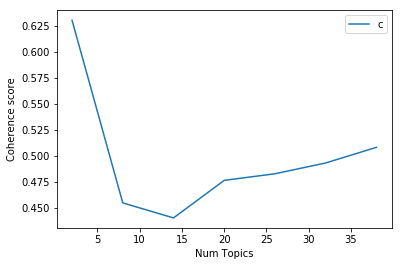

In [109]:
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, texts=tokenized_TM, start=2, limit=40, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()